In [1]:
from collections import defaultdict
import numpy as np
import time
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression

## Load Data

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
%%time
df = pd.read_csv('data/train.csv', dtype=dtypes)
print(df.shape)

(8921483, 83)
Wall time: 7min 19s


## Visualizations

In [4]:
null_dict = {}
drop_cols = []
for column in df.columns:
    null_perc = pd.isnull(df[column]).sum()*100/len(df)
    null_dict[column] = null_perc

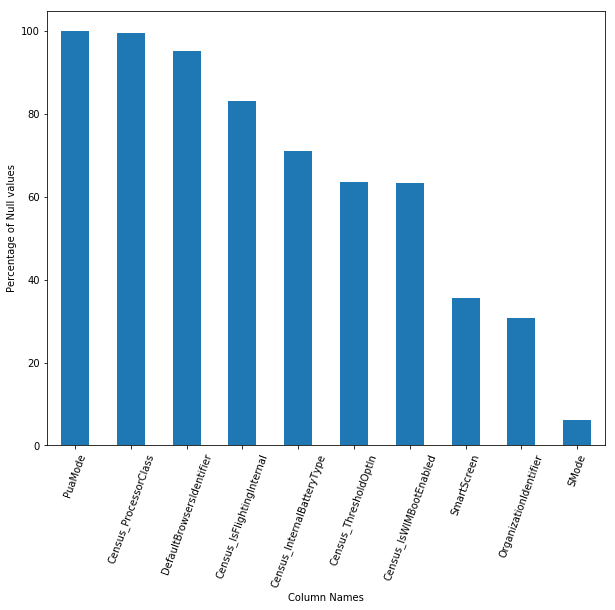

In [5]:
null_df = pd.DataFrame.from_dict(null_dict,  orient='index', columns=['null_perc'])
null_df_10 = null_df.sort_values(by=['null_perc'], ascending=[False])[:10]

fig, ax = plt.subplots(figsize=(10,8))
null_df_10.plot(y=['null_perc'], kind='bar', use_index=True, ax=ax, legend=False)
plt.xticks(rotation=70)
ax.set_xlabel('Column Names')
ax.set_ylabel("Percentage of Null values")
plt.show()

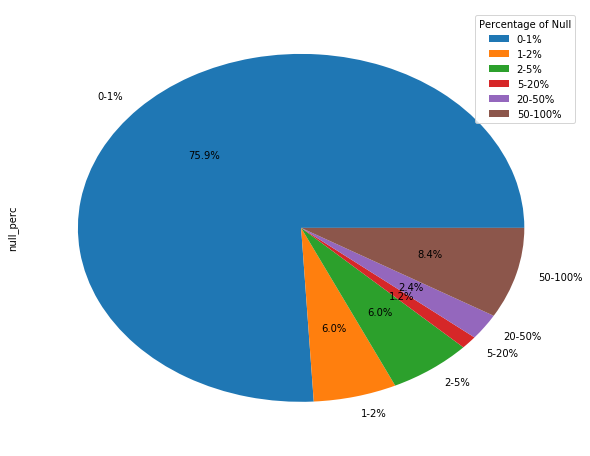

In [6]:
bins = [0.0, 1.0, 2.0, 5.0, 20.0, 50.0, 100.0]
scores = ['0-1%', '1-2%', '2-5%', '5-20%', '20-50%', '50-100%']
null_df['bins'] = pd.cut(null_df['null_perc'], bins, labels=scores, include_lowest =True)
null_df_grp = null_df.groupby(['bins']).count()

fracs = list(null_df_grp['null_perc'])
fig, ax = plt.subplots(figsize=(10,8))
null_df_grp.plot(fracs, y=['null_perc'], kind='pie', ax=ax, autopct='%1.1f%%', textprops={'fontsize':10})
ax.legend(title='Percentage of Null')
plt.show()

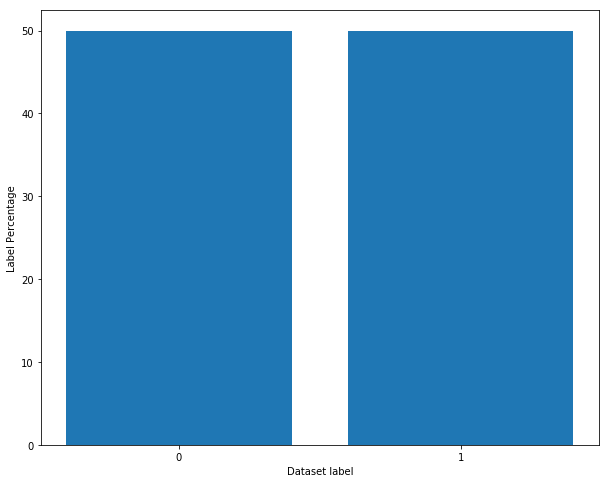

In [7]:
l0 = len(list(df['HasDetections'] == 0))
l1 = len(list(df['HasDetections'] == 1))
label_0 = l0*100/(l0 + l1) 
label_1 = l1*100/(l0 + l1) 

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x=['0', '1'], height=[label_0, label_1])
ax.set_xlabel('Dataset label')
ax.set_ylabel('Label Percentage')
plt.show()

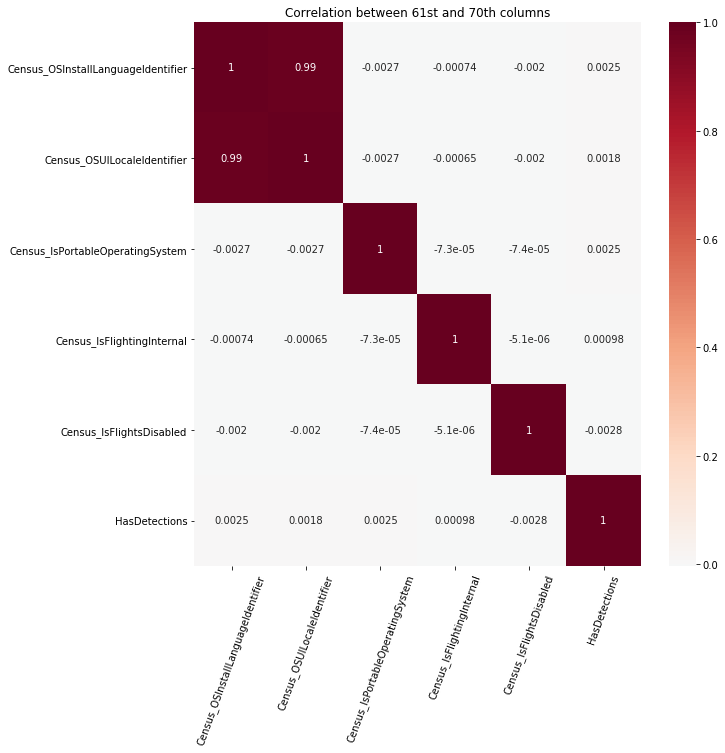

In [8]:
cols = list(df.columns)
co_cols = cols[60:70]
co_cols.append('HasDetections')
plt.figure(figsize=(10,10))
sns.heatmap(df[co_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.xticks(rotation=70)
plt.title('Correlation between 61st and 70th columns')
plt.show()

In [9]:
# Removing columns with > 5% null values
drop_cols = set()
for key, val in null_dict.items():
    if val > 5:
        drop_cols.add(key)

corr_cols = {'Census_ProcessorClass', 'Census_IsWIMBootEnabled', 'IsBeta', 'Census_IsFlightsDisabled', 'Census_IsFlightingInternal',
 'AutoSampleOptIn', 'Census_ThresholdOptIn', 'SMode', 'Census_IsPortableOperatingSystem', 'PuaMode', 'Census_DeviceFamily', 'UacLuaenable',
 'Census_IsVirtualDevice', 'Platform', 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier', 'Processor'}
drop_cols = drop_cols.union(corr_cols)

df_filtered = df.drop(drop_cols, axis=1)
df_filtered = df_filtered.dropna()

print(df_filtered.shape)

(7708138, 62)


In [10]:
# Converting categorical data to codes and storing the mapping
column_mapping = defaultdict(dict)
for col in df_filtered.columns:
    if df_filtered[col].dtype.name == 'category':
        col_dict = {}
        for i, cat in enumerate(df_filtered[col].cat.categories):
            col_dict[cat] = i
        column_mapping[col] = col_dict 
        df_filtered[col] = df_filtered[col].cat.codes

df_filtered.head(n=10)

MachineIdentifier  ProductName  EngineVersion  AppVersion  AvSigVersion  \
0                   0            1             32          27           836   
1                   1            1             22          17           259   
2                   2            1             32          27           714   
3                   3            1             32          27           760   
4                   4            1             32          27           723   
5                   5            1             32          27           655   
6                   6            1             32          27          1000   
7                   7            1             32          27           726   
8                   8            1             33          27          1506   
10                 10            1             32          27          1009   

    RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  \
0                7.0                 0                    53447.0   
1                7.0                 0                    53447.0   
2                7.0                 0                    53447.0   
3                7.0                 0                    53447.0   
4                7.0                 0                    53447.0   
5                7.0                 0                    53447.0   
6                7.0                 0                    43927.0   
7                7.0                 0                    53447.0   
8                7.0                 0                    53447.0   
10               7.0                 0                    53447.0   

    AVProductsInstalled  AVProductsEnabled      ...        Census_FlightRing  \
0                   1.0                1.0      ...                        3   
1                   1.0                1.0      ...                        1   
2                   1.0                1.0      ...                        3   
3                   1.0                1.0      ...                        3   
4                   1.0                1.0      ...                        3   
5                   1.0                1.0      ...                        3   
6                   2.0                1.0      ...                        3   
7                   1.0                1.0      ...                        3   
8                   1.0                1.0      ...                        3   
10                  1.0                1.0      ...                        3   

    Census_FirmwareManufacturerIdentifier  Census_FirmwareVersionIdentifier  \
0                                   628.0                           36144.0   
1                                   628.0                           57858.0   
2                                   142.0                           52682.0   
3                                   355.0                           20050.0   
4                                   355.0                           19844.0   
5                                    93.0                           51039.0   
6                                   556.0                           63175.0   
7                                   512.0                           63122.0   
8                                   500.0                           15510.0   
10                                  845.0                           50922.0   

    Census_IsSecureBootEnabled  Census_IsTouchEnabled  Census_IsPenCapable  \
0                            0                      0                    0   
1                            0                      0                    0   
2                            0                      0                    0   
3                            0                      0                    0   
4                            0                      0                    0   
5                            0                      0                    0   
6                            1                      0                    0   

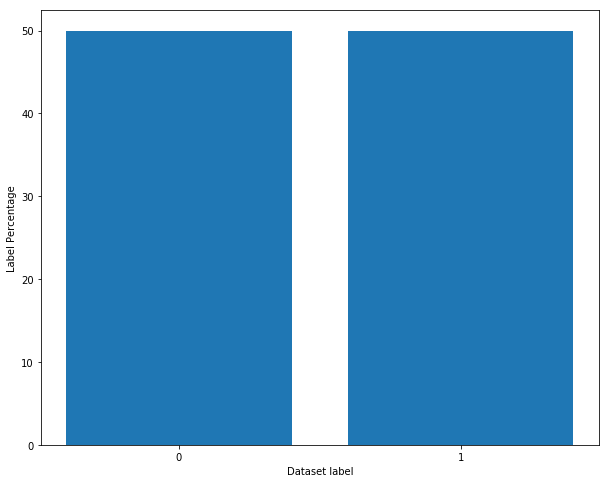

In [11]:
# Dataset labels after Null rows removal
l0 = len(list(df_filtered['HasDetections'] == 0))
l1 = len(list(df_filtered['HasDetections'] == 1))
label_0 = l0*100/(l0 + l1)
label_1 = l1*100/(l0 + l1)

fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x=['0', '1'], height=[label_0, label_1])
ax.set_xlabel('Dataset label')
ax.set_ylabel('Label Percentage')
plt.show()

In [12]:
# Training data creation
train_label = df_filtered['HasDetections']
train_data = df_filtered.drop(['HasDetections', 'MachineIdentifier'], axis=1)

## XGBoost

In [13]:
# Training dataset creation
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

eval_list = [(dtrain, 'train'), (dvalid, 'valid_data')]

params = {'learning_rate': 0.05, 
         'max_depth': 11,
          'min_child_weight': 7,
          'gamma': 0.2,
          'colsample_bytree': 0.4, 
          'subsample': 1,
          'reg_alpha': 0.6,
          'reg_lambda': 1,
         'objective': 'binary:logistic',
          'eval_metric': 'auc'
         }

In [14]:
#XGBoost training
start = time.time()
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=20000, evals=eval_list, early_stopping_rounds=200)
end = time.time()
print("XGBoost Training - {}s".format((end-start)))

In [15]:
#feature importance
fscores = sorted(bst.get_fscore().items(), key=lambda x: (x[1], x[0]), reverse=True)
print(fscores[:10])

In [16]:
# XGBoost Prediction
dtest = xgb.DMatrix(X_test)

start = time.time()
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
end = time.time()
print("XGBoost Prediction - {}s".format((end-start)))

accuracy = np.mean(np.round(ypred) == y_test) * 100
print('Accuracy = ', accuracy)

## LightGBM

In [17]:
# Training dataset creation
def lgbm_train(cols_list):
    if len(cols_list) == 0:
        train_data_filtered = train_data
    else:
        train_data_filtered = train_data[cols_list]
    
    X_train, X_test, y_train, y_test = train_test_split(train_data_filtered, train_label, test_size=0.2, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    dtrain = lgbm.Dataset(X_train, label=y_train)
    dvalid = lgbm.Dataset(X_valid, label=y_valid)

    params = {'num_leaves': 256,
             'min_data_in_leaf': 42,
             'objective': 'binary',
              "metric": 'auc',
             'max_depth': 5,
             'learning_rate': 0.05,
             "boosting": "gbdt",
             "feature_fraction": 0.8,
             "bagging_freq": 5,
             "bagging_fraction": 0.8,
             "bagging_seed": 11,
             "lambda_l1": 0.15,
             "lambda_l2": 0.15,
             "random_state": 42,
             "verbosity": -1
             }
    
    # #LightGBM training
    start = time.time()
    bst = lgbm.train(params, dtrain, num_boost_round=20000, valid_sets=[dtrain, dvalid], early_stopping_rounds=200)
    end = time.time()
    print("LGBM Training - {}s".format((end-start)))
    
    return bst, X_test, y_test

In [18]:
def lgbm_test(bst, X_test, y_test):
    #feature importance
    fscores = sorted(dict(zip(bst.feature_name(), bst.feature_importance())).items(), key=lambda x: (x[1], x[0]), reverse=True)
    
    # LightGBM Prediction
    start = time.time()
    ypred = bst.predict(X_test, num_iteration=bst.best_iteration)
    end = time.time()
    print("LGBM Prediction - {}s".format((end-start)))

    accuracy = np.mean(np.round(ypred) == y_test) * 100
    print('Accuracy = ', accuracy)
    
    return fscores

In [19]:
# Results with all columns
cols_list = []
bst, X_test, y_test = lgbm_train(cols_list)
fscores = lgbm_test(bst, X_test, y_test)

[1]	training's auc: 0.620348	valid_1's auc: 0.619377
Training until validation scores don't improve for 200 rounds
[2]	training's auc: 0.633736	valid_1's auc: 0.633009
[3]	training's auc: 0.633105	valid_1's auc: 0.632174
[4]	training's auc: 0.640051	valid_1's auc: 0.639202
[5]	training's auc: 0.64568	valid_1's auc: 0.644863
[6]	training's auc: 0.64576	valid_1's auc: 0.645022
[7]	training's auc: 0.646311	valid_1's auc: 0.645518
[8]	training's auc: 0.647135	valid_1's auc: 0.646375
[9]	training's auc: 0.646902	valid_1's auc: 0.646128
[10]	training's auc: 0.648015	valid_1's auc: 0.647256
[11]	training's auc: 0.648279	valid_1's auc: 0.647545
[12]	training's auc: 0.648408	valid_1's auc: 0.64766
[13]	training's auc: 0.649224	valid_1's auc: 0.64854
[14]	training's auc: 0.649457	valid_1's auc: 0.64875
[15]	training's auc: 0.65016	valid_1's auc: 0.649451
[16]	training's auc: 0.650293	valid_1's auc: 0.649597
[17]	training's auc: 0.650237	valid_1's auc: 0.649545
[18]	training's auc: 0.650778	valid

[152]	training's auc: 0.677364	valid_1's auc: 0.676239
[153]	training's auc: 0.677423	valid_1's auc: 0.676294
[154]	training's auc: 0.677492	valid_1's auc: 0.676368
[155]	training's auc: 0.677541	valid_1's auc: 0.676414
[156]	training's auc: 0.677667	valid_1's auc: 0.676541
[157]	training's auc: 0.677715	valid_1's auc: 0.676588
[158]	training's auc: 0.677764	valid_1's auc: 0.676636
[159]	training's auc: 0.677792	valid_1's auc: 0.676666
[160]	training's auc: 0.6779	valid_1's auc: 0.67677
[161]	training's auc: 0.677985	valid_1's auc: 0.676852
[162]	training's auc: 0.678077	valid_1's auc: 0.676945
[163]	training's auc: 0.678125	valid_1's auc: 0.676988
[164]	training's auc: 0.678194	valid_1's auc: 0.677053
[165]	training's auc: 0.678246	valid_1's auc: 0.677099
[166]	training's auc: 0.678349	valid_1's auc: 0.677199
[167]	training's auc: 0.678417	valid_1's auc: 0.677269
[168]	training's auc: 0.678459	valid_1's auc: 0.677311
[169]	training's auc: 0.678509	valid_1's auc: 0.677361
[170]	trainin

[302]	training's auc: 0.68468	valid_1's auc: 0.683255
[303]	training's auc: 0.684719	valid_1's auc: 0.683289
[304]	training's auc: 0.684781	valid_1's auc: 0.683344
[305]	training's auc: 0.684789	valid_1's auc: 0.683349
[306]	training's auc: 0.68487	valid_1's auc: 0.683431
[307]	training's auc: 0.684947	valid_1's auc: 0.683502
[308]	training's auc: 0.685013	valid_1's auc: 0.683568
[309]	training's auc: 0.685055	valid_1's auc: 0.683607
[310]	training's auc: 0.685088	valid_1's auc: 0.68364
[311]	training's auc: 0.685177	valid_1's auc: 0.683729
[312]	training's auc: 0.685225	valid_1's auc: 0.683776
[313]	training's auc: 0.685302	valid_1's auc: 0.683846
[314]	training's auc: 0.685347	valid_1's auc: 0.683884
[315]	training's auc: 0.68539	valid_1's auc: 0.683923
[316]	training's auc: 0.685425	valid_1's auc: 0.683951
[317]	training's auc: 0.685445	valid_1's auc: 0.68397
[318]	training's auc: 0.685478	valid_1's auc: 0.683999
[319]	training's auc: 0.685492	valid_1's auc: 0.684012
[320]	training'

[452]	training's auc: 0.689428	valid_1's auc: 0.687701
[453]	training's auc: 0.689453	valid_1's auc: 0.687722
[454]	training's auc: 0.689474	valid_1's auc: 0.68774
[455]	training's auc: 0.689496	valid_1's auc: 0.687762
[456]	training's auc: 0.689515	valid_1's auc: 0.687779
[457]	training's auc: 0.689532	valid_1's auc: 0.687793
[458]	training's auc: 0.689543	valid_1's auc: 0.687801
[459]	training's auc: 0.689566	valid_1's auc: 0.687823
[460]	training's auc: 0.689593	valid_1's auc: 0.687847
[461]	training's auc: 0.689611	valid_1's auc: 0.687862
[462]	training's auc: 0.689619	valid_1's auc: 0.687867
[463]	training's auc: 0.689652	valid_1's auc: 0.687899
[464]	training's auc: 0.689674	valid_1's auc: 0.687918
[465]	training's auc: 0.689681	valid_1's auc: 0.687925
[466]	training's auc: 0.689691	valid_1's auc: 0.687933
[467]	training's auc: 0.689712	valid_1's auc: 0.687954
[468]	training's auc: 0.689739	valid_1's auc: 0.687976
[469]	training's auc: 0.689766	valid_1's auc: 0.688
[470]	training

[602]	training's auc: 0.692809	valid_1's auc: 0.690741
[603]	training's auc: 0.69283	valid_1's auc: 0.690758
[604]	training's auc: 0.692849	valid_1's auc: 0.690775
[605]	training's auc: 0.692862	valid_1's auc: 0.690787
[606]	training's auc: 0.692899	valid_1's auc: 0.690821
[607]	training's auc: 0.692907	valid_1's auc: 0.690827
[608]	training's auc: 0.692938	valid_1's auc: 0.690857
[609]	training's auc: 0.692953	valid_1's auc: 0.690872
[610]	training's auc: 0.692969	valid_1's auc: 0.690885
[611]	training's auc: 0.692992	valid_1's auc: 0.690906
[612]	training's auc: 0.693003	valid_1's auc: 0.690913
[613]	training's auc: 0.693015	valid_1's auc: 0.690923
[614]	training's auc: 0.69304	valid_1's auc: 0.690942
[615]	training's auc: 0.69305	valid_1's auc: 0.69095
[616]	training's auc: 0.693073	valid_1's auc: 0.690969
[617]	training's auc: 0.69309	valid_1's auc: 0.690984
[618]	training's auc: 0.693099	valid_1's auc: 0.690993
[619]	training's auc: 0.693116	valid_1's auc: 0.691009
[620]	training'

[752]	training's auc: 0.695197	valid_1's auc: 0.692746
[753]	training's auc: 0.695202	valid_1's auc: 0.692749
[754]	training's auc: 0.695207	valid_1's auc: 0.692752
[755]	training's auc: 0.69522	valid_1's auc: 0.692761
[756]	training's auc: 0.695236	valid_1's auc: 0.692776
[757]	training's auc: 0.695268	valid_1's auc: 0.692803
[758]	training's auc: 0.695277	valid_1's auc: 0.692807
[759]	training's auc: 0.695292	valid_1's auc: 0.692822
[760]	training's auc: 0.695314	valid_1's auc: 0.69284
[761]	training's auc: 0.695336	valid_1's auc: 0.692857
[762]	training's auc: 0.695355	valid_1's auc: 0.692872
[763]	training's auc: 0.695365	valid_1's auc: 0.692878
[764]	training's auc: 0.695386	valid_1's auc: 0.692896
[765]	training's auc: 0.695418	valid_1's auc: 0.692927
[766]	training's auc: 0.695432	valid_1's auc: 0.69294
[767]	training's auc: 0.69544	valid_1's auc: 0.692948
[768]	training's auc: 0.695451	valid_1's auc: 0.692955
[769]	training's auc: 0.695461	valid_1's auc: 0.692962
[770]	training

[902]	training's auc: 0.697256	valid_1's auc: 0.694442
[903]	training's auc: 0.697261	valid_1's auc: 0.694444
[904]	training's auc: 0.697282	valid_1's auc: 0.694461
[905]	training's auc: 0.697292	valid_1's auc: 0.69447
[906]	training's auc: 0.697317	valid_1's auc: 0.694493
[907]	training's auc: 0.697319	valid_1's auc: 0.694493
[908]	training's auc: 0.697328	valid_1's auc: 0.6945
[909]	training's auc: 0.697336	valid_1's auc: 0.694508
[910]	training's auc: 0.697339	valid_1's auc: 0.694509
[911]	training's auc: 0.697357	valid_1's auc: 0.694525
[912]	training's auc: 0.697376	valid_1's auc: 0.694542
[913]	training's auc: 0.697392	valid_1's auc: 0.694554
[914]	training's auc: 0.697399	valid_1's auc: 0.694558
[915]	training's auc: 0.697407	valid_1's auc: 0.694564
[916]	training's auc: 0.697421	valid_1's auc: 0.694573
[917]	training's auc: 0.697429	valid_1's auc: 0.694578
[918]	training's auc: 0.697439	valid_1's auc: 0.694584
[919]	training's auc: 0.697443	valid_1's auc: 0.694585
[920]	trainin

[1051]	training's auc: 0.699004	valid_1's auc: 0.695841
[1052]	training's auc: 0.699009	valid_1's auc: 0.695844
[1053]	training's auc: 0.699017	valid_1's auc: 0.695852
[1054]	training's auc: 0.699022	valid_1's auc: 0.695855
[1055]	training's auc: 0.699027	valid_1's auc: 0.695857
[1056]	training's auc: 0.699034	valid_1's auc: 0.695863
[1057]	training's auc: 0.699039	valid_1's auc: 0.695868
[1058]	training's auc: 0.699048	valid_1's auc: 0.695875
[1059]	training's auc: 0.699058	valid_1's auc: 0.695881
[1060]	training's auc: 0.699063	valid_1's auc: 0.695885
[1061]	training's auc: 0.699082	valid_1's auc: 0.695903
[1062]	training's auc: 0.699107	valid_1's auc: 0.695929
[1063]	training's auc: 0.699125	valid_1's auc: 0.695946
[1064]	training's auc: 0.699147	valid_1's auc: 0.69597
[1065]	training's auc: 0.699152	valid_1's auc: 0.695973
[1066]	training's auc: 0.699163	valid_1's auc: 0.695981
[1067]	training's auc: 0.699165	valid_1's auc: 0.695981
[1068]	training's auc: 0.699175	valid_1's auc: 0.

[1198]	training's auc: 0.700505	valid_1's auc: 0.69707
[1199]	training's auc: 0.700515	valid_1's auc: 0.69708
[1200]	training's auc: 0.700526	valid_1's auc: 0.69709
[1201]	training's auc: 0.700533	valid_1's auc: 0.697095
[1202]	training's auc: 0.700543	valid_1's auc: 0.697104
[1203]	training's auc: 0.700547	valid_1's auc: 0.697106
[1204]	training's auc: 0.700553	valid_1's auc: 0.697107
[1205]	training's auc: 0.700559	valid_1's auc: 0.697113
[1206]	training's auc: 0.700565	valid_1's auc: 0.697116
[1207]	training's auc: 0.70057	valid_1's auc: 0.697119
[1208]	training's auc: 0.700575	valid_1's auc: 0.697123
[1209]	training's auc: 0.700579	valid_1's auc: 0.697126
[1210]	training's auc: 0.700585	valid_1's auc: 0.697129
[1211]	training's auc: 0.700592	valid_1's auc: 0.697134
[1212]	training's auc: 0.700599	valid_1's auc: 0.697138
[1213]	training's auc: 0.700607	valid_1's auc: 0.697143
[1214]	training's auc: 0.700615	valid_1's auc: 0.697148
[1215]	training's auc: 0.700626	valid_1's auc: 0.697

[1345]	training's auc: 0.701771	valid_1's auc: 0.697994
[1346]	training's auc: 0.701792	valid_1's auc: 0.698015
[1347]	training's auc: 0.7018	valid_1's auc: 0.69802
[1348]	training's auc: 0.701807	valid_1's auc: 0.698024
[1349]	training's auc: 0.701819	valid_1's auc: 0.698034
[1350]	training's auc: 0.701828	valid_1's auc: 0.698039
[1351]	training's auc: 0.701836	valid_1's auc: 0.698046
[1352]	training's auc: 0.701844	valid_1's auc: 0.698051
[1353]	training's auc: 0.70185	valid_1's auc: 0.698054
[1354]	training's auc: 0.701856	valid_1's auc: 0.698056
[1355]	training's auc: 0.70187	valid_1's auc: 0.698069
[1356]	training's auc: 0.701873	valid_1's auc: 0.698071
[1357]	training's auc: 0.701875	valid_1's auc: 0.698071
[1358]	training's auc: 0.701882	valid_1's auc: 0.698077
[1359]	training's auc: 0.701894	valid_1's auc: 0.698086
[1360]	training's auc: 0.701895	valid_1's auc: 0.698086
[1361]	training's auc: 0.701899	valid_1's auc: 0.698086
[1362]	training's auc: 0.701906	valid_1's auc: 0.6980

[1492]	training's auc: 0.702871	valid_1's auc: 0.698809
[1493]	training's auc: 0.702874	valid_1's auc: 0.698809
[1494]	training's auc: 0.702877	valid_1's auc: 0.69881
[1495]	training's auc: 0.702882	valid_1's auc: 0.698813
[1496]	training's auc: 0.702888	valid_1's auc: 0.698817
[1497]	training's auc: 0.702892	valid_1's auc: 0.69882
[1498]	training's auc: 0.702901	valid_1's auc: 0.698829
[1499]	training's auc: 0.702907	valid_1's auc: 0.698833
[1500]	training's auc: 0.702911	valid_1's auc: 0.698835
[1501]	training's auc: 0.702918	valid_1's auc: 0.698838
[1502]	training's auc: 0.702927	valid_1's auc: 0.698846
[1503]	training's auc: 0.702937	valid_1's auc: 0.69885
[1504]	training's auc: 0.702947	valid_1's auc: 0.698858
[1505]	training's auc: 0.702956	valid_1's auc: 0.698866
[1506]	training's auc: 0.702958	valid_1's auc: 0.698866
[1507]	training's auc: 0.70296	valid_1's auc: 0.698866
[1508]	training's auc: 0.702962	valid_1's auc: 0.698867
[1509]	training's auc: 0.702963	valid_1's auc: 0.698

[1639]	training's auc: 0.703861	valid_1's auc: 0.699478
[1640]	training's auc: 0.703868	valid_1's auc: 0.699482
[1641]	training's auc: 0.703874	valid_1's auc: 0.699486
[1642]	training's auc: 0.703877	valid_1's auc: 0.699487
[1643]	training's auc: 0.703879	valid_1's auc: 0.699486
[1644]	training's auc: 0.703885	valid_1's auc: 0.699489
[1645]	training's auc: 0.703887	valid_1's auc: 0.69949
[1646]	training's auc: 0.703896	valid_1's auc: 0.699498
[1647]	training's auc: 0.703903	valid_1's auc: 0.699503
[1648]	training's auc: 0.703912	valid_1's auc: 0.699509
[1649]	training's auc: 0.703918	valid_1's auc: 0.699515
[1650]	training's auc: 0.703925	valid_1's auc: 0.69952
[1651]	training's auc: 0.703936	valid_1's auc: 0.699528
[1652]	training's auc: 0.703938	valid_1's auc: 0.699528
[1653]	training's auc: 0.703947	valid_1's auc: 0.699537
[1654]	training's auc: 0.703959	valid_1's auc: 0.699548
[1655]	training's auc: 0.703962	valid_1's auc: 0.69955
[1656]	training's auc: 0.703964	valid_1's auc: 0.69

[1786]	training's auc: 0.704848	valid_1's auc: 0.700167
[1787]	training's auc: 0.704853	valid_1's auc: 0.700168
[1788]	training's auc: 0.704859	valid_1's auc: 0.700171
[1789]	training's auc: 0.704863	valid_1's auc: 0.700173
[1790]	training's auc: 0.704867	valid_1's auc: 0.700174
[1791]	training's auc: 0.704871	valid_1's auc: 0.700176
[1792]	training's auc: 0.704874	valid_1's auc: 0.700178
[1793]	training's auc: 0.704876	valid_1's auc: 0.700178
[1794]	training's auc: 0.704883	valid_1's auc: 0.700182
[1795]	training's auc: 0.704888	valid_1's auc: 0.700185
[1796]	training's auc: 0.704899	valid_1's auc: 0.700193
[1797]	training's auc: 0.704905	valid_1's auc: 0.700196
[1798]	training's auc: 0.704911	valid_1's auc: 0.7002
[1799]	training's auc: 0.704917	valid_1's auc: 0.700202
[1800]	training's auc: 0.704925	valid_1's auc: 0.700207
[1801]	training's auc: 0.704928	valid_1's auc: 0.700207
[1802]	training's auc: 0.704932	valid_1's auc: 0.700208
[1803]	training's auc: 0.704935	valid_1's auc: 0.7

[1933]	training's auc: 0.705717	valid_1's auc: 0.700758
[1934]	training's auc: 0.705724	valid_1's auc: 0.700761
[1935]	training's auc: 0.705727	valid_1's auc: 0.700762
[1936]	training's auc: 0.705733	valid_1's auc: 0.700766
[1937]	training's auc: 0.705738	valid_1's auc: 0.700769
[1938]	training's auc: 0.705745	valid_1's auc: 0.700773
[1939]	training's auc: 0.705751	valid_1's auc: 0.700778
[1940]	training's auc: 0.705757	valid_1's auc: 0.700781
[1941]	training's auc: 0.705764	valid_1's auc: 0.700783
[1942]	training's auc: 0.705769	valid_1's auc: 0.700785
[1943]	training's auc: 0.705775	valid_1's auc: 0.700785
[1944]	training's auc: 0.705782	valid_1's auc: 0.700789
[1945]	training's auc: 0.705787	valid_1's auc: 0.700791
[1946]	training's auc: 0.705794	valid_1's auc: 0.700795
[1947]	training's auc: 0.705796	valid_1's auc: 0.700796
[1948]	training's auc: 0.705803	valid_1's auc: 0.7008
[1949]	training's auc: 0.705813	valid_1's auc: 0.70081
[1950]	training's auc: 0.705818	valid_1's auc: 0.70

[2080]	training's auc: 0.706579	valid_1's auc: 0.701299
[2081]	training's auc: 0.706583	valid_1's auc: 0.701301
[2082]	training's auc: 0.706589	valid_1's auc: 0.701306
[2083]	training's auc: 0.706596	valid_1's auc: 0.701311
[2084]	training's auc: 0.7066	valid_1's auc: 0.701314
[2085]	training's auc: 0.706605	valid_1's auc: 0.701318
[2086]	training's auc: 0.70661	valid_1's auc: 0.701319
[2087]	training's auc: 0.706613	valid_1's auc: 0.701318
[2088]	training's auc: 0.706617	valid_1's auc: 0.701319
[2089]	training's auc: 0.70662	valid_1's auc: 0.701319
[2090]	training's auc: 0.706632	valid_1's auc: 0.701329
[2091]	training's auc: 0.706634	valid_1's auc: 0.70133
[2092]	training's auc: 0.706636	valid_1's auc: 0.701331
[2093]	training's auc: 0.706637	valid_1's auc: 0.701331
[2094]	training's auc: 0.706646	valid_1's auc: 0.701339
[2095]	training's auc: 0.706648	valid_1's auc: 0.70134
[2096]	training's auc: 0.706652	valid_1's auc: 0.701341
[2097]	training's auc: 0.706654	valid_1's auc: 0.70134

[2227]	training's auc: 0.707309	valid_1's auc: 0.701723
[2228]	training's auc: 0.70731	valid_1's auc: 0.701724
[2229]	training's auc: 0.707312	valid_1's auc: 0.701724
[2230]	training's auc: 0.707313	valid_1's auc: 0.701724
[2231]	training's auc: 0.707316	valid_1's auc: 0.701725
[2232]	training's auc: 0.707319	valid_1's auc: 0.701726
[2233]	training's auc: 0.70732	valid_1's auc: 0.701726
[2234]	training's auc: 0.70732	valid_1's auc: 0.701725
[2235]	training's auc: 0.707321	valid_1's auc: 0.701724
[2236]	training's auc: 0.707323	valid_1's auc: 0.701723
[2237]	training's auc: 0.707331	valid_1's auc: 0.701731
[2238]	training's auc: 0.70734	valid_1's auc: 0.701738
[2239]	training's auc: 0.707346	valid_1's auc: 0.701744
[2240]	training's auc: 0.707349	valid_1's auc: 0.701744
[2241]	training's auc: 0.707353	valid_1's auc: 0.701747
[2242]	training's auc: 0.707358	valid_1's auc: 0.70175
[2243]	training's auc: 0.707363	valid_1's auc: 0.701752
[2244]	training's auc: 0.707365	valid_1's auc: 0.7017

[2374]	training's auc: 0.708049	valid_1's auc: 0.702169
[2375]	training's auc: 0.708055	valid_1's auc: 0.702173
[2376]	training's auc: 0.708059	valid_1's auc: 0.702173
[2377]	training's auc: 0.708062	valid_1's auc: 0.702175
[2378]	training's auc: 0.708067	valid_1's auc: 0.702178
[2379]	training's auc: 0.708069	valid_1's auc: 0.702178
[2380]	training's auc: 0.708074	valid_1's auc: 0.702181
[2381]	training's auc: 0.708078	valid_1's auc: 0.702184
[2382]	training's auc: 0.708081	valid_1's auc: 0.702185
[2383]	training's auc: 0.708084	valid_1's auc: 0.702186
[2384]	training's auc: 0.708087	valid_1's auc: 0.702188
[2385]	training's auc: 0.708092	valid_1's auc: 0.702189
[2386]	training's auc: 0.708097	valid_1's auc: 0.702192
[2387]	training's auc: 0.708101	valid_1's auc: 0.702193
[2388]	training's auc: 0.708104	valid_1's auc: 0.702195
[2389]	training's auc: 0.708108	valid_1's auc: 0.702196
[2390]	training's auc: 0.708111	valid_1's auc: 0.702197
[2391]	training's auc: 0.708116	valid_1's auc: 0

[2521]	training's auc: 0.708729	valid_1's auc: 0.702562
[2522]	training's auc: 0.708734	valid_1's auc: 0.702565
[2523]	training's auc: 0.708738	valid_1's auc: 0.702567
[2524]	training's auc: 0.708743	valid_1's auc: 0.702567
[2525]	training's auc: 0.708747	valid_1's auc: 0.702569
[2526]	training's auc: 0.708751	valid_1's auc: 0.702571
[2527]	training's auc: 0.708755	valid_1's auc: 0.702571
[2528]	training's auc: 0.70876	valid_1's auc: 0.702572
[2529]	training's auc: 0.708764	valid_1's auc: 0.702573
[2530]	training's auc: 0.708767	valid_1's auc: 0.702573
[2531]	training's auc: 0.708773	valid_1's auc: 0.702579
[2532]	training's auc: 0.708779	valid_1's auc: 0.702585
[2533]	training's auc: 0.708785	valid_1's auc: 0.70259
[2534]	training's auc: 0.708789	valid_1's auc: 0.702592
[2535]	training's auc: 0.708793	valid_1's auc: 0.702594
[2536]	training's auc: 0.708797	valid_1's auc: 0.702596
[2537]	training's auc: 0.708802	valid_1's auc: 0.702599
[2538]	training's auc: 0.708805	valid_1's auc: 0.7

[2668]	training's auc: 0.709366	valid_1's auc: 0.702897
[2669]	training's auc: 0.709371	valid_1's auc: 0.7029
[2670]	training's auc: 0.709375	valid_1's auc: 0.702901
[2671]	training's auc: 0.70938	valid_1's auc: 0.702903
[2672]	training's auc: 0.709383	valid_1's auc: 0.702905
[2673]	training's auc: 0.709387	valid_1's auc: 0.702906
[2674]	training's auc: 0.709389	valid_1's auc: 0.702907
[2675]	training's auc: 0.709395	valid_1's auc: 0.702909
[2676]	training's auc: 0.709398	valid_1's auc: 0.70291
[2677]	training's auc: 0.709402	valid_1's auc: 0.702911
[2678]	training's auc: 0.709405	valid_1's auc: 0.702911
[2679]	training's auc: 0.709409	valid_1's auc: 0.702913
[2680]	training's auc: 0.709414	valid_1's auc: 0.702917
[2681]	training's auc: 0.70942	valid_1's auc: 0.702922
[2682]	training's auc: 0.709427	valid_1's auc: 0.702927
[2683]	training's auc: 0.70943	valid_1's auc: 0.702927
[2684]	training's auc: 0.709435	valid_1's auc: 0.70293
[2685]	training's auc: 0.709439	valid_1's auc: 0.702932

[2815]	training's auc: 0.709977	valid_1's auc: 0.703221
[2816]	training's auc: 0.70998	valid_1's auc: 0.703222
[2817]	training's auc: 0.709984	valid_1's auc: 0.703224
[2818]	training's auc: 0.709988	valid_1's auc: 0.703226
[2819]	training's auc: 0.709992	valid_1's auc: 0.703228
[2820]	training's auc: 0.709996	valid_1's auc: 0.70323
[2821]	training's auc: 0.710002	valid_1's auc: 0.703234
[2822]	training's auc: 0.710009	valid_1's auc: 0.703238
[2823]	training's auc: 0.710015	valid_1's auc: 0.703243
[2824]	training's auc: 0.710019	valid_1's auc: 0.703245
[2825]	training's auc: 0.710023	valid_1's auc: 0.703249
[2826]	training's auc: 0.71003	valid_1's auc: 0.703253
[2827]	training's auc: 0.710034	valid_1's auc: 0.703255
[2828]	training's auc: 0.710037	valid_1's auc: 0.703255
[2829]	training's auc: 0.710039	valid_1's auc: 0.703255
[2830]	training's auc: 0.710044	valid_1's auc: 0.703256
[2831]	training's auc: 0.710049	valid_1's auc: 0.703259
[2832]	training's auc: 0.710054	valid_1's auc: 0.70

[2962]	training's auc: 0.710597	valid_1's auc: 0.703548
[2963]	training's auc: 0.7106	valid_1's auc: 0.70355
[2964]	training's auc: 0.710604	valid_1's auc: 0.703552
[2965]	training's auc: 0.710607	valid_1's auc: 0.703554
[2966]	training's auc: 0.710611	valid_1's auc: 0.703555
[2967]	training's auc: 0.710615	valid_1's auc: 0.703557
[2968]	training's auc: 0.710619	valid_1's auc: 0.703559
[2969]	training's auc: 0.710622	valid_1's auc: 0.70356
[2970]	training's auc: 0.710627	valid_1's auc: 0.703562
[2971]	training's auc: 0.710628	valid_1's auc: 0.703562
[2972]	training's auc: 0.71063	valid_1's auc: 0.703562
[2973]	training's auc: 0.710631	valid_1's auc: 0.703562
[2974]	training's auc: 0.710633	valid_1's auc: 0.703563
[2975]	training's auc: 0.710634	valid_1's auc: 0.703563
[2976]	training's auc: 0.710638	valid_1's auc: 0.703566
[2977]	training's auc: 0.710641	valid_1's auc: 0.703566
[2978]	training's auc: 0.710644	valid_1's auc: 0.703567
[2979]	training's auc: 0.710648	valid_1's auc: 0.7035

[3109]	training's auc: 0.711146	valid_1's auc: 0.703809
[3110]	training's auc: 0.711148	valid_1's auc: 0.70381
[3111]	training's auc: 0.711151	valid_1's auc: 0.70381
[3112]	training's auc: 0.711155	valid_1's auc: 0.703812
[3113]	training's auc: 0.71116	valid_1's auc: 0.703814
[3114]	training's auc: 0.711166	valid_1's auc: 0.703817
[3115]	training's auc: 0.711172	valid_1's auc: 0.703822
[3116]	training's auc: 0.711175	valid_1's auc: 0.703822
[3117]	training's auc: 0.711178	valid_1's auc: 0.703824
[3118]	training's auc: 0.711182	valid_1's auc: 0.703825
[3119]	training's auc: 0.711184	valid_1's auc: 0.703826
[3120]	training's auc: 0.711188	valid_1's auc: 0.703826
[3121]	training's auc: 0.711192	valid_1's auc: 0.703828
[3122]	training's auc: 0.711193	valid_1's auc: 0.703828
[3123]	training's auc: 0.711196	valid_1's auc: 0.703829
[3124]	training's auc: 0.711199	valid_1's auc: 0.70383
[3125]	training's auc: 0.711203	valid_1's auc: 0.703832
[3126]	training's auc: 0.711206	valid_1's auc: 0.703

[3256]	training's auc: 0.711628	valid_1's auc: 0.704013
[3257]	training's auc: 0.71163	valid_1's auc: 0.704014
[3258]	training's auc: 0.711631	valid_1's auc: 0.704014
[3259]	training's auc: 0.711634	valid_1's auc: 0.704015
[3260]	training's auc: 0.711636	valid_1's auc: 0.704016
[3261]	training's auc: 0.711641	valid_1's auc: 0.704019
[3262]	training's auc: 0.711646	valid_1's auc: 0.704021
[3263]	training's auc: 0.71165	valid_1's auc: 0.704025
[3264]	training's auc: 0.711653	valid_1's auc: 0.704028
[3265]	training's auc: 0.711659	valid_1's auc: 0.704032
[3266]	training's auc: 0.711662	valid_1's auc: 0.704034
[3267]	training's auc: 0.711665	valid_1's auc: 0.704037
[3268]	training's auc: 0.711669	valid_1's auc: 0.704038
[3269]	training's auc: 0.711672	valid_1's auc: 0.70404
[3270]	training's auc: 0.711674	valid_1's auc: 0.70404
[3271]	training's auc: 0.711677	valid_1's auc: 0.704042
[3272]	training's auc: 0.711681	valid_1's auc: 0.704043
[3273]	training's auc: 0.711683	valid_1's auc: 0.704

[3403]	training's auc: 0.712141	valid_1's auc: 0.704287
[3404]	training's auc: 0.712144	valid_1's auc: 0.704288
[3405]	training's auc: 0.712147	valid_1's auc: 0.704289
[3406]	training's auc: 0.712148	valid_1's auc: 0.70429
[3407]	training's auc: 0.71215	valid_1's auc: 0.70429
[3408]	training's auc: 0.712152	valid_1's auc: 0.704292
[3409]	training's auc: 0.712154	valid_1's auc: 0.704293
[3410]	training's auc: 0.712156	valid_1's auc: 0.704294
[3411]	training's auc: 0.712159	valid_1's auc: 0.704295
[3412]	training's auc: 0.712163	valid_1's auc: 0.704297
[3413]	training's auc: 0.712166	valid_1's auc: 0.704299
[3414]	training's auc: 0.712169	valid_1's auc: 0.7043
[3415]	training's auc: 0.71217	valid_1's auc: 0.7043
[3416]	training's auc: 0.712173	valid_1's auc: 0.704301
[3417]	training's auc: 0.712175	valid_1's auc: 0.704303
[3418]	training's auc: 0.712177	valid_1's auc: 0.704304
[3419]	training's auc: 0.712179	valid_1's auc: 0.704304
[3420]	training's auc: 0.712181	valid_1's auc: 0.704304


[3551]	training's auc: 0.712667	valid_1's auc: 0.704541
[3552]	training's auc: 0.712675	valid_1's auc: 0.704548
[3553]	training's auc: 0.712681	valid_1's auc: 0.704553
[3554]	training's auc: 0.712689	valid_1's auc: 0.70456
[3555]	training's auc: 0.712695	valid_1's auc: 0.704564
[3556]	training's auc: 0.712697	valid_1's auc: 0.704565
[3557]	training's auc: 0.7127	valid_1's auc: 0.704566
[3558]	training's auc: 0.712704	valid_1's auc: 0.704568
[3559]	training's auc: 0.712706	valid_1's auc: 0.704569
[3560]	training's auc: 0.712709	valid_1's auc: 0.704571
[3561]	training's auc: 0.712712	valid_1's auc: 0.704572
[3562]	training's auc: 0.712716	valid_1's auc: 0.704573
[3563]	training's auc: 0.712719	valid_1's auc: 0.704574
[3564]	training's auc: 0.712722	valid_1's auc: 0.704574
[3565]	training's auc: 0.712726	valid_1's auc: 0.704576
[3566]	training's auc: 0.712728	valid_1's auc: 0.704577
[3567]	training's auc: 0.712729	valid_1's auc: 0.704578
[3568]	training's auc: 0.712731	valid_1's auc: 0.70

[3698]	training's auc: 0.713203	valid_1's auc: 0.704785
[3699]	training's auc: 0.713206	valid_1's auc: 0.704786
[3700]	training's auc: 0.713213	valid_1's auc: 0.704791
[3701]	training's auc: 0.713217	valid_1's auc: 0.704794
[3702]	training's auc: 0.713219	valid_1's auc: 0.704796
[3703]	training's auc: 0.713222	valid_1's auc: 0.704797
[3704]	training's auc: 0.713226	valid_1's auc: 0.704798
[3705]	training's auc: 0.713232	valid_1's auc: 0.704801
[3706]	training's auc: 0.713233	valid_1's auc: 0.704801
[3707]	training's auc: 0.713236	valid_1's auc: 0.704801
[3708]	training's auc: 0.713238	valid_1's auc: 0.704802
[3709]	training's auc: 0.713242	valid_1's auc: 0.704803
[3710]	training's auc: 0.713244	valid_1's auc: 0.704804
[3711]	training's auc: 0.713249	valid_1's auc: 0.704806
[3712]	training's auc: 0.713251	valid_1's auc: 0.704808
[3713]	training's auc: 0.713256	valid_1's auc: 0.70481
[3714]	training's auc: 0.713261	valid_1's auc: 0.704811
[3715]	training's auc: 0.713265	valid_1's auc: 0.

[3845]	training's auc: 0.713703	valid_1's auc: 0.705001
[3846]	training's auc: 0.713706	valid_1's auc: 0.705002
[3847]	training's auc: 0.71371	valid_1's auc: 0.705004
[3848]	training's auc: 0.713711	valid_1's auc: 0.705004
[3849]	training's auc: 0.713712	valid_1's auc: 0.705004
[3850]	training's auc: 0.713714	valid_1's auc: 0.705005
[3851]	training's auc: 0.713717	valid_1's auc: 0.705005
[3852]	training's auc: 0.713719	valid_1's auc: 0.705006
[3853]	training's auc: 0.713722	valid_1's auc: 0.705006
[3854]	training's auc: 0.713726	valid_1's auc: 0.705007
[3855]	training's auc: 0.713729	valid_1's auc: 0.705008
[3856]	training's auc: 0.713733	valid_1's auc: 0.70501
[3857]	training's auc: 0.713735	valid_1's auc: 0.705011
[3858]	training's auc: 0.713739	valid_1's auc: 0.705012
[3859]	training's auc: 0.713744	valid_1's auc: 0.705013
[3860]	training's auc: 0.713747	valid_1's auc: 0.705014
[3861]	training's auc: 0.71375	valid_1's auc: 0.705014
[3862]	training's auc: 0.713753	valid_1's auc: 0.70

[3993]	training's auc: 0.714168	valid_1's auc: 0.705163
[3994]	training's auc: 0.71417	valid_1's auc: 0.705163
[3995]	training's auc: 0.714172	valid_1's auc: 0.705164
[3996]	training's auc: 0.714173	valid_1's auc: 0.705163
[3997]	training's auc: 0.714175	valid_1's auc: 0.705164
[3998]	training's auc: 0.714176	valid_1's auc: 0.705165
[3999]	training's auc: 0.714178	valid_1's auc: 0.705165
[4000]	training's auc: 0.714179	valid_1's auc: 0.705166
[4001]	training's auc: 0.714182	valid_1's auc: 0.705166
[4002]	training's auc: 0.714187	valid_1's auc: 0.705169
[4003]	training's auc: 0.71419	valid_1's auc: 0.70517
[4004]	training's auc: 0.714193	valid_1's auc: 0.705171
[4005]	training's auc: 0.714195	valid_1's auc: 0.705171
[4006]	training's auc: 0.714198	valid_1's auc: 0.705172
[4007]	training's auc: 0.714201	valid_1's auc: 0.705173
[4008]	training's auc: 0.714204	valid_1's auc: 0.705174
[4009]	training's auc: 0.714206	valid_1's auc: 0.705174
[4010]	training's auc: 0.714209	valid_1's auc: 0.70

[4140]	training's auc: 0.714604	valid_1's auc: 0.70534
[4141]	training's auc: 0.714608	valid_1's auc: 0.705342
[4142]	training's auc: 0.714611	valid_1's auc: 0.705343
[4143]	training's auc: 0.714614	valid_1's auc: 0.705345
[4144]	training's auc: 0.714617	valid_1's auc: 0.705345
[4145]	training's auc: 0.714619	valid_1's auc: 0.705346
[4146]	training's auc: 0.714621	valid_1's auc: 0.705347
[4147]	training's auc: 0.714623	valid_1's auc: 0.705348
[4148]	training's auc: 0.714624	valid_1's auc: 0.705348
[4149]	training's auc: 0.714626	valid_1's auc: 0.70535
[4150]	training's auc: 0.714627	valid_1's auc: 0.70535
[4151]	training's auc: 0.714631	valid_1's auc: 0.705352
[4152]	training's auc: 0.714634	valid_1's auc: 0.705354
[4153]	training's auc: 0.714642	valid_1's auc: 0.70536
[4154]	training's auc: 0.714646	valid_1's auc: 0.705362
[4155]	training's auc: 0.714649	valid_1's auc: 0.705363
[4156]	training's auc: 0.714652	valid_1's auc: 0.705364
[4157]	training's auc: 0.714656	valid_1's auc: 0.705

[4287]	training's auc: 0.715027	valid_1's auc: 0.705513
[4288]	training's auc: 0.715032	valid_1's auc: 0.705516
[4289]	training's auc: 0.715033	valid_1's auc: 0.705516
[4290]	training's auc: 0.715037	valid_1's auc: 0.705517
[4291]	training's auc: 0.715039	valid_1's auc: 0.705518
[4292]	training's auc: 0.71504	valid_1's auc: 0.705518
[4293]	training's auc: 0.715042	valid_1's auc: 0.705519
[4294]	training's auc: 0.715045	valid_1's auc: 0.70552
[4295]	training's auc: 0.715046	valid_1's auc: 0.70552
[4296]	training's auc: 0.715049	valid_1's auc: 0.705521
[4297]	training's auc: 0.715052	valid_1's auc: 0.705522
[4298]	training's auc: 0.715055	valid_1's auc: 0.705523
[4299]	training's auc: 0.715057	valid_1's auc: 0.705524
[4300]	training's auc: 0.71506	valid_1's auc: 0.705524
[4301]	training's auc: 0.715064	valid_1's auc: 0.705526
[4302]	training's auc: 0.715069	valid_1's auc: 0.705528
[4303]	training's auc: 0.715073	valid_1's auc: 0.705531
[4304]	training's auc: 0.715077	valid_1's auc: 0.705

[4434]	training's auc: 0.715454	valid_1's auc: 0.705657
[4435]	training's auc: 0.715457	valid_1's auc: 0.705658
[4436]	training's auc: 0.715459	valid_1's auc: 0.705657
[4437]	training's auc: 0.71546	valid_1's auc: 0.705657
[4438]	training's auc: 0.715462	valid_1's auc: 0.705656
[4439]	training's auc: 0.715465	valid_1's auc: 0.705656
[4440]	training's auc: 0.715468	valid_1's auc: 0.705655
[4441]	training's auc: 0.715472	valid_1's auc: 0.705656
[4442]	training's auc: 0.715475	valid_1's auc: 0.705656
[4443]	training's auc: 0.715477	valid_1's auc: 0.705657
[4444]	training's auc: 0.715481	valid_1's auc: 0.705657
[4445]	training's auc: 0.715484	valid_1's auc: 0.705658
[4446]	training's auc: 0.715492	valid_1's auc: 0.705664
[4447]	training's auc: 0.715498	valid_1's auc: 0.705669
[4448]	training's auc: 0.715501	valid_1's auc: 0.70567
[4449]	training's auc: 0.715505	valid_1's auc: 0.705673
[4450]	training's auc: 0.715508	valid_1's auc: 0.705673
[4451]	training's auc: 0.71551	valid_1's auc: 0.70

[4581]	training's auc: 0.715889	valid_1's auc: 0.705826
[4582]	training's auc: 0.71589	valid_1's auc: 0.705826
[4583]	training's auc: 0.715891	valid_1's auc: 0.705827
[4584]	training's auc: 0.715894	valid_1's auc: 0.705828
[4585]	training's auc: 0.715899	valid_1's auc: 0.705829
[4586]	training's auc: 0.715901	valid_1's auc: 0.70583
[4587]	training's auc: 0.715904	valid_1's auc: 0.705831
[4588]	training's auc: 0.715904	valid_1's auc: 0.705831
[4589]	training's auc: 0.715907	valid_1's auc: 0.705831
[4590]	training's auc: 0.715909	valid_1's auc: 0.705832
[4591]	training's auc: 0.715913	valid_1's auc: 0.705834
[4592]	training's auc: 0.715915	valid_1's auc: 0.705835
[4593]	training's auc: 0.715919	valid_1's auc: 0.705835
[4594]	training's auc: 0.715923	valid_1's auc: 0.705836
[4595]	training's auc: 0.715926	valid_1's auc: 0.705838
[4596]	training's auc: 0.715929	valid_1's auc: 0.705838
[4597]	training's auc: 0.715931	valid_1's auc: 0.705839
[4598]	training's auc: 0.715935	valid_1's auc: 0.7

[4728]	training's auc: 0.716322	valid_1's auc: 0.705969
[4729]	training's auc: 0.716324	valid_1's auc: 0.705971
[4730]	training's auc: 0.716326	valid_1's auc: 0.705972
[4731]	training's auc: 0.716328	valid_1's auc: 0.705972
[4732]	training's auc: 0.716331	valid_1's auc: 0.705972
[4733]	training's auc: 0.716332	valid_1's auc: 0.705973
[4734]	training's auc: 0.716335	valid_1's auc: 0.705975
[4735]	training's auc: 0.716337	valid_1's auc: 0.705975
[4736]	training's auc: 0.716341	valid_1's auc: 0.705976
[4737]	training's auc: 0.716342	valid_1's auc: 0.705977
[4738]	training's auc: 0.716344	valid_1's auc: 0.705977
[4739]	training's auc: 0.716348	valid_1's auc: 0.705979
[4740]	training's auc: 0.716351	valid_1's auc: 0.705981
[4741]	training's auc: 0.716355	valid_1's auc: 0.705982
[4742]	training's auc: 0.716358	valid_1's auc: 0.705982
[4743]	training's auc: 0.716361	valid_1's auc: 0.705983
[4744]	training's auc: 0.716365	valid_1's auc: 0.705983
[4745]	training's auc: 0.716368	valid_1's auc: 0

[4875]	training's auc: 0.716706	valid_1's auc: 0.706094
[4876]	training's auc: 0.716708	valid_1's auc: 0.706094
[4877]	training's auc: 0.71671	valid_1's auc: 0.706095
[4878]	training's auc: 0.716712	valid_1's auc: 0.706095
[4879]	training's auc: 0.716714	valid_1's auc: 0.706096
[4880]	training's auc: 0.716716	valid_1's auc: 0.706096
[4881]	training's auc: 0.716718	valid_1's auc: 0.706097
[4882]	training's auc: 0.716722	valid_1's auc: 0.706099
[4883]	training's auc: 0.716725	valid_1's auc: 0.706099
[4884]	training's auc: 0.716728	valid_1's auc: 0.7061
[4885]	training's auc: 0.716731	valid_1's auc: 0.706101
[4886]	training's auc: 0.716737	valid_1's auc: 0.706107
[4887]	training's auc: 0.716744	valid_1's auc: 0.706113
[4888]	training's auc: 0.716746	valid_1's auc: 0.706114
[4889]	training's auc: 0.71675	valid_1's auc: 0.706116
[4890]	training's auc: 0.716753	valid_1's auc: 0.706117
[4891]	training's auc: 0.716755	valid_1's auc: 0.706118
[4892]	training's auc: 0.716758	valid_1's auc: 0.706

[5022]	training's auc: 0.717102	valid_1's auc: 0.706255
[5023]	training's auc: 0.717103	valid_1's auc: 0.706255
[5024]	training's auc: 0.717104	valid_1's auc: 0.706255
[5025]	training's auc: 0.717105	valid_1's auc: 0.706256
[5026]	training's auc: 0.717105	valid_1's auc: 0.706256
[5027]	training's auc: 0.717107	valid_1's auc: 0.706257
[5028]	training's auc: 0.717107	valid_1's auc: 0.706256
[5029]	training's auc: 0.717109	valid_1's auc: 0.706255
[5030]	training's auc: 0.717112	valid_1's auc: 0.706256
[5031]	training's auc: 0.717116	valid_1's auc: 0.706258
[5032]	training's auc: 0.717121	valid_1's auc: 0.70626
[5033]	training's auc: 0.717125	valid_1's auc: 0.706263
[5034]	training's auc: 0.717129	valid_1's auc: 0.706266
[5035]	training's auc: 0.717133	valid_1's auc: 0.706268
[5036]	training's auc: 0.717135	valid_1's auc: 0.706267
[5037]	training's auc: 0.717136	valid_1's auc: 0.706267
[5038]	training's auc: 0.717138	valid_1's auc: 0.706269
[5039]	training's auc: 0.717143	valid_1's auc: 0.

[5169]	training's auc: 0.717469	valid_1's auc: 0.706372
[5170]	training's auc: 0.717472	valid_1's auc: 0.706374
[5171]	training's auc: 0.717474	valid_1's auc: 0.706375
[5172]	training's auc: 0.717476	valid_1's auc: 0.706375
[5173]	training's auc: 0.717477	valid_1's auc: 0.706375
[5174]	training's auc: 0.717478	valid_1's auc: 0.706374
[5175]	training's auc: 0.717482	valid_1's auc: 0.706376
[5176]	training's auc: 0.717483	valid_1's auc: 0.706375
[5177]	training's auc: 0.717485	valid_1's auc: 0.706377
[5178]	training's auc: 0.717485	valid_1's auc: 0.706377
[5179]	training's auc: 0.717487	valid_1's auc: 0.706377
[5180]	training's auc: 0.71749	valid_1's auc: 0.706378
[5181]	training's auc: 0.717492	valid_1's auc: 0.706378
[5182]	training's auc: 0.717495	valid_1's auc: 0.706379
[5183]	training's auc: 0.717498	valid_1's auc: 0.706379
[5184]	training's auc: 0.7175	valid_1's auc: 0.706379
[5185]	training's auc: 0.717502	valid_1's auc: 0.706379
[5186]	training's auc: 0.717504	valid_1's auc: 0.70

[5316]	training's auc: 0.717845	valid_1's auc: 0.706479
[5317]	training's auc: 0.717847	valid_1's auc: 0.70648
[5318]	training's auc: 0.71785	valid_1's auc: 0.706481
[5319]	training's auc: 0.717854	valid_1's auc: 0.706483
[5320]	training's auc: 0.717856	valid_1's auc: 0.706483
[5321]	training's auc: 0.717858	valid_1's auc: 0.706484
[5322]	training's auc: 0.717861	valid_1's auc: 0.706485
[5323]	training's auc: 0.717863	valid_1's auc: 0.706484
[5324]	training's auc: 0.717865	valid_1's auc: 0.706485
[5325]	training's auc: 0.717868	valid_1's auc: 0.706485
[5326]	training's auc: 0.717871	valid_1's auc: 0.706486
[5327]	training's auc: 0.717874	valid_1's auc: 0.706487
[5328]	training's auc: 0.717877	valid_1's auc: 0.706487
[5329]	training's auc: 0.717879	valid_1's auc: 0.706488
[5330]	training's auc: 0.717883	valid_1's auc: 0.70649
[5331]	training's auc: 0.717887	valid_1's auc: 0.706492
[5332]	training's auc: 0.717888	valid_1's auc: 0.706492
[5333]	training's auc: 0.71789	valid_1's auc: 0.706

[5463]	training's auc: 0.718232	valid_1's auc: 0.706593
[5464]	training's auc: 0.718234	valid_1's auc: 0.706594
[5465]	training's auc: 0.718236	valid_1's auc: 0.706593
[5466]	training's auc: 0.718237	valid_1's auc: 0.706593
[5467]	training's auc: 0.71824	valid_1's auc: 0.706594
[5468]	training's auc: 0.718242	valid_1's auc: 0.706594
[5469]	training's auc: 0.718244	valid_1's auc: 0.706595
[5470]	training's auc: 0.718247	valid_1's auc: 0.706596
[5471]	training's auc: 0.718248	valid_1's auc: 0.706596
[5472]	training's auc: 0.718249	valid_1's auc: 0.706596
[5473]	training's auc: 0.71825	valid_1's auc: 0.706597
[5474]	training's auc: 0.718252	valid_1's auc: 0.706598
[5475]	training's auc: 0.718254	valid_1's auc: 0.706597
[5476]	training's auc: 0.718257	valid_1's auc: 0.706599
[5477]	training's auc: 0.718257	valid_1's auc: 0.706599
[5478]	training's auc: 0.718262	valid_1's auc: 0.7066
[5479]	training's auc: 0.718262	valid_1's auc: 0.706599
[5480]	training's auc: 0.718265	valid_1's auc: 0.706

[5611]	training's auc: 0.718614	valid_1's auc: 0.70673
[5612]	training's auc: 0.718616	valid_1's auc: 0.70673
[5613]	training's auc: 0.718617	valid_1's auc: 0.706729
[5614]	training's auc: 0.718619	valid_1's auc: 0.70673
[5615]	training's auc: 0.718622	valid_1's auc: 0.706731
[5616]	training's auc: 0.718624	valid_1's auc: 0.706731
[5617]	training's auc: 0.718625	valid_1's auc: 0.706732
[5618]	training's auc: 0.718633	valid_1's auc: 0.706737
[5619]	training's auc: 0.718635	valid_1's auc: 0.706738
[5620]	training's auc: 0.718637	valid_1's auc: 0.706738
[5621]	training's auc: 0.718641	valid_1's auc: 0.70674
[5622]	training's auc: 0.718642	valid_1's auc: 0.706741
[5623]	training's auc: 0.718645	valid_1's auc: 0.706742
[5624]	training's auc: 0.718648	valid_1's auc: 0.706743
[5625]	training's auc: 0.71865	valid_1's auc: 0.706743
[5626]	training's auc: 0.718653	valid_1's auc: 0.706744
[5627]	training's auc: 0.718655	valid_1's auc: 0.706744
[5628]	training's auc: 0.718657	valid_1's auc: 0.7067

[5758]	training's auc: 0.718956	valid_1's auc: 0.70682
[5759]	training's auc: 0.718957	valid_1's auc: 0.70682
[5760]	training's auc: 0.71896	valid_1's auc: 0.706822
[5761]	training's auc: 0.718962	valid_1's auc: 0.706823
[5762]	training's auc: 0.718963	valid_1's auc: 0.706822
[5763]	training's auc: 0.718965	valid_1's auc: 0.706822
[5764]	training's auc: 0.718968	valid_1's auc: 0.706823
[5765]	training's auc: 0.718969	valid_1's auc: 0.706823
[5766]	training's auc: 0.718971	valid_1's auc: 0.706823
[5767]	training's auc: 0.718973	valid_1's auc: 0.706824
[5768]	training's auc: 0.718975	valid_1's auc: 0.706824
[5769]	training's auc: 0.718977	valid_1's auc: 0.706825
[5770]	training's auc: 0.718978	valid_1's auc: 0.706825
[5771]	training's auc: 0.718981	valid_1's auc: 0.706826
[5772]	training's auc: 0.718982	valid_1's auc: 0.706825
[5773]	training's auc: 0.718985	valid_1's auc: 0.706826
[5774]	training's auc: 0.718987	valid_1's auc: 0.706827
[5775]	training's auc: 0.71899	valid_1's auc: 0.706

[5905]	training's auc: 0.719293	valid_1's auc: 0.706896
[5906]	training's auc: 0.719295	valid_1's auc: 0.706897
[5907]	training's auc: 0.719297	valid_1's auc: 0.706897
[5908]	training's auc: 0.719299	valid_1's auc: 0.706897
[5909]	training's auc: 0.719301	valid_1's auc: 0.706896
[5910]	training's auc: 0.719302	valid_1's auc: 0.706896
[5911]	training's auc: 0.719302	valid_1's auc: 0.706896
[5912]	training's auc: 0.719303	valid_1's auc: 0.706896
[5913]	training's auc: 0.719305	valid_1's auc: 0.706897
[5914]	training's auc: 0.719305	valid_1's auc: 0.706896
[5915]	training's auc: 0.719306	valid_1's auc: 0.706896
[5916]	training's auc: 0.719308	valid_1's auc: 0.706896
[5917]	training's auc: 0.71931	valid_1's auc: 0.706897
[5918]	training's auc: 0.719312	valid_1's auc: 0.706896
[5919]	training's auc: 0.719317	valid_1's auc: 0.7069
[5920]	training's auc: 0.71932	valid_1's auc: 0.7069
[5921]	training's auc: 0.719321	valid_1's auc: 0.7069
[5922]	training's auc: 0.719323	valid_1's auc: 0.7069
[5

[6052]	training's auc: 0.719621	valid_1's auc: 0.706975
[6053]	training's auc: 0.719625	valid_1's auc: 0.706977
[6054]	training's auc: 0.719627	valid_1's auc: 0.706977
[6055]	training's auc: 0.71963	valid_1's auc: 0.706978
[6056]	training's auc: 0.719632	valid_1's auc: 0.706978
[6057]	training's auc: 0.719636	valid_1's auc: 0.70698
[6058]	training's auc: 0.719638	valid_1's auc: 0.706981
[6059]	training's auc: 0.719639	valid_1's auc: 0.706981
[6060]	training's auc: 0.719642	valid_1's auc: 0.706982
[6061]	training's auc: 0.719644	valid_1's auc: 0.706982
[6062]	training's auc: 0.719646	valid_1's auc: 0.706982
[6063]	training's auc: 0.719647	valid_1's auc: 0.706983
[6064]	training's auc: 0.71965	valid_1's auc: 0.706983
[6065]	training's auc: 0.719652	valid_1's auc: 0.706984
[6066]	training's auc: 0.719654	valid_1's auc: 0.706984
[6067]	training's auc: 0.719657	valid_1's auc: 0.706983
[6068]	training's auc: 0.719657	valid_1's auc: 0.706983
[6069]	training's auc: 0.71966	valid_1's auc: 0.706

[6199]	training's auc: 0.719967	valid_1's auc: 0.707064
[6200]	training's auc: 0.71997	valid_1's auc: 0.707066
[6201]	training's auc: 0.719973	valid_1's auc: 0.707067
[6202]	training's auc: 0.719977	valid_1's auc: 0.707072
[6203]	training's auc: 0.71998	valid_1's auc: 0.707074
[6204]	training's auc: 0.719983	valid_1's auc: 0.707075
[6205]	training's auc: 0.719985	valid_1's auc: 0.707076
[6206]	training's auc: 0.719988	valid_1's auc: 0.707077
[6207]	training's auc: 0.719991	valid_1's auc: 0.707079
[6208]	training's auc: 0.719993	valid_1's auc: 0.70708
[6209]	training's auc: 0.719994	valid_1's auc: 0.70708
[6210]	training's auc: 0.719995	valid_1's auc: 0.707079
[6211]	training's auc: 0.719996	valid_1's auc: 0.707079
[6212]	training's auc: 0.719999	valid_1's auc: 0.707079
[6213]	training's auc: 0.720002	valid_1's auc: 0.707078
[6214]	training's auc: 0.720006	valid_1's auc: 0.707078
[6215]	training's auc: 0.720009	valid_1's auc: 0.707079
[6216]	training's auc: 0.720011	valid_1's auc: 0.707

[6346]	training's auc: 0.720291	valid_1's auc: 0.707133
[6347]	training's auc: 0.720292	valid_1's auc: 0.707133
[6348]	training's auc: 0.720296	valid_1's auc: 0.707136
[6349]	training's auc: 0.720297	valid_1's auc: 0.707136
[6350]	training's auc: 0.720298	valid_1's auc: 0.707136
[6351]	training's auc: 0.7203	valid_1's auc: 0.707137
[6352]	training's auc: 0.720302	valid_1's auc: 0.707138
[6353]	training's auc: 0.720304	valid_1's auc: 0.707138
[6354]	training's auc: 0.720309	valid_1's auc: 0.707141
[6355]	training's auc: 0.720312	valid_1's auc: 0.707142
[6356]	training's auc: 0.720314	valid_1's auc: 0.707143
[6357]	training's auc: 0.720317	valid_1's auc: 0.707144
[6358]	training's auc: 0.720319	valid_1's auc: 0.707144
[6359]	training's auc: 0.720321	valid_1's auc: 0.707145
[6360]	training's auc: 0.720322	valid_1's auc: 0.707145
[6361]	training's auc: 0.720324	valid_1's auc: 0.707145
[6362]	training's auc: 0.720326	valid_1's auc: 0.707145
[6363]	training's auc: 0.720328	valid_1's auc: 0.7

[6493]	training's auc: 0.720629	valid_1's auc: 0.707221
[6494]	training's auc: 0.720631	valid_1's auc: 0.707222
[6495]	training's auc: 0.720633	valid_1's auc: 0.707223
[6496]	training's auc: 0.720636	valid_1's auc: 0.707223
[6497]	training's auc: 0.720637	valid_1's auc: 0.707223
[6498]	training's auc: 0.72064	valid_1's auc: 0.707223
[6499]	training's auc: 0.720641	valid_1's auc: 0.707223
[6500]	training's auc: 0.720644	valid_1's auc: 0.707224
[6501]	training's auc: 0.720647	valid_1's auc: 0.707225
[6502]	training's auc: 0.720651	valid_1's auc: 0.707227
[6503]	training's auc: 0.720652	valid_1's auc: 0.707227
[6504]	training's auc: 0.720654	valid_1's auc: 0.707227
[6505]	training's auc: 0.720656	valid_1's auc: 0.707228
[6506]	training's auc: 0.720658	valid_1's auc: 0.707228
[6507]	training's auc: 0.720661	valid_1's auc: 0.70723
[6508]	training's auc: 0.720663	valid_1's auc: 0.70723
[6509]	training's auc: 0.720665	valid_1's auc: 0.70723
[6510]	training's auc: 0.720666	valid_1's auc: 0.707

[6640]	training's auc: 0.720959	valid_1's auc: 0.70731
[6641]	training's auc: 0.720961	valid_1's auc: 0.70731
[6642]	training's auc: 0.720964	valid_1's auc: 0.707312
[6643]	training's auc: 0.720965	valid_1's auc: 0.707311
[6644]	training's auc: 0.720968	valid_1's auc: 0.707312
[6645]	training's auc: 0.720971	valid_1's auc: 0.707313
[6646]	training's auc: 0.720972	valid_1's auc: 0.707312
[6647]	training's auc: 0.720973	valid_1's auc: 0.707313
[6648]	training's auc: 0.720975	valid_1's auc: 0.707313
[6649]	training's auc: 0.720976	valid_1's auc: 0.707314
[6650]	training's auc: 0.720977	valid_1's auc: 0.707314
[6651]	training's auc: 0.720978	valid_1's auc: 0.707314
[6652]	training's auc: 0.720979	valid_1's auc: 0.707314
[6653]	training's auc: 0.72098	valid_1's auc: 0.707315
[6654]	training's auc: 0.72098	valid_1's auc: 0.707314
[6655]	training's auc: 0.720981	valid_1's auc: 0.707314
[6656]	training's auc: 0.720983	valid_1's auc: 0.707313
[6657]	training's auc: 0.720986	valid_1's auc: 0.707

[6787]	training's auc: 0.721254	valid_1's auc: 0.707361
[6788]	training's auc: 0.721256	valid_1's auc: 0.707361
[6789]	training's auc: 0.721259	valid_1's auc: 0.707363
[6790]	training's auc: 0.721262	valid_1's auc: 0.707363
[6791]	training's auc: 0.721263	valid_1's auc: 0.707363
[6792]	training's auc: 0.721265	valid_1's auc: 0.707364
[6793]	training's auc: 0.721267	valid_1's auc: 0.707364
[6794]	training's auc: 0.721267	valid_1's auc: 0.707364
[6795]	training's auc: 0.721268	valid_1's auc: 0.707364
[6796]	training's auc: 0.721273	valid_1's auc: 0.707368
[6797]	training's auc: 0.721276	valid_1's auc: 0.70737
[6798]	training's auc: 0.72128	valid_1's auc: 0.707372
[6799]	training's auc: 0.721282	valid_1's auc: 0.707372
[6800]	training's auc: 0.721285	valid_1's auc: 0.707374
[6801]	training's auc: 0.721287	valid_1's auc: 0.707373
[6802]	training's auc: 0.721287	valid_1's auc: 0.707373
[6803]	training's auc: 0.72129	valid_1's auc: 0.707374
[6804]	training's auc: 0.721291	valid_1's auc: 0.70

[6934]	training's auc: 0.721562	valid_1's auc: 0.707435
[6935]	training's auc: 0.721563	valid_1's auc: 0.707435
[6936]	training's auc: 0.721564	valid_1's auc: 0.707435
[6937]	training's auc: 0.721567	valid_1's auc: 0.707435
[6938]	training's auc: 0.721569	valid_1's auc: 0.707434
[6939]	training's auc: 0.721571	valid_1's auc: 0.707434
[6940]	training's auc: 0.721573	valid_1's auc: 0.707434
[6941]	training's auc: 0.721574	valid_1's auc: 0.707434
[6942]	training's auc: 0.721576	valid_1's auc: 0.707434
[6943]	training's auc: 0.721578	valid_1's auc: 0.707434
[6944]	training's auc: 0.72158	valid_1's auc: 0.707434
[6945]	training's auc: 0.721582	valid_1's auc: 0.707434
[6946]	training's auc: 0.721583	valid_1's auc: 0.707434
[6947]	training's auc: 0.721585	valid_1's auc: 0.707436
[6948]	training's auc: 0.721588	valid_1's auc: 0.707437
[6949]	training's auc: 0.72159	valid_1's auc: 0.70744
[6950]	training's auc: 0.721592	valid_1's auc: 0.70744
[6951]	training's auc: 0.721593	valid_1's auc: 0.707

[7081]	training's auc: 0.721894	valid_1's auc: 0.707518
[7082]	training's auc: 0.721895	valid_1's auc: 0.707518
[7083]	training's auc: 0.721897	valid_1's auc: 0.707518
[7084]	training's auc: 0.721899	valid_1's auc: 0.707517
[7085]	training's auc: 0.721902	valid_1's auc: 0.707519
[7086]	training's auc: 0.721905	valid_1's auc: 0.70752
[7087]	training's auc: 0.721907	valid_1's auc: 0.70752
[7088]	training's auc: 0.721909	valid_1's auc: 0.70752
[7089]	training's auc: 0.721911	valid_1's auc: 0.707521
[7090]	training's auc: 0.721914	valid_1's auc: 0.707522
[7091]	training's auc: 0.721918	valid_1's auc: 0.707524
[7092]	training's auc: 0.721921	valid_1's auc: 0.707525
[7093]	training's auc: 0.721923	valid_1's auc: 0.707525
[7094]	training's auc: 0.721923	valid_1's auc: 0.707525
[7095]	training's auc: 0.721925	valid_1's auc: 0.707524
[7096]	training's auc: 0.721926	valid_1's auc: 0.707525
[7097]	training's auc: 0.721927	valid_1's auc: 0.707525
[7098]	training's auc: 0.721929	valid_1's auc: 0.70

[7228]	training's auc: 0.722183	valid_1's auc: 0.707579
[7229]	training's auc: 0.722184	valid_1's auc: 0.707579
[7230]	training's auc: 0.722186	valid_1's auc: 0.70758
[7231]	training's auc: 0.722189	valid_1's auc: 0.70758
[7232]	training's auc: 0.722191	valid_1's auc: 0.707582
[7233]	training's auc: 0.722194	valid_1's auc: 0.707582
[7234]	training's auc: 0.722197	valid_1's auc: 0.707583
[7235]	training's auc: 0.722201	valid_1's auc: 0.707584
[7236]	training's auc: 0.722203	valid_1's auc: 0.707584
[7237]	training's auc: 0.722204	valid_1's auc: 0.707584
[7238]	training's auc: 0.722204	valid_1's auc: 0.707583
[7239]	training's auc: 0.722207	valid_1's auc: 0.707584
[7240]	training's auc: 0.722208	valid_1's auc: 0.707584
[7241]	training's auc: 0.72221	valid_1's auc: 0.707584
[7242]	training's auc: 0.722213	valid_1's auc: 0.707585
[7243]	training's auc: 0.722217	valid_1's auc: 0.707585
[7244]	training's auc: 0.722219	valid_1's auc: 0.707586
[7245]	training's auc: 0.722223	valid_1's auc: 0.70

[7375]	training's auc: 0.722491	valid_1's auc: 0.70763
[7376]	training's auc: 0.722494	valid_1's auc: 0.707628
[7377]	training's auc: 0.722497	valid_1's auc: 0.707629
[7378]	training's auc: 0.722498	valid_1's auc: 0.707629
[7379]	training's auc: 0.7225	valid_1's auc: 0.70763
[7380]	training's auc: 0.722505	valid_1's auc: 0.707632
[7381]	training's auc: 0.722507	valid_1's auc: 0.707633
[7382]	training's auc: 0.722512	valid_1's auc: 0.707635
[7383]	training's auc: 0.722515	valid_1's auc: 0.707636
[7384]	training's auc: 0.722517	valid_1's auc: 0.707637
[7385]	training's auc: 0.722521	valid_1's auc: 0.707638
[7386]	training's auc: 0.722522	valid_1's auc: 0.707638
[7387]	training's auc: 0.722523	valid_1's auc: 0.707638
[7388]	training's auc: 0.722525	valid_1's auc: 0.707639
[7389]	training's auc: 0.722527	valid_1's auc: 0.70764
[7390]	training's auc: 0.722529	valid_1's auc: 0.70764
[7391]	training's auc: 0.722531	valid_1's auc: 0.707639
[7392]	training's auc: 0.722532	valid_1's auc: 0.70763

[7522]	training's auc: 0.7228	valid_1's auc: 0.7077
[7523]	training's auc: 0.722801	valid_1's auc: 0.7077
[7524]	training's auc: 0.722803	valid_1's auc: 0.7077
[7525]	training's auc: 0.722805	valid_1's auc: 0.707699
[7526]	training's auc: 0.722807	valid_1's auc: 0.707699
[7527]	training's auc: 0.72281	valid_1's auc: 0.707699
[7528]	training's auc: 0.722812	valid_1's auc: 0.7077
[7529]	training's auc: 0.722814	valid_1's auc: 0.7077
[7530]	training's auc: 0.722816	valid_1's auc: 0.7077
[7531]	training's auc: 0.722819	valid_1's auc: 0.7077
[7532]	training's auc: 0.722821	valid_1's auc: 0.7077
[7533]	training's auc: 0.722828	valid_1's auc: 0.707705
[7534]	training's auc: 0.72283	valid_1's auc: 0.707705
[7535]	training's auc: 0.722834	valid_1's auc: 0.707708
[7536]	training's auc: 0.722836	valid_1's auc: 0.707709
[7537]	training's auc: 0.722839	valid_1's auc: 0.707709
[7538]	training's auc: 0.722842	valid_1's auc: 0.707711
[7539]	training's auc: 0.722845	valid_1's auc: 0.707712
[7540]	train

[7670]	training's auc: 0.723121	valid_1's auc: 0.707751
[7671]	training's auc: 0.723122	valid_1's auc: 0.707751
[7672]	training's auc: 0.723124	valid_1's auc: 0.707752
[7673]	training's auc: 0.723125	valid_1's auc: 0.707752
[7674]	training's auc: 0.723127	valid_1's auc: 0.707752
[7675]	training's auc: 0.723129	valid_1's auc: 0.707752
[7676]	training's auc: 0.72313	valid_1's auc: 0.707752
[7677]	training's auc: 0.723132	valid_1's auc: 0.707753
[7678]	training's auc: 0.723133	valid_1's auc: 0.707753
[7679]	training's auc: 0.723134	valid_1's auc: 0.707753
[7680]	training's auc: 0.723135	valid_1's auc: 0.707753
[7681]	training's auc: 0.723137	valid_1's auc: 0.707753
[7682]	training's auc: 0.723139	valid_1's auc: 0.707753
[7683]	training's auc: 0.723141	valid_1's auc: 0.707754
[7684]	training's auc: 0.723142	valid_1's auc: 0.707753
[7685]	training's auc: 0.723144	valid_1's auc: 0.707754
[7686]	training's auc: 0.723147	valid_1's auc: 0.707754
[7687]	training's auc: 0.723151	valid_1's auc: 0.

[7817]	training's auc: 0.723422	valid_1's auc: 0.707815
[7818]	training's auc: 0.723424	valid_1's auc: 0.707815
[7819]	training's auc: 0.723427	valid_1's auc: 0.707816
[7820]	training's auc: 0.723429	valid_1's auc: 0.707817
[7821]	training's auc: 0.723432	valid_1's auc: 0.707818
[7822]	training's auc: 0.723435	valid_1's auc: 0.707819
[7823]	training's auc: 0.723437	valid_1's auc: 0.707819
[7824]	training's auc: 0.723441	valid_1's auc: 0.70782
[7825]	training's auc: 0.723442	valid_1's auc: 0.70782
[7826]	training's auc: 0.723444	valid_1's auc: 0.707821
[7827]	training's auc: 0.723445	valid_1's auc: 0.707821
[7828]	training's auc: 0.723447	valid_1's auc: 0.707822
[7829]	training's auc: 0.723449	valid_1's auc: 0.707821
[7830]	training's auc: 0.72345	valid_1's auc: 0.707821
[7831]	training's auc: 0.723453	valid_1's auc: 0.707822
[7832]	training's auc: 0.723454	valid_1's auc: 0.707822
[7833]	training's auc: 0.723455	valid_1's auc: 0.707823
[7834]	training's auc: 0.723458	valid_1's auc: 0.70

[7964]	training's auc: 0.723735	valid_1's auc: 0.707886
[7965]	training's auc: 0.723738	valid_1's auc: 0.707886
[7966]	training's auc: 0.72374	valid_1's auc: 0.707887
[7967]	training's auc: 0.723743	valid_1's auc: 0.707887
[7968]	training's auc: 0.723745	valid_1's auc: 0.707887
[7969]	training's auc: 0.723747	valid_1's auc: 0.707889
[7970]	training's auc: 0.72375	valid_1's auc: 0.70789
[7971]	training's auc: 0.723751	valid_1's auc: 0.70789
[7972]	training's auc: 0.723753	valid_1's auc: 0.707891
[7973]	training's auc: 0.723755	valid_1's auc: 0.707891
[7974]	training's auc: 0.723755	valid_1's auc: 0.70789
[7975]	training's auc: 0.723757	valid_1's auc: 0.707891
[7976]	training's auc: 0.723759	valid_1's auc: 0.707892
[7977]	training's auc: 0.723762	valid_1's auc: 0.707891
[7978]	training's auc: 0.723764	valid_1's auc: 0.707891
[7979]	training's auc: 0.723765	valid_1's auc: 0.707891
[7980]	training's auc: 0.723767	valid_1's auc: 0.707891
[7981]	training's auc: 0.723769	valid_1's auc: 0.7078

[8111]	training's auc: 0.724015	valid_1's auc: 0.707938
[8112]	training's auc: 0.724017	valid_1's auc: 0.707939
[8113]	training's auc: 0.72402	valid_1's auc: 0.70794
[8114]	training's auc: 0.724021	valid_1's auc: 0.70794
[8115]	training's auc: 0.724023	valid_1's auc: 0.70794
[8116]	training's auc: 0.724027	valid_1's auc: 0.707942
[8117]	training's auc: 0.724031	valid_1's auc: 0.707944
[8118]	training's auc: 0.724035	valid_1's auc: 0.707945
[8119]	training's auc: 0.724038	valid_1's auc: 0.707946
[8120]	training's auc: 0.724042	valid_1's auc: 0.707947
[8121]	training's auc: 0.724044	valid_1's auc: 0.707947
[8122]	training's auc: 0.724046	valid_1's auc: 0.707947
[8123]	training's auc: 0.724048	valid_1's auc: 0.707947
[8124]	training's auc: 0.724049	valid_1's auc: 0.707947
[8125]	training's auc: 0.724051	valid_1's auc: 0.707947
[8126]	training's auc: 0.724054	valid_1's auc: 0.707949
[8127]	training's auc: 0.724056	valid_1's auc: 0.707949
[8128]	training's auc: 0.724058	valid_1's auc: 0.707

[8258]	training's auc: 0.724314	valid_1's auc: 0.708
[8259]	training's auc: 0.724316	valid_1's auc: 0.708
[8260]	training's auc: 0.724318	valid_1's auc: 0.707999
[8261]	training's auc: 0.72432	valid_1's auc: 0.708
[8262]	training's auc: 0.724323	valid_1's auc: 0.708
[8263]	training's auc: 0.724326	valid_1's auc: 0.708
[8264]	training's auc: 0.72433	valid_1's auc: 0.708001
[8265]	training's auc: 0.724332	valid_1's auc: 0.708002
[8266]	training's auc: 0.724335	valid_1's auc: 0.708003
[8267]	training's auc: 0.724336	valid_1's auc: 0.708002
[8268]	training's auc: 0.724337	valid_1's auc: 0.708003
[8269]	training's auc: 0.72434	valid_1's auc: 0.708003
[8270]	training's auc: 0.724342	valid_1's auc: 0.708004
[8271]	training's auc: 0.724345	valid_1's auc: 0.708004
[8272]	training's auc: 0.724348	valid_1's auc: 0.708006
[8273]	training's auc: 0.724352	valid_1's auc: 0.708007
[8274]	training's auc: 0.724354	valid_1's auc: 0.708007
[8275]	training's auc: 0.724357	valid_1's auc: 0.708008
[8276]	tra

[8406]	training's auc: 0.724608	valid_1's auc: 0.708043
[8407]	training's auc: 0.724611	valid_1's auc: 0.708044
[8408]	training's auc: 0.724613	valid_1's auc: 0.708044
[8409]	training's auc: 0.724615	valid_1's auc: 0.708044
[8410]	training's auc: 0.724618	valid_1's auc: 0.708045
[8411]	training's auc: 0.724619	valid_1's auc: 0.708045
[8412]	training's auc: 0.724621	valid_1's auc: 0.708045
[8413]	training's auc: 0.724622	valid_1's auc: 0.708044
[8414]	training's auc: 0.724623	valid_1's auc: 0.708043
[8415]	training's auc: 0.724624	valid_1's auc: 0.708043
[8416]	training's auc: 0.724625	valid_1's auc: 0.708042
[8417]	training's auc: 0.724627	valid_1's auc: 0.708042
[8418]	training's auc: 0.724628	valid_1's auc: 0.708042
[8419]	training's auc: 0.72463	valid_1's auc: 0.708043
[8420]	training's auc: 0.724632	valid_1's auc: 0.708043
[8421]	training's auc: 0.724634	valid_1's auc: 0.708042
[8422]	training's auc: 0.724635	valid_1's auc: 0.708042
[8423]	training's auc: 0.724636	valid_1's auc: 0.

[8553]	training's auc: 0.724885	valid_1's auc: 0.708091
[8554]	training's auc: 0.724886	valid_1's auc: 0.708091
[8555]	training's auc: 0.724887	valid_1's auc: 0.708091
[8556]	training's auc: 0.72489	valid_1's auc: 0.708091
[8557]	training's auc: 0.724894	valid_1's auc: 0.708092
[8558]	training's auc: 0.724896	valid_1's auc: 0.708092
[8559]	training's auc: 0.724898	valid_1's auc: 0.708091
[8560]	training's auc: 0.7249	valid_1's auc: 0.708093
[8561]	training's auc: 0.724904	valid_1's auc: 0.708094
[8562]	training's auc: 0.724907	valid_1's auc: 0.708094
[8563]	training's auc: 0.72491	valid_1's auc: 0.708094
[8564]	training's auc: 0.724913	valid_1's auc: 0.708094
[8565]	training's auc: 0.724916	valid_1's auc: 0.708094
[8566]	training's auc: 0.724918	valid_1's auc: 0.708094
[8567]	training's auc: 0.72492	valid_1's auc: 0.708094
[8568]	training's auc: 0.724922	valid_1's auc: 0.708094
[8569]	training's auc: 0.724925	valid_1's auc: 0.708095
[8570]	training's auc: 0.724929	valid_1's auc: 0.7080

[8700]	training's auc: 0.725166	valid_1's auc: 0.708153
[8701]	training's auc: 0.725169	valid_1's auc: 0.708154
[8702]	training's auc: 0.725172	valid_1's auc: 0.708154
[8703]	training's auc: 0.725174	valid_1's auc: 0.708154
[8704]	training's auc: 0.725178	valid_1's auc: 0.708156
[8705]	training's auc: 0.72518	valid_1's auc: 0.708156
[8706]	training's auc: 0.725181	valid_1's auc: 0.708156
[8707]	training's auc: 0.725183	valid_1's auc: 0.708156
[8708]	training's auc: 0.725185	valid_1's auc: 0.708156
[8709]	training's auc: 0.725187	valid_1's auc: 0.708156
[8710]	training's auc: 0.725188	valid_1's auc: 0.708156
[8711]	training's auc: 0.725191	valid_1's auc: 0.708156
[8712]	training's auc: 0.725193	valid_1's auc: 0.708156
[8713]	training's auc: 0.725195	valid_1's auc: 0.708156
[8714]	training's auc: 0.725197	valid_1's auc: 0.708156
[8715]	training's auc: 0.725199	valid_1's auc: 0.708156
[8716]	training's auc: 0.725201	valid_1's auc: 0.708157
[8717]	training's auc: 0.725204	valid_1's auc: 0.

[8847]	training's auc: 0.725468	valid_1's auc: 0.708202
[8848]	training's auc: 0.725471	valid_1's auc: 0.708202
[8849]	training's auc: 0.725473	valid_1's auc: 0.708203
[8850]	training's auc: 0.725475	valid_1's auc: 0.708202
[8851]	training's auc: 0.725478	valid_1's auc: 0.708202
[8852]	training's auc: 0.725481	valid_1's auc: 0.708201
[8853]	training's auc: 0.725483	valid_1's auc: 0.708202
[8854]	training's auc: 0.725484	valid_1's auc: 0.708203
[8855]	training's auc: 0.725486	valid_1's auc: 0.708202
[8856]	training's auc: 0.725489	valid_1's auc: 0.708202
[8857]	training's auc: 0.725492	valid_1's auc: 0.708202
[8858]	training's auc: 0.725494	valid_1's auc: 0.708203
[8859]	training's auc: 0.725497	valid_1's auc: 0.708203
[8860]	training's auc: 0.7255	valid_1's auc: 0.708203
[8861]	training's auc: 0.725502	valid_1's auc: 0.708203
[8862]	training's auc: 0.725503	valid_1's auc: 0.708202
[8863]	training's auc: 0.725504	valid_1's auc: 0.708202
[8864]	training's auc: 0.725505	valid_1's auc: 0.7

[8994]	training's auc: 0.725753	valid_1's auc: 0.70825
[8995]	training's auc: 0.725756	valid_1's auc: 0.708254
[8996]	training's auc: 0.725758	valid_1's auc: 0.708254
[8997]	training's auc: 0.725761	valid_1's auc: 0.708254
[8998]	training's auc: 0.725763	valid_1's auc: 0.708255
[8999]	training's auc: 0.725766	valid_1's auc: 0.708255
[9000]	training's auc: 0.725769	valid_1's auc: 0.708255
[9001]	training's auc: 0.725771	valid_1's auc: 0.708255
[9002]	training's auc: 0.725773	valid_1's auc: 0.708256
[9003]	training's auc: 0.725776	valid_1's auc: 0.708256
[9004]	training's auc: 0.725778	valid_1's auc: 0.708256
[9005]	training's auc: 0.72578	valid_1's auc: 0.708257
[9006]	training's auc: 0.725782	valid_1's auc: 0.708257
[9007]	training's auc: 0.725783	valid_1's auc: 0.708258
[9008]	training's auc: 0.725786	valid_1's auc: 0.708258
[9009]	training's auc: 0.725789	valid_1's auc: 0.708258
[9010]	training's auc: 0.72579	valid_1's auc: 0.708258
[9011]	training's auc: 0.725793	valid_1's auc: 0.70

[9141]	training's auc: 0.72604	valid_1's auc: 0.708286
[9142]	training's auc: 0.726043	valid_1's auc: 0.708287
[9143]	training's auc: 0.726044	valid_1's auc: 0.708287
[9144]	training's auc: 0.726048	valid_1's auc: 0.708288
[9145]	training's auc: 0.72605	valid_1's auc: 0.708288
[9146]	training's auc: 0.726054	valid_1's auc: 0.708289
[9147]	training's auc: 0.726056	valid_1's auc: 0.70829
[9148]	training's auc: 0.726059	valid_1's auc: 0.708292
[9149]	training's auc: 0.72606	valid_1's auc: 0.708292
[9150]	training's auc: 0.726062	valid_1's auc: 0.708292
[9151]	training's auc: 0.726065	valid_1's auc: 0.708293
[9152]	training's auc: 0.726067	valid_1's auc: 0.708294
[9153]	training's auc: 0.726069	valid_1's auc: 0.708294
[9154]	training's auc: 0.726072	valid_1's auc: 0.708294
[9155]	training's auc: 0.726075	valid_1's auc: 0.708297
[9156]	training's auc: 0.726078	valid_1's auc: 0.708299
[9157]	training's auc: 0.72608	valid_1's auc: 0.7083
[9158]	training's auc: 0.726081	valid_1's auc: 0.708301

[9288]	training's auc: 0.726325	valid_1's auc: 0.708358
[9289]	training's auc: 0.726327	valid_1's auc: 0.708359
[9290]	training's auc: 0.726329	valid_1's auc: 0.70836
[9291]	training's auc: 0.72633	valid_1's auc: 0.70836
[9292]	training's auc: 0.726333	valid_1's auc: 0.70836
[9293]	training's auc: 0.726336	valid_1's auc: 0.708362
[9294]	training's auc: 0.726337	valid_1's auc: 0.708361
[9295]	training's auc: 0.726338	valid_1's auc: 0.708361
[9296]	training's auc: 0.72634	valid_1's auc: 0.708362
[9297]	training's auc: 0.726342	valid_1's auc: 0.708363
[9298]	training's auc: 0.726344	valid_1's auc: 0.708363
[9299]	training's auc: 0.726345	valid_1's auc: 0.708364
[9300]	training's auc: 0.726347	valid_1's auc: 0.708365
[9301]	training's auc: 0.72635	valid_1's auc: 0.708366
[9302]	training's auc: 0.726353	valid_1's auc: 0.708366
[9303]	training's auc: 0.726355	valid_1's auc: 0.708366
[9304]	training's auc: 0.726359	valid_1's auc: 0.708366
[9305]	training's auc: 0.726362	valid_1's auc: 0.70836

[9435]	training's auc: 0.726596	valid_1's auc: 0.7084
[9436]	training's auc: 0.726597	valid_1's auc: 0.7084
[9437]	training's auc: 0.726599	valid_1's auc: 0.708401
[9438]	training's auc: 0.7266	valid_1's auc: 0.708402
[9439]	training's auc: 0.726602	valid_1's auc: 0.708402
[9440]	training's auc: 0.726603	valid_1's auc: 0.708402
[9441]	training's auc: 0.726607	valid_1's auc: 0.708403
[9442]	training's auc: 0.726608	valid_1's auc: 0.708404
[9443]	training's auc: 0.72661	valid_1's auc: 0.708404
[9444]	training's auc: 0.726613	valid_1's auc: 0.708406
[9445]	training's auc: 0.726615	valid_1's auc: 0.708406
[9446]	training's auc: 0.726617	valid_1's auc: 0.708405
[9447]	training's auc: 0.726619	valid_1's auc: 0.708405
[9448]	training's auc: 0.726621	valid_1's auc: 0.708404
[9449]	training's auc: 0.726623	valid_1's auc: 0.708404
[9450]	training's auc: 0.726625	valid_1's auc: 0.708403
[9451]	training's auc: 0.726627	valid_1's auc: 0.708404
[9452]	training's auc: 0.726628	valid_1's auc: 0.708404

[9582]	training's auc: 0.726883	valid_1's auc: 0.708461
[9583]	training's auc: 0.726886	valid_1's auc: 0.708461
[9584]	training's auc: 0.726887	valid_1's auc: 0.708461
[9585]	training's auc: 0.726889	valid_1's auc: 0.708462
[9586]	training's auc: 0.726891	valid_1's auc: 0.708462
[9587]	training's auc: 0.726893	valid_1's auc: 0.708462
[9588]	training's auc: 0.726895	valid_1's auc: 0.708462
[9589]	training's auc: 0.726897	valid_1's auc: 0.708463
[9590]	training's auc: 0.726897	valid_1's auc: 0.708463
[9591]	training's auc: 0.726899	valid_1's auc: 0.708463
[9592]	training's auc: 0.7269	valid_1's auc: 0.708464
[9593]	training's auc: 0.726901	valid_1's auc: 0.708464
[9594]	training's auc: 0.726903	valid_1's auc: 0.708463
[9595]	training's auc: 0.726905	valid_1's auc: 0.708463
[9596]	training's auc: 0.726906	valid_1's auc: 0.708463
[9597]	training's auc: 0.726908	valid_1's auc: 0.708464
[9598]	training's auc: 0.72691	valid_1's auc: 0.708463
[9599]	training's auc: 0.726911	valid_1's auc: 0.70

[9730]	training's auc: 0.72715	valid_1's auc: 0.708503
[9731]	training's auc: 0.727151	valid_1's auc: 0.708504
[9732]	training's auc: 0.727152	valid_1's auc: 0.708504
[9733]	training's auc: 0.727153	valid_1's auc: 0.708504
[9734]	training's auc: 0.727154	valid_1's auc: 0.708504
[9735]	training's auc: 0.727157	valid_1's auc: 0.708504
[9736]	training's auc: 0.727159	valid_1's auc: 0.708504
[9737]	training's auc: 0.727161	valid_1's auc: 0.708504
[9738]	training's auc: 0.727163	valid_1's auc: 0.708505
[9739]	training's auc: 0.727165	valid_1's auc: 0.708505
[9740]	training's auc: 0.727168	valid_1's auc: 0.708506
[9741]	training's auc: 0.72717	valid_1's auc: 0.708505
[9742]	training's auc: 0.727171	valid_1's auc: 0.708505
[9743]	training's auc: 0.727172	valid_1's auc: 0.708505
[9744]	training's auc: 0.727174	valid_1's auc: 0.708505
[9745]	training's auc: 0.727176	valid_1's auc: 0.708505
[9746]	training's auc: 0.727179	valid_1's auc: 0.708506
[9747]	training's auc: 0.72718	valid_1's auc: 0.70

[9877]	training's auc: 0.727415	valid_1's auc: 0.708541
[9878]	training's auc: 0.727417	valid_1's auc: 0.708542
[9879]	training's auc: 0.72742	valid_1's auc: 0.708541
[9880]	training's auc: 0.727422	valid_1's auc: 0.708542
[9881]	training's auc: 0.727423	valid_1's auc: 0.708542
[9882]	training's auc: 0.727424	valid_1's auc: 0.708543
[9883]	training's auc: 0.727425	valid_1's auc: 0.708543
[9884]	training's auc: 0.727426	valid_1's auc: 0.708543
[9885]	training's auc: 0.727428	valid_1's auc: 0.708543
[9886]	training's auc: 0.727429	valid_1's auc: 0.708543
[9887]	training's auc: 0.727431	valid_1's auc: 0.708543
[9888]	training's auc: 0.727433	valid_1's auc: 0.708545
[9889]	training's auc: 0.727435	valid_1's auc: 0.708545
[9890]	training's auc: 0.727436	valid_1's auc: 0.708544
[9891]	training's auc: 0.727439	valid_1's auc: 0.708545
[9892]	training's auc: 0.72744	valid_1's auc: 0.708545
[9893]	training's auc: 0.727442	valid_1's auc: 0.708546
[9894]	training's auc: 0.727444	valid_1's auc: 0.7

[10024]	training's auc: 0.727691	valid_1's auc: 0.708596
[10025]	training's auc: 0.727693	valid_1's auc: 0.708596
[10026]	training's auc: 0.727696	valid_1's auc: 0.708597
[10027]	training's auc: 0.727698	valid_1's auc: 0.708598
[10028]	training's auc: 0.727699	valid_1's auc: 0.708599
[10029]	training's auc: 0.7277	valid_1's auc: 0.708599
[10030]	training's auc: 0.727702	valid_1's auc: 0.708599
[10031]	training's auc: 0.727702	valid_1's auc: 0.708598
[10032]	training's auc: 0.727704	valid_1's auc: 0.7086
[10033]	training's auc: 0.727706	valid_1's auc: 0.7086
[10034]	training's auc: 0.727707	valid_1's auc: 0.7086
[10035]	training's auc: 0.727709	valid_1's auc: 0.7086
[10036]	training's auc: 0.72771	valid_1's auc: 0.7086
[10037]	training's auc: 0.727712	valid_1's auc: 0.708599
[10038]	training's auc: 0.727714	valid_1's auc: 0.7086
[10039]	training's auc: 0.727715	valid_1's auc: 0.7086
[10040]	training's auc: 0.727716	valid_1's auc: 0.7086
[10041]	training's auc: 0.727718	valid_1's auc: 0.

[10169]	training's auc: 0.727948	valid_1's auc: 0.708637
[10170]	training's auc: 0.727951	valid_1's auc: 0.708637
[10171]	training's auc: 0.727955	valid_1's auc: 0.708639
[10172]	training's auc: 0.727958	valid_1's auc: 0.708641
[10173]	training's auc: 0.72796	valid_1's auc: 0.708641
[10174]	training's auc: 0.727961	valid_1's auc: 0.708642
[10175]	training's auc: 0.727962	valid_1's auc: 0.708641
[10176]	training's auc: 0.727965	valid_1's auc: 0.708641
[10177]	training's auc: 0.727967	valid_1's auc: 0.708642
[10178]	training's auc: 0.727968	valid_1's auc: 0.708642
[10179]	training's auc: 0.727969	valid_1's auc: 0.708642
[10180]	training's auc: 0.72797	valid_1's auc: 0.708642
[10181]	training's auc: 0.727971	valid_1's auc: 0.708642
[10182]	training's auc: 0.727972	valid_1's auc: 0.708642
[10183]	training's auc: 0.727972	valid_1's auc: 0.708642
[10184]	training's auc: 0.727974	valid_1's auc: 0.708642
[10185]	training's auc: 0.727975	valid_1's auc: 0.708642
[10186]	training's auc: 0.727975	

[10314]	training's auc: 0.728213	valid_1's auc: 0.708666
[10315]	training's auc: 0.728214	valid_1's auc: 0.708666
[10316]	training's auc: 0.728216	valid_1's auc: 0.708667
[10317]	training's auc: 0.728216	valid_1's auc: 0.708668
[10318]	training's auc: 0.728217	valid_1's auc: 0.708667
[10319]	training's auc: 0.728219	valid_1's auc: 0.708667
[10320]	training's auc: 0.728219	valid_1's auc: 0.708668
[10321]	training's auc: 0.728221	valid_1's auc: 0.708668
[10322]	training's auc: 0.728223	valid_1's auc: 0.708667
[10323]	training's auc: 0.728227	valid_1's auc: 0.708669
[10324]	training's auc: 0.728227	valid_1's auc: 0.708669
[10325]	training's auc: 0.728227	valid_1's auc: 0.708669
[10326]	training's auc: 0.728228	valid_1's auc: 0.708668
[10327]	training's auc: 0.728229	valid_1's auc: 0.708668
[10328]	training's auc: 0.72823	valid_1's auc: 0.708668
[10329]	training's auc: 0.728231	valid_1's auc: 0.708667
[10330]	training's auc: 0.728232	valid_1's auc: 0.708667
[10331]	training's auc: 0.728234

[10459]	training's auc: 0.728452	valid_1's auc: 0.708707
[10460]	training's auc: 0.728454	valid_1's auc: 0.708707
[10461]	training's auc: 0.728458	valid_1's auc: 0.708709
[10462]	training's auc: 0.728461	valid_1's auc: 0.708711
[10463]	training's auc: 0.728465	valid_1's auc: 0.708712
[10464]	training's auc: 0.728467	valid_1's auc: 0.708712
[10465]	training's auc: 0.728469	valid_1's auc: 0.708712
[10466]	training's auc: 0.728472	valid_1's auc: 0.708712
[10467]	training's auc: 0.728474	valid_1's auc: 0.708713
[10468]	training's auc: 0.728476	valid_1's auc: 0.708713
[10469]	training's auc: 0.728477	valid_1's auc: 0.708713
[10470]	training's auc: 0.72848	valid_1's auc: 0.708713
[10471]	training's auc: 0.72848	valid_1's auc: 0.708712
[10472]	training's auc: 0.728481	valid_1's auc: 0.708712
[10473]	training's auc: 0.728483	valid_1's auc: 0.708712
[10474]	training's auc: 0.728483	valid_1's auc: 0.708712
[10475]	training's auc: 0.728485	valid_1's auc: 0.708712
[10476]	training's auc: 0.728486	

[10604]	training's auc: 0.728714	valid_1's auc: 0.708743
[10605]	training's auc: 0.728716	valid_1's auc: 0.708742
[10606]	training's auc: 0.728718	valid_1's auc: 0.708743
[10607]	training's auc: 0.72872	valid_1's auc: 0.708742
[10608]	training's auc: 0.728723	valid_1's auc: 0.708742
[10609]	training's auc: 0.728726	valid_1's auc: 0.708742
[10610]	training's auc: 0.728728	valid_1's auc: 0.708742
[10611]	training's auc: 0.72873	valid_1's auc: 0.708742
[10612]	training's auc: 0.728733	valid_1's auc: 0.708744
[10613]	training's auc: 0.728735	valid_1's auc: 0.708744
[10614]	training's auc: 0.728736	valid_1's auc: 0.708744
[10615]	training's auc: 0.728738	valid_1's auc: 0.708743
[10616]	training's auc: 0.728741	valid_1's auc: 0.708745
[10617]	training's auc: 0.728743	valid_1's auc: 0.708747
[10618]	training's auc: 0.728745	valid_1's auc: 0.708748
[10619]	training's auc: 0.728746	valid_1's auc: 0.708748
[10620]	training's auc: 0.728748	valid_1's auc: 0.708749
[10621]	training's auc: 0.728749	

[10749]	training's auc: 0.728961	valid_1's auc: 0.708781
[10750]	training's auc: 0.728963	valid_1's auc: 0.708781
[10751]	training's auc: 0.728967	valid_1's auc: 0.708781
[10752]	training's auc: 0.72897	valid_1's auc: 0.708783
[10753]	training's auc: 0.728973	valid_1's auc: 0.708783
[10754]	training's auc: 0.728974	valid_1's auc: 0.708782
[10755]	training's auc: 0.728975	valid_1's auc: 0.708782
[10756]	training's auc: 0.728977	valid_1's auc: 0.708782
[10757]	training's auc: 0.728978	valid_1's auc: 0.708782
[10758]	training's auc: 0.72898	valid_1's auc: 0.708783
[10759]	training's auc: 0.728981	valid_1's auc: 0.708783
[10760]	training's auc: 0.728983	valid_1's auc: 0.708783
[10761]	training's auc: 0.728986	valid_1's auc: 0.708783
[10762]	training's auc: 0.728987	valid_1's auc: 0.708782
[10763]	training's auc: 0.728988	valid_1's auc: 0.708783
[10764]	training's auc: 0.728991	valid_1's auc: 0.708784
[10765]	training's auc: 0.728993	valid_1's auc: 0.708784
[10766]	training's auc: 0.728995	

[10894]	training's auc: 0.729203	valid_1's auc: 0.70881
[10895]	training's auc: 0.729203	valid_1's auc: 0.70881
[10896]	training's auc: 0.729206	valid_1's auc: 0.708811
[10897]	training's auc: 0.729208	valid_1's auc: 0.708811
[10898]	training's auc: 0.72921	valid_1's auc: 0.708812
[10899]	training's auc: 0.729212	valid_1's auc: 0.708814
[10900]	training's auc: 0.729214	valid_1's auc: 0.708816
[10901]	training's auc: 0.729217	valid_1's auc: 0.708817
[10902]	training's auc: 0.72922	valid_1's auc: 0.708818
[10903]	training's auc: 0.729222	valid_1's auc: 0.708818
[10904]	training's auc: 0.729224	valid_1's auc: 0.708818
[10905]	training's auc: 0.729225	valid_1's auc: 0.708818
[10906]	training's auc: 0.729228	valid_1's auc: 0.708818
[10907]	training's auc: 0.72923	valid_1's auc: 0.708818
[10908]	training's auc: 0.729232	valid_1's auc: 0.708818
[10909]	training's auc: 0.729235	valid_1's auc: 0.708819
[10910]	training's auc: 0.729237	valid_1's auc: 0.708819
[10911]	training's auc: 0.729239	val

[11039]	training's auc: 0.729479	valid_1's auc: 0.708845
[11040]	training's auc: 0.729481	valid_1's auc: 0.708845
[11041]	training's auc: 0.729483	valid_1's auc: 0.708845
[11042]	training's auc: 0.729483	valid_1's auc: 0.708845
[11043]	training's auc: 0.729486	valid_1's auc: 0.708846
[11044]	training's auc: 0.729487	valid_1's auc: 0.708846
[11045]	training's auc: 0.729489	valid_1's auc: 0.708848
[11046]	training's auc: 0.72949	valid_1's auc: 0.708848
[11047]	training's auc: 0.729492	valid_1's auc: 0.708849
[11048]	training's auc: 0.729493	valid_1's auc: 0.708848
[11049]	training's auc: 0.729496	valid_1's auc: 0.708849
[11050]	training's auc: 0.729497	valid_1's auc: 0.708848
[11051]	training's auc: 0.729498	valid_1's auc: 0.708848
[11052]	training's auc: 0.729501	valid_1's auc: 0.708848
[11053]	training's auc: 0.729503	valid_1's auc: 0.708849
[11054]	training's auc: 0.729504	valid_1's auc: 0.708849
[11055]	training's auc: 0.729506	valid_1's auc: 0.70885
[11056]	training's auc: 0.729508	

[11184]	training's auc: 0.729729	valid_1's auc: 0.708871
[11185]	training's auc: 0.72973	valid_1's auc: 0.70887
[11186]	training's auc: 0.729732	valid_1's auc: 0.70887
[11187]	training's auc: 0.729733	valid_1's auc: 0.708869
[11188]	training's auc: 0.729735	valid_1's auc: 0.708869
[11189]	training's auc: 0.729736	valid_1's auc: 0.708868
[11190]	training's auc: 0.729738	valid_1's auc: 0.708868
[11191]	training's auc: 0.729739	valid_1's auc: 0.708867
[11192]	training's auc: 0.72974	valid_1's auc: 0.708867
[11193]	training's auc: 0.729742	valid_1's auc: 0.708867
[11194]	training's auc: 0.729742	valid_1's auc: 0.708866
[11195]	training's auc: 0.729744	valid_1's auc: 0.708866
[11196]	training's auc: 0.729746	valid_1's auc: 0.708866
[11197]	training's auc: 0.729747	valid_1's auc: 0.708866
[11198]	training's auc: 0.729748	valid_1's auc: 0.708866
[11199]	training's auc: 0.72975	valid_1's auc: 0.708865
[11200]	training's auc: 0.729752	valid_1's auc: 0.708866
[11201]	training's auc: 0.729753	val

[11329]	training's auc: 0.729964	valid_1's auc: 0.708894
[11330]	training's auc: 0.729968	valid_1's auc: 0.708895
[11331]	training's auc: 0.729969	valid_1's auc: 0.708895
[11332]	training's auc: 0.729972	valid_1's auc: 0.708896
[11333]	training's auc: 0.729973	valid_1's auc: 0.708896
[11334]	training's auc: 0.729975	valid_1's auc: 0.708897
[11335]	training's auc: 0.729976	valid_1's auc: 0.708897
[11336]	training's auc: 0.729977	valid_1's auc: 0.708897
[11337]	training's auc: 0.729978	valid_1's auc: 0.708896
[11338]	training's auc: 0.729982	valid_1's auc: 0.708898
[11339]	training's auc: 0.729983	valid_1's auc: 0.708899
[11340]	training's auc: 0.729986	valid_1's auc: 0.708899
[11341]	training's auc: 0.729987	valid_1's auc: 0.708899
[11342]	training's auc: 0.729988	valid_1's auc: 0.708899
[11343]	training's auc: 0.72999	valid_1's auc: 0.7089
[11344]	training's auc: 0.729991	valid_1's auc: 0.708899
[11345]	training's auc: 0.729991	valid_1's auc: 0.7089
[11346]	training's auc: 0.729993	val

[11474]	training's auc: 0.730205	valid_1's auc: 0.708908
[11475]	training's auc: 0.730206	valid_1's auc: 0.708907
[11476]	training's auc: 0.730208	valid_1's auc: 0.708907
[11477]	training's auc: 0.730208	valid_1's auc: 0.708907
[11478]	training's auc: 0.73021	valid_1's auc: 0.708907
[11479]	training's auc: 0.730212	valid_1's auc: 0.708907
[11480]	training's auc: 0.730213	valid_1's auc: 0.708907
[11481]	training's auc: 0.730215	valid_1's auc: 0.708907
[11482]	training's auc: 0.730218	valid_1's auc: 0.708909
[11483]	training's auc: 0.730219	valid_1's auc: 0.708909
[11484]	training's auc: 0.730222	valid_1's auc: 0.708911
[11485]	training's auc: 0.730223	valid_1's auc: 0.70891
[11486]	training's auc: 0.730225	valid_1's auc: 0.708911
[11487]	training's auc: 0.730227	valid_1's auc: 0.70891
[11488]	training's auc: 0.730229	valid_1's auc: 0.708911
[11489]	training's auc: 0.73023	valid_1's auc: 0.708911
[11490]	training's auc: 0.730232	valid_1's auc: 0.70891
[11491]	training's auc: 0.730233	val

[11619]	training's auc: 0.730442	valid_1's auc: 0.708926
[11620]	training's auc: 0.730444	valid_1's auc: 0.708926
[11621]	training's auc: 0.730446	valid_1's auc: 0.708926
[11622]	training's auc: 0.730446	valid_1's auc: 0.708926
[11623]	training's auc: 0.730447	valid_1's auc: 0.708926
[11624]	training's auc: 0.730448	valid_1's auc: 0.708926
[11625]	training's auc: 0.730449	valid_1's auc: 0.708925
[11626]	training's auc: 0.730451	valid_1's auc: 0.708926
[11627]	training's auc: 0.730453	valid_1's auc: 0.708926
[11628]	training's auc: 0.730455	valid_1's auc: 0.708926
[11629]	training's auc: 0.730457	valid_1's auc: 0.708927
[11630]	training's auc: 0.730459	valid_1's auc: 0.708927
[11631]	training's auc: 0.730461	valid_1's auc: 0.708928
[11632]	training's auc: 0.730464	valid_1's auc: 0.708928
[11633]	training's auc: 0.730466	valid_1's auc: 0.708928
[11634]	training's auc: 0.730468	valid_1's auc: 0.708928
[11635]	training's auc: 0.730469	valid_1's auc: 0.708927
[11636]	training's auc: 0.73047

[11764]	training's auc: 0.730673	valid_1's auc: 0.708942
[11765]	training's auc: 0.730675	valid_1's auc: 0.708943
[11766]	training's auc: 0.730676	valid_1's auc: 0.708943
[11767]	training's auc: 0.730677	valid_1's auc: 0.708943
[11768]	training's auc: 0.730677	valid_1's auc: 0.708944
[11769]	training's auc: 0.730678	valid_1's auc: 0.708944
[11770]	training's auc: 0.730679	valid_1's auc: 0.708944
[11771]	training's auc: 0.73068	valid_1's auc: 0.708944
[11772]	training's auc: 0.730681	valid_1's auc: 0.708944
[11773]	training's auc: 0.730684	valid_1's auc: 0.708945
[11774]	training's auc: 0.730687	valid_1's auc: 0.708946
[11775]	training's auc: 0.730688	valid_1's auc: 0.708946
[11776]	training's auc: 0.73069	valid_1's auc: 0.708946
[11777]	training's auc: 0.730692	valid_1's auc: 0.708946
[11778]	training's auc: 0.730694	valid_1's auc: 0.708946
[11779]	training's auc: 0.730696	valid_1's auc: 0.708946
[11780]	training's auc: 0.730697	valid_1's auc: 0.708946
[11781]	training's auc: 0.730698	

[11909]	training's auc: 0.730905	valid_1's auc: 0.708971
[11910]	training's auc: 0.730907	valid_1's auc: 0.708973
[11911]	training's auc: 0.730909	valid_1's auc: 0.708972
[11912]	training's auc: 0.73091	valid_1's auc: 0.708972
[11913]	training's auc: 0.730912	valid_1's auc: 0.708972
[11914]	training's auc: 0.730913	valid_1's auc: 0.708972
[11915]	training's auc: 0.730915	valid_1's auc: 0.708972
[11916]	training's auc: 0.730918	valid_1's auc: 0.708973
[11917]	training's auc: 0.73092	valid_1's auc: 0.708973
[11918]	training's auc: 0.730921	valid_1's auc: 0.708973
[11919]	training's auc: 0.730923	valid_1's auc: 0.708973
[11920]	training's auc: 0.730924	valid_1's auc: 0.708974
[11921]	training's auc: 0.730928	valid_1's auc: 0.708974
[11922]	training's auc: 0.730931	valid_1's auc: 0.708974
[11923]	training's auc: 0.730934	valid_1's auc: 0.708975
[11924]	training's auc: 0.730936	valid_1's auc: 0.708975
[11925]	training's auc: 0.730939	valid_1's auc: 0.708976
[11926]	training's auc: 0.730938	

[12054]	training's auc: 0.731148	valid_1's auc: 0.708993
[12055]	training's auc: 0.731148	valid_1's auc: 0.708992
[12056]	training's auc: 0.73115	valid_1's auc: 0.708993
[12057]	training's auc: 0.731151	valid_1's auc: 0.708994
[12058]	training's auc: 0.731153	valid_1's auc: 0.708994
[12059]	training's auc: 0.731154	valid_1's auc: 0.708994
[12060]	training's auc: 0.731156	valid_1's auc: 0.708994
[12061]	training's auc: 0.731158	valid_1's auc: 0.708993
[12062]	training's auc: 0.731159	valid_1's auc: 0.708993
[12063]	training's auc: 0.731161	valid_1's auc: 0.708993
[12064]	training's auc: 0.731161	valid_1's auc: 0.708992
[12065]	training's auc: 0.731163	valid_1's auc: 0.708992
[12066]	training's auc: 0.731164	valid_1's auc: 0.708993
[12067]	training's auc: 0.731165	valid_1's auc: 0.708993
[12068]	training's auc: 0.731166	valid_1's auc: 0.708993
[12069]	training's auc: 0.731167	valid_1's auc: 0.708992
[12070]	training's auc: 0.731169	valid_1's auc: 0.708992
[12071]	training's auc: 0.731171

[12199]	training's auc: 0.73138	valid_1's auc: 0.70902
[12200]	training's auc: 0.731381	valid_1's auc: 0.70902
[12201]	training's auc: 0.731384	valid_1's auc: 0.709021
[12202]	training's auc: 0.731385	valid_1's auc: 0.709022
[12203]	training's auc: 0.731387	valid_1's auc: 0.709021
[12204]	training's auc: 0.731389	valid_1's auc: 0.709022
[12205]	training's auc: 0.731391	valid_1's auc: 0.709022
[12206]	training's auc: 0.731394	valid_1's auc: 0.709023
[12207]	training's auc: 0.731396	valid_1's auc: 0.709024
[12208]	training's auc: 0.731398	valid_1's auc: 0.709025
[12209]	training's auc: 0.731399	valid_1's auc: 0.709025
[12210]	training's auc: 0.7314	valid_1's auc: 0.709025
[12211]	training's auc: 0.731403	valid_1's auc: 0.709027
[12212]	training's auc: 0.731406	valid_1's auc: 0.70903
[12213]	training's auc: 0.731408	valid_1's auc: 0.70903
[12214]	training's auc: 0.73141	valid_1's auc: 0.70903
[12215]	training's auc: 0.731413	valid_1's auc: 0.709032
[12216]	training's auc: 0.731414	valid_1

[12344]	training's auc: 0.731618	valid_1's auc: 0.709056
[12345]	training's auc: 0.731619	valid_1's auc: 0.709056
[12346]	training's auc: 0.731621	valid_1's auc: 0.709056
[12347]	training's auc: 0.731622	valid_1's auc: 0.709056
[12348]	training's auc: 0.731624	valid_1's auc: 0.709056
[12349]	training's auc: 0.731627	valid_1's auc: 0.709056
[12350]	training's auc: 0.73163	valid_1's auc: 0.709056
[12351]	training's auc: 0.731632	valid_1's auc: 0.709057
[12352]	training's auc: 0.731634	valid_1's auc: 0.709057
[12353]	training's auc: 0.731637	valid_1's auc: 0.709058
[12354]	training's auc: 0.731639	valid_1's auc: 0.709058
[12355]	training's auc: 0.731642	valid_1's auc: 0.709057
[12356]	training's auc: 0.731643	valid_1's auc: 0.709058
[12357]	training's auc: 0.731644	valid_1's auc: 0.709058
[12358]	training's auc: 0.731645	valid_1's auc: 0.709057
[12359]	training's auc: 0.731647	valid_1's auc: 0.709058
[12360]	training's auc: 0.731648	valid_1's auc: 0.709059
[12361]	training's auc: 0.731649

[12489]	training's auc: 0.731861	valid_1's auc: 0.709084
[12490]	training's auc: 0.731862	valid_1's auc: 0.709084
[12491]	training's auc: 0.731862	valid_1's auc: 0.709084
[12492]	training's auc: 0.731863	valid_1's auc: 0.709084
[12493]	training's auc: 0.731864	valid_1's auc: 0.709085
[12494]	training's auc: 0.731864	valid_1's auc: 0.709084
[12495]	training's auc: 0.731864	valid_1's auc: 0.709084
[12496]	training's auc: 0.731864	valid_1's auc: 0.709084
[12497]	training's auc: 0.731864	valid_1's auc: 0.709083
[12498]	training's auc: 0.731864	valid_1's auc: 0.709083
[12499]	training's auc: 0.731865	valid_1's auc: 0.709083
[12500]	training's auc: 0.731866	valid_1's auc: 0.709084
[12501]	training's auc: 0.731868	valid_1's auc: 0.709084
[12502]	training's auc: 0.73187	valid_1's auc: 0.709083
[12503]	training's auc: 0.731872	valid_1's auc: 0.709084
[12504]	training's auc: 0.731874	valid_1's auc: 0.709083
[12505]	training's auc: 0.731875	valid_1's auc: 0.709083
[12506]	training's auc: 0.731876

[12634]	training's auc: 0.732083	valid_1's auc: 0.709085
[12635]	training's auc: 0.732084	valid_1's auc: 0.709085
[12636]	training's auc: 0.732086	valid_1's auc: 0.709085
[12637]	training's auc: 0.732087	valid_1's auc: 0.709085
[12638]	training's auc: 0.732089	valid_1's auc: 0.709085
[12639]	training's auc: 0.732091	valid_1's auc: 0.709085
[12640]	training's auc: 0.732093	valid_1's auc: 0.709085
[12641]	training's auc: 0.732095	valid_1's auc: 0.709085
[12642]	training's auc: 0.732097	valid_1's auc: 0.709085
[12643]	training's auc: 0.732098	valid_1's auc: 0.709085
[12644]	training's auc: 0.7321	valid_1's auc: 0.709085
[12645]	training's auc: 0.732101	valid_1's auc: 0.709085
[12646]	training's auc: 0.732103	valid_1's auc: 0.709086
[12647]	training's auc: 0.732105	valid_1's auc: 0.709086
[12648]	training's auc: 0.732108	valid_1's auc: 0.709086
[12649]	training's auc: 0.732111	valid_1's auc: 0.709087
[12650]	training's auc: 0.732112	valid_1's auc: 0.709087
[12651]	training's auc: 0.732114	

[12779]	training's auc: 0.732342	valid_1's auc: 0.709115
[12780]	training's auc: 0.732346	valid_1's auc: 0.709116
[12781]	training's auc: 0.732347	valid_1's auc: 0.709116
[12782]	training's auc: 0.732349	valid_1's auc: 0.709116
[12783]	training's auc: 0.732351	valid_1's auc: 0.709117
[12784]	training's auc: 0.732352	valid_1's auc: 0.709116
[12785]	training's auc: 0.732354	valid_1's auc: 0.709118
[12786]	training's auc: 0.732354	valid_1's auc: 0.709118
[12787]	training's auc: 0.732355	valid_1's auc: 0.709118
[12788]	training's auc: 0.732356	valid_1's auc: 0.709118
[12789]	training's auc: 0.732356	valid_1's auc: 0.709118
[12790]	training's auc: 0.732358	valid_1's auc: 0.709118
[12791]	training's auc: 0.732359	valid_1's auc: 0.709118
[12792]	training's auc: 0.732359	valid_1's auc: 0.709118
[12793]	training's auc: 0.732361	valid_1's auc: 0.709119
[12794]	training's auc: 0.732363	valid_1's auc: 0.709119
[12795]	training's auc: 0.732364	valid_1's auc: 0.709119
[12796]	training's auc: 0.73236

[12924]	training's auc: 0.73259	valid_1's auc: 0.709153
[12925]	training's auc: 0.732592	valid_1's auc: 0.709153
[12926]	training's auc: 0.732594	valid_1's auc: 0.709153
[12927]	training's auc: 0.732596	valid_1's auc: 0.709154
[12928]	training's auc: 0.732598	valid_1's auc: 0.709154
[12929]	training's auc: 0.732599	valid_1's auc: 0.709154
[12930]	training's auc: 0.732601	valid_1's auc: 0.709155
[12931]	training's auc: 0.732601	valid_1's auc: 0.709155
[12932]	training's auc: 0.732602	valid_1's auc: 0.709155
[12933]	training's auc: 0.732603	valid_1's auc: 0.709155
[12934]	training's auc: 0.732604	valid_1's auc: 0.709155
[12935]	training's auc: 0.732605	valid_1's auc: 0.709155
[12936]	training's auc: 0.732606	valid_1's auc: 0.709156
[12937]	training's auc: 0.732607	valid_1's auc: 0.709156
[12938]	training's auc: 0.732607	valid_1's auc: 0.709157
[12939]	training's auc: 0.732606	valid_1's auc: 0.709157
[12940]	training's auc: 0.732606	valid_1's auc: 0.709157
[12941]	training's auc: 0.732607

[13069]	training's auc: 0.732826	valid_1's auc: 0.709182
[13070]	training's auc: 0.732829	valid_1's auc: 0.709182
[13071]	training's auc: 0.73283	valid_1's auc: 0.709182
[13072]	training's auc: 0.732831	valid_1's auc: 0.709183
[13073]	training's auc: 0.732833	valid_1's auc: 0.709184
[13074]	training's auc: 0.732835	valid_1's auc: 0.709185
[13075]	training's auc: 0.732836	valid_1's auc: 0.709185
[13076]	training's auc: 0.732838	valid_1's auc: 0.709184
[13077]	training's auc: 0.73284	valid_1's auc: 0.709184
[13078]	training's auc: 0.732841	valid_1's auc: 0.709184
[13079]	training's auc: 0.732842	valid_1's auc: 0.709184
[13080]	training's auc: 0.732843	valid_1's auc: 0.709184
[13081]	training's auc: 0.732844	valid_1's auc: 0.709184
[13082]	training's auc: 0.732846	valid_1's auc: 0.709184
[13083]	training's auc: 0.732847	valid_1's auc: 0.709184
[13084]	training's auc: 0.732848	valid_1's auc: 0.709185
[13085]	training's auc: 0.732849	valid_1's auc: 0.709185
[13086]	training's auc: 0.732851	

[13214]	training's auc: 0.73305	valid_1's auc: 0.709205
[13215]	training's auc: 0.733051	valid_1's auc: 0.709205
[13216]	training's auc: 0.733054	valid_1's auc: 0.709206
[13217]	training's auc: 0.733056	valid_1's auc: 0.709207
[13218]	training's auc: 0.733058	valid_1's auc: 0.709208
[13219]	training's auc: 0.733059	valid_1's auc: 0.709207
[13220]	training's auc: 0.73306	valid_1's auc: 0.709208
[13221]	training's auc: 0.733064	valid_1's auc: 0.70921
[13222]	training's auc: 0.733066	valid_1's auc: 0.70921
[13223]	training's auc: 0.733068	valid_1's auc: 0.709211
[13224]	training's auc: 0.733072	valid_1's auc: 0.709213
[13225]	training's auc: 0.733074	valid_1's auc: 0.709213
[13226]	training's auc: 0.733075	valid_1's auc: 0.709213
[13227]	training's auc: 0.733077	valid_1's auc: 0.709214
[13228]	training's auc: 0.733077	valid_1's auc: 0.709213
[13229]	training's auc: 0.733079	valid_1's auc: 0.709214
[13230]	training's auc: 0.73308	valid_1's auc: 0.709213
[13231]	training's auc: 0.733081	val

[13359]	training's auc: 0.73329	valid_1's auc: 0.709225
[13360]	training's auc: 0.733292	valid_1's auc: 0.709226
[13361]	training's auc: 0.733294	valid_1's auc: 0.709225
[13362]	training's auc: 0.733298	valid_1's auc: 0.709228
[13363]	training's auc: 0.733299	valid_1's auc: 0.709228
[13364]	training's auc: 0.733303	valid_1's auc: 0.709228
[13365]	training's auc: 0.733304	valid_1's auc: 0.709227
[13366]	training's auc: 0.733306	valid_1's auc: 0.709227
[13367]	training's auc: 0.733307	valid_1's auc: 0.709227
[13368]	training's auc: 0.733308	valid_1's auc: 0.709226
[13369]	training's auc: 0.733309	valid_1's auc: 0.709227
[13370]	training's auc: 0.73331	valid_1's auc: 0.709227
[13371]	training's auc: 0.733312	valid_1's auc: 0.709227
[13372]	training's auc: 0.733314	valid_1's auc: 0.709227
[13373]	training's auc: 0.733314	valid_1's auc: 0.709227
[13374]	training's auc: 0.733316	valid_1's auc: 0.709227
[13375]	training's auc: 0.733318	valid_1's auc: 0.709227
[13376]	training's auc: 0.73332	v

[13504]	training's auc: 0.733515	valid_1's auc: 0.709253
[13505]	training's auc: 0.733517	valid_1's auc: 0.709253
[13506]	training's auc: 0.733519	valid_1's auc: 0.709253
[13507]	training's auc: 0.73352	valid_1's auc: 0.709253
[13508]	training's auc: 0.733523	valid_1's auc: 0.709254
[13509]	training's auc: 0.733525	valid_1's auc: 0.709254
[13510]	training's auc: 0.733526	valid_1's auc: 0.709253
[13511]	training's auc: 0.733528	valid_1's auc: 0.709253
[13512]	training's auc: 0.733528	valid_1's auc: 0.709253
[13513]	training's auc: 0.733529	valid_1's auc: 0.709253
[13514]	training's auc: 0.73353	valid_1's auc: 0.709253
[13515]	training's auc: 0.733531	valid_1's auc: 0.709254
[13516]	training's auc: 0.733533	valid_1's auc: 0.709254
[13517]	training's auc: 0.733534	valid_1's auc: 0.709254
[13518]	training's auc: 0.733535	valid_1's auc: 0.709254
[13519]	training's auc: 0.733537	valid_1's auc: 0.709254
[13520]	training's auc: 0.733538	valid_1's auc: 0.709254
[13521]	training's auc: 0.73354	v

[13649]	training's auc: 0.733729	valid_1's auc: 0.709275
[13650]	training's auc: 0.73373	valid_1's auc: 0.709275
[13651]	training's auc: 0.733732	valid_1's auc: 0.709276
[13652]	training's auc: 0.733734	valid_1's auc: 0.709276
[13653]	training's auc: 0.733736	valid_1's auc: 0.709276
[13654]	training's auc: 0.733737	valid_1's auc: 0.709277
[13655]	training's auc: 0.733738	valid_1's auc: 0.709277
[13656]	training's auc: 0.733741	valid_1's auc: 0.709277
[13657]	training's auc: 0.733743	valid_1's auc: 0.709277
[13658]	training's auc: 0.733745	valid_1's auc: 0.709277
[13659]	training's auc: 0.733747	valid_1's auc: 0.709278
[13660]	training's auc: 0.733748	valid_1's auc: 0.709278
[13661]	training's auc: 0.733751	valid_1's auc: 0.709278
[13662]	training's auc: 0.733753	valid_1's auc: 0.709279
[13663]	training's auc: 0.733755	valid_1's auc: 0.70928
[13664]	training's auc: 0.733757	valid_1's auc: 0.70928
[13665]	training's auc: 0.733759	valid_1's auc: 0.70928
[13666]	training's auc: 0.733761	va

[13794]	training's auc: 0.733953	valid_1's auc: 0.709292
[13795]	training's auc: 0.733954	valid_1's auc: 0.709292
[13796]	training's auc: 0.733957	valid_1's auc: 0.709291
[13797]	training's auc: 0.73396	valid_1's auc: 0.709291
[13798]	training's auc: 0.733962	valid_1's auc: 0.709292
[13799]	training's auc: 0.733964	valid_1's auc: 0.709293
[13800]	training's auc: 0.733966	valid_1's auc: 0.709293
[13801]	training's auc: 0.733966	valid_1's auc: 0.709292
[13802]	training's auc: 0.733966	valid_1's auc: 0.709292
[13803]	training's auc: 0.733968	valid_1's auc: 0.709292
[13804]	training's auc: 0.73397	valid_1's auc: 0.709292
[13805]	training's auc: 0.73397	valid_1's auc: 0.709292
[13806]	training's auc: 0.733973	valid_1's auc: 0.709291
[13807]	training's auc: 0.733975	valid_1's auc: 0.709291
[13808]	training's auc: 0.733977	valid_1's auc: 0.709291
[13809]	training's auc: 0.733978	valid_1's auc: 0.70929
[13810]	training's auc: 0.73398	valid_1's auc: 0.70929
[13811]	training's auc: 0.733981	vali

[13939]	training's auc: 0.734185	valid_1's auc: 0.709309
[13940]	training's auc: 0.734188	valid_1's auc: 0.70931
[13941]	training's auc: 0.73419	valid_1's auc: 0.70931
[13942]	training's auc: 0.734192	valid_1's auc: 0.709311
[13943]	training's auc: 0.734194	valid_1's auc: 0.709311
[13944]	training's auc: 0.734195	valid_1's auc: 0.709312
[13945]	training's auc: 0.734196	valid_1's auc: 0.709311
[13946]	training's auc: 0.734198	valid_1's auc: 0.709311
[13947]	training's auc: 0.734199	valid_1's auc: 0.709312
[13948]	training's auc: 0.734201	valid_1's auc: 0.709312
[13949]	training's auc: 0.734202	valid_1's auc: 0.709312
[13950]	training's auc: 0.734204	valid_1's auc: 0.709311
[13951]	training's auc: 0.734205	valid_1's auc: 0.70931
[13952]	training's auc: 0.734206	valid_1's auc: 0.70931
[13953]	training's auc: 0.734207	valid_1's auc: 0.70931
[13954]	training's auc: 0.734208	valid_1's auc: 0.70931
[13955]	training's auc: 0.734209	valid_1's auc: 0.70931
[13956]	training's auc: 0.734211	valid_

[14084]	training's auc: 0.7344	valid_1's auc: 0.709316
[14085]	training's auc: 0.734402	valid_1's auc: 0.709316
[14086]	training's auc: 0.734403	valid_1's auc: 0.709316
[14087]	training's auc: 0.734404	valid_1's auc: 0.709316
[14088]	training's auc: 0.734405	valid_1's auc: 0.709317
[14089]	training's auc: 0.734406	valid_1's auc: 0.709317
[14090]	training's auc: 0.734406	valid_1's auc: 0.709317
[14091]	training's auc: 0.734408	valid_1's auc: 0.709316
[14092]	training's auc: 0.73441	valid_1's auc: 0.709316
[14093]	training's auc: 0.734411	valid_1's auc: 0.709316
[14094]	training's auc: 0.734411	valid_1's auc: 0.709317
[14095]	training's auc: 0.734412	valid_1's auc: 0.709317
[14096]	training's auc: 0.734414	valid_1's auc: 0.709316
[14097]	training's auc: 0.734414	valid_1's auc: 0.709316
[14098]	training's auc: 0.734415	valid_1's auc: 0.709315
[14099]	training's auc: 0.734415	valid_1's auc: 0.709315
[14100]	training's auc: 0.734416	valid_1's auc: 0.709315
[14101]	training's auc: 0.734419	v

[14229]	training's auc: 0.73462	valid_1's auc: 0.709329
[14230]	training's auc: 0.734622	valid_1's auc: 0.709329
[14231]	training's auc: 0.734622	valid_1's auc: 0.709329
[14232]	training's auc: 0.734625	valid_1's auc: 0.709329
[14233]	training's auc: 0.734626	valid_1's auc: 0.709329
[14234]	training's auc: 0.734629	valid_1's auc: 0.70933
[14235]	training's auc: 0.73463	valid_1's auc: 0.709331
[14236]	training's auc: 0.734633	valid_1's auc: 0.709331
[14237]	training's auc: 0.734634	valid_1's auc: 0.70933
[14238]	training's auc: 0.734636	valid_1's auc: 0.70933
[14239]	training's auc: 0.734638	valid_1's auc: 0.70933
[14240]	training's auc: 0.73464	valid_1's auc: 0.709331
[14241]	training's auc: 0.734641	valid_1's auc: 0.70933
[14242]	training's auc: 0.734642	valid_1's auc: 0.70933
[14243]	training's auc: 0.734643	valid_1's auc: 0.70933
[14244]	training's auc: 0.734644	valid_1's auc: 0.70933
[14245]	training's auc: 0.734646	valid_1's auc: 0.70933
[14246]	training's auc: 0.734647	valid_1's 

[14374]	training's auc: 0.734823	valid_1's auc: 0.709336
[14375]	training's auc: 0.734824	valid_1's auc: 0.709336
[14376]	training's auc: 0.734824	valid_1's auc: 0.709335
[14377]	training's auc: 0.734825	valid_1's auc: 0.709335
[14378]	training's auc: 0.734825	valid_1's auc: 0.709335
[14379]	training's auc: 0.734825	valid_1's auc: 0.709334
[14380]	training's auc: 0.734825	valid_1's auc: 0.709334
[14381]	training's auc: 0.734828	valid_1's auc: 0.709335
[14382]	training's auc: 0.734829	valid_1's auc: 0.709335
[14383]	training's auc: 0.73483	valid_1's auc: 0.709335
[14384]	training's auc: 0.734831	valid_1's auc: 0.709335
[14385]	training's auc: 0.734832	valid_1's auc: 0.709335
[14386]	training's auc: 0.734834	valid_1's auc: 0.709335
[14387]	training's auc: 0.734836	valid_1's auc: 0.709335
[14388]	training's auc: 0.734838	valid_1's auc: 0.709335
[14389]	training's auc: 0.734839	valid_1's auc: 0.709334
[14390]	training's auc: 0.734839	valid_1's auc: 0.709335
[14391]	training's auc: 0.734844

[14519]	training's auc: 0.735021	valid_1's auc: 0.709355
[14520]	training's auc: 0.735023	valid_1's auc: 0.709355
[14521]	training's auc: 0.735024	valid_1's auc: 0.709356
[14522]	training's auc: 0.735026	valid_1's auc: 0.709357
[14523]	training's auc: 0.735027	valid_1's auc: 0.709358
[14524]	training's auc: 0.735029	valid_1's auc: 0.709358
[14525]	training's auc: 0.735031	valid_1's auc: 0.709359
[14526]	training's auc: 0.735033	valid_1's auc: 0.709359
[14527]	training's auc: 0.735033	valid_1's auc: 0.709359
[14528]	training's auc: 0.735035	valid_1's auc: 0.709359
[14529]	training's auc: 0.735036	valid_1's auc: 0.709359
[14530]	training's auc: 0.735037	valid_1's auc: 0.709359
[14531]	training's auc: 0.735039	valid_1's auc: 0.709359
[14532]	training's auc: 0.73504	valid_1's auc: 0.709358
[14533]	training's auc: 0.735042	valid_1's auc: 0.709358
[14534]	training's auc: 0.735043	valid_1's auc: 0.709358
[14535]	training's auc: 0.735045	valid_1's auc: 0.709358
[14536]	training's auc: 0.735047

[14664]	training's auc: 0.735249	valid_1's auc: 0.709377
[14665]	training's auc: 0.735251	valid_1's auc: 0.709377
[14666]	training's auc: 0.735253	valid_1's auc: 0.709378
[14667]	training's auc: 0.735254	valid_1's auc: 0.709378
[14668]	training's auc: 0.735256	valid_1's auc: 0.709378
[14669]	training's auc: 0.735258	valid_1's auc: 0.709379
[14670]	training's auc: 0.73526	valid_1's auc: 0.709379
[14671]	training's auc: 0.735262	valid_1's auc: 0.709379
[14672]	training's auc: 0.735263	valid_1's auc: 0.709379
[14673]	training's auc: 0.735264	valid_1's auc: 0.709379
[14674]	training's auc: 0.735265	valid_1's auc: 0.709379
[14675]	training's auc: 0.735266	valid_1's auc: 0.70938
[14676]	training's auc: 0.735268	valid_1's auc: 0.709381
[14677]	training's auc: 0.73527	valid_1's auc: 0.709381
[14678]	training's auc: 0.735271	valid_1's auc: 0.709381
[14679]	training's auc: 0.735272	valid_1's auc: 0.709381
[14680]	training's auc: 0.735273	valid_1's auc: 0.70938
[14681]	training's auc: 0.735274	va

[14809]	training's auc: 0.73546	valid_1's auc: 0.709386
[14810]	training's auc: 0.73546	valid_1's auc: 0.709386
[14811]	training's auc: 0.735461	valid_1's auc: 0.709386
[14812]	training's auc: 0.735462	valid_1's auc: 0.709386
[14813]	training's auc: 0.735464	valid_1's auc: 0.709386
[14814]	training's auc: 0.735464	valid_1's auc: 0.709386
[14815]	training's auc: 0.735465	valid_1's auc: 0.709386
[14816]	training's auc: 0.735467	valid_1's auc: 0.709387
[14817]	training's auc: 0.735468	valid_1's auc: 0.709387
[14818]	training's auc: 0.73547	valid_1's auc: 0.709386
[14819]	training's auc: 0.735471	valid_1's auc: 0.709386
[14820]	training's auc: 0.735474	valid_1's auc: 0.709386
[14821]	training's auc: 0.735475	valid_1's auc: 0.709387
[14822]	training's auc: 0.735476	valid_1's auc: 0.709387
[14823]	training's auc: 0.735477	valid_1's auc: 0.709388
[14824]	training's auc: 0.735478	valid_1's auc: 0.709388
[14825]	training's auc: 0.735479	valid_1's auc: 0.709388
[14826]	training's auc: 0.73548	va

[14954]	training's auc: 0.735675	valid_1's auc: 0.709405
[14955]	training's auc: 0.735675	valid_1's auc: 0.709405
[14956]	training's auc: 0.735677	valid_1's auc: 0.709405
[14957]	training's auc: 0.735678	valid_1's auc: 0.709405
[14958]	training's auc: 0.73568	valid_1's auc: 0.709404
[14959]	training's auc: 0.735682	valid_1's auc: 0.709404
[14960]	training's auc: 0.735683	valid_1's auc: 0.709404
[14961]	training's auc: 0.735686	valid_1's auc: 0.709405
[14962]	training's auc: 0.735688	valid_1's auc: 0.709405
[14963]	training's auc: 0.73569	valid_1's auc: 0.709405
[14964]	training's auc: 0.735691	valid_1's auc: 0.709405
[14965]	training's auc: 0.735692	valid_1's auc: 0.709405
[14966]	training's auc: 0.735694	valid_1's auc: 0.709405
[14967]	training's auc: 0.735695	valid_1's auc: 0.709404
[14968]	training's auc: 0.735695	valid_1's auc: 0.709404
[14969]	training's auc: 0.735696	valid_1's auc: 0.709404
[14970]	training's auc: 0.735697	valid_1's auc: 0.709405
[14971]	training's auc: 0.735698	

[15099]	training's auc: 0.73589	valid_1's auc: 0.709408
[15100]	training's auc: 0.735891	valid_1's auc: 0.709408
[15101]	training's auc: 0.735892	valid_1's auc: 0.709408
[15102]	training's auc: 0.735892	valid_1's auc: 0.709408
[15103]	training's auc: 0.735893	valid_1's auc: 0.709407
[15104]	training's auc: 0.735893	valid_1's auc: 0.709407
[15105]	training's auc: 0.735894	valid_1's auc: 0.709406
[15106]	training's auc: 0.735894	valid_1's auc: 0.709406
[15107]	training's auc: 0.735896	valid_1's auc: 0.709406
[15108]	training's auc: 0.735897	valid_1's auc: 0.709406
[15109]	training's auc: 0.735898	valid_1's auc: 0.709406
[15110]	training's auc: 0.735899	valid_1's auc: 0.709405
[15111]	training's auc: 0.735901	valid_1's auc: 0.709405
[15112]	training's auc: 0.735903	valid_1's auc: 0.709405
[15113]	training's auc: 0.735906	valid_1's auc: 0.709405
[15114]	training's auc: 0.735908	valid_1's auc: 0.709404
[15115]	training's auc: 0.73591	valid_1's auc: 0.709405
[15116]	training's auc: 0.735912	

[15244]	training's auc: 0.736094	valid_1's auc: 0.709418
[15245]	training's auc: 0.736095	valid_1's auc: 0.709419
[15246]	training's auc: 0.736098	valid_1's auc: 0.709419
[15247]	training's auc: 0.7361	valid_1's auc: 0.709419
[15248]	training's auc: 0.736103	valid_1's auc: 0.709419
[15249]	training's auc: 0.736104	valid_1's auc: 0.709419
[15250]	training's auc: 0.736106	valid_1's auc: 0.709419
[15251]	training's auc: 0.736107	valid_1's auc: 0.709419
[15252]	training's auc: 0.736108	valid_1's auc: 0.709419
[15253]	training's auc: 0.73611	valid_1's auc: 0.709419
[15254]	training's auc: 0.73611	valid_1's auc: 0.709419
[15255]	training's auc: 0.736111	valid_1's auc: 0.709418
[15256]	training's auc: 0.736113	valid_1's auc: 0.709418
[15257]	training's auc: 0.736115	valid_1's auc: 0.709418
[15258]	training's auc: 0.736115	valid_1's auc: 0.709418
[15259]	training's auc: 0.736117	valid_1's auc: 0.709418
[15260]	training's auc: 0.736119	valid_1's auc: 0.709419
[15261]	training's auc: 0.736121	va

[15389]	training's auc: 0.736311	valid_1's auc: 0.709426
[15390]	training's auc: 0.736312	valid_1's auc: 0.709426
[15391]	training's auc: 0.736314	valid_1's auc: 0.709426
[15392]	training's auc: 0.736315	valid_1's auc: 0.709426
[15393]	training's auc: 0.736317	valid_1's auc: 0.709428
[15394]	training's auc: 0.736319	valid_1's auc: 0.709428
[15395]	training's auc: 0.736321	valid_1's auc: 0.709427
[15396]	training's auc: 0.736322	valid_1's auc: 0.709427
[15397]	training's auc: 0.736326	valid_1's auc: 0.709428
[15398]	training's auc: 0.736328	valid_1's auc: 0.709427
[15399]	training's auc: 0.736329	valid_1's auc: 0.709428
[15400]	training's auc: 0.736331	valid_1's auc: 0.709429
[15401]	training's auc: 0.736333	valid_1's auc: 0.709429
[15402]	training's auc: 0.736336	valid_1's auc: 0.709429
[15403]	training's auc: 0.736338	valid_1's auc: 0.70943
[15404]	training's auc: 0.73634	valid_1's auc: 0.70943
[15405]	training's auc: 0.736342	valid_1's auc: 0.70943
[15406]	training's auc: 0.736344	va

[15534]	training's auc: 0.736515	valid_1's auc: 0.709438
[15535]	training's auc: 0.736517	valid_1's auc: 0.709438
[15536]	training's auc: 0.736518	valid_1's auc: 0.709438
[15537]	training's auc: 0.736519	valid_1's auc: 0.709437
[15538]	training's auc: 0.736521	valid_1's auc: 0.709437
[15539]	training's auc: 0.736523	valid_1's auc: 0.709436
[15540]	training's auc: 0.736524	valid_1's auc: 0.709436
[15541]	training's auc: 0.736525	valid_1's auc: 0.709436
[15542]	training's auc: 0.736526	valid_1's auc: 0.709436
[15543]	training's auc: 0.736528	valid_1's auc: 0.709436
[15544]	training's auc: 0.736528	valid_1's auc: 0.709436
[15545]	training's auc: 0.73653	valid_1's auc: 0.709435
[15546]	training's auc: 0.736532	valid_1's auc: 0.709435
[15547]	training's auc: 0.736534	valid_1's auc: 0.709434
[15548]	training's auc: 0.736536	valid_1's auc: 0.709434
[15549]	training's auc: 0.736537	valid_1's auc: 0.709434
[15550]	training's auc: 0.736539	valid_1's auc: 0.709434
[15551]	training's auc: 0.736541

[15678]	training's auc: 0.736714	valid_1's auc: 0.709446
[15679]	training's auc: 0.736716	valid_1's auc: 0.709447
[15680]	training's auc: 0.736717	valid_1's auc: 0.709447
[15681]	training's auc: 0.736719	valid_1's auc: 0.709448
[15682]	training's auc: 0.736721	valid_1's auc: 0.709447
[15683]	training's auc: 0.736722	valid_1's auc: 0.709447
[15684]	training's auc: 0.736724	valid_1's auc: 0.709448
[15685]	training's auc: 0.736725	valid_1's auc: 0.709448
[15686]	training's auc: 0.736727	valid_1's auc: 0.709449
[15687]	training's auc: 0.736728	valid_1's auc: 0.709449
[15688]	training's auc: 0.736728	valid_1's auc: 0.709449
[15689]	training's auc: 0.73673	valid_1's auc: 0.709449
[15690]	training's auc: 0.736732	valid_1's auc: 0.709449
[15691]	training's auc: 0.736733	valid_1's auc: 0.70945
[15692]	training's auc: 0.736735	valid_1's auc: 0.70945
[15693]	training's auc: 0.736736	valid_1's auc: 0.70945
[15694]	training's auc: 0.736738	valid_1's auc: 0.70945
[15695]	training's auc: 0.73674	vali

[15823]	training's auc: 0.736905	valid_1's auc: 0.709444
[15824]	training's auc: 0.736906	valid_1's auc: 0.709444
[15825]	training's auc: 0.736907	valid_1's auc: 0.709444
[15826]	training's auc: 0.736909	valid_1's auc: 0.709444
[15827]	training's auc: 0.73691	valid_1's auc: 0.709444
[15828]	training's auc: 0.736912	valid_1's auc: 0.709444
[15829]	training's auc: 0.736913	valid_1's auc: 0.709444
[15830]	training's auc: 0.736915	valid_1's auc: 0.709444
[15831]	training's auc: 0.736916	valid_1's auc: 0.709444
[15832]	training's auc: 0.736917	valid_1's auc: 0.709444
[15833]	training's auc: 0.736917	valid_1's auc: 0.709444
[15834]	training's auc: 0.736918	valid_1's auc: 0.709443
[15835]	training's auc: 0.736919	valid_1's auc: 0.709443
[15836]	training's auc: 0.736919	valid_1's auc: 0.709443
[15837]	training's auc: 0.73692	valid_1's auc: 0.709443
[15838]	training's auc: 0.73692	valid_1's auc: 0.709443
[15839]	training's auc: 0.736922	valid_1's auc: 0.709443
[15840]	training's auc: 0.736923	v

In [20]:
# Results with top columns
cols_list = []
n = 10
for tup in fscores[:n]:
    cols_list.append(tup[0])
    
bst, X_test, y_test = lgbm_train(cols_list)
f = lgbm_test(bst, X_test, y_test)

[1]	training's auc: 0.61081	valid_1's auc: 0.610231
Training until validation scores don't improve for 200 rounds
[2]	training's auc: 0.615933	valid_1's auc: 0.615321
[3]	training's auc: 0.63344	valid_1's auc: 0.632717
[4]	training's auc: 0.632977	valid_1's auc: 0.632239
[5]	training's auc: 0.633663	valid_1's auc: 0.632821
[6]	training's auc: 0.633612	valid_1's auc: 0.632794
[7]	training's auc: 0.63401	valid_1's auc: 0.633183
[8]	training's auc: 0.635106	valid_1's auc: 0.634318
[9]	training's auc: 0.636032	valid_1's auc: 0.635301
[10]	training's auc: 0.636035	valid_1's auc: 0.635306
[11]	training's auc: 0.636084	valid_1's auc: 0.635302
[12]	training's auc: 0.636704	valid_1's auc: 0.635912
[13]	training's auc: 0.637373	valid_1's auc: 0.636578
[14]	training's auc: 0.637727	valid_1's auc: 0.636923
[15]	training's auc: 0.637945	valid_1's auc: 0.637074
[16]	training's auc: 0.637994	valid_1's auc: 0.637143
[17]	training's auc: 0.638313	valid_1's auc: 0.637454
[18]	training's auc: 0.638991	va

[152]	training's auc: 0.657642	valid_1's auc: 0.65642
[153]	training's auc: 0.657688	valid_1's auc: 0.656464
[154]	training's auc: 0.657767	valid_1's auc: 0.656544
[155]	training's auc: 0.65779	valid_1's auc: 0.656561
[156]	training's auc: 0.657859	valid_1's auc: 0.656629
[157]	training's auc: 0.657872	valid_1's auc: 0.656644
[158]	training's auc: 0.657932	valid_1's auc: 0.656703
[159]	training's auc: 0.657982	valid_1's auc: 0.656747
[160]	training's auc: 0.658012	valid_1's auc: 0.656775
[161]	training's auc: 0.658127	valid_1's auc: 0.656886
[162]	training's auc: 0.658242	valid_1's auc: 0.656996
[163]	training's auc: 0.658288	valid_1's auc: 0.657042
[164]	training's auc: 0.658383	valid_1's auc: 0.657129
[165]	training's auc: 0.658493	valid_1's auc: 0.657233
[166]	training's auc: 0.658632	valid_1's auc: 0.657367
[167]	training's auc: 0.658649	valid_1's auc: 0.65738
[168]	training's auc: 0.658774	valid_1's auc: 0.657501
[169]	training's auc: 0.658869	valid_1's auc: 0.657592
[170]	trainin

[302]	training's auc: 0.663907	valid_1's auc: 0.662369
[303]	training's auc: 0.663966	valid_1's auc: 0.662424
[304]	training's auc: 0.664007	valid_1's auc: 0.662462
[305]	training's auc: 0.664034	valid_1's auc: 0.662486
[306]	training's auc: 0.664066	valid_1's auc: 0.662517
[307]	training's auc: 0.664096	valid_1's auc: 0.662546
[308]	training's auc: 0.664136	valid_1's auc: 0.662584
[309]	training's auc: 0.66416	valid_1's auc: 0.662605
[310]	training's auc: 0.664171	valid_1's auc: 0.662618
[311]	training's auc: 0.664195	valid_1's auc: 0.662638
[312]	training's auc: 0.664228	valid_1's auc: 0.662671
[313]	training's auc: 0.664251	valid_1's auc: 0.662688
[314]	training's auc: 0.664316	valid_1's auc: 0.662751
[315]	training's auc: 0.664345	valid_1's auc: 0.662778
[316]	training's auc: 0.664363	valid_1's auc: 0.662791
[317]	training's auc: 0.664386	valid_1's auc: 0.66281
[318]	training's auc: 0.664411	valid_1's auc: 0.66283
[319]	training's auc: 0.664422	valid_1's auc: 0.662837
[320]	trainin

[452]	training's auc: 0.667649	valid_1's auc: 0.665782
[453]	training's auc: 0.667667	valid_1's auc: 0.665795
[454]	training's auc: 0.667687	valid_1's auc: 0.665812
[455]	training's auc: 0.667705	valid_1's auc: 0.665827
[456]	training's auc: 0.66773	valid_1's auc: 0.665851
[457]	training's auc: 0.667761	valid_1's auc: 0.665881
[458]	training's auc: 0.667771	valid_1's auc: 0.66589
[459]	training's auc: 0.667791	valid_1's auc: 0.665908
[460]	training's auc: 0.667812	valid_1's auc: 0.665928
[461]	training's auc: 0.667834	valid_1's auc: 0.665949
[462]	training's auc: 0.667861	valid_1's auc: 0.665975
[463]	training's auc: 0.667877	valid_1's auc: 0.665988
[464]	training's auc: 0.667884	valid_1's auc: 0.665992
[465]	training's auc: 0.667902	valid_1's auc: 0.666009
[466]	training's auc: 0.667918	valid_1's auc: 0.666023
[467]	training's auc: 0.667926	valid_1's auc: 0.666027
[468]	training's auc: 0.667936	valid_1's auc: 0.666035
[469]	training's auc: 0.667945	valid_1's auc: 0.666042
[470]	traini

[602]	training's auc: 0.670037	valid_1's auc: 0.667828
[603]	training's auc: 0.670052	valid_1's auc: 0.66784
[604]	training's auc: 0.670073	valid_1's auc: 0.667858
[605]	training's auc: 0.670089	valid_1's auc: 0.667872
[606]	training's auc: 0.670098	valid_1's auc: 0.667878
[607]	training's auc: 0.670103	valid_1's auc: 0.667882
[608]	training's auc: 0.670115	valid_1's auc: 0.667891
[609]	training's auc: 0.670138	valid_1's auc: 0.667912
[610]	training's auc: 0.670151	valid_1's auc: 0.667922
[611]	training's auc: 0.670172	valid_1's auc: 0.66794
[612]	training's auc: 0.670189	valid_1's auc: 0.667954
[613]	training's auc: 0.670206	valid_1's auc: 0.667968
[614]	training's auc: 0.670219	valid_1's auc: 0.667978
[615]	training's auc: 0.670231	valid_1's auc: 0.667988
[616]	training's auc: 0.670238	valid_1's auc: 0.667994
[617]	training's auc: 0.670252	valid_1's auc: 0.668006
[618]	training's auc: 0.670257	valid_1's auc: 0.668011
[619]	training's auc: 0.670265	valid_1's auc: 0.668017
[620]	traini

[752]	training's auc: 0.672037	valid_1's auc: 0.669505
[753]	training's auc: 0.672042	valid_1's auc: 0.669507
[754]	training's auc: 0.672048	valid_1's auc: 0.669511
[755]	training's auc: 0.672051	valid_1's auc: 0.669514
[756]	training's auc: 0.672066	valid_1's auc: 0.669528
[757]	training's auc: 0.672068	valid_1's auc: 0.66953
[758]	training's auc: 0.672081	valid_1's auc: 0.669543
[759]	training's auc: 0.672094	valid_1's auc: 0.669556
[760]	training's auc: 0.6721	valid_1's auc: 0.669559
[761]	training's auc: 0.672121	valid_1's auc: 0.669578
[762]	training's auc: 0.672144	valid_1's auc: 0.6696
[763]	training's auc: 0.672158	valid_1's auc: 0.669613
[764]	training's auc: 0.67217	valid_1's auc: 0.669621
[765]	training's auc: 0.672192	valid_1's auc: 0.669641
[766]	training's auc: 0.672197	valid_1's auc: 0.669645
[767]	training's auc: 0.672203	valid_1's auc: 0.66965
[768]	training's auc: 0.672218	valid_1's auc: 0.669662
[769]	training's auc: 0.672235	valid_1's auc: 0.669676
[770]	training's 

[902]	training's auc: 0.673608	valid_1's auc: 0.670768
[903]	training's auc: 0.673616	valid_1's auc: 0.670772
[904]	training's auc: 0.673626	valid_1's auc: 0.67078
[905]	training's auc: 0.673643	valid_1's auc: 0.670796
[906]	training's auc: 0.673646	valid_1's auc: 0.670798
[907]	training's auc: 0.673653	valid_1's auc: 0.670802
[908]	training's auc: 0.673663	valid_1's auc: 0.67081
[909]	training's auc: 0.673666	valid_1's auc: 0.670812
[910]	training's auc: 0.673675	valid_1's auc: 0.670821
[911]	training's auc: 0.673691	valid_1's auc: 0.670835
[912]	training's auc: 0.673701	valid_1's auc: 0.670842
[913]	training's auc: 0.673715	valid_1's auc: 0.670854
[914]	training's auc: 0.673724	valid_1's auc: 0.670861
[915]	training's auc: 0.673737	valid_1's auc: 0.670872
[916]	training's auc: 0.673744	valid_1's auc: 0.670877
[917]	training's auc: 0.673749	valid_1's auc: 0.670879
[918]	training's auc: 0.673755	valid_1's auc: 0.670885
[919]	training's auc: 0.673763	valid_1's auc: 0.670887
[920]	traini

[1051]	training's auc: 0.674866	valid_1's auc: 0.671719
[1052]	training's auc: 0.674879	valid_1's auc: 0.67173
[1053]	training's auc: 0.674895	valid_1's auc: 0.671744
[1054]	training's auc: 0.674904	valid_1's auc: 0.671751
[1055]	training's auc: 0.674915	valid_1's auc: 0.671761
[1056]	training's auc: 0.674923	valid_1's auc: 0.671766
[1057]	training's auc: 0.674929	valid_1's auc: 0.671768
[1058]	training's auc: 0.674934	valid_1's auc: 0.671771
[1059]	training's auc: 0.674945	valid_1's auc: 0.671781
[1060]	training's auc: 0.674952	valid_1's auc: 0.671783
[1061]	training's auc: 0.67496	valid_1's auc: 0.67179
[1062]	training's auc: 0.67497	valid_1's auc: 0.671797
[1063]	training's auc: 0.67498	valid_1's auc: 0.671805
[1064]	training's auc: 0.674997	valid_1's auc: 0.671819
[1065]	training's auc: 0.675009	valid_1's auc: 0.671829
[1066]	training's auc: 0.675035	valid_1's auc: 0.671854
[1067]	training's auc: 0.675055	valid_1's auc: 0.671875
[1068]	training's auc: 0.675074	valid_1's auc: 0.6718

[1199]	training's auc: 0.676208	valid_1's auc: 0.672768
[1200]	training's auc: 0.676213	valid_1's auc: 0.672771
[1201]	training's auc: 0.676219	valid_1's auc: 0.672775
[1202]	training's auc: 0.676225	valid_1's auc: 0.672777
[1203]	training's auc: 0.67623	valid_1's auc: 0.672779
[1204]	training's auc: 0.676232	valid_1's auc: 0.67278
[1205]	training's auc: 0.676238	valid_1's auc: 0.672783
[1206]	training's auc: 0.676245	valid_1's auc: 0.672788
[1207]	training's auc: 0.676248	valid_1's auc: 0.672789
[1208]	training's auc: 0.676254	valid_1's auc: 0.672792
[1209]	training's auc: 0.676261	valid_1's auc: 0.672796
[1210]	training's auc: 0.676265	valid_1's auc: 0.672798
[1211]	training's auc: 0.676273	valid_1's auc: 0.672805
[1212]	training's auc: 0.676279	valid_1's auc: 0.67281
[1213]	training's auc: 0.676286	valid_1's auc: 0.672815
[1214]	training's auc: 0.676296	valid_1's auc: 0.672823
[1215]	training's auc: 0.676303	valid_1's auc: 0.67283
[1216]	training's auc: 0.676307	valid_1's auc: 0.672

[1346]	training's auc: 0.677167	valid_1's auc: 0.673466
[1347]	training's auc: 0.67717	valid_1's auc: 0.673469
[1348]	training's auc: 0.677174	valid_1's auc: 0.67347
[1349]	training's auc: 0.677182	valid_1's auc: 0.673476
[1350]	training's auc: 0.677192	valid_1's auc: 0.673484
[1351]	training's auc: 0.677199	valid_1's auc: 0.673491
[1352]	training's auc: 0.677207	valid_1's auc: 0.673497
[1353]	training's auc: 0.677215	valid_1's auc: 0.673502
[1354]	training's auc: 0.677222	valid_1's auc: 0.673506
[1355]	training's auc: 0.677225	valid_1's auc: 0.673506
[1356]	training's auc: 0.677231	valid_1's auc: 0.67351
[1357]	training's auc: 0.677233	valid_1's auc: 0.673511
[1358]	training's auc: 0.677241	valid_1's auc: 0.673516
[1359]	training's auc: 0.677249	valid_1's auc: 0.673523
[1360]	training's auc: 0.677257	valid_1's auc: 0.673529
[1361]	training's auc: 0.677263	valid_1's auc: 0.673533
[1362]	training's auc: 0.677268	valid_1's auc: 0.673535
[1363]	training's auc: 0.677272	valid_1's auc: 0.67

[1494]	training's auc: 0.678053	valid_1's auc: 0.674028
[1495]	training's auc: 0.67806	valid_1's auc: 0.674032
[1496]	training's auc: 0.678064	valid_1's auc: 0.674035
[1497]	training's auc: 0.678068	valid_1's auc: 0.674036
[1498]	training's auc: 0.678071	valid_1's auc: 0.674037
[1499]	training's auc: 0.678076	valid_1's auc: 0.674041
[1500]	training's auc: 0.67808	valid_1's auc: 0.674043
[1501]	training's auc: 0.678082	valid_1's auc: 0.674044
[1502]	training's auc: 0.678086	valid_1's auc: 0.674048
[1503]	training's auc: 0.678089	valid_1's auc: 0.674049
[1504]	training's auc: 0.678091	valid_1's auc: 0.67405
[1505]	training's auc: 0.678093	valid_1's auc: 0.674053
[1506]	training's auc: 0.678099	valid_1's auc: 0.674057
[1507]	training's auc: 0.678103	valid_1's auc: 0.674059
[1508]	training's auc: 0.678109	valid_1's auc: 0.674063
[1509]	training's auc: 0.678113	valid_1's auc: 0.674065
[1510]	training's auc: 0.678121	valid_1's auc: 0.67407
[1511]	training's auc: 0.678129	valid_1's auc: 0.674

[1641]	training's auc: 0.67882	valid_1's auc: 0.674524
[1642]	training's auc: 0.678825	valid_1's auc: 0.674523
[1643]	training's auc: 0.678828	valid_1's auc: 0.674525
[1644]	training's auc: 0.678834	valid_1's auc: 0.674529
[1645]	training's auc: 0.678839	valid_1's auc: 0.674532
[1646]	training's auc: 0.678846	valid_1's auc: 0.674536
[1647]	training's auc: 0.678853	valid_1's auc: 0.67454
[1648]	training's auc: 0.67886	valid_1's auc: 0.674544
[1649]	training's auc: 0.678866	valid_1's auc: 0.674547
[1650]	training's auc: 0.678871	valid_1's auc: 0.674551
[1651]	training's auc: 0.678872	valid_1's auc: 0.674552
[1652]	training's auc: 0.678874	valid_1's auc: 0.674553
[1653]	training's auc: 0.678881	valid_1's auc: 0.674556
[1654]	training's auc: 0.678884	valid_1's auc: 0.674559
[1655]	training's auc: 0.678886	valid_1's auc: 0.67456
[1656]	training's auc: 0.678891	valid_1's auc: 0.674564
[1657]	training's auc: 0.678893	valid_1's auc: 0.674564
[1658]	training's auc: 0.678894	valid_1's auc: 0.674

[1788]	training's auc: 0.679577	valid_1's auc: 0.674977
[1789]	training's auc: 0.679584	valid_1's auc: 0.67498
[1790]	training's auc: 0.679588	valid_1's auc: 0.67498
[1791]	training's auc: 0.679593	valid_1's auc: 0.674983
[1792]	training's auc: 0.679597	valid_1's auc: 0.674985
[1793]	training's auc: 0.6796	valid_1's auc: 0.674986
[1794]	training's auc: 0.679605	valid_1's auc: 0.67499
[1795]	training's auc: 0.679609	valid_1's auc: 0.674992
[1796]	training's auc: 0.679614	valid_1's auc: 0.674995
[1797]	training's auc: 0.679619	valid_1's auc: 0.674999
[1798]	training's auc: 0.679624	valid_1's auc: 0.675001
[1799]	training's auc: 0.679628	valid_1's auc: 0.675003
[1800]	training's auc: 0.679639	valid_1's auc: 0.675013
[1801]	training's auc: 0.679646	valid_1's auc: 0.675018
[1802]	training's auc: 0.679649	valid_1's auc: 0.675019
[1803]	training's auc: 0.679656	valid_1's auc: 0.675023
[1804]	training's auc: 0.679659	valid_1's auc: 0.675023
[1805]	training's auc: 0.679663	valid_1's auc: 0.6750

[1935]	training's auc: 0.680254	valid_1's auc: 0.675333
[1936]	training's auc: 0.680259	valid_1's auc: 0.675335
[1937]	training's auc: 0.680265	valid_1's auc: 0.675337
[1938]	training's auc: 0.680268	valid_1's auc: 0.675338
[1939]	training's auc: 0.680273	valid_1's auc: 0.67534
[1940]	training's auc: 0.680275	valid_1's auc: 0.675341
[1941]	training's auc: 0.680282	valid_1's auc: 0.675346
[1942]	training's auc: 0.680289	valid_1's auc: 0.67535
[1943]	training's auc: 0.680293	valid_1's auc: 0.67535
[1944]	training's auc: 0.680296	valid_1's auc: 0.675352
[1945]	training's auc: 0.680296	valid_1's auc: 0.675353
[1946]	training's auc: 0.680302	valid_1's auc: 0.675356
[1947]	training's auc: 0.680308	valid_1's auc: 0.675359
[1948]	training's auc: 0.680313	valid_1's auc: 0.675363
[1949]	training's auc: 0.680322	valid_1's auc: 0.67537
[1950]	training's auc: 0.680327	valid_1's auc: 0.675373
[1951]	training's auc: 0.680331	valid_1's auc: 0.675376
[1952]	training's auc: 0.680335	valid_1's auc: 0.675

[2082]	training's auc: 0.680901	valid_1's auc: 0.675684
[2083]	training's auc: 0.680906	valid_1's auc: 0.675689
[2084]	training's auc: 0.680917	valid_1's auc: 0.675699
[2085]	training's auc: 0.68092	valid_1's auc: 0.675701
[2086]	training's auc: 0.680927	valid_1's auc: 0.675705
[2087]	training's auc: 0.680932	valid_1's auc: 0.675709
[2088]	training's auc: 0.680935	valid_1's auc: 0.675709
[2089]	training's auc: 0.68094	valid_1's auc: 0.675712
[2090]	training's auc: 0.680943	valid_1's auc: 0.675713
[2091]	training's auc: 0.680945	valid_1's auc: 0.675714
[2092]	training's auc: 0.680947	valid_1's auc: 0.675715
[2093]	training's auc: 0.680949	valid_1's auc: 0.675715
[2094]	training's auc: 0.680951	valid_1's auc: 0.675718
[2095]	training's auc: 0.680953	valid_1's auc: 0.67572
[2096]	training's auc: 0.680958	valid_1's auc: 0.675723
[2097]	training's auc: 0.680961	valid_1's auc: 0.675724
[2098]	training's auc: 0.680966	valid_1's auc: 0.675726
[2099]	training's auc: 0.680971	valid_1's auc: 0.67

[2229]	training's auc: 0.681498	valid_1's auc: 0.675985
[2230]	training's auc: 0.681501	valid_1's auc: 0.675987
[2231]	training's auc: 0.681505	valid_1's auc: 0.675988
[2232]	training's auc: 0.681508	valid_1's auc: 0.675989
[2233]	training's auc: 0.681512	valid_1's auc: 0.675991
[2234]	training's auc: 0.681514	valid_1's auc: 0.675992
[2235]	training's auc: 0.681517	valid_1's auc: 0.675992
[2236]	training's auc: 0.681522	valid_1's auc: 0.675992
[2237]	training's auc: 0.681526	valid_1's auc: 0.675995
[2238]	training's auc: 0.681531	valid_1's auc: 0.675996
[2239]	training's auc: 0.681535	valid_1's auc: 0.675997
[2240]	training's auc: 0.681537	valid_1's auc: 0.675997
[2241]	training's auc: 0.68154	valid_1's auc: 0.675998
[2242]	training's auc: 0.68155	valid_1's auc: 0.676006
[2243]	training's auc: 0.681558	valid_1's auc: 0.676012
[2244]	training's auc: 0.681564	valid_1's auc: 0.676014
[2245]	training's auc: 0.681569	valid_1's auc: 0.676017
[2246]	training's auc: 0.681574	valid_1's auc: 0.6

[2376]	training's auc: 0.682096	valid_1's auc: 0.676268
[2377]	training's auc: 0.6821	valid_1's auc: 0.676271
[2378]	training's auc: 0.682104	valid_1's auc: 0.676272
[2379]	training's auc: 0.682109	valid_1's auc: 0.676273
[2380]	training's auc: 0.682113	valid_1's auc: 0.676275
[2381]	training's auc: 0.682118	valid_1's auc: 0.676278
[2382]	training's auc: 0.682124	valid_1's auc: 0.676283
[2383]	training's auc: 0.682127	valid_1's auc: 0.676284
[2384]	training's auc: 0.682131	valid_1's auc: 0.676287
[2385]	training's auc: 0.682135	valid_1's auc: 0.676286
[2386]	training's auc: 0.68214	valid_1's auc: 0.676288
[2387]	training's auc: 0.682145	valid_1's auc: 0.67629
[2388]	training's auc: 0.682148	valid_1's auc: 0.676291
[2389]	training's auc: 0.682148	valid_1's auc: 0.676291
[2390]	training's auc: 0.68215	valid_1's auc: 0.676291
[2391]	training's auc: 0.682155	valid_1's auc: 0.676295
[2392]	training's auc: 0.682158	valid_1's auc: 0.676296
[2393]	training's auc: 0.682161	valid_1's auc: 0.6762

[2523]	training's auc: 0.682648	valid_1's auc: 0.676539
[2524]	training's auc: 0.682652	valid_1's auc: 0.67654
[2525]	training's auc: 0.682654	valid_1's auc: 0.676539
[2526]	training's auc: 0.682659	valid_1's auc: 0.676541
[2527]	training's auc: 0.682661	valid_1's auc: 0.676542
[2528]	training's auc: 0.682665	valid_1's auc: 0.676544
[2529]	training's auc: 0.682668	valid_1's auc: 0.676545
[2530]	training's auc: 0.68267	valid_1's auc: 0.676546
[2531]	training's auc: 0.682673	valid_1's auc: 0.676548
[2532]	training's auc: 0.682676	valid_1's auc: 0.67655
[2533]	training's auc: 0.682679	valid_1's auc: 0.67655
[2534]	training's auc: 0.682683	valid_1's auc: 0.676552
[2535]	training's auc: 0.682686	valid_1's auc: 0.676554
[2536]	training's auc: 0.682688	valid_1's auc: 0.676554
[2537]	training's auc: 0.682689	valid_1's auc: 0.676555
[2538]	training's auc: 0.682692	valid_1's auc: 0.676556
[2539]	training's auc: 0.682695	valid_1's auc: 0.676557
[2540]	training's auc: 0.682703	valid_1's auc: 0.676

[2670]	training's auc: 0.683215	valid_1's auc: 0.676818
[2671]	training's auc: 0.683219	valid_1's auc: 0.676819
[2672]	training's auc: 0.683221	valid_1's auc: 0.67682
[2673]	training's auc: 0.683224	valid_1's auc: 0.676821
[2674]	training's auc: 0.683228	valid_1's auc: 0.676822
[2675]	training's auc: 0.683229	valid_1's auc: 0.676822
[2676]	training's auc: 0.683234	valid_1's auc: 0.676823
[2677]	training's auc: 0.683238	valid_1's auc: 0.676825
[2678]	training's auc: 0.683242	valid_1's auc: 0.676826
[2679]	training's auc: 0.683247	valid_1's auc: 0.676829
[2680]	training's auc: 0.68325	valid_1's auc: 0.676829
[2681]	training's auc: 0.683253	valid_1's auc: 0.676831
[2682]	training's auc: 0.683255	valid_1's auc: 0.676832
[2683]	training's auc: 0.683265	valid_1's auc: 0.676841
[2684]	training's auc: 0.683271	valid_1's auc: 0.676846
[2685]	training's auc: 0.683275	valid_1's auc: 0.676848
[2686]	training's auc: 0.683279	valid_1's auc: 0.67685
[2687]	training's auc: 0.683285	valid_1's auc: 0.67

[2817]	training's auc: 0.683717	valid_1's auc: 0.677036
[2818]	training's auc: 0.683719	valid_1's auc: 0.677036
[2819]	training's auc: 0.68372	valid_1's auc: 0.677036
[2820]	training's auc: 0.683721	valid_1's auc: 0.677037
[2821]	training's auc: 0.683724	valid_1's auc: 0.677039
[2822]	training's auc: 0.683727	valid_1's auc: 0.677039
[2823]	training's auc: 0.683732	valid_1's auc: 0.677042
[2824]	training's auc: 0.683737	valid_1's auc: 0.677045
[2825]	training's auc: 0.68374	valid_1's auc: 0.677046
[2826]	training's auc: 0.683744	valid_1's auc: 0.677047
[2827]	training's auc: 0.683747	valid_1's auc: 0.677046
[2828]	training's auc: 0.683751	valid_1's auc: 0.677047
[2829]	training's auc: 0.683754	valid_1's auc: 0.677049
[2830]	training's auc: 0.683758	valid_1's auc: 0.67705
[2831]	training's auc: 0.68376	valid_1's auc: 0.677051
[2832]	training's auc: 0.683767	valid_1's auc: 0.677057
[2833]	training's auc: 0.683769	valid_1's auc: 0.677058
[2834]	training's auc: 0.683772	valid_1's auc: 0.677

[2964]	training's auc: 0.684237	valid_1's auc: 0.677251
[2965]	training's auc: 0.68424	valid_1's auc: 0.677252
[2966]	training's auc: 0.684243	valid_1's auc: 0.677255
[2967]	training's auc: 0.684248	valid_1's auc: 0.677256
[2968]	training's auc: 0.684252	valid_1's auc: 0.677257
[2969]	training's auc: 0.684255	valid_1's auc: 0.67726
[2970]	training's auc: 0.68426	valid_1's auc: 0.677262
[2971]	training's auc: 0.684262	valid_1's auc: 0.677263
[2972]	training's auc: 0.684264	valid_1's auc: 0.677263
[2973]	training's auc: 0.684267	valid_1's auc: 0.677263
[2974]	training's auc: 0.684269	valid_1's auc: 0.677263
[2975]	training's auc: 0.68427	valid_1's auc: 0.677263
[2976]	training's auc: 0.684274	valid_1's auc: 0.677264
[2977]	training's auc: 0.684276	valid_1's auc: 0.677265
[2978]	training's auc: 0.684279	valid_1's auc: 0.677266
[2979]	training's auc: 0.684284	valid_1's auc: 0.677269
[2980]	training's auc: 0.684287	valid_1's auc: 0.677271
[2981]	training's auc: 0.684291	valid_1's auc: 0.677

[3112]	training's auc: 0.684709	valid_1's auc: 0.677438
[3113]	training's auc: 0.684713	valid_1's auc: 0.677442
[3114]	training's auc: 0.684716	valid_1's auc: 0.677444
[3115]	training's auc: 0.68472	valid_1's auc: 0.677447
[3116]	training's auc: 0.684722	valid_1's auc: 0.677447
[3117]	training's auc: 0.684724	valid_1's auc: 0.677448
[3118]	training's auc: 0.684727	valid_1's auc: 0.67745
[3119]	training's auc: 0.68473	valid_1's auc: 0.677451
[3120]	training's auc: 0.684732	valid_1's auc: 0.677451
[3121]	training's auc: 0.684734	valid_1's auc: 0.677452
[3122]	training's auc: 0.684737	valid_1's auc: 0.677454
[3123]	training's auc: 0.68474	valid_1's auc: 0.677455
[3124]	training's auc: 0.684741	valid_1's auc: 0.677455
[3125]	training's auc: 0.684743	valid_1's auc: 0.677456
[3126]	training's auc: 0.684745	valid_1's auc: 0.677456
[3127]	training's auc: 0.684746	valid_1's auc: 0.677456
[3128]	training's auc: 0.684748	valid_1's auc: 0.677457
[3129]	training's auc: 0.684749	valid_1's auc: 0.677

[3259]	training's auc: 0.685112	valid_1's auc: 0.677581
[3260]	training's auc: 0.685114	valid_1's auc: 0.677582
[3261]	training's auc: 0.685118	valid_1's auc: 0.677583
[3262]	training's auc: 0.685121	valid_1's auc: 0.677584
[3263]	training's auc: 0.685124	valid_1's auc: 0.677584
[3264]	training's auc: 0.685126	valid_1's auc: 0.677585
[3265]	training's auc: 0.68513	valid_1's auc: 0.677587
[3266]	training's auc: 0.685131	valid_1's auc: 0.677588
[3267]	training's auc: 0.685135	valid_1's auc: 0.677591
[3268]	training's auc: 0.685138	valid_1's auc: 0.677592
[3269]	training's auc: 0.685143	valid_1's auc: 0.677593
[3270]	training's auc: 0.685145	valid_1's auc: 0.677594
[3271]	training's auc: 0.68515	valid_1's auc: 0.677598
[3272]	training's auc: 0.685153	valid_1's auc: 0.6776
[3273]	training's auc: 0.685156	valid_1's auc: 0.677602
[3274]	training's auc: 0.685159	valid_1's auc: 0.677603
[3275]	training's auc: 0.685162	valid_1's auc: 0.677604
[3276]	training's auc: 0.685164	valid_1's auc: 0.677

[3406]	training's auc: 0.685526	valid_1's auc: 0.677719
[3407]	training's auc: 0.685529	valid_1's auc: 0.677719
[3408]	training's auc: 0.685532	valid_1's auc: 0.67772
[3409]	training's auc: 0.685535	valid_1's auc: 0.677722
[3410]	training's auc: 0.685537	valid_1's auc: 0.677721
[3411]	training's auc: 0.685538	valid_1's auc: 0.677722
[3412]	training's auc: 0.685542	valid_1's auc: 0.677724
[3413]	training's auc: 0.685547	valid_1's auc: 0.677727
[3414]	training's auc: 0.685552	valid_1's auc: 0.677729
[3415]	training's auc: 0.685553	valid_1's auc: 0.67773
[3416]	training's auc: 0.685556	valid_1's auc: 0.67773
[3417]	training's auc: 0.685559	valid_1's auc: 0.677731
[3418]	training's auc: 0.685561	valid_1's auc: 0.677732
[3419]	training's auc: 0.685567	valid_1's auc: 0.677736
[3420]	training's auc: 0.685571	valid_1's auc: 0.677737
[3421]	training's auc: 0.685575	valid_1's auc: 0.677739
[3422]	training's auc: 0.685579	valid_1's auc: 0.677739
[3423]	training's auc: 0.685582	valid_1's auc: 0.67

[3553]	training's auc: 0.685957	valid_1's auc: 0.677882
[3554]	training's auc: 0.68596	valid_1's auc: 0.677883
[3555]	training's auc: 0.685963	valid_1's auc: 0.677885
[3556]	training's auc: 0.685967	valid_1's auc: 0.677888
[3557]	training's auc: 0.685971	valid_1's auc: 0.67789
[3558]	training's auc: 0.685976	valid_1's auc: 0.677895
[3559]	training's auc: 0.685981	valid_1's auc: 0.677899
[3560]	training's auc: 0.685984	valid_1's auc: 0.677899
[3561]	training's auc: 0.685985	valid_1's auc: 0.677899
[3562]	training's auc: 0.685986	valid_1's auc: 0.6779
[3563]	training's auc: 0.685987	valid_1's auc: 0.6779
[3564]	training's auc: 0.685988	valid_1's auc: 0.677901
[3565]	training's auc: 0.685989	valid_1's auc: 0.677901
[3566]	training's auc: 0.685992	valid_1's auc: 0.677903
[3567]	training's auc: 0.685995	valid_1's auc: 0.677905
[3568]	training's auc: 0.685998	valid_1's auc: 0.677905
[3569]	training's auc: 0.685999	valid_1's auc: 0.677906
[3570]	training's auc: 0.686002	valid_1's auc: 0.67790

[3700]	training's auc: 0.68639	valid_1's auc: 0.67805
[3701]	training's auc: 0.686394	valid_1's auc: 0.678051
[3702]	training's auc: 0.686396	valid_1's auc: 0.678053
[3703]	training's auc: 0.6864	valid_1's auc: 0.678055
[3704]	training's auc: 0.686403	valid_1's auc: 0.678056
[3705]	training's auc: 0.686405	valid_1's auc: 0.678058
[3706]	training's auc: 0.686407	valid_1's auc: 0.678057
[3707]	training's auc: 0.68641	valid_1's auc: 0.678057
[3708]	training's auc: 0.686412	valid_1's auc: 0.678058
[3709]	training's auc: 0.686415	valid_1's auc: 0.678057
[3710]	training's auc: 0.686417	valid_1's auc: 0.678057
[3711]	training's auc: 0.68642	valid_1's auc: 0.67806
[3712]	training's auc: 0.686424	valid_1's auc: 0.678062
[3713]	training's auc: 0.686428	valid_1's auc: 0.678063
[3714]	training's auc: 0.68643	valid_1's auc: 0.678064
[3715]	training's auc: 0.686435	valid_1's auc: 0.678065
[3716]	training's auc: 0.686437	valid_1's auc: 0.678065
[3717]	training's auc: 0.686441	valid_1's auc: 0.678065


[3847]	training's auc: 0.686812	valid_1's auc: 0.678189
[3848]	training's auc: 0.686815	valid_1's auc: 0.678191
[3849]	training's auc: 0.686818	valid_1's auc: 0.678193
[3850]	training's auc: 0.686821	valid_1's auc: 0.678195
[3851]	training's auc: 0.686824	valid_1's auc: 0.678196
[3852]	training's auc: 0.686826	valid_1's auc: 0.678198
[3853]	training's auc: 0.686829	valid_1's auc: 0.6782
[3854]	training's auc: 0.686831	valid_1's auc: 0.6782
[3855]	training's auc: 0.686833	valid_1's auc: 0.678201
[3856]	training's auc: 0.686836	valid_1's auc: 0.678201
[3857]	training's auc: 0.686839	valid_1's auc: 0.678204
[3858]	training's auc: 0.686842	valid_1's auc: 0.678205
[3859]	training's auc: 0.686844	valid_1's auc: 0.678205
[3860]	training's auc: 0.686846	valid_1's auc: 0.678204
[3861]	training's auc: 0.686849	valid_1's auc: 0.678205
[3862]	training's auc: 0.686852	valid_1's auc: 0.678206
[3863]	training's auc: 0.686856	valid_1's auc: 0.678207
[3864]	training's auc: 0.686859	valid_1's auc: 0.678

[3994]	training's auc: 0.687229	valid_1's auc: 0.678328
[3995]	training's auc: 0.687233	valid_1's auc: 0.67833
[3996]	training's auc: 0.687235	valid_1's auc: 0.678331
[3997]	training's auc: 0.687236	valid_1's auc: 0.678331
[3998]	training's auc: 0.687237	valid_1's auc: 0.678331
[3999]	training's auc: 0.687239	valid_1's auc: 0.678331
[4000]	training's auc: 0.687239	valid_1's auc: 0.678331
[4001]	training's auc: 0.687241	valid_1's auc: 0.678331
[4002]	training's auc: 0.687244	valid_1's auc: 0.678332
[4003]	training's auc: 0.687246	valid_1's auc: 0.678332
[4004]	training's auc: 0.687249	valid_1's auc: 0.678332
[4005]	training's auc: 0.687252	valid_1's auc: 0.678333
[4006]	training's auc: 0.687253	valid_1's auc: 0.678334
[4007]	training's auc: 0.687255	valid_1's auc: 0.678335
[4008]	training's auc: 0.687257	valid_1's auc: 0.678335
[4009]	training's auc: 0.68726	valid_1's auc: 0.678335
[4010]	training's auc: 0.687262	valid_1's auc: 0.678336
[4011]	training's auc: 0.687266	valid_1's auc: 0.6

[4141]	training's auc: 0.687602	valid_1's auc: 0.678437
[4142]	training's auc: 0.687605	valid_1's auc: 0.678437
[4143]	training's auc: 0.687608	valid_1's auc: 0.67844
[4144]	training's auc: 0.68761	valid_1's auc: 0.67844
[4145]	training's auc: 0.687613	valid_1's auc: 0.678441
[4146]	training's auc: 0.687616	valid_1's auc: 0.678441
[4147]	training's auc: 0.687619	valid_1's auc: 0.678441
[4148]	training's auc: 0.687623	valid_1's auc: 0.678442
[4149]	training's auc: 0.687624	valid_1's auc: 0.678442
[4150]	training's auc: 0.687629	valid_1's auc: 0.678443
[4151]	training's auc: 0.687631	valid_1's auc: 0.678444
[4152]	training's auc: 0.687635	valid_1's auc: 0.678445
[4153]	training's auc: 0.687638	valid_1's auc: 0.678447
[4154]	training's auc: 0.687639	valid_1's auc: 0.678446
[4155]	training's auc: 0.687643	valid_1's auc: 0.678448
[4156]	training's auc: 0.687646	valid_1's auc: 0.67845
[4157]	training's auc: 0.687648	valid_1's auc: 0.67845
[4158]	training's auc: 0.68765	valid_1's auc: 0.67845

[4288]	training's auc: 0.687966	valid_1's auc: 0.678544
[4289]	training's auc: 0.687968	valid_1's auc: 0.678545
[4290]	training's auc: 0.68797	valid_1's auc: 0.678544
[4291]	training's auc: 0.687971	valid_1's auc: 0.678545
[4292]	training's auc: 0.687973	valid_1's auc: 0.678544
[4293]	training's auc: 0.687976	valid_1's auc: 0.678545
[4294]	training's auc: 0.687977	valid_1's auc: 0.678545
[4295]	training's auc: 0.687978	valid_1's auc: 0.678545
[4296]	training's auc: 0.68798	valid_1's auc: 0.678545
[4297]	training's auc: 0.687981	valid_1's auc: 0.678544
[4298]	training's auc: 0.687983	valid_1's auc: 0.678544
[4299]	training's auc: 0.687984	valid_1's auc: 0.678545
[4300]	training's auc: 0.687986	valid_1's auc: 0.678545
[4301]	training's auc: 0.687989	valid_1's auc: 0.678544
[4302]	training's auc: 0.687991	valid_1's auc: 0.678544
[4303]	training's auc: 0.687993	valid_1's auc: 0.678544
[4304]	training's auc: 0.687996	valid_1's auc: 0.678545
[4305]	training's auc: 0.687999	valid_1's auc: 0.6

[4435]	training's auc: 0.688329	valid_1's auc: 0.678647
[4436]	training's auc: 0.688332	valid_1's auc: 0.678648
[4437]	training's auc: 0.688335	valid_1's auc: 0.678649
[4438]	training's auc: 0.688338	valid_1's auc: 0.67865
[4439]	training's auc: 0.688342	valid_1's auc: 0.678651
[4440]	training's auc: 0.688347	valid_1's auc: 0.678653
[4441]	training's auc: 0.688349	valid_1's auc: 0.678653
[4442]	training's auc: 0.688351	valid_1's auc: 0.678654
[4443]	training's auc: 0.688354	valid_1's auc: 0.678656
[4444]	training's auc: 0.688357	valid_1's auc: 0.678657
[4445]	training's auc: 0.688359	valid_1's auc: 0.678658
[4446]	training's auc: 0.688361	valid_1's auc: 0.678658
[4447]	training's auc: 0.688363	valid_1's auc: 0.678658
[4448]	training's auc: 0.688365	valid_1's auc: 0.678659
[4449]	training's auc: 0.688367	valid_1's auc: 0.678659
[4450]	training's auc: 0.68837	valid_1's auc: 0.678659
[4451]	training's auc: 0.688372	valid_1's auc: 0.678659
[4452]	training's auc: 0.688373	valid_1's auc: 0.6

[4582]	training's auc: 0.688708	valid_1's auc: 0.678762
[4583]	training's auc: 0.688711	valid_1's auc: 0.678763
[4584]	training's auc: 0.688714	valid_1's auc: 0.678763
[4585]	training's auc: 0.688717	valid_1's auc: 0.678764
[4586]	training's auc: 0.688721	valid_1's auc: 0.678767
[4587]	training's auc: 0.688723	valid_1's auc: 0.678767
[4588]	training's auc: 0.688727	valid_1's auc: 0.678769
[4589]	training's auc: 0.688728	valid_1's auc: 0.67877
[4590]	training's auc: 0.688732	valid_1's auc: 0.678773
[4591]	training's auc: 0.688734	valid_1's auc: 0.678773
[4592]	training's auc: 0.688736	valid_1's auc: 0.678774
[4593]	training's auc: 0.688739	valid_1's auc: 0.678773
[4594]	training's auc: 0.68874	valid_1's auc: 0.678774
[4595]	training's auc: 0.688742	valid_1's auc: 0.678776
[4596]	training's auc: 0.688745	valid_1's auc: 0.678776
[4597]	training's auc: 0.688748	valid_1's auc: 0.678777
[4598]	training's auc: 0.68875	valid_1's auc: 0.678777
[4599]	training's auc: 0.688755	valid_1's auc: 0.67

[4730]	training's auc: 0.689068	valid_1's auc: 0.678854
[4731]	training's auc: 0.68907	valid_1's auc: 0.678855
[4732]	training's auc: 0.689071	valid_1's auc: 0.678855
[4733]	training's auc: 0.689072	valid_1's auc: 0.678856
[4734]	training's auc: 0.689074	valid_1's auc: 0.678856
[4735]	training's auc: 0.689076	valid_1's auc: 0.678857
[4736]	training's auc: 0.689078	valid_1's auc: 0.678857
[4737]	training's auc: 0.689079	valid_1's auc: 0.678858
[4738]	training's auc: 0.68908	valid_1's auc: 0.678858
[4739]	training's auc: 0.689081	valid_1's auc: 0.678858
[4740]	training's auc: 0.689082	valid_1's auc: 0.678859
[4741]	training's auc: 0.689084	valid_1's auc: 0.678859
[4742]	training's auc: 0.689086	valid_1's auc: 0.678859
[4743]	training's auc: 0.689089	valid_1's auc: 0.678859
[4744]	training's auc: 0.689091	valid_1's auc: 0.67886
[4745]	training's auc: 0.689093	valid_1's auc: 0.678859
[4746]	training's auc: 0.689096	valid_1's auc: 0.67886
[4747]	training's auc: 0.689099	valid_1's auc: 0.678

[4877]	training's auc: 0.689418	valid_1's auc: 0.678928
[4878]	training's auc: 0.689421	valid_1's auc: 0.678928
[4879]	training's auc: 0.689422	valid_1's auc: 0.678928
[4880]	training's auc: 0.689424	valid_1's auc: 0.678929
[4881]	training's auc: 0.689428	valid_1's auc: 0.678929
[4882]	training's auc: 0.689432	valid_1's auc: 0.67893
[4883]	training's auc: 0.689436	valid_1's auc: 0.678931
[4884]	training's auc: 0.689439	valid_1's auc: 0.678931
[4885]	training's auc: 0.689442	valid_1's auc: 0.678932
[4886]	training's auc: 0.689444	valid_1's auc: 0.678934
[4887]	training's auc: 0.689446	valid_1's auc: 0.678934
[4888]	training's auc: 0.689447	valid_1's auc: 0.678933
[4889]	training's auc: 0.689448	valid_1's auc: 0.678933
[4890]	training's auc: 0.689449	valid_1's auc: 0.678933
[4891]	training's auc: 0.68945	valid_1's auc: 0.678933
[4892]	training's auc: 0.689452	valid_1's auc: 0.678934
[4893]	training's auc: 0.689455	valid_1's auc: 0.678936
[4894]	training's auc: 0.689457	valid_1's auc: 0.6

[5024]	training's auc: 0.689758	valid_1's auc: 0.679015
[5025]	training's auc: 0.689761	valid_1's auc: 0.679016
[5026]	training's auc: 0.689763	valid_1's auc: 0.679018
[5027]	training's auc: 0.689766	valid_1's auc: 0.679018
[5028]	training's auc: 0.689769	valid_1's auc: 0.679018
[5029]	training's auc: 0.689769	valid_1's auc: 0.679018
[5030]	training's auc: 0.68977	valid_1's auc: 0.679019
[5031]	training's auc: 0.689773	valid_1's auc: 0.67902
[5032]	training's auc: 0.689774	valid_1's auc: 0.679021
[5033]	training's auc: 0.689776	valid_1's auc: 0.679022
[5034]	training's auc: 0.689776	valid_1's auc: 0.679022
[5035]	training's auc: 0.689778	valid_1's auc: 0.679021
[5036]	training's auc: 0.689781	valid_1's auc: 0.679022
[5037]	training's auc: 0.689783	valid_1's auc: 0.679022
[5038]	training's auc: 0.689785	valid_1's auc: 0.679023
[5039]	training's auc: 0.689788	valid_1's auc: 0.679024
[5040]	training's auc: 0.68979	valid_1's auc: 0.679025
[5041]	training's auc: 0.689792	valid_1's auc: 0.67

[5171]	training's auc: 0.690081	valid_1's auc: 0.679117
[5172]	training's auc: 0.690084	valid_1's auc: 0.679117
[5173]	training's auc: 0.690087	valid_1's auc: 0.679117
[5174]	training's auc: 0.690089	valid_1's auc: 0.679117
[5175]	training's auc: 0.69009	valid_1's auc: 0.679116
[5176]	training's auc: 0.690092	valid_1's auc: 0.679116
[5177]	training's auc: 0.690094	valid_1's auc: 0.679117
[5178]	training's auc: 0.690097	valid_1's auc: 0.679118
[5179]	training's auc: 0.6901	valid_1's auc: 0.679118
[5180]	training's auc: 0.690102	valid_1's auc: 0.67912
[5181]	training's auc: 0.690106	valid_1's auc: 0.67912
[5182]	training's auc: 0.690108	valid_1's auc: 0.67912
[5183]	training's auc: 0.69011	valid_1's auc: 0.67912
[5184]	training's auc: 0.690113	valid_1's auc: 0.679122
[5185]	training's auc: 0.690115	valid_1's auc: 0.679122
[5186]	training's auc: 0.690117	valid_1's auc: 0.679122
[5187]	training's auc: 0.690119	valid_1's auc: 0.679122
[5188]	training's auc: 0.690121	valid_1's auc: 0.679122


[5318]	training's auc: 0.690406	valid_1's auc: 0.679195
[5319]	training's auc: 0.690407	valid_1's auc: 0.679195
[5320]	training's auc: 0.690408	valid_1's auc: 0.679196
[5321]	training's auc: 0.690412	valid_1's auc: 0.679197
[5322]	training's auc: 0.690414	valid_1's auc: 0.679198
[5323]	training's auc: 0.690417	valid_1's auc: 0.679199
[5324]	training's auc: 0.690418	valid_1's auc: 0.679199
[5325]	training's auc: 0.690421	valid_1's auc: 0.679199
[5326]	training's auc: 0.690423	valid_1's auc: 0.679199
[5327]	training's auc: 0.690426	valid_1's auc: 0.6792
[5328]	training's auc: 0.690429	valid_1's auc: 0.679201
[5329]	training's auc: 0.690431	valid_1's auc: 0.6792
[5330]	training's auc: 0.690434	valid_1's auc: 0.679202
[5331]	training's auc: 0.690436	valid_1's auc: 0.679203
[5332]	training's auc: 0.690439	valid_1's auc: 0.679203
[5333]	training's auc: 0.690441	valid_1's auc: 0.679203
[5334]	training's auc: 0.690443	valid_1's auc: 0.679204
[5335]	training's auc: 0.690445	valid_1's auc: 0.679

[5465]	training's auc: 0.690739	valid_1's auc: 0.679279
[5466]	training's auc: 0.690741	valid_1's auc: 0.67928
[5467]	training's auc: 0.690745	valid_1's auc: 0.679282
[5468]	training's auc: 0.690746	valid_1's auc: 0.679282
[5469]	training's auc: 0.690747	valid_1's auc: 0.679281
[5470]	training's auc: 0.690749	valid_1's auc: 0.679282
[5471]	training's auc: 0.69075	valid_1's auc: 0.679282
[5472]	training's auc: 0.690752	valid_1's auc: 0.679283
[5473]	training's auc: 0.690755	valid_1's auc: 0.679283
[5474]	training's auc: 0.690758	valid_1's auc: 0.679284
[5475]	training's auc: 0.690758	valid_1's auc: 0.679283
[5476]	training's auc: 0.690759	valid_1's auc: 0.679283
[5477]	training's auc: 0.69076	valid_1's auc: 0.679284
[5478]	training's auc: 0.690761	valid_1's auc: 0.679284
[5479]	training's auc: 0.690762	valid_1's auc: 0.679283
[5480]	training's auc: 0.690764	valid_1's auc: 0.679283
[5481]	training's auc: 0.690766	valid_1's auc: 0.679283
[5482]	training's auc: 0.690767	valid_1's auc: 0.67

[5612]	training's auc: 0.691016	valid_1's auc: 0.679338
[5613]	training's auc: 0.691018	valid_1's auc: 0.679339
[5614]	training's auc: 0.691021	valid_1's auc: 0.679339
[5615]	training's auc: 0.691023	valid_1's auc: 0.679339
[5616]	training's auc: 0.691025	valid_1's auc: 0.679339
[5617]	training's auc: 0.691027	valid_1's auc: 0.67934
[5618]	training's auc: 0.691029	valid_1's auc: 0.67934
[5619]	training's auc: 0.691031	valid_1's auc: 0.679341
[5620]	training's auc: 0.691033	valid_1's auc: 0.67934
[5621]	training's auc: 0.691036	valid_1's auc: 0.679341
[5622]	training's auc: 0.691039	valid_1's auc: 0.679342
[5623]	training's auc: 0.691041	valid_1's auc: 0.679343
[5624]	training's auc: 0.691045	valid_1's auc: 0.679342
[5625]	training's auc: 0.691047	valid_1's auc: 0.679343
[5626]	training's auc: 0.691051	valid_1's auc: 0.679346
[5627]	training's auc: 0.691054	valid_1's auc: 0.679347
[5628]	training's auc: 0.691056	valid_1's auc: 0.679348
[5629]	training's auc: 0.691059	valid_1's auc: 0.67

[5759]	training's auc: 0.691336	valid_1's auc: 0.679414
[5760]	training's auc: 0.691338	valid_1's auc: 0.679413
[5761]	training's auc: 0.69134	valid_1's auc: 0.679415
[5762]	training's auc: 0.691342	valid_1's auc: 0.679414
[5763]	training's auc: 0.691343	valid_1's auc: 0.679415
[5764]	training's auc: 0.691346	valid_1's auc: 0.679416
[5765]	training's auc: 0.691347	valid_1's auc: 0.679416
[5766]	training's auc: 0.691349	valid_1's auc: 0.679416
[5767]	training's auc: 0.69135	valid_1's auc: 0.679416
[5768]	training's auc: 0.691352	valid_1's auc: 0.679417
[5769]	training's auc: 0.691354	valid_1's auc: 0.679417
[5770]	training's auc: 0.691356	valid_1's auc: 0.679418
[5771]	training's auc: 0.691359	valid_1's auc: 0.679419
[5772]	training's auc: 0.691361	valid_1's auc: 0.67942
[5773]	training's auc: 0.691363	valid_1's auc: 0.67942
[5774]	training's auc: 0.691365	valid_1's auc: 0.67942
[5775]	training's auc: 0.691367	valid_1's auc: 0.67942
[5776]	training's auc: 0.691369	valid_1's auc: 0.67942

[5906]	training's auc: 0.691638	valid_1's auc: 0.679463
[5907]	training's auc: 0.691641	valid_1's auc: 0.679463
[5908]	training's auc: 0.691643	valid_1's auc: 0.679464
[5909]	training's auc: 0.691645	valid_1's auc: 0.679464
[5910]	training's auc: 0.691647	valid_1's auc: 0.679464
[5911]	training's auc: 0.691649	valid_1's auc: 0.679466
[5912]	training's auc: 0.69165	valid_1's auc: 0.679466
[5913]	training's auc: 0.691652	valid_1's auc: 0.679466
[5914]	training's auc: 0.691652	valid_1's auc: 0.679467
[5915]	training's auc: 0.691652	valid_1's auc: 0.679467
[5916]	training's auc: 0.691654	valid_1's auc: 0.679468
[5917]	training's auc: 0.691655	valid_1's auc: 0.679468
[5918]	training's auc: 0.691656	valid_1's auc: 0.679467
[5919]	training's auc: 0.691658	valid_1's auc: 0.679467
[5920]	training's auc: 0.691661	valid_1's auc: 0.679468
[5921]	training's auc: 0.691662	valid_1's auc: 0.679468
[5922]	training's auc: 0.691664	valid_1's auc: 0.679468
[5923]	training's auc: 0.691667	valid_1's auc: 0.

[6054]	training's auc: 0.691936	valid_1's auc: 0.679525
[6055]	training's auc: 0.691937	valid_1's auc: 0.679525
[6056]	training's auc: 0.691939	valid_1's auc: 0.679525
[6057]	training's auc: 0.69194	valid_1's auc: 0.679526
[6058]	training's auc: 0.691942	valid_1's auc: 0.679527
[6059]	training's auc: 0.691944	valid_1's auc: 0.679527
[6060]	training's auc: 0.691946	valid_1's auc: 0.679526
[6061]	training's auc: 0.691948	valid_1's auc: 0.679527
[6062]	training's auc: 0.691951	valid_1's auc: 0.679527
[6063]	training's auc: 0.691954	valid_1's auc: 0.679527
[6064]	training's auc: 0.691954	valid_1's auc: 0.679527
[6065]	training's auc: 0.691957	valid_1's auc: 0.67953
[6066]	training's auc: 0.69196	valid_1's auc: 0.679531
[6067]	training's auc: 0.691962	valid_1's auc: 0.679532
[6068]	training's auc: 0.691964	valid_1's auc: 0.679531
[6069]	training's auc: 0.691966	valid_1's auc: 0.679532
[6070]	training's auc: 0.691968	valid_1's auc: 0.679531
[6071]	training's auc: 0.69197	valid_1's auc: 0.679

[6201]	training's auc: 0.692239	valid_1's auc: 0.67958
[6202]	training's auc: 0.692242	valid_1's auc: 0.67958
[6203]	training's auc: 0.692244	valid_1's auc: 0.679581
[6204]	training's auc: 0.692247	valid_1's auc: 0.679581
[6205]	training's auc: 0.69225	valid_1's auc: 0.679582
[6206]	training's auc: 0.692252	valid_1's auc: 0.679584
[6207]	training's auc: 0.692254	valid_1's auc: 0.679584
[6208]	training's auc: 0.69226	valid_1's auc: 0.67959
[6209]	training's auc: 0.692261	valid_1's auc: 0.679591
[6210]	training's auc: 0.692263	valid_1's auc: 0.679592
[6211]	training's auc: 0.692265	valid_1's auc: 0.679591
[6212]	training's auc: 0.692267	valid_1's auc: 0.679591
[6213]	training's auc: 0.692268	valid_1's auc: 0.67959
[6214]	training's auc: 0.69227	valid_1's auc: 0.67959
[6215]	training's auc: 0.692272	valid_1's auc: 0.67959
[6216]	training's auc: 0.692275	valid_1's auc: 0.679591
[6217]	training's auc: 0.692277	valid_1's auc: 0.679592
[6218]	training's auc: 0.692279	valid_1's auc: 0.679592
[

[6349]	training's auc: 0.692522	valid_1's auc: 0.679642
[6350]	training's auc: 0.692526	valid_1's auc: 0.679643
[6351]	training's auc: 0.692528	valid_1's auc: 0.679643
[6352]	training's auc: 0.69253	valid_1's auc: 0.679643
[6353]	training's auc: 0.692532	valid_1's auc: 0.679644
[6354]	training's auc: 0.692533	valid_1's auc: 0.679644
[6355]	training's auc: 0.692534	valid_1's auc: 0.679643
[6356]	training's auc: 0.692536	valid_1's auc: 0.679643
[6357]	training's auc: 0.692537	valid_1's auc: 0.679643
[6358]	training's auc: 0.692539	valid_1's auc: 0.679644
[6359]	training's auc: 0.692541	valid_1's auc: 0.679643
[6360]	training's auc: 0.692541	valid_1's auc: 0.679643
[6361]	training's auc: 0.692542	valid_1's auc: 0.679643
[6362]	training's auc: 0.692543	valid_1's auc: 0.679643
[6363]	training's auc: 0.692545	valid_1's auc: 0.679643
[6364]	training's auc: 0.692545	valid_1's auc: 0.679643
[6365]	training's auc: 0.692548	valid_1's auc: 0.679644
[6366]	training's auc: 0.69255	valid_1's auc: 0.6

[6496]	training's auc: 0.692823	valid_1's auc: 0.6797
[6497]	training's auc: 0.692826	valid_1's auc: 0.6797
[6498]	training's auc: 0.692828	valid_1's auc: 0.6797
[6499]	training's auc: 0.69283	valid_1's auc: 0.6797
[6500]	training's auc: 0.692832	valid_1's auc: 0.679699
[6501]	training's auc: 0.692835	valid_1's auc: 0.6797
[6502]	training's auc: 0.692837	valid_1's auc: 0.679701
[6503]	training's auc: 0.692838	valid_1's auc: 0.679701
[6504]	training's auc: 0.692841	valid_1's auc: 0.679701
[6505]	training's auc: 0.692843	valid_1's auc: 0.679702
[6506]	training's auc: 0.692845	valid_1's auc: 0.679702
[6507]	training's auc: 0.692846	valid_1's auc: 0.679702
[6508]	training's auc: 0.692846	valid_1's auc: 0.679701
[6509]	training's auc: 0.692847	valid_1's auc: 0.6797
[6510]	training's auc: 0.692849	valid_1's auc: 0.6797
[6511]	training's auc: 0.69285	valid_1's auc: 0.679701
[6512]	training's auc: 0.69285	valid_1's auc: 0.679701
[6513]	training's auc: 0.692854	valid_1's auc: 0.679702
[6514]	tr

[6643]	training's auc: 0.693112	valid_1's auc: 0.679752
[6644]	training's auc: 0.693115	valid_1's auc: 0.679752
[6645]	training's auc: 0.693117	valid_1's auc: 0.679753
[6646]	training's auc: 0.693118	valid_1's auc: 0.679752
[6647]	training's auc: 0.693119	valid_1's auc: 0.679753
[6648]	training's auc: 0.693121	valid_1's auc: 0.679753
[6649]	training's auc: 0.693122	valid_1's auc: 0.679753
[6650]	training's auc: 0.693123	valid_1's auc: 0.679753
[6651]	training's auc: 0.693124	valid_1's auc: 0.679753
[6652]	training's auc: 0.693127	valid_1's auc: 0.679753
[6653]	training's auc: 0.693129	valid_1's auc: 0.679753
[6654]	training's auc: 0.69313	valid_1's auc: 0.679753
[6655]	training's auc: 0.693134	valid_1's auc: 0.679754
[6656]	training's auc: 0.693135	valid_1's auc: 0.679754
[6657]	training's auc: 0.693137	valid_1's auc: 0.679753
[6658]	training's auc: 0.693138	valid_1's auc: 0.679754
[6659]	training's auc: 0.693139	valid_1's auc: 0.679754
[6660]	training's auc: 0.693141	valid_1's auc: 0.

[6790]	training's auc: 0.693396	valid_1's auc: 0.679827
[6791]	training's auc: 0.693397	valid_1's auc: 0.679826
[6792]	training's auc: 0.693399	valid_1's auc: 0.679827
[6793]	training's auc: 0.6934	valid_1's auc: 0.679827
[6794]	training's auc: 0.693401	valid_1's auc: 0.679826
[6795]	training's auc: 0.693403	valid_1's auc: 0.679828
[6796]	training's auc: 0.693405	valid_1's auc: 0.679827
[6797]	training's auc: 0.693407	valid_1's auc: 0.679826
[6798]	training's auc: 0.693408	valid_1's auc: 0.679826
[6799]	training's auc: 0.69341	valid_1's auc: 0.679825
[6800]	training's auc: 0.693412	valid_1's auc: 0.679825
[6801]	training's auc: 0.693414	valid_1's auc: 0.679826
[6802]	training's auc: 0.693415	valid_1's auc: 0.679825
[6803]	training's auc: 0.693416	valid_1's auc: 0.679825
[6804]	training's auc: 0.693417	valid_1's auc: 0.679826
[6805]	training's auc: 0.693418	valid_1's auc: 0.679825
[6806]	training's auc: 0.693421	valid_1's auc: 0.679826
[6807]	training's auc: 0.693424	valid_1's auc: 0.67

[6937]	training's auc: 0.69368	valid_1's auc: 0.67987
[6938]	training's auc: 0.693681	valid_1's auc: 0.67987
[6939]	training's auc: 0.693683	valid_1's auc: 0.67987
[6940]	training's auc: 0.693685	valid_1's auc: 0.67987
[6941]	training's auc: 0.693687	valid_1's auc: 0.67987
[6942]	training's auc: 0.693689	valid_1's auc: 0.67987
[6943]	training's auc: 0.693692	valid_1's auc: 0.67987
[6944]	training's auc: 0.693695	valid_1's auc: 0.679871
[6945]	training's auc: 0.693697	valid_1's auc: 0.679871
[6946]	training's auc: 0.693699	valid_1's auc: 0.679872
[6947]	training's auc: 0.6937	valid_1's auc: 0.679871
[6948]	training's auc: 0.693701	valid_1's auc: 0.679872
[6949]	training's auc: 0.693702	valid_1's auc: 0.679872
[6950]	training's auc: 0.693702	valid_1's auc: 0.679872
[6951]	training's auc: 0.693704	valid_1's auc: 0.679871
[6952]	training's auc: 0.693705	valid_1's auc: 0.679872
[6953]	training's auc: 0.693708	valid_1's auc: 0.679872
[6954]	training's auc: 0.693709	valid_1's auc: 0.679872
[6

[7084]	training's auc: 0.693966	valid_1's auc: 0.679919
[7085]	training's auc: 0.693967	valid_1's auc: 0.679919
[7086]	training's auc: 0.693969	valid_1's auc: 0.679919
[7087]	training's auc: 0.693972	valid_1's auc: 0.67992
[7088]	training's auc: 0.693973	valid_1's auc: 0.67992
[7089]	training's auc: 0.693976	valid_1's auc: 0.679921
[7090]	training's auc: 0.693978	valid_1's auc: 0.679921
[7091]	training's auc: 0.69398	valid_1's auc: 0.679922
[7092]	training's auc: 0.693983	valid_1's auc: 0.679922
[7093]	training's auc: 0.693985	valid_1's auc: 0.679924
[7094]	training's auc: 0.693986	valid_1's auc: 0.679923
[7095]	training's auc: 0.693988	valid_1's auc: 0.679924
[7096]	training's auc: 0.693991	valid_1's auc: 0.679924
[7097]	training's auc: 0.693993	valid_1's auc: 0.679923
[7098]	training's auc: 0.693995	valid_1's auc: 0.679924
[7099]	training's auc: 0.693996	valid_1's auc: 0.679924
[7100]	training's auc: 0.693996	valid_1's auc: 0.679924
[7101]	training's auc: 0.693998	valid_1's auc: 0.67

[7231]	training's auc: 0.694235	valid_1's auc: 0.679967
[7232]	training's auc: 0.694238	valid_1's auc: 0.679966
[7233]	training's auc: 0.69424	valid_1's auc: 0.679967
[7234]	training's auc: 0.694241	valid_1's auc: 0.679968
[7235]	training's auc: 0.694244	valid_1's auc: 0.679969
[7236]	training's auc: 0.694244	valid_1's auc: 0.679969
[7237]	training's auc: 0.694246	valid_1's auc: 0.679971
[7238]	training's auc: 0.694246	valid_1's auc: 0.679971
[7239]	training's auc: 0.694247	valid_1's auc: 0.679971
[7240]	training's auc: 0.694248	valid_1's auc: 0.679971
[7241]	training's auc: 0.694249	valid_1's auc: 0.679971
[7242]	training's auc: 0.69425	valid_1's auc: 0.679971
[7243]	training's auc: 0.69425	valid_1's auc: 0.679971
[7244]	training's auc: 0.694251	valid_1's auc: 0.679971
[7245]	training's auc: 0.694252	valid_1's auc: 0.679971
[7246]	training's auc: 0.694254	valid_1's auc: 0.679971
[7247]	training's auc: 0.694256	valid_1's auc: 0.679971
[7248]	training's auc: 0.694257	valid_1's auc: 0.67

[7378]	training's auc: 0.694498	valid_1's auc: 0.679997
[7379]	training's auc: 0.6945	valid_1's auc: 0.679996
[7380]	training's auc: 0.694501	valid_1's auc: 0.679995
[7381]	training's auc: 0.694504	valid_1's auc: 0.679996
[7382]	training's auc: 0.694506	valid_1's auc: 0.679995
[7383]	training's auc: 0.694509	valid_1's auc: 0.679996
[7384]	training's auc: 0.69451	valid_1's auc: 0.679996
[7385]	training's auc: 0.694512	valid_1's auc: 0.679995
[7386]	training's auc: 0.694514	valid_1's auc: 0.679995
[7387]	training's auc: 0.694515	valid_1's auc: 0.679996
[7388]	training's auc: 0.694517	valid_1's auc: 0.679997
[7389]	training's auc: 0.694519	valid_1's auc: 0.679998
[7390]	training's auc: 0.694521	valid_1's auc: 0.679998
[7391]	training's auc: 0.694523	valid_1's auc: 0.679997
[7392]	training's auc: 0.694525	valid_1's auc: 0.679997
[7393]	training's auc: 0.694526	valid_1's auc: 0.679997
[7394]	training's auc: 0.694528	valid_1's auc: 0.679996
[7395]	training's auc: 0.69453	valid_1's auc: 0.679

[7526]	training's auc: 0.694751	valid_1's auc: 0.680015
[7527]	training's auc: 0.694753	valid_1's auc: 0.680015
[7528]	training's auc: 0.694755	valid_1's auc: 0.680015
[7529]	training's auc: 0.694757	valid_1's auc: 0.680016
[7530]	training's auc: 0.694758	valid_1's auc: 0.680015
[7531]	training's auc: 0.694759	valid_1's auc: 0.680016
[7532]	training's auc: 0.694762	valid_1's auc: 0.680016
[7533]	training's auc: 0.694764	valid_1's auc: 0.680016
[7534]	training's auc: 0.694765	valid_1's auc: 0.680017
[7535]	training's auc: 0.694766	valid_1's auc: 0.680017
[7536]	training's auc: 0.694768	valid_1's auc: 0.680017
[7537]	training's auc: 0.694769	valid_1's auc: 0.680017
[7538]	training's auc: 0.694771	valid_1's auc: 0.680018
[7539]	training's auc: 0.694772	valid_1's auc: 0.680017
[7540]	training's auc: 0.694774	valid_1's auc: 0.680018
[7541]	training's auc: 0.694777	valid_1's auc: 0.68002
[7542]	training's auc: 0.694781	valid_1's auc: 0.680022
[7543]	training's auc: 0.694782	valid_1's auc: 0.

[7673]	training's auc: 0.695026	valid_1's auc: 0.680061
[7674]	training's auc: 0.695028	valid_1's auc: 0.680061
[7675]	training's auc: 0.695029	valid_1's auc: 0.680061
[7676]	training's auc: 0.69503	valid_1's auc: 0.680061
[7677]	training's auc: 0.695032	valid_1's auc: 0.680061
[7678]	training's auc: 0.695034	valid_1's auc: 0.680062
[7679]	training's auc: 0.695035	valid_1's auc: 0.680062
[7680]	training's auc: 0.695036	valid_1's auc: 0.680063
[7681]	training's auc: 0.695039	valid_1's auc: 0.680064
[7682]	training's auc: 0.695041	valid_1's auc: 0.680063
[7683]	training's auc: 0.695044	valid_1's auc: 0.680063
[7684]	training's auc: 0.695046	valid_1's auc: 0.680063
[7685]	training's auc: 0.695049	valid_1's auc: 0.680064
[7686]	training's auc: 0.695051	valid_1's auc: 0.680065
[7687]	training's auc: 0.695053	valid_1's auc: 0.680065
[7688]	training's auc: 0.695055	valid_1's auc: 0.680065
[7689]	training's auc: 0.695057	valid_1's auc: 0.680064
[7690]	training's auc: 0.695061	valid_1's auc: 0.

[7820]	training's auc: 0.695286	valid_1's auc: 0.680089
[7821]	training's auc: 0.695287	valid_1's auc: 0.680089
[7822]	training's auc: 0.69529	valid_1's auc: 0.68009
[7823]	training's auc: 0.695291	valid_1's auc: 0.680091
[7824]	training's auc: 0.695294	valid_1's auc: 0.680091
[7825]	training's auc: 0.695296	valid_1's auc: 0.68009
[7826]	training's auc: 0.695299	valid_1's auc: 0.68009
[7827]	training's auc: 0.695301	valid_1's auc: 0.68009
[7828]	training's auc: 0.695303	valid_1's auc: 0.680091
[7829]	training's auc: 0.695305	valid_1's auc: 0.680091
[7830]	training's auc: 0.695307	valid_1's auc: 0.680091
[7831]	training's auc: 0.695308	valid_1's auc: 0.680091
[7832]	training's auc: 0.695308	valid_1's auc: 0.680091
[7833]	training's auc: 0.695309	valid_1's auc: 0.68009
[7834]	training's auc: 0.69531	valid_1's auc: 0.680091
[7835]	training's auc: 0.695311	valid_1's auc: 0.68009
[7836]	training's auc: 0.695313	valid_1's auc: 0.680089
[7837]	training's auc: 0.695314	valid_1's auc: 0.680089


[7968]	training's auc: 0.695556	valid_1's auc: 0.680124
[7969]	training's auc: 0.695559	valid_1's auc: 0.680125
[7970]	training's auc: 0.69556	valid_1's auc: 0.680125
[7971]	training's auc: 0.695562	valid_1's auc: 0.680126
[7972]	training's auc: 0.695563	valid_1's auc: 0.680127
[7973]	training's auc: 0.695565	valid_1's auc: 0.680126
[7974]	training's auc: 0.695567	valid_1's auc: 0.680127
[7975]	training's auc: 0.695569	valid_1's auc: 0.680128
[7976]	training's auc: 0.695572	valid_1's auc: 0.680129
[7977]	training's auc: 0.695575	valid_1's auc: 0.68013
[7978]	training's auc: 0.695577	valid_1's auc: 0.680131
[7979]	training's auc: 0.69558	valid_1's auc: 0.680132
[7980]	training's auc: 0.695581	valid_1's auc: 0.680132
[7981]	training's auc: 0.695584	valid_1's auc: 0.680132
[7982]	training's auc: 0.695586	valid_1's auc: 0.680133
[7983]	training's auc: 0.695589	valid_1's auc: 0.680134
[7984]	training's auc: 0.69559	valid_1's auc: 0.680135
[7985]	training's auc: 0.695592	valid_1's auc: 0.680

[8116]	training's auc: 0.695802	valid_1's auc: 0.680171
[8117]	training's auc: 0.695804	valid_1's auc: 0.680171
[8118]	training's auc: 0.695806	valid_1's auc: 0.680171
[8119]	training's auc: 0.695809	valid_1's auc: 0.680172
[8120]	training's auc: 0.695812	valid_1's auc: 0.680172
[8121]	training's auc: 0.695813	valid_1's auc: 0.680172
[8122]	training's auc: 0.695815	valid_1's auc: 0.680172
[8123]	training's auc: 0.695817	valid_1's auc: 0.680173
[8124]	training's auc: 0.695819	valid_1's auc: 0.680174
[8125]	training's auc: 0.69582	valid_1's auc: 0.680174
[8126]	training's auc: 0.695821	valid_1's auc: 0.680174
[8127]	training's auc: 0.695823	valid_1's auc: 0.680175
[8128]	training's auc: 0.695825	valid_1's auc: 0.680176
[8129]	training's auc: 0.695826	valid_1's auc: 0.680176
[8130]	training's auc: 0.695826	valid_1's auc: 0.680176
[8131]	training's auc: 0.695828	valid_1's auc: 0.680177
[8132]	training's auc: 0.69583	valid_1's auc: 0.680177
[8133]	training's auc: 0.695831	valid_1's auc: 0.6

[8263]	training's auc: 0.696058	valid_1's auc: 0.68021
[8264]	training's auc: 0.69606	valid_1's auc: 0.68021
[8265]	training's auc: 0.696062	valid_1's auc: 0.680209
[8266]	training's auc: 0.696063	valid_1's auc: 0.68021
[8267]	training's auc: 0.696065	valid_1's auc: 0.680211
[8268]	training's auc: 0.696066	valid_1's auc: 0.680211
[8269]	training's auc: 0.696067	valid_1's auc: 0.680212
[8270]	training's auc: 0.696068	valid_1's auc: 0.680212
[8271]	training's auc: 0.696071	valid_1's auc: 0.680213
[8272]	training's auc: 0.696072	valid_1's auc: 0.680212
[8273]	training's auc: 0.696074	valid_1's auc: 0.680213
[8274]	training's auc: 0.696075	valid_1's auc: 0.680213
[8275]	training's auc: 0.696076	valid_1's auc: 0.680213
[8276]	training's auc: 0.696078	valid_1's auc: 0.680213
[8277]	training's auc: 0.69608	valid_1's auc: 0.680214
[8278]	training's auc: 0.696082	valid_1's auc: 0.680215
[8279]	training's auc: 0.696084	valid_1's auc: 0.680217
[8280]	training's auc: 0.696086	valid_1's auc: 0.6802

[8410]	training's auc: 0.696289	valid_1's auc: 0.680238
[8411]	training's auc: 0.696292	valid_1's auc: 0.680239
[8412]	training's auc: 0.696293	valid_1's auc: 0.68024
[8413]	training's auc: 0.696295	valid_1's auc: 0.680239
[8414]	training's auc: 0.696297	valid_1's auc: 0.680238
[8415]	training's auc: 0.696299	valid_1's auc: 0.680237
[8416]	training's auc: 0.6963	valid_1's auc: 0.680237
[8417]	training's auc: 0.6963	valid_1's auc: 0.680236
[8418]	training's auc: 0.696301	valid_1's auc: 0.680237
[8419]	training's auc: 0.696302	valid_1's auc: 0.680236
[8420]	training's auc: 0.696305	valid_1's auc: 0.680237
[8421]	training's auc: 0.696306	valid_1's auc: 0.680237
[8422]	training's auc: 0.696307	valid_1's auc: 0.680237
[8423]	training's auc: 0.696309	valid_1's auc: 0.680236
[8424]	training's auc: 0.69631	valid_1's auc: 0.680236
[8425]	training's auc: 0.696312	valid_1's auc: 0.680237
[8426]	training's auc: 0.696314	valid_1's auc: 0.680238
[8427]	training's auc: 0.696316	valid_1's auc: 0.68023

[8557]	training's auc: 0.696542	valid_1's auc: 0.680266
[8558]	training's auc: 0.696543	valid_1's auc: 0.680267
[8559]	training's auc: 0.696544	valid_1's auc: 0.680267
[8560]	training's auc: 0.696546	valid_1's auc: 0.680268
[8561]	training's auc: 0.696549	valid_1's auc: 0.680268
[8562]	training's auc: 0.696551	valid_1's auc: 0.680268
[8563]	training's auc: 0.696554	valid_1's auc: 0.680269
[8564]	training's auc: 0.696556	valid_1's auc: 0.680269
[8565]	training's auc: 0.696558	valid_1's auc: 0.68027
[8566]	training's auc: 0.696559	valid_1's auc: 0.68027
[8567]	training's auc: 0.696561	valid_1's auc: 0.68027
[8568]	training's auc: 0.696563	valid_1's auc: 0.680271
[8569]	training's auc: 0.696564	valid_1's auc: 0.680272
[8570]	training's auc: 0.696566	valid_1's auc: 0.680273
[8571]	training's auc: 0.696568	valid_1's auc: 0.680275
[8572]	training's auc: 0.69657	valid_1's auc: 0.680277
[8573]	training's auc: 0.696574	valid_1's auc: 0.680279
[8574]	training's auc: 0.696576	valid_1's auc: 0.680

[8705]	training's auc: 0.69679	valid_1's auc: 0.680301
[8706]	training's auc: 0.696791	valid_1's auc: 0.680302
[8707]	training's auc: 0.696794	valid_1's auc: 0.680303
[8708]	training's auc: 0.696795	valid_1's auc: 0.680302
[8709]	training's auc: 0.696796	valid_1's auc: 0.680303
[8710]	training's auc: 0.696798	valid_1's auc: 0.680302
[8711]	training's auc: 0.6968	valid_1's auc: 0.680302
[8712]	training's auc: 0.696802	valid_1's auc: 0.680301
[8713]	training's auc: 0.696803	valid_1's auc: 0.680301
[8714]	training's auc: 0.696805	valid_1's auc: 0.6803
[8715]	training's auc: 0.696807	valid_1's auc: 0.6803
[8716]	training's auc: 0.696809	valid_1's auc: 0.680299
[8717]	training's auc: 0.696809	valid_1's auc: 0.680299
[8718]	training's auc: 0.69681	valid_1's auc: 0.680299
[8719]	training's auc: 0.696811	valid_1's auc: 0.680299
[8720]	training's auc: 0.696812	valid_1's auc: 0.6803
[8721]	training's auc: 0.696813	valid_1's auc: 0.680299
[8722]	training's auc: 0.696815	valid_1's auc: 0.6803
[872

[8852]	training's auc: 0.697015	valid_1's auc: 0.680306
[8853]	training's auc: 0.697016	valid_1's auc: 0.680306
[8854]	training's auc: 0.697018	valid_1's auc: 0.680306
[8855]	training's auc: 0.697019	valid_1's auc: 0.680305
[8856]	training's auc: 0.697021	valid_1's auc: 0.680307
[8857]	training's auc: 0.697023	valid_1's auc: 0.680307
[8858]	training's auc: 0.697023	valid_1's auc: 0.680306
[8859]	training's auc: 0.697024	valid_1's auc: 0.680307
[8860]	training's auc: 0.697025	valid_1's auc: 0.680307
[8861]	training's auc: 0.697027	valid_1's auc: 0.680307
[8862]	training's auc: 0.697028	valid_1's auc: 0.680308
[8863]	training's auc: 0.697029	valid_1's auc: 0.680308
[8864]	training's auc: 0.697031	valid_1's auc: 0.680308
[8865]	training's auc: 0.697032	valid_1's auc: 0.680308
[8866]	training's auc: 0.697034	valid_1's auc: 0.680307
[8867]	training's auc: 0.697036	valid_1's auc: 0.680306
[8868]	training's auc: 0.697037	valid_1's auc: 0.680306
[8869]	training's auc: 0.697039	valid_1's auc: 0

[8999]	training's auc: 0.697254	valid_1's auc: 0.680325
[9000]	training's auc: 0.697257	valid_1's auc: 0.680325
[9001]	training's auc: 0.697259	valid_1's auc: 0.680325
[9002]	training's auc: 0.697261	valid_1's auc: 0.680325
[9003]	training's auc: 0.697262	valid_1's auc: 0.680324
[9004]	training's auc: 0.697264	valid_1's auc: 0.680325
[9005]	training's auc: 0.697264	valid_1's auc: 0.680325
[9006]	training's auc: 0.697267	valid_1's auc: 0.680326
[9007]	training's auc: 0.697268	valid_1's auc: 0.680326
[9008]	training's auc: 0.697269	valid_1's auc: 0.680327
[9009]	training's auc: 0.697271	valid_1's auc: 0.680327
[9010]	training's auc: 0.697274	valid_1's auc: 0.680328
[9011]	training's auc: 0.697276	valid_1's auc: 0.680328
[9012]	training's auc: 0.697278	valid_1's auc: 0.680329
[9013]	training's auc: 0.69728	valid_1's auc: 0.68033
[9014]	training's auc: 0.697282	valid_1's auc: 0.68033
[9015]	training's auc: 0.697284	valid_1's auc: 0.680331
[9016]	training's auc: 0.697286	valid_1's auc: 0.68

[9146]	training's auc: 0.697494	valid_1's auc: 0.680361
[9147]	training's auc: 0.697495	valid_1's auc: 0.680361
[9148]	training's auc: 0.697498	valid_1's auc: 0.680361
[9149]	training's auc: 0.6975	valid_1's auc: 0.680361
[9150]	training's auc: 0.697502	valid_1's auc: 0.680361
[9151]	training's auc: 0.697504	valid_1's auc: 0.680362
[9152]	training's auc: 0.697506	valid_1's auc: 0.680362
[9153]	training's auc: 0.697507	valid_1's auc: 0.680363
[9154]	training's auc: 0.697509	valid_1's auc: 0.680362
[9155]	training's auc: 0.69751	valid_1's auc: 0.680362
[9156]	training's auc: 0.697513	valid_1's auc: 0.680362
[9157]	training's auc: 0.697515	valid_1's auc: 0.680362
[9158]	training's auc: 0.697516	valid_1's auc: 0.680362
[9159]	training's auc: 0.697517	valid_1's auc: 0.680362
[9160]	training's auc: 0.697519	valid_1's auc: 0.680362
[9161]	training's auc: 0.697521	valid_1's auc: 0.680362
[9162]	training's auc: 0.697527	valid_1's auc: 0.680364
[9163]	training's auc: 0.697529	valid_1's auc: 0.68

[9293]	training's auc: 0.697742	valid_1's auc: 0.680399
[9294]	training's auc: 0.697743	valid_1's auc: 0.680398
[9295]	training's auc: 0.697745	valid_1's auc: 0.680398
[9296]	training's auc: 0.697747	valid_1's auc: 0.680399
[9297]	training's auc: 0.697749	valid_1's auc: 0.680399
[9298]	training's auc: 0.697752	valid_1's auc: 0.680398
[9299]	training's auc: 0.697754	valid_1's auc: 0.680399
[9300]	training's auc: 0.697756	valid_1's auc: 0.680399
[9301]	training's auc: 0.697759	valid_1's auc: 0.680399
[9302]	training's auc: 0.697761	valid_1's auc: 0.680399
[9303]	training's auc: 0.697763	valid_1's auc: 0.680398
[9304]	training's auc: 0.697764	valid_1's auc: 0.680399
[9305]	training's auc: 0.697765	valid_1's auc: 0.680398
[9306]	training's auc: 0.697766	valid_1's auc: 0.680398
[9307]	training's auc: 0.697767	valid_1's auc: 0.680398
[9308]	training's auc: 0.697769	valid_1's auc: 0.680399
[9309]	training's auc: 0.69777	valid_1's auc: 0.680399
[9310]	training's auc: 0.697771	valid_1's auc: 0.

[9440]	training's auc: 0.697972	valid_1's auc: 0.680423
[9441]	training's auc: 0.697974	valid_1's auc: 0.680423
[9442]	training's auc: 0.697976	valid_1's auc: 0.680422
[9443]	training's auc: 0.697978	valid_1's auc: 0.680422
[9444]	training's auc: 0.69798	valid_1's auc: 0.680422
[9445]	training's auc: 0.697982	valid_1's auc: 0.680422
[9446]	training's auc: 0.697983	valid_1's auc: 0.680422
[9447]	training's auc: 0.697985	valid_1's auc: 0.680421
[9448]	training's auc: 0.697987	valid_1's auc: 0.680422
[9449]	training's auc: 0.697987	valid_1's auc: 0.680422
[9450]	training's auc: 0.697989	valid_1's auc: 0.680422
[9451]	training's auc: 0.697991	valid_1's auc: 0.680423
[9452]	training's auc: 0.697993	valid_1's auc: 0.680422
[9453]	training's auc: 0.697994	valid_1's auc: 0.680423
[9454]	training's auc: 0.697997	valid_1's auc: 0.680423
[9455]	training's auc: 0.697997	valid_1's auc: 0.680423
[9456]	training's auc: 0.697998	valid_1's auc: 0.680423
[9457]	training's auc: 0.697999	valid_1's auc: 0.

[9587]	training's auc: 0.698234	valid_1's auc: 0.680451
[9588]	training's auc: 0.698236	valid_1's auc: 0.680451
[9589]	training's auc: 0.698238	valid_1's auc: 0.680451
[9590]	training's auc: 0.69824	valid_1's auc: 0.680452
[9591]	training's auc: 0.698241	valid_1's auc: 0.680453
[9592]	training's auc: 0.698242	valid_1's auc: 0.680452
[9593]	training's auc: 0.698243	valid_1's auc: 0.680451
[9594]	training's auc: 0.698244	valid_1's auc: 0.680451
[9595]	training's auc: 0.698245	valid_1's auc: 0.680451
[9596]	training's auc: 0.698245	valid_1's auc: 0.680451
[9597]	training's auc: 0.698246	valid_1's auc: 0.680451
[9598]	training's auc: 0.698246	valid_1's auc: 0.680451
[9599]	training's auc: 0.698247	valid_1's auc: 0.680451
[9600]	training's auc: 0.698249	valid_1's auc: 0.680451
[9601]	training's auc: 0.698251	valid_1's auc: 0.680451
[9602]	training's auc: 0.698253	valid_1's auc: 0.680451
[9603]	training's auc: 0.698256	valid_1's auc: 0.680452
[9604]	training's auc: 0.698259	valid_1's auc: 0.

[9735]	training's auc: 0.698467	valid_1's auc: 0.680474
[9736]	training's auc: 0.698469	valid_1's auc: 0.680474
[9737]	training's auc: 0.698471	valid_1's auc: 0.680475
[9738]	training's auc: 0.698473	valid_1's auc: 0.680476
[9739]	training's auc: 0.698474	valid_1's auc: 0.680475
[9740]	training's auc: 0.698477	valid_1's auc: 0.680477
[9741]	training's auc: 0.698478	valid_1's auc: 0.680477
[9742]	training's auc: 0.698478	valid_1's auc: 0.680476
[9743]	training's auc: 0.698479	valid_1's auc: 0.680476
[9744]	training's auc: 0.69848	valid_1's auc: 0.680476
[9745]	training's auc: 0.698481	valid_1's auc: 0.680475
[9746]	training's auc: 0.698482	valid_1's auc: 0.680476
[9747]	training's auc: 0.698483	valid_1's auc: 0.680476
[9748]	training's auc: 0.698483	valid_1's auc: 0.680475
[9749]	training's auc: 0.698484	valid_1's auc: 0.680475
[9750]	training's auc: 0.698486	valid_1's auc: 0.680476
[9751]	training's auc: 0.698488	valid_1's auc: 0.680476
[9752]	training's auc: 0.69849	valid_1's auc: 0.6

[9883]	training's auc: 0.698699	valid_1's auc: 0.68049
[9884]	training's auc: 0.6987	valid_1's auc: 0.680491
[9885]	training's auc: 0.698702	valid_1's auc: 0.680491
[9886]	training's auc: 0.698704	valid_1's auc: 0.680491
[9887]	training's auc: 0.698706	valid_1's auc: 0.68049
[9888]	training's auc: 0.698707	valid_1's auc: 0.68049
[9889]	training's auc: 0.698709	valid_1's auc: 0.68049
[9890]	training's auc: 0.698711	valid_1's auc: 0.680489
[9891]	training's auc: 0.698712	valid_1's auc: 0.680491
[9892]	training's auc: 0.698715	valid_1's auc: 0.680492
[9893]	training's auc: 0.698717	valid_1's auc: 0.680491
[9894]	training's auc: 0.698719	valid_1's auc: 0.680491
[9895]	training's auc: 0.698721	valid_1's auc: 0.680491
[9896]	training's auc: 0.698723	valid_1's auc: 0.680492
[9897]	training's auc: 0.698725	valid_1's auc: 0.680492
[9898]	training's auc: 0.698728	valid_1's auc: 0.680492
[9899]	training's auc: 0.698729	valid_1's auc: 0.680492
[9900]	training's auc: 0.698731	valid_1's auc: 0.68049

[10030]	training's auc: 0.698929	valid_1's auc: 0.680503
[10031]	training's auc: 0.69893	valid_1's auc: 0.680503
[10032]	training's auc: 0.698931	valid_1's auc: 0.680504
[10033]	training's auc: 0.698933	valid_1's auc: 0.680505
[10034]	training's auc: 0.698935	valid_1's auc: 0.680507
[10035]	training's auc: 0.698937	valid_1's auc: 0.680508
[10036]	training's auc: 0.698939	valid_1's auc: 0.680508
[10037]	training's auc: 0.698941	valid_1's auc: 0.680508
[10038]	training's auc: 0.698942	valid_1's auc: 0.680507
[10039]	training's auc: 0.698945	valid_1's auc: 0.680508
[10040]	training's auc: 0.698945	valid_1's auc: 0.680507
[10041]	training's auc: 0.698947	valid_1's auc: 0.680508
[10042]	training's auc: 0.698949	valid_1's auc: 0.680507
[10043]	training's auc: 0.698951	valid_1's auc: 0.680507
[10044]	training's auc: 0.698954	valid_1's auc: 0.680508
[10045]	training's auc: 0.698957	valid_1's auc: 0.680509
[10046]	training's auc: 0.698959	valid_1's auc: 0.680509
[10047]	training's auc: 0.698961

[10175]	training's auc: 0.69916	valid_1's auc: 0.680523
[10176]	training's auc: 0.699162	valid_1's auc: 0.680524
[10177]	training's auc: 0.699164	valid_1's auc: 0.680523
[10178]	training's auc: 0.699165	valid_1's auc: 0.680523
[10179]	training's auc: 0.699167	valid_1's auc: 0.680523
[10180]	training's auc: 0.699169	valid_1's auc: 0.680525
[10181]	training's auc: 0.699171	valid_1's auc: 0.680525
[10182]	training's auc: 0.699172	valid_1's auc: 0.680526
[10183]	training's auc: 0.699173	valid_1's auc: 0.680526
[10184]	training's auc: 0.699174	valid_1's auc: 0.680526
[10185]	training's auc: 0.699175	valid_1's auc: 0.680526
[10186]	training's auc: 0.699178	valid_1's auc: 0.680527
[10187]	training's auc: 0.69918	valid_1's auc: 0.680528
[10188]	training's auc: 0.699182	valid_1's auc: 0.680528
[10189]	training's auc: 0.699183	valid_1's auc: 0.680528
[10190]	training's auc: 0.699185	valid_1's auc: 0.680527
[10191]	training's auc: 0.699187	valid_1's auc: 0.680528
[10192]	training's auc: 0.699188	

[10320]	training's auc: 0.699387	valid_1's auc: 0.680544
[10321]	training's auc: 0.699389	valid_1's auc: 0.680543
[10322]	training's auc: 0.699391	valid_1's auc: 0.680544
[10323]	training's auc: 0.699393	valid_1's auc: 0.680544
[10324]	training's auc: 0.699393	valid_1's auc: 0.680545
[10325]	training's auc: 0.699394	valid_1's auc: 0.680545
[10326]	training's auc: 0.699395	valid_1's auc: 0.680545
[10327]	training's auc: 0.699395	valid_1's auc: 0.680545
[10328]	training's auc: 0.699397	valid_1's auc: 0.680545
[10329]	training's auc: 0.699398	valid_1's auc: 0.680546
[10330]	training's auc: 0.6994	valid_1's auc: 0.680546
[10331]	training's auc: 0.699402	valid_1's auc: 0.680546
[10332]	training's auc: 0.699404	valid_1's auc: 0.680548
[10333]	training's auc: 0.699406	valid_1's auc: 0.680548
[10334]	training's auc: 0.699407	valid_1's auc: 0.680549
[10335]	training's auc: 0.69941	valid_1's auc: 0.680549
[10336]	training's auc: 0.699411	valid_1's auc: 0.680549
[10337]	training's auc: 0.699412	v

[10465]	training's auc: 0.69961	valid_1's auc: 0.680566
[10466]	training's auc: 0.699612	valid_1's auc: 0.680566
[10467]	training's auc: 0.699613	valid_1's auc: 0.680566
[10468]	training's auc: 0.699615	valid_1's auc: 0.680566
[10469]	training's auc: 0.699617	valid_1's auc: 0.680566
[10470]	training's auc: 0.699619	valid_1's auc: 0.680565
[10471]	training's auc: 0.69962	valid_1's auc: 0.680565
[10472]	training's auc: 0.699622	valid_1's auc: 0.680565
[10473]	training's auc: 0.699623	valid_1's auc: 0.680565
[10474]	training's auc: 0.699623	valid_1's auc: 0.680565
[10475]	training's auc: 0.699626	valid_1's auc: 0.680566
[10476]	training's auc: 0.699628	valid_1's auc: 0.680566
[10477]	training's auc: 0.699629	valid_1's auc: 0.680566
[10478]	training's auc: 0.69963	valid_1's auc: 0.680566
[10479]	training's auc: 0.699632	valid_1's auc: 0.680565
[10480]	training's auc: 0.699633	valid_1's auc: 0.680566
[10481]	training's auc: 0.699635	valid_1's auc: 0.680565
[10482]	training's auc: 0.699636	v

[10610]	training's auc: 0.699839	valid_1's auc: 0.680575
[10611]	training's auc: 0.69984	valid_1's auc: 0.680574
[10612]	training's auc: 0.699842	valid_1's auc: 0.680575
[10613]	training's auc: 0.699843	valid_1's auc: 0.680574
[10614]	training's auc: 0.699845	valid_1's auc: 0.680575
[10615]	training's auc: 0.699846	valid_1's auc: 0.680575
[10616]	training's auc: 0.699848	valid_1's auc: 0.680576
[10617]	training's auc: 0.69985	valid_1's auc: 0.680577
[10618]	training's auc: 0.699852	valid_1's auc: 0.680577
[10619]	training's auc: 0.699854	valid_1's auc: 0.680577
[10620]	training's auc: 0.699856	valid_1's auc: 0.680577
[10621]	training's auc: 0.699856	valid_1's auc: 0.680577
[10622]	training's auc: 0.699858	valid_1's auc: 0.680578
[10623]	training's auc: 0.69986	valid_1's auc: 0.680578
[10624]	training's auc: 0.699861	valid_1's auc: 0.680579
[10625]	training's auc: 0.699862	valid_1's auc: 0.680579
[10626]	training's auc: 0.699864	valid_1's auc: 0.680579
[10627]	training's auc: 0.699865	v

[10755]	training's auc: 0.700057	valid_1's auc: 0.680596
[10756]	training's auc: 0.700059	valid_1's auc: 0.680597
[10757]	training's auc: 0.70006	valid_1's auc: 0.680597
[10758]	training's auc: 0.70006	valid_1's auc: 0.680596
[10759]	training's auc: 0.700062	valid_1's auc: 0.680596
[10760]	training's auc: 0.700064	valid_1's auc: 0.680596
[10761]	training's auc: 0.700066	valid_1's auc: 0.680597
[10762]	training's auc: 0.700068	valid_1's auc: 0.680596
[10763]	training's auc: 0.700069	valid_1's auc: 0.680595
[10764]	training's auc: 0.700071	valid_1's auc: 0.680595
[10765]	training's auc: 0.700073	valid_1's auc: 0.680595
[10766]	training's auc: 0.700075	valid_1's auc: 0.680596
[10767]	training's auc: 0.700078	valid_1's auc: 0.680596
[10768]	training's auc: 0.70008	valid_1's auc: 0.680596
[10769]	training's auc: 0.700081	valid_1's auc: 0.680595
[10770]	training's auc: 0.700083	valid_1's auc: 0.680596
[10771]	training's auc: 0.700084	valid_1's auc: 0.680596
[10772]	training's auc: 0.700085	v

[10900]	training's auc: 0.700264	valid_1's auc: 0.680609
[10901]	training's auc: 0.700265	valid_1's auc: 0.680609
[10902]	training's auc: 0.700267	valid_1's auc: 0.680608
[10903]	training's auc: 0.700268	valid_1's auc: 0.680609
[10904]	training's auc: 0.70027	valid_1's auc: 0.680608
[10905]	training's auc: 0.700271	valid_1's auc: 0.680608
[10906]	training's auc: 0.700273	valid_1's auc: 0.680607
[10907]	training's auc: 0.700276	valid_1's auc: 0.680606
[10908]	training's auc: 0.700276	valid_1's auc: 0.680606
[10909]	training's auc: 0.700279	valid_1's auc: 0.680606
[10910]	training's auc: 0.70028	valid_1's auc: 0.680605
[10911]	training's auc: 0.700283	valid_1's auc: 0.680605
[10912]	training's auc: 0.700284	valid_1's auc: 0.680605
[10913]	training's auc: 0.700286	valid_1's auc: 0.680604
[10914]	training's auc: 0.700288	valid_1's auc: 0.680603
[10915]	training's auc: 0.70029	valid_1's auc: 0.680604
[10916]	training's auc: 0.700291	valid_1's auc: 0.680605
[10917]	training's auc: 0.700291	v

[11045]	training's auc: 0.70049	valid_1's auc: 0.68061
[11046]	training's auc: 0.700491	valid_1's auc: 0.68061
[11047]	training's auc: 0.700492	valid_1's auc: 0.680609
[11048]	training's auc: 0.700493	valid_1's auc: 0.680609
[11049]	training's auc: 0.700493	valid_1's auc: 0.68061
[11050]	training's auc: 0.700494	valid_1's auc: 0.680609
[11051]	training's auc: 0.700496	valid_1's auc: 0.680609
[11052]	training's auc: 0.700499	valid_1's auc: 0.680609
[11053]	training's auc: 0.700502	valid_1's auc: 0.680608
[11054]	training's auc: 0.700504	valid_1's auc: 0.680607
[11055]	training's auc: 0.700506	valid_1's auc: 0.680608
[11056]	training's auc: 0.700507	valid_1's auc: 0.680607
[11057]	training's auc: 0.700508	valid_1's auc: 0.680608
[11058]	training's auc: 0.70051	valid_1's auc: 0.680608
[11059]	training's auc: 0.700512	valid_1's auc: 0.680607
[11060]	training's auc: 0.700513	valid_1's auc: 0.680608
[11061]	training's auc: 0.700514	valid_1's auc: 0.680608
[11062]	training's auc: 0.700515	val

[11190]	training's auc: 0.700694	valid_1's auc: 0.680619
[11191]	training's auc: 0.700695	valid_1's auc: 0.68062
[11192]	training's auc: 0.700696	valid_1's auc: 0.680619
[11193]	training's auc: 0.700698	valid_1's auc: 0.680619
[11194]	training's auc: 0.700699	valid_1's auc: 0.680618
[11195]	training's auc: 0.7007	valid_1's auc: 0.680618
[11196]	training's auc: 0.700701	valid_1's auc: 0.680618
[11197]	training's auc: 0.700701	valid_1's auc: 0.680617
[11198]	training's auc: 0.700702	valid_1's auc: 0.680617
[11199]	training's auc: 0.700702	valid_1's auc: 0.680617
[11200]	training's auc: 0.700702	valid_1's auc: 0.680617
[11201]	training's auc: 0.700705	valid_1's auc: 0.680617
[11202]	training's auc: 0.700707	valid_1's auc: 0.680618
[11203]	training's auc: 0.70071	valid_1's auc: 0.68062
[11204]	training's auc: 0.700712	valid_1's auc: 0.68062
[11205]	training's auc: 0.700714	valid_1's auc: 0.680621
[11206]	training's auc: 0.700715	valid_1's auc: 0.68062
[11207]	training's auc: 0.700717	valid

[11335]	training's auc: 0.70091	valid_1's auc: 0.680641
[11336]	training's auc: 0.700912	valid_1's auc: 0.680641
[11337]	training's auc: 0.700914	valid_1's auc: 0.680642
[11338]	training's auc: 0.700916	valid_1's auc: 0.680642
[11339]	training's auc: 0.700917	valid_1's auc: 0.680641
[11340]	training's auc: 0.700919	valid_1's auc: 0.68064
[11341]	training's auc: 0.70092	valid_1's auc: 0.680641
[11342]	training's auc: 0.700921	valid_1's auc: 0.680641
[11343]	training's auc: 0.700921	valid_1's auc: 0.680642
[11344]	training's auc: 0.700923	valid_1's auc: 0.680642
[11345]	training's auc: 0.700923	valid_1's auc: 0.680642
[11346]	training's auc: 0.700925	valid_1's auc: 0.680642
[11347]	training's auc: 0.700926	valid_1's auc: 0.680641
[11348]	training's auc: 0.700928	valid_1's auc: 0.680641
[11349]	training's auc: 0.700928	valid_1's auc: 0.680641
[11350]	training's auc: 0.70093	valid_1's auc: 0.680641
[11351]	training's auc: 0.700933	valid_1's auc: 0.680641
[11352]	training's auc: 0.700935	va

[11480]	training's auc: 0.701111	valid_1's auc: 0.68065
[11481]	training's auc: 0.701114	valid_1's auc: 0.680651
[11482]	training's auc: 0.701116	valid_1's auc: 0.680651
[11483]	training's auc: 0.70112	valid_1's auc: 0.680652
[11484]	training's auc: 0.701121	valid_1's auc: 0.680652
[11485]	training's auc: 0.701123	valid_1's auc: 0.680651
[11486]	training's auc: 0.701125	valid_1's auc: 0.680651
[11487]	training's auc: 0.701127	valid_1's auc: 0.680651
[11488]	training's auc: 0.701128	valid_1's auc: 0.68065
[11489]	training's auc: 0.701128	valid_1's auc: 0.680651
[11490]	training's auc: 0.701129	valid_1's auc: 0.680651
[11491]	training's auc: 0.701131	valid_1's auc: 0.680651
[11492]	training's auc: 0.701133	valid_1's auc: 0.680652
[11493]	training's auc: 0.701134	valid_1's auc: 0.680653
[11494]	training's auc: 0.701136	valid_1's auc: 0.680653
[11495]	training's auc: 0.701137	valid_1's auc: 0.680653
[11496]	training's auc: 0.701139	valid_1's auc: 0.680655
[11497]	training's auc: 0.701141	v

[11625]	training's auc: 0.701307	valid_1's auc: 0.680659
[11626]	training's auc: 0.701309	valid_1's auc: 0.680659
[11627]	training's auc: 0.70131	valid_1's auc: 0.68066
[11628]	training's auc: 0.701312	valid_1's auc: 0.68066
[11629]	training's auc: 0.701314	valid_1's auc: 0.68066
[11630]	training's auc: 0.701316	valid_1's auc: 0.680659
[11631]	training's auc: 0.701319	valid_1's auc: 0.68066
[11632]	training's auc: 0.701321	valid_1's auc: 0.68066
[11633]	training's auc: 0.701323	valid_1's auc: 0.68066
[11634]	training's auc: 0.701325	valid_1's auc: 0.680661
[11635]	training's auc: 0.701328	valid_1's auc: 0.680661
[11636]	training's auc: 0.701329	valid_1's auc: 0.680661
[11637]	training's auc: 0.70133	valid_1's auc: 0.680661
[11638]	training's auc: 0.701331	valid_1's auc: 0.68066
[11639]	training's auc: 0.701331	valid_1's auc: 0.68066
[11640]	training's auc: 0.701334	valid_1's auc: 0.680661
[11641]	training's auc: 0.701335	valid_1's auc: 0.680661
[11642]	training's auc: 0.701337	valid_1'

[11770]	training's auc: 0.701511	valid_1's auc: 0.680671
[11771]	training's auc: 0.701514	valid_1's auc: 0.680671
[11772]	training's auc: 0.701516	valid_1's auc: 0.680671
[11773]	training's auc: 0.701518	valid_1's auc: 0.68067
[11774]	training's auc: 0.701519	valid_1's auc: 0.68067
[11775]	training's auc: 0.701521	valid_1's auc: 0.680669
[11776]	training's auc: 0.701525	valid_1's auc: 0.68067
[11777]	training's auc: 0.701527	valid_1's auc: 0.680669
[11778]	training's auc: 0.70153	valid_1's auc: 0.680669
[11779]	training's auc: 0.701533	valid_1's auc: 0.68067
[11780]	training's auc: 0.701534	valid_1's auc: 0.680669
[11781]	training's auc: 0.701536	valid_1's auc: 0.680669
[11782]	training's auc: 0.701536	valid_1's auc: 0.680669
[11783]	training's auc: 0.701537	valid_1's auc: 0.680669
[11784]	training's auc: 0.701538	valid_1's auc: 0.680669
[11785]	training's auc: 0.701538	valid_1's auc: 0.680669
[11786]	training's auc: 0.701539	valid_1's auc: 0.680668
[11787]	training's auc: 0.701541	val

[11915]	training's auc: 0.701709	valid_1's auc: 0.680684
[11916]	training's auc: 0.70171	valid_1's auc: 0.680684
[11917]	training's auc: 0.701712	valid_1's auc: 0.680684
[11918]	training's auc: 0.701713	valid_1's auc: 0.680683
[11919]	training's auc: 0.701714	valid_1's auc: 0.680683
[11920]	training's auc: 0.701716	valid_1's auc: 0.680683
[11921]	training's auc: 0.701717	valid_1's auc: 0.680684
[11922]	training's auc: 0.701718	valid_1's auc: 0.680684
[11923]	training's auc: 0.701721	valid_1's auc: 0.680684
[11924]	training's auc: 0.701723	valid_1's auc: 0.680683
[11925]	training's auc: 0.701725	valid_1's auc: 0.680684
[11926]	training's auc: 0.701726	valid_1's auc: 0.680684
[11927]	training's auc: 0.701728	valid_1's auc: 0.680683
[11928]	training's auc: 0.70173	valid_1's auc: 0.680684
[11929]	training's auc: 0.701731	valid_1's auc: 0.680683
[11930]	training's auc: 0.701733	valid_1's auc: 0.680683
[11931]	training's auc: 0.701734	valid_1's auc: 0.680684
[11932]	training's auc: 0.701736	

[12060]	training's auc: 0.701908	valid_1's auc: 0.680686
[12061]	training's auc: 0.701909	valid_1's auc: 0.680686
[12062]	training's auc: 0.701911	valid_1's auc: 0.680686
[12063]	training's auc: 0.701912	valid_1's auc: 0.680686
[12064]	training's auc: 0.701914	valid_1's auc: 0.680686
[12065]	training's auc: 0.701916	valid_1's auc: 0.680686
[12066]	training's auc: 0.701917	valid_1's auc: 0.680685
[12067]	training's auc: 0.701918	valid_1's auc: 0.680686
[12068]	training's auc: 0.70192	valid_1's auc: 0.680687
[12069]	training's auc: 0.701921	valid_1's auc: 0.680687
[12070]	training's auc: 0.701922	valid_1's auc: 0.680686
[12071]	training's auc: 0.701924	valid_1's auc: 0.680687
[12072]	training's auc: 0.701926	valid_1's auc: 0.680686
[12073]	training's auc: 0.701928	valid_1's auc: 0.680686
[12074]	training's auc: 0.701929	valid_1's auc: 0.680685
[12075]	training's auc: 0.701931	valid_1's auc: 0.680686
[12076]	training's auc: 0.701933	valid_1's auc: 0.680687
[12077]	training's auc: 0.701934

[12205]	training's auc: 0.702122	valid_1's auc: 0.680699
[12206]	training's auc: 0.702124	valid_1's auc: 0.680699
[12207]	training's auc: 0.702125	valid_1's auc: 0.680699
[12208]	training's auc: 0.702127	valid_1's auc: 0.680699
[12209]	training's auc: 0.702129	valid_1's auc: 0.680699
[12210]	training's auc: 0.702132	valid_1's auc: 0.6807
[12211]	training's auc: 0.702133	valid_1's auc: 0.6807
[12212]	training's auc: 0.702134	valid_1's auc: 0.6807
[12213]	training's auc: 0.702135	valid_1's auc: 0.680699
[12214]	training's auc: 0.702137	valid_1's auc: 0.6807
[12215]	training's auc: 0.702138	valid_1's auc: 0.6807
[12216]	training's auc: 0.702141	valid_1's auc: 0.680701
[12217]	training's auc: 0.702142	valid_1's auc: 0.680702
[12218]	training's auc: 0.702143	valid_1's auc: 0.680702
[12219]	training's auc: 0.702145	valid_1's auc: 0.680703
[12220]	training's auc: 0.702147	valid_1's auc: 0.680703
[12221]	training's auc: 0.702148	valid_1's auc: 0.680703
[12222]	training's auc: 0.702149	valid_1'

[12350]	training's auc: 0.702333	valid_1's auc: 0.680713
[12351]	training's auc: 0.702334	valid_1's auc: 0.680713
[12352]	training's auc: 0.702336	valid_1's auc: 0.680713
[12353]	training's auc: 0.702338	valid_1's auc: 0.680712
[12354]	training's auc: 0.70234	valid_1's auc: 0.680712
[12355]	training's auc: 0.702341	valid_1's auc: 0.680712
[12356]	training's auc: 0.702342	valid_1's auc: 0.680712
[12357]	training's auc: 0.702344	valid_1's auc: 0.680713
[12358]	training's auc: 0.702345	valid_1's auc: 0.680712
[12359]	training's auc: 0.702346	valid_1's auc: 0.680712
[12360]	training's auc: 0.702348	valid_1's auc: 0.680713
[12361]	training's auc: 0.702349	valid_1's auc: 0.680714
[12362]	training's auc: 0.70235	valid_1's auc: 0.680713
[12363]	training's auc: 0.702351	valid_1's auc: 0.680713
[12364]	training's auc: 0.702353	valid_1's auc: 0.680713
[12365]	training's auc: 0.702354	valid_1's auc: 0.680714
[12366]	training's auc: 0.702357	valid_1's auc: 0.680715
[12367]	training's auc: 0.70236	v

[12495]	training's auc: 0.702546	valid_1's auc: 0.680719
[12496]	training's auc: 0.702547	valid_1's auc: 0.680719
[12497]	training's auc: 0.702548	valid_1's auc: 0.680718
[12498]	training's auc: 0.702548	valid_1's auc: 0.680719
[12499]	training's auc: 0.70255	valid_1's auc: 0.680719
[12500]	training's auc: 0.702551	valid_1's auc: 0.680718
[12501]	training's auc: 0.702552	valid_1's auc: 0.680718
[12502]	training's auc: 0.702554	valid_1's auc: 0.680719
[12503]	training's auc: 0.702555	valid_1's auc: 0.680719
[12504]	training's auc: 0.702556	valid_1's auc: 0.680719
[12505]	training's auc: 0.702557	valid_1's auc: 0.680719
[12506]	training's auc: 0.702558	valid_1's auc: 0.680719
[12507]	training's auc: 0.702559	valid_1's auc: 0.680719
[12508]	training's auc: 0.702561	valid_1's auc: 0.680719
[12509]	training's auc: 0.702563	valid_1's auc: 0.680719
[12510]	training's auc: 0.702564	valid_1's auc: 0.68072
[12511]	training's auc: 0.702565	valid_1's auc: 0.68072
[12512]	training's auc: 0.702566	v

[12641]	training's auc: 0.702747	valid_1's auc: 0.680719
[12642]	training's auc: 0.702748	valid_1's auc: 0.680719
[12643]	training's auc: 0.702749	valid_1's auc: 0.680719
[12644]	training's auc: 0.70275	valid_1's auc: 0.680719
[12645]	training's auc: 0.70275	valid_1's auc: 0.680719
[12646]	training's auc: 0.702751	valid_1's auc: 0.680719
[12647]	training's auc: 0.702752	valid_1's auc: 0.68072
[12648]	training's auc: 0.702753	valid_1's auc: 0.680719
[12649]	training's auc: 0.702754	valid_1's auc: 0.680719
[12650]	training's auc: 0.702755	valid_1's auc: 0.68072
[12651]	training's auc: 0.702757	valid_1's auc: 0.68072
[12652]	training's auc: 0.702758	valid_1's auc: 0.680721
[12653]	training's auc: 0.70276	valid_1's auc: 0.68072
[12654]	training's auc: 0.702761	valid_1's auc: 0.68072
[12655]	training's auc: 0.702762	valid_1's auc: 0.680721
[12656]	training's auc: 0.702763	valid_1's auc: 0.68072
[12657]	training's auc: 0.702766	valid_1's auc: 0.68072
[12658]	training's auc: 0.702768	valid_1'

[12786]	training's auc: 0.702941	valid_1's auc: 0.680728
[12787]	training's auc: 0.702942	valid_1's auc: 0.680727
[12788]	training's auc: 0.702942	valid_1's auc: 0.680727
[12789]	training's auc: 0.702943	valid_1's auc: 0.680727
[12790]	training's auc: 0.702943	valid_1's auc: 0.680727
[12791]	training's auc: 0.702945	valid_1's auc: 0.680727
[12792]	training's auc: 0.702946	valid_1's auc: 0.680728
[12793]	training's auc: 0.702946	valid_1's auc: 0.680728
[12794]	training's auc: 0.702948	valid_1's auc: 0.680728
[12795]	training's auc: 0.702948	valid_1's auc: 0.680729
[12796]	training's auc: 0.702951	valid_1's auc: 0.680729
[12797]	training's auc: 0.702953	valid_1's auc: 0.680728
[12798]	training's auc: 0.702956	valid_1's auc: 0.680728
[12799]	training's auc: 0.702959	valid_1's auc: 0.680728
[12800]	training's auc: 0.702961	valid_1's auc: 0.680727
[12801]	training's auc: 0.702963	valid_1's auc: 0.680727
[12802]	training's auc: 0.702966	valid_1's auc: 0.680727
[12803]	training's auc: 0.70296

[12931]	training's auc: 0.703154	valid_1's auc: 0.680747
[12932]	training's auc: 0.703155	valid_1's auc: 0.680747
[12933]	training's auc: 0.703156	valid_1's auc: 0.680747
[12934]	training's auc: 0.703157	valid_1's auc: 0.680746
[12935]	training's auc: 0.703159	valid_1's auc: 0.680746
[12936]	training's auc: 0.703159	valid_1's auc: 0.680747
[12937]	training's auc: 0.703159	valid_1's auc: 0.680747
[12938]	training's auc: 0.703159	valid_1's auc: 0.680747
[12939]	training's auc: 0.70316	valid_1's auc: 0.680748
[12940]	training's auc: 0.703161	valid_1's auc: 0.680747
[12941]	training's auc: 0.703161	valid_1's auc: 0.680748
[12942]	training's auc: 0.703161	valid_1's auc: 0.680748
[12943]	training's auc: 0.703162	valid_1's auc: 0.680747
[12944]	training's auc: 0.703162	valid_1's auc: 0.680748
[12945]	training's auc: 0.703163	valid_1's auc: 0.680749
[12946]	training's auc: 0.703165	valid_1's auc: 0.680749
[12947]	training's auc: 0.703165	valid_1's auc: 0.680749
[12948]	training's auc: 0.703167

[13076]	training's auc: 0.703343	valid_1's auc: 0.680761
[13077]	training's auc: 0.703345	valid_1's auc: 0.680762
[13078]	training's auc: 0.703346	valid_1's auc: 0.680761
[13079]	training's auc: 0.703347	valid_1's auc: 0.680761
[13080]	training's auc: 0.703349	valid_1's auc: 0.680761
[13081]	training's auc: 0.70335	valid_1's auc: 0.680761
[13082]	training's auc: 0.703351	valid_1's auc: 0.680761
[13083]	training's auc: 0.703352	valid_1's auc: 0.680761
[13084]	training's auc: 0.703354	valid_1's auc: 0.680762
[13085]	training's auc: 0.703354	valid_1's auc: 0.680762
[13086]	training's auc: 0.703356	valid_1's auc: 0.680761
[13087]	training's auc: 0.703357	valid_1's auc: 0.68076
[13088]	training's auc: 0.703358	valid_1's auc: 0.680759
[13089]	training's auc: 0.703359	valid_1's auc: 0.680759
[13090]	training's auc: 0.703361	valid_1's auc: 0.680758
[13091]	training's auc: 0.703362	valid_1's auc: 0.680758
[13092]	training's auc: 0.703364	valid_1's auc: 0.680759
[13093]	training's auc: 0.703364	

[13221]	training's auc: 0.703535	valid_1's auc: 0.680759
[13222]	training's auc: 0.703537	valid_1's auc: 0.680759
[13223]	training's auc: 0.70354	valid_1's auc: 0.680759
[13224]	training's auc: 0.703543	valid_1's auc: 0.680759
[13225]	training's auc: 0.703546	valid_1's auc: 0.680759
[13226]	training's auc: 0.703546	valid_1's auc: 0.680759
[13227]	training's auc: 0.703547	valid_1's auc: 0.680759
[13228]	training's auc: 0.703549	valid_1's auc: 0.680759
[13229]	training's auc: 0.70355	valid_1's auc: 0.68076
[13230]	training's auc: 0.70355	valid_1's auc: 0.68076
[13231]	training's auc: 0.703551	valid_1's auc: 0.68076
[13232]	training's auc: 0.703553	valid_1's auc: 0.68076
[13233]	training's auc: 0.703554	valid_1's auc: 0.68076
[13234]	training's auc: 0.703555	valid_1's auc: 0.680759
[13235]	training's auc: 0.703557	valid_1's auc: 0.68076
[13236]	training's auc: 0.703559	valid_1's auc: 0.680759
[13237]	training's auc: 0.70356	valid_1's auc: 0.680759
[13238]	training's auc: 0.70356	valid_1's

[13366]	training's auc: 0.703749	valid_1's auc: 0.680769
[13367]	training's auc: 0.703751	valid_1's auc: 0.680768
[13368]	training's auc: 0.703752	valid_1's auc: 0.680769
[13369]	training's auc: 0.703753	valid_1's auc: 0.680769
[13370]	training's auc: 0.703754	valid_1's auc: 0.680768
[13371]	training's auc: 0.703754	valid_1's auc: 0.680768
[13372]	training's auc: 0.703755	valid_1's auc: 0.680768
[13373]	training's auc: 0.703755	valid_1's auc: 0.680769
[13374]	training's auc: 0.703755	valid_1's auc: 0.680769
[13375]	training's auc: 0.703756	valid_1's auc: 0.680768
[13376]	training's auc: 0.703758	valid_1's auc: 0.680769
[13377]	training's auc: 0.70376	valid_1's auc: 0.680769
[13378]	training's auc: 0.703762	valid_1's auc: 0.680769
[13379]	training's auc: 0.703763	valid_1's auc: 0.68077
[13380]	training's auc: 0.703765	valid_1's auc: 0.680769
[13381]	training's auc: 0.703766	valid_1's auc: 0.68077
[13382]	training's auc: 0.703768	valid_1's auc: 0.68077
[13383]	training's auc: 0.703769	va

[13511]	training's auc: 0.703941	valid_1's auc: 0.680785
[13512]	training's auc: 0.703943	valid_1's auc: 0.680785
[13513]	training's auc: 0.703945	valid_1's auc: 0.680785
[13514]	training's auc: 0.703946	valid_1's auc: 0.680786
[13515]	training's auc: 0.703948	valid_1's auc: 0.680786
[13516]	training's auc: 0.703949	valid_1's auc: 0.680786
[13517]	training's auc: 0.703949	valid_1's auc: 0.680786
[13518]	training's auc: 0.703951	valid_1's auc: 0.680785
[13519]	training's auc: 0.703951	valid_1's auc: 0.680785
[13520]	training's auc: 0.703951	valid_1's auc: 0.680785
[13521]	training's auc: 0.703953	valid_1's auc: 0.680786
[13522]	training's auc: 0.703954	valid_1's auc: 0.680786
[13523]	training's auc: 0.703955	valid_1's auc: 0.680787
[13524]	training's auc: 0.703956	valid_1's auc: 0.680787
[13525]	training's auc: 0.703958	valid_1's auc: 0.680788
[13526]	training's auc: 0.70396	valid_1's auc: 0.680788
[13527]	training's auc: 0.70396	valid_1's auc: 0.680789
[13528]	training's auc: 0.70396	v

[13656]	training's auc: 0.704141	valid_1's auc: 0.680791
[13657]	training's auc: 0.704142	valid_1's auc: 0.680791
[13658]	training's auc: 0.704142	valid_1's auc: 0.680791
[13659]	training's auc: 0.704143	valid_1's auc: 0.680791
[13660]	training's auc: 0.704144	valid_1's auc: 0.680791
[13661]	training's auc: 0.704146	valid_1's auc: 0.680791
[13662]	training's auc: 0.704148	valid_1's auc: 0.680791
[13663]	training's auc: 0.704149	valid_1's auc: 0.680791
[13664]	training's auc: 0.704151	valid_1's auc: 0.680791
[13665]	training's auc: 0.704154	valid_1's auc: 0.680792
[13666]	training's auc: 0.704155	valid_1's auc: 0.680792
[13667]	training's auc: 0.704156	valid_1's auc: 0.680791
[13668]	training's auc: 0.704157	valid_1's auc: 0.680792
[13669]	training's auc: 0.704158	valid_1's auc: 0.680792
[13670]	training's auc: 0.704159	valid_1's auc: 0.680791
[13671]	training's auc: 0.704161	valid_1's auc: 0.680792
[13672]	training's auc: 0.704162	valid_1's auc: 0.680793
[13673]	training's auc: 0.70416

In [21]:
cols_list = []
n = 20
for tup in fscores[:n]:
    cols_list.append(tup[0])
    
bst, X_test, y_test = lgbm_train(cols_list)
f = lgbm_test(bst, X_test, y_test)

[1]	training's auc: 0.615334	valid_1's auc: 0.614885
Training until validation scores don't improve for 200 rounds
[2]	training's auc: 0.637727	valid_1's auc: 0.637155
[3]	training's auc: 0.637444	valid_1's auc: 0.636929
[4]	training's auc: 0.639986	valid_1's auc: 0.639417
[5]	training's auc: 0.641499	valid_1's auc: 0.640903
[6]	training's auc: 0.641176	valid_1's auc: 0.640509
[7]	training's auc: 0.641144	valid_1's auc: 0.640395
[8]	training's auc: 0.640829	valid_1's auc: 0.64
[9]	training's auc: 0.641608	valid_1's auc: 0.640841
[10]	training's auc: 0.642179	valid_1's auc: 0.641417
[11]	training's auc: 0.642486	valid_1's auc: 0.641727
[12]	training's auc: 0.64268	valid_1's auc: 0.64189
[13]	training's auc: 0.642835	valid_1's auc: 0.641992
[14]	training's auc: 0.643177	valid_1's auc: 0.6423
[15]	training's auc: 0.642918	valid_1's auc: 0.642059
[16]	training's auc: 0.643215	valid_1's auc: 0.642282
[17]	training's auc: 0.643959	valid_1's auc: 0.643022
[18]	training's auc: 0.644182	valid_1

[152]	training's auc: 0.672669	valid_1's auc: 0.671349
[153]	training's auc: 0.672761	valid_1's auc: 0.67144
[154]	training's auc: 0.672788	valid_1's auc: 0.671462
[155]	training's auc: 0.672911	valid_1's auc: 0.671583
[156]	training's auc: 0.672988	valid_1's auc: 0.671658
[157]	training's auc: 0.673058	valid_1's auc: 0.671734
[158]	training's auc: 0.67308	valid_1's auc: 0.67176
[159]	training's auc: 0.673153	valid_1's auc: 0.67183
[160]	training's auc: 0.673196	valid_1's auc: 0.671873
[161]	training's auc: 0.673303	valid_1's auc: 0.671982
[162]	training's auc: 0.673352	valid_1's auc: 0.672026
[163]	training's auc: 0.673418	valid_1's auc: 0.672089
[164]	training's auc: 0.673451	valid_1's auc: 0.672117
[165]	training's auc: 0.673557	valid_1's auc: 0.672226
[166]	training's auc: 0.673637	valid_1's auc: 0.6723
[167]	training's auc: 0.673671	valid_1's auc: 0.672331
[168]	training's auc: 0.673749	valid_1's auc: 0.672405
[169]	training's auc: 0.673777	valid_1's auc: 0.672432
[170]	training's

[302]	training's auc: 0.678588	valid_1's auc: 0.676985
[303]	training's auc: 0.678628	valid_1's auc: 0.677025
[304]	training's auc: 0.678668	valid_1's auc: 0.677061
[305]	training's auc: 0.67869	valid_1's auc: 0.677083
[306]	training's auc: 0.678763	valid_1's auc: 0.677156
[307]	training's auc: 0.678794	valid_1's auc: 0.677186
[308]	training's auc: 0.678813	valid_1's auc: 0.677206
[309]	training's auc: 0.678834	valid_1's auc: 0.677222
[310]	training's auc: 0.678883	valid_1's auc: 0.677267
[311]	training's auc: 0.678916	valid_1's auc: 0.677299
[312]	training's auc: 0.678958	valid_1's auc: 0.677336
[313]	training's auc: 0.679012	valid_1's auc: 0.677391
[314]	training's auc: 0.679044	valid_1's auc: 0.677422
[315]	training's auc: 0.679078	valid_1's auc: 0.677457
[316]	training's auc: 0.679088	valid_1's auc: 0.677466
[317]	training's auc: 0.679119	valid_1's auc: 0.677494
[318]	training's auc: 0.679153	valid_1's auc: 0.677528
[319]	training's auc: 0.679158	valid_1's auc: 0.677533
[320]	train

[452]	training's auc: 0.682517	valid_1's auc: 0.68063
[453]	training's auc: 0.68254	valid_1's auc: 0.680652
[454]	training's auc: 0.682564	valid_1's auc: 0.680674
[455]	training's auc: 0.682581	valid_1's auc: 0.680689
[456]	training's auc: 0.682602	valid_1's auc: 0.680708
[457]	training's auc: 0.682621	valid_1's auc: 0.680723
[458]	training's auc: 0.682634	valid_1's auc: 0.680734
[459]	training's auc: 0.68265	valid_1's auc: 0.680747
[460]	training's auc: 0.682666	valid_1's auc: 0.680759
[461]	training's auc: 0.682675	valid_1's auc: 0.680766
[462]	training's auc: 0.68269	valid_1's auc: 0.680779
[463]	training's auc: 0.68271	valid_1's auc: 0.680796
[464]	training's auc: 0.68272	valid_1's auc: 0.680805
[465]	training's auc: 0.682738	valid_1's auc: 0.680825
[466]	training's auc: 0.682748	valid_1's auc: 0.680831
[467]	training's auc: 0.682762	valid_1's auc: 0.680845
[468]	training's auc: 0.682786	valid_1's auc: 0.680865
[469]	training's auc: 0.682797	valid_1's auc: 0.680873
[470]	training's

[602]	training's auc: 0.685083	valid_1's auc: 0.68286
[603]	training's auc: 0.685099	valid_1's auc: 0.68287
[604]	training's auc: 0.685113	valid_1's auc: 0.682882
[605]	training's auc: 0.685132	valid_1's auc: 0.682896
[606]	training's auc: 0.685162	valid_1's auc: 0.682926
[607]	training's auc: 0.685192	valid_1's auc: 0.682955
[608]	training's auc: 0.685229	valid_1's auc: 0.68299
[609]	training's auc: 0.685241	valid_1's auc: 0.682997
[610]	training's auc: 0.685246	valid_1's auc: 0.683
[611]	training's auc: 0.685262	valid_1's auc: 0.683013
[612]	training's auc: 0.685267	valid_1's auc: 0.683014
[613]	training's auc: 0.685281	valid_1's auc: 0.683023
[614]	training's auc: 0.685303	valid_1's auc: 0.683042
[615]	training's auc: 0.685317	valid_1's auc: 0.683053
[616]	training's auc: 0.685336	valid_1's auc: 0.683069
[617]	training's auc: 0.685349	valid_1's auc: 0.683082
[618]	training's auc: 0.685368	valid_1's auc: 0.683103
[619]	training's auc: 0.685379	valid_1's auc: 0.683116
[620]	training's

[752]	training's auc: 0.687318	valid_1's auc: 0.684766
[753]	training's auc: 0.687335	valid_1's auc: 0.68478
[754]	training's auc: 0.687337	valid_1's auc: 0.684782
[755]	training's auc: 0.687356	valid_1's auc: 0.684799
[756]	training's auc: 0.687368	valid_1's auc: 0.684808
[757]	training's auc: 0.687379	valid_1's auc: 0.684816
[758]	training's auc: 0.687396	valid_1's auc: 0.684831
[759]	training's auc: 0.687412	valid_1's auc: 0.684843
[760]	training's auc: 0.687416	valid_1's auc: 0.684845
[761]	training's auc: 0.687428	valid_1's auc: 0.684855
[762]	training's auc: 0.687437	valid_1's auc: 0.684863
[763]	training's auc: 0.687449	valid_1's auc: 0.684873
[764]	training's auc: 0.687477	valid_1's auc: 0.684899
[765]	training's auc: 0.687494	valid_1's auc: 0.684913
[766]	training's auc: 0.6875	valid_1's auc: 0.684919
[767]	training's auc: 0.687505	valid_1's auc: 0.684922
[768]	training's auc: 0.687511	valid_1's auc: 0.684927
[769]	training's auc: 0.687525	valid_1's auc: 0.68494
[770]	training

[902]	training's auc: 0.689158	valid_1's auc: 0.686292
[903]	training's auc: 0.689171	valid_1's auc: 0.686302
[904]	training's auc: 0.689185	valid_1's auc: 0.686315
[905]	training's auc: 0.689195	valid_1's auc: 0.686324
[906]	training's auc: 0.689202	valid_1's auc: 0.686328
[907]	training's auc: 0.689206	valid_1's auc: 0.68633
[908]	training's auc: 0.68921	valid_1's auc: 0.686332
[909]	training's auc: 0.689214	valid_1's auc: 0.686333
[910]	training's auc: 0.68922	valid_1's auc: 0.686336
[911]	training's auc: 0.689236	valid_1's auc: 0.686351
[912]	training's auc: 0.689239	valid_1's auc: 0.686352
[913]	training's auc: 0.68925	valid_1's auc: 0.686362
[914]	training's auc: 0.689256	valid_1's auc: 0.686367
[915]	training's auc: 0.689272	valid_1's auc: 0.686382
[916]	training's auc: 0.689277	valid_1's auc: 0.686385
[917]	training's auc: 0.689284	valid_1's auc: 0.686389
[918]	training's auc: 0.689287	valid_1's auc: 0.68639
[919]	training's auc: 0.68929	valid_1's auc: 0.686391
[920]	training's

[1051]	training's auc: 0.690541	valid_1's auc: 0.687359
[1052]	training's auc: 0.690547	valid_1's auc: 0.687364
[1053]	training's auc: 0.690555	valid_1's auc: 0.68737
[1054]	training's auc: 0.690565	valid_1's auc: 0.687378
[1055]	training's auc: 0.69058	valid_1's auc: 0.687392
[1056]	training's auc: 0.690584	valid_1's auc: 0.687396
[1057]	training's auc: 0.69059	valid_1's auc: 0.687401
[1058]	training's auc: 0.690596	valid_1's auc: 0.687405
[1059]	training's auc: 0.6906	valid_1's auc: 0.687409
[1060]	training's auc: 0.690614	valid_1's auc: 0.687419
[1061]	training's auc: 0.690655	valid_1's auc: 0.68746
[1062]	training's auc: 0.690668	valid_1's auc: 0.68747
[1063]	training's auc: 0.6907	valid_1's auc: 0.687501
[1064]	training's auc: 0.690723	valid_1's auc: 0.687523
[1065]	training's auc: 0.690738	valid_1's auc: 0.687539
[1066]	training's auc: 0.690748	valid_1's auc: 0.687546
[1067]	training's auc: 0.690756	valid_1's auc: 0.68755
[1068]	training's auc: 0.690756	valid_1's auc: 0.68755
[10

[1199]	training's auc: 0.69189	valid_1's auc: 0.688404
[1200]	training's auc: 0.691899	valid_1's auc: 0.688408
[1201]	training's auc: 0.69191	valid_1's auc: 0.688417
[1202]	training's auc: 0.691921	valid_1's auc: 0.688426
[1203]	training's auc: 0.691928	valid_1's auc: 0.688429
[1204]	training's auc: 0.69193	valid_1's auc: 0.688431
[1205]	training's auc: 0.691941	valid_1's auc: 0.688438
[1206]	training's auc: 0.691946	valid_1's auc: 0.688441
[1207]	training's auc: 0.691953	valid_1's auc: 0.688447
[1208]	training's auc: 0.691955	valid_1's auc: 0.688447
[1209]	training's auc: 0.691961	valid_1's auc: 0.688451
[1210]	training's auc: 0.691967	valid_1's auc: 0.688455
[1211]	training's auc: 0.691975	valid_1's auc: 0.688462
[1212]	training's auc: 0.691982	valid_1's auc: 0.688466
[1213]	training's auc: 0.691985	valid_1's auc: 0.688468
[1214]	training's auc: 0.691989	valid_1's auc: 0.68847
[1215]	training's auc: 0.691995	valid_1's auc: 0.688474
[1216]	training's auc: 0.692012	valid_1's auc: 0.688

[1346]	training's auc: 0.693048	valid_1's auc: 0.689247
[1347]	training's auc: 0.693052	valid_1's auc: 0.689248
[1348]	training's auc: 0.693061	valid_1's auc: 0.689256
[1349]	training's auc: 0.69307	valid_1's auc: 0.689263
[1350]	training's auc: 0.693076	valid_1's auc: 0.689266
[1351]	training's auc: 0.69308	valid_1's auc: 0.689269
[1352]	training's auc: 0.693083	valid_1's auc: 0.68927
[1353]	training's auc: 0.693087	valid_1's auc: 0.689271
[1354]	training's auc: 0.6931	valid_1's auc: 0.689282
[1355]	training's auc: 0.693108	valid_1's auc: 0.689287
[1356]	training's auc: 0.693119	valid_1's auc: 0.689295
[1357]	training's auc: 0.693132	valid_1's auc: 0.689305
[1358]	training's auc: 0.693144	valid_1's auc: 0.689315
[1359]	training's auc: 0.693149	valid_1's auc: 0.689319
[1360]	training's auc: 0.693156	valid_1's auc: 0.689324
[1361]	training's auc: 0.69316	valid_1's auc: 0.689325
[1362]	training's auc: 0.693163	valid_1's auc: 0.689326
[1363]	training's auc: 0.693166	valid_1's auc: 0.68932

[1493]	training's auc: 0.694028	valid_1's auc: 0.689926
[1494]	training's auc: 0.694035	valid_1's auc: 0.689931
[1495]	training's auc: 0.694044	valid_1's auc: 0.689937
[1496]	training's auc: 0.694048	valid_1's auc: 0.68994
[1497]	training's auc: 0.694053	valid_1's auc: 0.689944
[1498]	training's auc: 0.694058	valid_1's auc: 0.689947
[1499]	training's auc: 0.694063	valid_1's auc: 0.68995
[1500]	training's auc: 0.694068	valid_1's auc: 0.689953
[1501]	training's auc: 0.694076	valid_1's auc: 0.689959
[1502]	training's auc: 0.694083	valid_1's auc: 0.689964
[1503]	training's auc: 0.694087	valid_1's auc: 0.689966
[1504]	training's auc: 0.69409	valid_1's auc: 0.689966
[1505]	training's auc: 0.694093	valid_1's auc: 0.689969
[1506]	training's auc: 0.694098	valid_1's auc: 0.689971
[1507]	training's auc: 0.694101	valid_1's auc: 0.689973
[1508]	training's auc: 0.694106	valid_1's auc: 0.689976
[1509]	training's auc: 0.694108	valid_1's auc: 0.689976
[1510]	training's auc: 0.694111	valid_1's auc: 0.68

[1640]	training's auc: 0.694892	valid_1's auc: 0.690511
[1641]	training's auc: 0.694898	valid_1's auc: 0.690517
[1642]	training's auc: 0.694902	valid_1's auc: 0.690518
[1643]	training's auc: 0.694905	valid_1's auc: 0.690519
[1644]	training's auc: 0.694909	valid_1's auc: 0.690521
[1645]	training's auc: 0.694915	valid_1's auc: 0.690526
[1646]	training's auc: 0.69492	valid_1's auc: 0.69053
[1647]	training's auc: 0.694926	valid_1's auc: 0.690534
[1648]	training's auc: 0.69493	valid_1's auc: 0.690535
[1649]	training's auc: 0.694937	valid_1's auc: 0.690539
[1650]	training's auc: 0.694941	valid_1's auc: 0.690541
[1651]	training's auc: 0.69495	valid_1's auc: 0.690549
[1652]	training's auc: 0.694958	valid_1's auc: 0.690556
[1653]	training's auc: 0.694961	valid_1's auc: 0.690557
[1654]	training's auc: 0.69497	valid_1's auc: 0.690565
[1655]	training's auc: 0.694974	valid_1's auc: 0.690566
[1656]	training's auc: 0.694977	valid_1's auc: 0.690566
[1657]	training's auc: 0.694979	valid_1's auc: 0.6905

[1787]	training's auc: 0.695726	valid_1's auc: 0.691064
[1788]	training's auc: 0.695733	valid_1's auc: 0.691068
[1789]	training's auc: 0.695739	valid_1's auc: 0.691072
[1790]	training's auc: 0.695748	valid_1's auc: 0.691077
[1791]	training's auc: 0.695751	valid_1's auc: 0.691078
[1792]	training's auc: 0.695754	valid_1's auc: 0.691079
[1793]	training's auc: 0.695758	valid_1's auc: 0.691081
[1794]	training's auc: 0.695764	valid_1's auc: 0.691085
[1795]	training's auc: 0.695767	valid_1's auc: 0.691086
[1796]	training's auc: 0.695772	valid_1's auc: 0.69109
[1797]	training's auc: 0.695783	valid_1's auc: 0.6911
[1798]	training's auc: 0.69579	valid_1's auc: 0.691104
[1799]	training's auc: 0.695795	valid_1's auc: 0.691106
[1800]	training's auc: 0.6958	valid_1's auc: 0.691109
[1801]	training's auc: 0.695804	valid_1's auc: 0.691111
[1802]	training's auc: 0.695808	valid_1's auc: 0.691112
[1803]	training's auc: 0.69581	valid_1's auc: 0.691113
[1804]	training's auc: 0.695817	valid_1's auc: 0.691116

[1934]	training's auc: 0.696471	valid_1's auc: 0.691512
[1935]	training's auc: 0.696477	valid_1's auc: 0.691515
[1936]	training's auc: 0.696482	valid_1's auc: 0.691521
[1937]	training's auc: 0.696483	valid_1's auc: 0.691521
[1938]	training's auc: 0.696491	valid_1's auc: 0.691526
[1939]	training's auc: 0.696497	valid_1's auc: 0.691529
[1940]	training's auc: 0.696511	valid_1's auc: 0.691541
[1941]	training's auc: 0.696514	valid_1's auc: 0.691543
[1942]	training's auc: 0.696519	valid_1's auc: 0.691545
[1943]	training's auc: 0.696523	valid_1's auc: 0.691547
[1944]	training's auc: 0.696526	valid_1's auc: 0.691548
[1945]	training's auc: 0.69653	valid_1's auc: 0.69155
[1946]	training's auc: 0.69654	valid_1's auc: 0.691559
[1947]	training's auc: 0.69655	valid_1's auc: 0.691568
[1948]	training's auc: 0.696557	valid_1's auc: 0.691573
[1949]	training's auc: 0.696563	valid_1's auc: 0.691578
[1950]	training's auc: 0.696573	valid_1's auc: 0.691586
[1951]	training's auc: 0.696577	valid_1's auc: 0.691

[2081]	training's auc: 0.6972	valid_1's auc: 0.691916
[2082]	training's auc: 0.697206	valid_1's auc: 0.691919
[2083]	training's auc: 0.697212	valid_1's auc: 0.691923
[2084]	training's auc: 0.69722	valid_1's auc: 0.691928
[2085]	training's auc: 0.697227	valid_1's auc: 0.691932
[2086]	training's auc: 0.697231	valid_1's auc: 0.691934
[2087]	training's auc: 0.697234	valid_1's auc: 0.691934
[2088]	training's auc: 0.697237	valid_1's auc: 0.691935
[2089]	training's auc: 0.697241	valid_1's auc: 0.691937
[2090]	training's auc: 0.697244	valid_1's auc: 0.691938
[2091]	training's auc: 0.697248	valid_1's auc: 0.69194
[2092]	training's auc: 0.697252	valid_1's auc: 0.691941
[2093]	training's auc: 0.697254	valid_1's auc: 0.691942
[2094]	training's auc: 0.697255	valid_1's auc: 0.691942
[2095]	training's auc: 0.697258	valid_1's auc: 0.691943
[2096]	training's auc: 0.697261	valid_1's auc: 0.691945
[2097]	training's auc: 0.697268	valid_1's auc: 0.691949
[2098]	training's auc: 0.69727	valid_1's auc: 0.6919

[2228]	training's auc: 0.697847	valid_1's auc: 0.692244
[2229]	training's auc: 0.69785	valid_1's auc: 0.692246
[2230]	training's auc: 0.697853	valid_1's auc: 0.692246
[2231]	training's auc: 0.697857	valid_1's auc: 0.69225
[2232]	training's auc: 0.697861	valid_1's auc: 0.692251
[2233]	training's auc: 0.697865	valid_1's auc: 0.692251
[2234]	training's auc: 0.697869	valid_1's auc: 0.692254
[2235]	training's auc: 0.697873	valid_1's auc: 0.692255
[2236]	training's auc: 0.697879	valid_1's auc: 0.692259
[2237]	training's auc: 0.697881	valid_1's auc: 0.692259
[2238]	training's auc: 0.697884	valid_1's auc: 0.69226
[2239]	training's auc: 0.697886	valid_1's auc: 0.692261
[2240]	training's auc: 0.69789	valid_1's auc: 0.692262
[2241]	training's auc: 0.697893	valid_1's auc: 0.692264
[2242]	training's auc: 0.697895	valid_1's auc: 0.692265
[2243]	training's auc: 0.697899	valid_1's auc: 0.692266
[2244]	training's auc: 0.697903	valid_1's auc: 0.692268
[2245]	training's auc: 0.697906	valid_1's auc: 0.692

[2375]	training's auc: 0.698497	valid_1's auc: 0.692586
[2376]	training's auc: 0.698505	valid_1's auc: 0.692593
[2377]	training's auc: 0.698513	valid_1's auc: 0.6926
[2378]	training's auc: 0.698521	valid_1's auc: 0.692608
[2379]	training's auc: 0.698528	valid_1's auc: 0.692614
[2380]	training's auc: 0.698535	valid_1's auc: 0.69262
[2381]	training's auc: 0.698541	valid_1's auc: 0.692623
[2382]	training's auc: 0.698543	valid_1's auc: 0.692623
[2383]	training's auc: 0.698545	valid_1's auc: 0.692623
[2384]	training's auc: 0.698546	valid_1's auc: 0.692624
[2385]	training's auc: 0.698549	valid_1's auc: 0.692625
[2386]	training's auc: 0.698553	valid_1's auc: 0.692626
[2387]	training's auc: 0.698558	valid_1's auc: 0.692629
[2388]	training's auc: 0.698562	valid_1's auc: 0.692631
[2389]	training's auc: 0.698564	valid_1's auc: 0.692631
[2390]	training's auc: 0.698567	valid_1's auc: 0.692633
[2391]	training's auc: 0.69857	valid_1's auc: 0.692634
[2392]	training's auc: 0.698573	valid_1's auc: 0.692

[2522]	training's auc: 0.69913	valid_1's auc: 0.692933
[2523]	training's auc: 0.699132	valid_1's auc: 0.692933
[2524]	training's auc: 0.699134	valid_1's auc: 0.692934
[2525]	training's auc: 0.699136	valid_1's auc: 0.692935
[2526]	training's auc: 0.699142	valid_1's auc: 0.692938
[2527]	training's auc: 0.699145	valid_1's auc: 0.692939
[2528]	training's auc: 0.699151	valid_1's auc: 0.692943
[2529]	training's auc: 0.699154	valid_1's auc: 0.692945
[2530]	training's auc: 0.699157	valid_1's auc: 0.692946
[2531]	training's auc: 0.699159	valid_1's auc: 0.692947
[2532]	training's auc: 0.699165	valid_1's auc: 0.69295
[2533]	training's auc: 0.699168	valid_1's auc: 0.692951
[2534]	training's auc: 0.699172	valid_1's auc: 0.692953
[2535]	training's auc: 0.699176	valid_1's auc: 0.692955
[2536]	training's auc: 0.699181	valid_1's auc: 0.692957
[2537]	training's auc: 0.699183	valid_1's auc: 0.692958
[2538]	training's auc: 0.699185	valid_1's auc: 0.692959
[2539]	training's auc: 0.69919	valid_1's auc: 0.69

[2669]	training's auc: 0.699672	valid_1's auc: 0.693193
[2670]	training's auc: 0.699676	valid_1's auc: 0.693195
[2671]	training's auc: 0.699681	valid_1's auc: 0.693199
[2672]	training's auc: 0.699686	valid_1's auc: 0.693201
[2673]	training's auc: 0.69969	valid_1's auc: 0.693204
[2674]	training's auc: 0.699695	valid_1's auc: 0.693206
[2675]	training's auc: 0.699698	valid_1's auc: 0.693207
[2676]	training's auc: 0.699702	valid_1's auc: 0.693209
[2677]	training's auc: 0.699707	valid_1's auc: 0.693211
[2678]	training's auc: 0.699712	valid_1's auc: 0.693214
[2679]	training's auc: 0.699715	valid_1's auc: 0.693216
[2680]	training's auc: 0.699719	valid_1's auc: 0.693219
[2681]	training's auc: 0.699724	valid_1's auc: 0.693222
[2682]	training's auc: 0.699729	valid_1's auc: 0.693225
[2683]	training's auc: 0.699735	valid_1's auc: 0.693228
[2684]	training's auc: 0.699738	valid_1's auc: 0.693229
[2685]	training's auc: 0.699743	valid_1's auc: 0.69323
[2686]	training's auc: 0.699747	valid_1's auc: 0.6

[2816]	training's auc: 0.700236	valid_1's auc: 0.693481
[2817]	training's auc: 0.700239	valid_1's auc: 0.693483
[2818]	training's auc: 0.700242	valid_1's auc: 0.693484
[2819]	training's auc: 0.700243	valid_1's auc: 0.693483
[2820]	training's auc: 0.700246	valid_1's auc: 0.693485
[2821]	training's auc: 0.70025	valid_1's auc: 0.693486
[2822]	training's auc: 0.700252	valid_1's auc: 0.693486
[2823]	training's auc: 0.700256	valid_1's auc: 0.693488
[2824]	training's auc: 0.700261	valid_1's auc: 0.693492
[2825]	training's auc: 0.700265	valid_1's auc: 0.693493
[2826]	training's auc: 0.700268	valid_1's auc: 0.693494
[2827]	training's auc: 0.700271	valid_1's auc: 0.693493
[2828]	training's auc: 0.700274	valid_1's auc: 0.693494
[2829]	training's auc: 0.700277	valid_1's auc: 0.693496
[2830]	training's auc: 0.700279	valid_1's auc: 0.693496
[2831]	training's auc: 0.700283	valid_1's auc: 0.693498
[2832]	training's auc: 0.700286	valid_1's auc: 0.693499
[2833]	training's auc: 0.70029	valid_1's auc: 0.6

[2963]	training's auc: 0.700787	valid_1's auc: 0.693735
[2964]	training's auc: 0.700792	valid_1's auc: 0.693738
[2965]	training's auc: 0.700796	valid_1's auc: 0.693741
[2966]	training's auc: 0.700801	valid_1's auc: 0.693742
[2967]	training's auc: 0.700804	valid_1's auc: 0.693743
[2968]	training's auc: 0.700807	valid_1's auc: 0.693743
[2969]	training's auc: 0.700809	valid_1's auc: 0.693744
[2970]	training's auc: 0.700812	valid_1's auc: 0.693745
[2971]	training's auc: 0.700814	valid_1's auc: 0.693746
[2972]	training's auc: 0.700817	valid_1's auc: 0.693746
[2973]	training's auc: 0.70082	valid_1's auc: 0.693748
[2974]	training's auc: 0.700831	valid_1's auc: 0.693756
[2975]	training's auc: 0.700833	valid_1's auc: 0.693756
[2976]	training's auc: 0.700838	valid_1's auc: 0.693757
[2977]	training's auc: 0.700843	valid_1's auc: 0.693759
[2978]	training's auc: 0.700847	valid_1's auc: 0.69376
[2979]	training's auc: 0.700848	valid_1's auc: 0.69376
[2980]	training's auc: 0.700853	valid_1's auc: 0.69

[3110]	training's auc: 0.701307	valid_1's auc: 0.693967
[3111]	training's auc: 0.70131	valid_1's auc: 0.693969
[3112]	training's auc: 0.701313	valid_1's auc: 0.693971
[3113]	training's auc: 0.701318	valid_1's auc: 0.693974
[3114]	training's auc: 0.701321	valid_1's auc: 0.693975
[3115]	training's auc: 0.701324	valid_1's auc: 0.693978
[3116]	training's auc: 0.701329	valid_1's auc: 0.69398
[3117]	training's auc: 0.701332	valid_1's auc: 0.693981
[3118]	training's auc: 0.701335	valid_1's auc: 0.693983
[3119]	training's auc: 0.701339	valid_1's auc: 0.693984
[3120]	training's auc: 0.701341	valid_1's auc: 0.693985
[3121]	training's auc: 0.701345	valid_1's auc: 0.693988
[3122]	training's auc: 0.701347	valid_1's auc: 0.693989
[3123]	training's auc: 0.701351	valid_1's auc: 0.69399
[3124]	training's auc: 0.701354	valid_1's auc: 0.693992
[3125]	training's auc: 0.701358	valid_1's auc: 0.693994
[3126]	training's auc: 0.701362	valid_1's auc: 0.693996
[3127]	training's auc: 0.701366	valid_1's auc: 0.69

[3257]	training's auc: 0.701765	valid_1's auc: 0.694169
[3258]	training's auc: 0.701768	valid_1's auc: 0.694171
[3259]	training's auc: 0.701772	valid_1's auc: 0.694173
[3260]	training's auc: 0.701774	valid_1's auc: 0.694175
[3261]	training's auc: 0.70178	valid_1's auc: 0.694179
[3262]	training's auc: 0.701784	valid_1's auc: 0.694183
[3263]	training's auc: 0.701788	valid_1's auc: 0.694186
[3264]	training's auc: 0.701793	valid_1's auc: 0.694189
[3265]	training's auc: 0.701798	valid_1's auc: 0.694194
[3266]	training's auc: 0.701801	valid_1's auc: 0.694194
[3267]	training's auc: 0.701805	valid_1's auc: 0.694195
[3268]	training's auc: 0.701808	valid_1's auc: 0.694198
[3269]	training's auc: 0.701811	valid_1's auc: 0.694198
[3270]	training's auc: 0.701812	valid_1's auc: 0.694198
[3271]	training's auc: 0.701815	valid_1's auc: 0.694198
[3272]	training's auc: 0.701818	valid_1's auc: 0.694199
[3273]	training's auc: 0.701822	valid_1's auc: 0.6942
[3274]	training's auc: 0.701825	valid_1's auc: 0.69

[3404]	training's auc: 0.702263	valid_1's auc: 0.694392
[3405]	training's auc: 0.702268	valid_1's auc: 0.694392
[3406]	training's auc: 0.702269	valid_1's auc: 0.694391
[3407]	training's auc: 0.702271	valid_1's auc: 0.694392
[3408]	training's auc: 0.702273	valid_1's auc: 0.694394
[3409]	training's auc: 0.702276	valid_1's auc: 0.694394
[3410]	training's auc: 0.702278	valid_1's auc: 0.694394
[3411]	training's auc: 0.702281	valid_1's auc: 0.694395
[3412]	training's auc: 0.702285	valid_1's auc: 0.694395
[3413]	training's auc: 0.702288	valid_1's auc: 0.694395
[3414]	training's auc: 0.702292	valid_1's auc: 0.694395
[3415]	training's auc: 0.702295	valid_1's auc: 0.694396
[3416]	training's auc: 0.702298	valid_1's auc: 0.694397
[3417]	training's auc: 0.702301	valid_1's auc: 0.694397
[3418]	training's auc: 0.702303	valid_1's auc: 0.694398
[3419]	training's auc: 0.702307	valid_1's auc: 0.6944
[3420]	training's auc: 0.70231	valid_1's auc: 0.694399
[3421]	training's auc: 0.702313	valid_1's auc: 0.69

[3551]	training's auc: 0.702729	valid_1's auc: 0.694572
[3552]	training's auc: 0.70273	valid_1's auc: 0.694572
[3553]	training's auc: 0.702734	valid_1's auc: 0.694573
[3554]	training's auc: 0.702738	valid_1's auc: 0.694576
[3555]	training's auc: 0.702741	valid_1's auc: 0.694576
[3556]	training's auc: 0.702744	valid_1's auc: 0.694577
[3557]	training's auc: 0.702745	valid_1's auc: 0.694578
[3558]	training's auc: 0.702747	valid_1's auc: 0.694579
[3559]	training's auc: 0.702749	valid_1's auc: 0.694579
[3560]	training's auc: 0.702753	valid_1's auc: 0.694582
[3561]	training's auc: 0.70276	valid_1's auc: 0.694586
[3562]	training's auc: 0.702761	valid_1's auc: 0.694587
[3563]	training's auc: 0.702763	valid_1's auc: 0.694587
[3564]	training's auc: 0.702764	valid_1's auc: 0.694588
[3565]	training's auc: 0.702766	valid_1's auc: 0.694589
[3566]	training's auc: 0.702768	valid_1's auc: 0.69459
[3567]	training's auc: 0.702771	valid_1's auc: 0.694592
[3568]	training's auc: 0.702775	valid_1's auc: 0.69

[3698]	training's auc: 0.703179	valid_1's auc: 0.694764
[3699]	training's auc: 0.703181	valid_1's auc: 0.694765
[3700]	training's auc: 0.703186	valid_1's auc: 0.694768
[3701]	training's auc: 0.703188	valid_1's auc: 0.694769
[3702]	training's auc: 0.703193	valid_1's auc: 0.694769
[3703]	training's auc: 0.703194	valid_1's auc: 0.69477
[3704]	training's auc: 0.7032	valid_1's auc: 0.694773
[3705]	training's auc: 0.703202	valid_1's auc: 0.694773
[3706]	training's auc: 0.703203	valid_1's auc: 0.694773
[3707]	training's auc: 0.703206	valid_1's auc: 0.694773
[3708]	training's auc: 0.703208	valid_1's auc: 0.694774
[3709]	training's auc: 0.70321	valid_1's auc: 0.694774
[3710]	training's auc: 0.703212	valid_1's auc: 0.694774
[3711]	training's auc: 0.703217	valid_1's auc: 0.694776
[3712]	training's auc: 0.70322	valid_1's auc: 0.694777
[3713]	training's auc: 0.703226	valid_1's auc: 0.694781
[3714]	training's auc: 0.703228	valid_1's auc: 0.694781
[3715]	training's auc: 0.703231	valid_1's auc: 0.6947

[3845]	training's auc: 0.703658	valid_1's auc: 0.694964
[3846]	training's auc: 0.70366	valid_1's auc: 0.694965
[3847]	training's auc: 0.703666	valid_1's auc: 0.694968
[3848]	training's auc: 0.703668	valid_1's auc: 0.694969
[3849]	training's auc: 0.70367	valid_1's auc: 0.69497
[3850]	training's auc: 0.703675	valid_1's auc: 0.694974
[3851]	training's auc: 0.703677	valid_1's auc: 0.694975
[3852]	training's auc: 0.703679	valid_1's auc: 0.694975
[3853]	training's auc: 0.70368	valid_1's auc: 0.694975
[3854]	training's auc: 0.703683	valid_1's auc: 0.694975
[3855]	training's auc: 0.703685	valid_1's auc: 0.694974
[3856]	training's auc: 0.703689	valid_1's auc: 0.694975
[3857]	training's auc: 0.703691	valid_1's auc: 0.694976
[3858]	training's auc: 0.703694	valid_1's auc: 0.694977
[3859]	training's auc: 0.703697	valid_1's auc: 0.694977
[3860]	training's auc: 0.703701	valid_1's auc: 0.69498
[3861]	training's auc: 0.703704	valid_1's auc: 0.694981
[3862]	training's auc: 0.703705	valid_1's auc: 0.6949

[3992]	training's auc: 0.704105	valid_1's auc: 0.695123
[3993]	training's auc: 0.704109	valid_1's auc: 0.695124
[3994]	training's auc: 0.704112	valid_1's auc: 0.695125
[3995]	training's auc: 0.704115	valid_1's auc: 0.695127
[3996]	training's auc: 0.704117	valid_1's auc: 0.695128
[3997]	training's auc: 0.704118	valid_1's auc: 0.695128
[3998]	training's auc: 0.704123	valid_1's auc: 0.695132
[3999]	training's auc: 0.704124	valid_1's auc: 0.695132
[4000]	training's auc: 0.704126	valid_1's auc: 0.695133
[4001]	training's auc: 0.70413	valid_1's auc: 0.695134
[4002]	training's auc: 0.704133	valid_1's auc: 0.695135
[4003]	training's auc: 0.704137	valid_1's auc: 0.695136
[4004]	training's auc: 0.704139	valid_1's auc: 0.695137
[4005]	training's auc: 0.704143	valid_1's auc: 0.695139
[4006]	training's auc: 0.704146	valid_1's auc: 0.69514
[4007]	training's auc: 0.704148	valid_1's auc: 0.69514
[4008]	training's auc: 0.70415	valid_1's auc: 0.69514
[4009]	training's auc: 0.704154	valid_1's auc: 0.6951

[4139]	training's auc: 0.704552	valid_1's auc: 0.695284
[4140]	training's auc: 0.704555	valid_1's auc: 0.695286
[4141]	training's auc: 0.704558	valid_1's auc: 0.695287
[4142]	training's auc: 0.704561	valid_1's auc: 0.695288
[4143]	training's auc: 0.704565	valid_1's auc: 0.695289
[4144]	training's auc: 0.704567	valid_1's auc: 0.695289
[4145]	training's auc: 0.704569	valid_1's auc: 0.69529
[4146]	training's auc: 0.704572	valid_1's auc: 0.69529
[4147]	training's auc: 0.704574	valid_1's auc: 0.695291
[4148]	training's auc: 0.704576	valid_1's auc: 0.695292
[4149]	training's auc: 0.704577	valid_1's auc: 0.695291
[4150]	training's auc: 0.704578	valid_1's auc: 0.695292
[4151]	training's auc: 0.704582	valid_1's auc: 0.695295
[4152]	training's auc: 0.704584	valid_1's auc: 0.695295
[4153]	training's auc: 0.704587	valid_1's auc: 0.695297
[4154]	training's auc: 0.704588	valid_1's auc: 0.695296
[4155]	training's auc: 0.704591	valid_1's auc: 0.695298
[4156]	training's auc: 0.704594	valid_1's auc: 0.6

[4286]	training's auc: 0.704935	valid_1's auc: 0.695419
[4287]	training's auc: 0.704939	valid_1's auc: 0.695421
[4288]	training's auc: 0.704941	valid_1's auc: 0.695422
[4289]	training's auc: 0.704943	valid_1's auc: 0.695422
[4290]	training's auc: 0.704947	valid_1's auc: 0.695423
[4291]	training's auc: 0.704948	valid_1's auc: 0.695423
[4292]	training's auc: 0.70495	valid_1's auc: 0.695425
[4293]	training's auc: 0.704952	valid_1's auc: 0.695426
[4294]	training's auc: 0.704954	valid_1's auc: 0.695426
[4295]	training's auc: 0.704955	valid_1's auc: 0.695426
[4296]	training's auc: 0.704957	valid_1's auc: 0.695425
[4297]	training's auc: 0.70496	valid_1's auc: 0.695426
[4298]	training's auc: 0.704962	valid_1's auc: 0.695426
[4299]	training's auc: 0.704964	valid_1's auc: 0.695425
[4300]	training's auc: 0.704968	valid_1's auc: 0.695427
[4301]	training's auc: 0.704974	valid_1's auc: 0.695431
[4302]	training's auc: 0.704978	valid_1's auc: 0.695434
[4303]	training's auc: 0.704982	valid_1's auc: 0.6

[4433]	training's auc: 0.705345	valid_1's auc: 0.69557
[4434]	training's auc: 0.705348	valid_1's auc: 0.695571
[4435]	training's auc: 0.705354	valid_1's auc: 0.695573
[4436]	training's auc: 0.705358	valid_1's auc: 0.695575
[4437]	training's auc: 0.705362	valid_1's auc: 0.695576
[4438]	training's auc: 0.705365	valid_1's auc: 0.695578
[4439]	training's auc: 0.705368	valid_1's auc: 0.69558
[4440]	training's auc: 0.705372	valid_1's auc: 0.695581
[4441]	training's auc: 0.705375	valid_1's auc: 0.695582
[4442]	training's auc: 0.705378	valid_1's auc: 0.695582
[4443]	training's auc: 0.705381	valid_1's auc: 0.695582
[4444]	training's auc: 0.705384	valid_1's auc: 0.695583
[4445]	training's auc: 0.705387	valid_1's auc: 0.695583
[4446]	training's auc: 0.705389	valid_1's auc: 0.695583
[4447]	training's auc: 0.705393	valid_1's auc: 0.695585
[4448]	training's auc: 0.705396	valid_1's auc: 0.695587
[4449]	training's auc: 0.705398	valid_1's auc: 0.695587
[4450]	training's auc: 0.7054	valid_1's auc: 0.695

[4580]	training's auc: 0.70572	valid_1's auc: 0.695683
[4581]	training's auc: 0.705723	valid_1's auc: 0.695684
[4582]	training's auc: 0.705725	valid_1's auc: 0.695684
[4583]	training's auc: 0.705728	valid_1's auc: 0.695685
[4584]	training's auc: 0.70573	valid_1's auc: 0.695685
[4585]	training's auc: 0.705732	valid_1's auc: 0.695686
[4586]	training's auc: 0.705732	valid_1's auc: 0.695687
[4587]	training's auc: 0.705737	valid_1's auc: 0.695688
[4588]	training's auc: 0.70574	valid_1's auc: 0.695689
[4589]	training's auc: 0.705743	valid_1's auc: 0.69569
[4590]	training's auc: 0.705746	valid_1's auc: 0.695692
[4591]	training's auc: 0.705748	valid_1's auc: 0.695692
[4592]	training's auc: 0.70575	valid_1's auc: 0.695692
[4593]	training's auc: 0.705752	valid_1's auc: 0.695693
[4594]	training's auc: 0.705756	valid_1's auc: 0.695692
[4595]	training's auc: 0.705757	valid_1's auc: 0.695692
[4596]	training's auc: 0.705764	valid_1's auc: 0.695696
[4597]	training's auc: 0.705767	valid_1's auc: 0.6956

[4728]	training's auc: 0.706123	valid_1's auc: 0.695803
[4729]	training's auc: 0.706124	valid_1's auc: 0.695803
[4730]	training's auc: 0.706126	valid_1's auc: 0.695803
[4731]	training's auc: 0.706129	valid_1's auc: 0.695805
[4732]	training's auc: 0.706132	valid_1's auc: 0.695806
[4733]	training's auc: 0.706134	valid_1's auc: 0.695807
[4734]	training's auc: 0.706138	valid_1's auc: 0.695809
[4735]	training's auc: 0.706141	valid_1's auc: 0.695811
[4736]	training's auc: 0.706143	valid_1's auc: 0.695811
[4737]	training's auc: 0.706144	valid_1's auc: 0.695811
[4738]	training's auc: 0.706145	valid_1's auc: 0.695811
[4739]	training's auc: 0.706147	valid_1's auc: 0.695812
[4740]	training's auc: 0.70615	valid_1's auc: 0.695812
[4741]	training's auc: 0.706152	valid_1's auc: 0.695813
[4742]	training's auc: 0.706155	valid_1's auc: 0.695815
[4743]	training's auc: 0.706159	valid_1's auc: 0.695817
[4744]	training's auc: 0.706162	valid_1's auc: 0.695818
[4745]	training's auc: 0.706165	valid_1's auc: 0.

[4875]	training's auc: 0.706495	valid_1's auc: 0.69593
[4876]	training's auc: 0.706498	valid_1's auc: 0.695931
[4877]	training's auc: 0.7065	valid_1's auc: 0.695931
[4878]	training's auc: 0.706503	valid_1's auc: 0.695932
[4879]	training's auc: 0.706505	valid_1's auc: 0.695931
[4880]	training's auc: 0.706507	valid_1's auc: 0.695932
[4881]	training's auc: 0.70651	valid_1's auc: 0.695933
[4882]	training's auc: 0.706512	valid_1's auc: 0.695935
[4883]	training's auc: 0.706515	valid_1's auc: 0.695935
[4884]	training's auc: 0.706518	valid_1's auc: 0.695934
[4885]	training's auc: 0.70652	valid_1's auc: 0.695934
[4886]	training's auc: 0.706523	valid_1's auc: 0.695935
[4887]	training's auc: 0.706525	valid_1's auc: 0.695934
[4888]	training's auc: 0.706528	valid_1's auc: 0.695935
[4889]	training's auc: 0.706535	valid_1's auc: 0.695943
[4890]	training's auc: 0.706547	valid_1's auc: 0.695956
[4891]	training's auc: 0.706549	valid_1's auc: 0.695957
[4892]	training's auc: 0.706552	valid_1's auc: 0.6959

[5022]	training's auc: 0.706885	valid_1's auc: 0.696063
[5023]	training's auc: 0.706887	valid_1's auc: 0.696064
[5024]	training's auc: 0.706889	valid_1's auc: 0.696064
[5025]	training's auc: 0.70689	valid_1's auc: 0.696065
[5026]	training's auc: 0.706892	valid_1's auc: 0.696066
[5027]	training's auc: 0.706893	valid_1's auc: 0.696066
[5028]	training's auc: 0.706895	valid_1's auc: 0.696066
[5029]	training's auc: 0.706896	valid_1's auc: 0.696067
[5030]	training's auc: 0.706899	valid_1's auc: 0.696067
[5031]	training's auc: 0.706901	valid_1's auc: 0.696067
[5032]	training's auc: 0.706904	valid_1's auc: 0.696067
[5033]	training's auc: 0.706906	valid_1's auc: 0.696066
[5034]	training's auc: 0.706909	valid_1's auc: 0.696066
[5035]	training's auc: 0.70691	valid_1's auc: 0.696066
[5036]	training's auc: 0.706913	valid_1's auc: 0.696066
[5037]	training's auc: 0.706915	valid_1's auc: 0.696066
[5038]	training's auc: 0.706916	valid_1's auc: 0.696066
[5039]	training's auc: 0.706917	valid_1's auc: 0.6

[5169]	training's auc: 0.707213	valid_1's auc: 0.696145
[5170]	training's auc: 0.707215	valid_1's auc: 0.696145
[5171]	training's auc: 0.707217	valid_1's auc: 0.696146
[5172]	training's auc: 0.70722	valid_1's auc: 0.696148
[5173]	training's auc: 0.707223	valid_1's auc: 0.696147
[5174]	training's auc: 0.707225	valid_1's auc: 0.696147
[5175]	training's auc: 0.707229	valid_1's auc: 0.696149
[5176]	training's auc: 0.707232	valid_1's auc: 0.696151
[5177]	training's auc: 0.707236	valid_1's auc: 0.696154
[5178]	training's auc: 0.707239	valid_1's auc: 0.696155
[5179]	training's auc: 0.707241	valid_1's auc: 0.696155
[5180]	training's auc: 0.707244	valid_1's auc: 0.696156
[5181]	training's auc: 0.707246	valid_1's auc: 0.696157
[5182]	training's auc: 0.707251	valid_1's auc: 0.696161
[5183]	training's auc: 0.707253	valid_1's auc: 0.696162
[5184]	training's auc: 0.707256	valid_1's auc: 0.696163
[5185]	training's auc: 0.707259	valid_1's auc: 0.696164
[5186]	training's auc: 0.707261	valid_1's auc: 0.

[5316]	training's auc: 0.707606	valid_1's auc: 0.69628
[5317]	training's auc: 0.707609	valid_1's auc: 0.69628
[5318]	training's auc: 0.707613	valid_1's auc: 0.696281
[5319]	training's auc: 0.707614	valid_1's auc: 0.696282
[5320]	training's auc: 0.707615	valid_1's auc: 0.696283
[5321]	training's auc: 0.707619	valid_1's auc: 0.696284
[5322]	training's auc: 0.70762	valid_1's auc: 0.696285
[5323]	training's auc: 0.707622	valid_1's auc: 0.696286
[5324]	training's auc: 0.707625	valid_1's auc: 0.696287
[5325]	training's auc: 0.707627	valid_1's auc: 0.696288
[5326]	training's auc: 0.70763	valid_1's auc: 0.696287
[5327]	training's auc: 0.707633	valid_1's auc: 0.696288
[5328]	training's auc: 0.707634	valid_1's auc: 0.696289
[5329]	training's auc: 0.707636	valid_1's auc: 0.696289
[5330]	training's auc: 0.707639	valid_1's auc: 0.696289
[5331]	training's auc: 0.70764	valid_1's auc: 0.696289
[5332]	training's auc: 0.707642	valid_1's auc: 0.69629
[5333]	training's auc: 0.707644	valid_1's auc: 0.69629

[5464]	training's auc: 0.707991	valid_1's auc: 0.696397
[5465]	training's auc: 0.707993	valid_1's auc: 0.696398
[5466]	training's auc: 0.707995	valid_1's auc: 0.696399
[5467]	training's auc: 0.707996	valid_1's auc: 0.696398
[5468]	training's auc: 0.707999	valid_1's auc: 0.696399
[5469]	training's auc: 0.708001	valid_1's auc: 0.6964
[5470]	training's auc: 0.708004	valid_1's auc: 0.696401
[5471]	training's auc: 0.708007	valid_1's auc: 0.696403
[5472]	training's auc: 0.708009	valid_1's auc: 0.696404
[5473]	training's auc: 0.708012	valid_1's auc: 0.696404
[5474]	training's auc: 0.708014	valid_1's auc: 0.696404
[5475]	training's auc: 0.708016	valid_1's auc: 0.696404
[5476]	training's auc: 0.708017	valid_1's auc: 0.696404
[5477]	training's auc: 0.708017	valid_1's auc: 0.696404
[5478]	training's auc: 0.708021	valid_1's auc: 0.696405
[5479]	training's auc: 0.708021	valid_1's auc: 0.696405
[5480]	training's auc: 0.708023	valid_1's auc: 0.696406
[5481]	training's auc: 0.708027	valid_1's auc: 0.6

[5611]	training's auc: 0.708328	valid_1's auc: 0.696499
[5612]	training's auc: 0.708332	valid_1's auc: 0.6965
[5613]	training's auc: 0.708334	valid_1's auc: 0.696501
[5614]	training's auc: 0.708336	valid_1's auc: 0.696501
[5615]	training's auc: 0.708338	valid_1's auc: 0.696502
[5616]	training's auc: 0.708341	valid_1's auc: 0.696503
[5617]	training's auc: 0.708344	valid_1's auc: 0.696502
[5618]	training's auc: 0.708345	valid_1's auc: 0.696503
[5619]	training's auc: 0.708347	valid_1's auc: 0.696503
[5620]	training's auc: 0.708349	valid_1's auc: 0.696503
[5621]	training's auc: 0.708351	valid_1's auc: 0.696503
[5622]	training's auc: 0.708353	valid_1's auc: 0.696504
[5623]	training's auc: 0.708355	valid_1's auc: 0.696504
[5624]	training's auc: 0.708357	valid_1's auc: 0.696504
[5625]	training's auc: 0.708358	valid_1's auc: 0.696504
[5626]	training's auc: 0.708361	valid_1's auc: 0.696505
[5627]	training's auc: 0.708363	valid_1's auc: 0.696505
[5628]	training's auc: 0.708365	valid_1's auc: 0.6

[5758]	training's auc: 0.70866	valid_1's auc: 0.69658
[5759]	training's auc: 0.708662	valid_1's auc: 0.69658
[5760]	training's auc: 0.708665	valid_1's auc: 0.696581
[5761]	training's auc: 0.708665	valid_1's auc: 0.696581
[5762]	training's auc: 0.708668	valid_1's auc: 0.696582
[5763]	training's auc: 0.708669	valid_1's auc: 0.696581
[5764]	training's auc: 0.708671	valid_1's auc: 0.696581
[5765]	training's auc: 0.708672	valid_1's auc: 0.696582
[5766]	training's auc: 0.708674	valid_1's auc: 0.696582
[5767]	training's auc: 0.708676	valid_1's auc: 0.696582
[5768]	training's auc: 0.708676	valid_1's auc: 0.696582
[5769]	training's auc: 0.708677	valid_1's auc: 0.696581
[5770]	training's auc: 0.708679	valid_1's auc: 0.696582
[5771]	training's auc: 0.708682	valid_1's auc: 0.696583
[5772]	training's auc: 0.708685	valid_1's auc: 0.696585
[5773]	training's auc: 0.708686	valid_1's auc: 0.696585
[5774]	training's auc: 0.70869	valid_1's auc: 0.696587
[5775]	training's auc: 0.708692	valid_1's auc: 0.696

[5906]	training's auc: 0.708981	valid_1's auc: 0.696636
[5907]	training's auc: 0.708983	valid_1's auc: 0.696637
[5908]	training's auc: 0.708984	valid_1's auc: 0.696637
[5909]	training's auc: 0.708984	valid_1's auc: 0.696637
[5910]	training's auc: 0.708986	valid_1's auc: 0.696637
[5911]	training's auc: 0.708987	valid_1's auc: 0.696637
[5912]	training's auc: 0.708989	valid_1's auc: 0.696637
[5913]	training's auc: 0.70899	valid_1's auc: 0.696638
[5914]	training's auc: 0.708992	valid_1's auc: 0.696639
[5915]	training's auc: 0.708994	valid_1's auc: 0.696639
[5916]	training's auc: 0.708995	valid_1's auc: 0.69664
[5917]	training's auc: 0.708997	valid_1's auc: 0.69664
[5918]	training's auc: 0.708998	valid_1's auc: 0.69664
[5919]	training's auc: 0.709	valid_1's auc: 0.69664
[5920]	training's auc: 0.709002	valid_1's auc: 0.69664
[5921]	training's auc: 0.709004	valid_1's auc: 0.69664
[5922]	training's auc: 0.709004	valid_1's auc: 0.69664
[5923]	training's auc: 0.709006	valid_1's auc: 0.69664
[592

[6053]	training's auc: 0.709277	valid_1's auc: 0.696694
[6054]	training's auc: 0.709282	valid_1's auc: 0.696698
[6055]	training's auc: 0.709284	valid_1's auc: 0.696699
[6056]	training's auc: 0.709286	valid_1's auc: 0.696699
[6057]	training's auc: 0.709288	valid_1's auc: 0.696698
[6058]	training's auc: 0.70929	valid_1's auc: 0.696698
[6059]	training's auc: 0.709292	valid_1's auc: 0.696699
[6060]	training's auc: 0.709295	valid_1's auc: 0.6967
[6061]	training's auc: 0.709297	valid_1's auc: 0.6967
[6062]	training's auc: 0.7093	valid_1's auc: 0.696702
[6063]	training's auc: 0.709302	valid_1's auc: 0.696702
[6064]	training's auc: 0.709304	valid_1's auc: 0.696703
[6065]	training's auc: 0.709306	valid_1's auc: 0.696703
[6066]	training's auc: 0.709308	valid_1's auc: 0.696703
[6067]	training's auc: 0.709309	valid_1's auc: 0.696703
[6068]	training's auc: 0.70931	valid_1's auc: 0.696704
[6069]	training's auc: 0.709311	valid_1's auc: 0.696704
[6070]	training's auc: 0.709312	valid_1's auc: 0.696704


[6200]	training's auc: 0.709605	valid_1's auc: 0.696764
[6201]	training's auc: 0.709607	valid_1's auc: 0.696764
[6202]	training's auc: 0.70961	valid_1's auc: 0.696765
[6203]	training's auc: 0.709613	valid_1's auc: 0.696766
[6204]	training's auc: 0.709615	valid_1's auc: 0.696766
[6205]	training's auc: 0.709618	valid_1's auc: 0.696767
[6206]	training's auc: 0.70962	valid_1's auc: 0.696769
[6207]	training's auc: 0.709623	valid_1's auc: 0.69677
[6208]	training's auc: 0.709625	valid_1's auc: 0.69677
[6209]	training's auc: 0.709628	valid_1's auc: 0.69677
[6210]	training's auc: 0.709629	valid_1's auc: 0.69677
[6211]	training's auc: 0.709631	valid_1's auc: 0.69677
[6212]	training's auc: 0.709633	valid_1's auc: 0.69677
[6213]	training's auc: 0.709634	valid_1's auc: 0.696771
[6214]	training's auc: 0.709637	valid_1's auc: 0.696771
[6215]	training's auc: 0.709638	valid_1's auc: 0.696771
[6216]	training's auc: 0.709641	valid_1's auc: 0.696771
[6217]	training's auc: 0.709642	valid_1's auc: 0.696771


[6347]	training's auc: 0.709898	valid_1's auc: 0.696829
[6348]	training's auc: 0.709901	valid_1's auc: 0.69683
[6349]	training's auc: 0.709904	valid_1's auc: 0.69683
[6350]	training's auc: 0.709906	valid_1's auc: 0.69683
[6351]	training's auc: 0.709908	valid_1's auc: 0.696831
[6352]	training's auc: 0.709911	valid_1's auc: 0.696831
[6353]	training's auc: 0.709912	valid_1's auc: 0.696832
[6354]	training's auc: 0.709915	valid_1's auc: 0.696834
[6355]	training's auc: 0.709916	valid_1's auc: 0.696834
[6356]	training's auc: 0.709917	valid_1's auc: 0.696835
[6357]	training's auc: 0.709919	valid_1's auc: 0.696835
[6358]	training's auc: 0.70992	valid_1's auc: 0.696835
[6359]	training's auc: 0.709922	valid_1's auc: 0.696834
[6360]	training's auc: 0.709924	valid_1's auc: 0.696835
[6361]	training's auc: 0.709925	valid_1's auc: 0.696835
[6362]	training's auc: 0.709926	valid_1's auc: 0.696835
[6363]	training's auc: 0.709927	valid_1's auc: 0.696835
[6364]	training's auc: 0.709928	valid_1's auc: 0.696

[6494]	training's auc: 0.710209	valid_1's auc: 0.69689
[6495]	training's auc: 0.710212	valid_1's auc: 0.696891
[6496]	training's auc: 0.710213	valid_1's auc: 0.696891
[6497]	training's auc: 0.710216	valid_1's auc: 0.696891
[6498]	training's auc: 0.710216	valid_1's auc: 0.696891
[6499]	training's auc: 0.71022	valid_1's auc: 0.696892
[6500]	training's auc: 0.710222	valid_1's auc: 0.696892
[6501]	training's auc: 0.710224	valid_1's auc: 0.696894
[6502]	training's auc: 0.710228	valid_1's auc: 0.696894
[6503]	training's auc: 0.710229	valid_1's auc: 0.696894
[6504]	training's auc: 0.710232	valid_1's auc: 0.696896
[6505]	training's auc: 0.710235	valid_1's auc: 0.696896
[6506]	training's auc: 0.710237	valid_1's auc: 0.696897
[6507]	training's auc: 0.710239	valid_1's auc: 0.696897
[6508]	training's auc: 0.710242	valid_1's auc: 0.696898
[6509]	training's auc: 0.710243	valid_1's auc: 0.696898
[6510]	training's auc: 0.710245	valid_1's auc: 0.696899
[6511]	training's auc: 0.710247	valid_1's auc: 0.6

[6642]	training's auc: 0.710521	valid_1's auc: 0.696963
[6643]	training's auc: 0.710523	valid_1's auc: 0.696963
[6644]	training's auc: 0.710526	valid_1's auc: 0.696963
[6645]	training's auc: 0.710528	valid_1's auc: 0.696963
[6646]	training's auc: 0.71053	valid_1's auc: 0.696964
[6647]	training's auc: 0.710531	valid_1's auc: 0.696964
[6648]	training's auc: 0.710532	valid_1's auc: 0.696964
[6649]	training's auc: 0.710533	valid_1's auc: 0.696964
[6650]	training's auc: 0.710534	valid_1's auc: 0.696964
[6651]	training's auc: 0.710535	valid_1's auc: 0.696964
[6652]	training's auc: 0.710539	valid_1's auc: 0.696966
[6653]	training's auc: 0.710543	valid_1's auc: 0.696966
[6654]	training's auc: 0.710544	valid_1's auc: 0.696967
[6655]	training's auc: 0.710548	valid_1's auc: 0.696968
[6656]	training's auc: 0.71055	valid_1's auc: 0.696968
[6657]	training's auc: 0.710551	valid_1's auc: 0.696969
[6658]	training's auc: 0.710554	valid_1's auc: 0.696969
[6659]	training's auc: 0.710556	valid_1's auc: 0.6

[6789]	training's auc: 0.710837	valid_1's auc: 0.697026
[6790]	training's auc: 0.710841	valid_1's auc: 0.697028
[6791]	training's auc: 0.710842	valid_1's auc: 0.697028
[6792]	training's auc: 0.710843	valid_1's auc: 0.697029
[6793]	training's auc: 0.710844	valid_1's auc: 0.69703
[6794]	training's auc: 0.710845	valid_1's auc: 0.69703
[6795]	training's auc: 0.710846	valid_1's auc: 0.697031
[6796]	training's auc: 0.710849	valid_1's auc: 0.697032
[6797]	training's auc: 0.710852	valid_1's auc: 0.697035
[6798]	training's auc: 0.710855	valid_1's auc: 0.697035
[6799]	training's auc: 0.710857	valid_1's auc: 0.697036
[6800]	training's auc: 0.71086	valid_1's auc: 0.697036
[6801]	training's auc: 0.710862	valid_1's auc: 0.697037
[6802]	training's auc: 0.710864	valid_1's auc: 0.697037
[6803]	training's auc: 0.710865	valid_1's auc: 0.697037
[6804]	training's auc: 0.710866	valid_1's auc: 0.697037
[6805]	training's auc: 0.710867	valid_1's auc: 0.697037
[6806]	training's auc: 0.710869	valid_1's auc: 0.69

[6936]	training's auc: 0.711143	valid_1's auc: 0.697091
[6937]	training's auc: 0.711144	valid_1's auc: 0.697091
[6938]	training's auc: 0.711146	valid_1's auc: 0.697092
[6939]	training's auc: 0.711148	valid_1's auc: 0.697092
[6940]	training's auc: 0.71115	valid_1's auc: 0.697093
[6941]	training's auc: 0.711152	valid_1's auc: 0.697094
[6942]	training's auc: 0.711152	valid_1's auc: 0.697094
[6943]	training's auc: 0.711154	valid_1's auc: 0.697095
[6944]	training's auc: 0.711157	valid_1's auc: 0.697095
[6945]	training's auc: 0.711159	valid_1's auc: 0.697096
[6946]	training's auc: 0.71116	valid_1's auc: 0.697096
[6947]	training's auc: 0.711162	valid_1's auc: 0.697095
[6948]	training's auc: 0.711164	valid_1's auc: 0.697095
[6949]	training's auc: 0.711165	valid_1's auc: 0.697095
[6950]	training's auc: 0.711167	valid_1's auc: 0.697095
[6951]	training's auc: 0.711168	valid_1's auc: 0.697095
[6952]	training's auc: 0.71117	valid_1's auc: 0.697096
[6953]	training's auc: 0.711172	valid_1's auc: 0.69

[7083]	training's auc: 0.711478	valid_1's auc: 0.697163
[7084]	training's auc: 0.71148	valid_1's auc: 0.697163
[7085]	training's auc: 0.711482	valid_1's auc: 0.697164
[7086]	training's auc: 0.711484	valid_1's auc: 0.697164
[7087]	training's auc: 0.711488	valid_1's auc: 0.697164
[7088]	training's auc: 0.711491	valid_1's auc: 0.697164
[7089]	training's auc: 0.711493	valid_1's auc: 0.697164
[7090]	training's auc: 0.711496	valid_1's auc: 0.697163
[7091]	training's auc: 0.711498	valid_1's auc: 0.697164
[7092]	training's auc: 0.7115	valid_1's auc: 0.697164
[7093]	training's auc: 0.711502	valid_1's auc: 0.697165
[7094]	training's auc: 0.711503	valid_1's auc: 0.697165
[7095]	training's auc: 0.711506	valid_1's auc: 0.697166
[7096]	training's auc: 0.711507	valid_1's auc: 0.697166
[7097]	training's auc: 0.711508	valid_1's auc: 0.697166
[7098]	training's auc: 0.711509	valid_1's auc: 0.697166
[7099]	training's auc: 0.711511	valid_1's auc: 0.697166
[7100]	training's auc: 0.711512	valid_1's auc: 0.69

[7231]	training's auc: 0.711761	valid_1's auc: 0.697221
[7232]	training's auc: 0.711763	valid_1's auc: 0.697222
[7233]	training's auc: 0.711765	valid_1's auc: 0.697223
[7234]	training's auc: 0.711767	valid_1's auc: 0.697223
[7235]	training's auc: 0.711768	valid_1's auc: 0.697224
[7236]	training's auc: 0.711771	valid_1's auc: 0.697225
[7237]	training's auc: 0.711773	valid_1's auc: 0.697225
[7238]	training's auc: 0.711775	valid_1's auc: 0.697225
[7239]	training's auc: 0.711776	valid_1's auc: 0.697226
[7240]	training's auc: 0.711778	valid_1's auc: 0.697226
[7241]	training's auc: 0.711781	valid_1's auc: 0.697227
[7242]	training's auc: 0.711784	valid_1's auc: 0.69723
[7243]	training's auc: 0.711785	valid_1's auc: 0.697231
[7244]	training's auc: 0.711787	valid_1's auc: 0.697231
[7245]	training's auc: 0.711789	valid_1's auc: 0.697231
[7246]	training's auc: 0.711791	valid_1's auc: 0.697231
[7247]	training's auc: 0.711793	valid_1's auc: 0.697231
[7248]	training's auc: 0.711796	valid_1's auc: 0.

[7378]	training's auc: 0.712038	valid_1's auc: 0.697257
[7379]	training's auc: 0.712039	valid_1's auc: 0.697257
[7380]	training's auc: 0.712041	valid_1's auc: 0.697257
[7381]	training's auc: 0.712044	valid_1's auc: 0.697257
[7382]	training's auc: 0.712046	valid_1's auc: 0.697257
[7383]	training's auc: 0.712048	valid_1's auc: 0.697258
[7384]	training's auc: 0.712051	valid_1's auc: 0.69726
[7385]	training's auc: 0.712054	valid_1's auc: 0.697259
[7386]	training's auc: 0.712055	valid_1's auc: 0.697259
[7387]	training's auc: 0.712057	valid_1's auc: 0.697259
[7388]	training's auc: 0.712058	valid_1's auc: 0.697259
[7389]	training's auc: 0.71206	valid_1's auc: 0.697261
[7390]	training's auc: 0.712061	valid_1's auc: 0.697261
[7391]	training's auc: 0.712063	valid_1's auc: 0.697261
[7392]	training's auc: 0.712065	valid_1's auc: 0.697262
[7393]	training's auc: 0.712068	valid_1's auc: 0.697261
[7394]	training's auc: 0.712069	valid_1's auc: 0.697261
[7395]	training's auc: 0.712071	valid_1's auc: 0.6

[7525]	training's auc: 0.712299	valid_1's auc: 0.6973
[7526]	training's auc: 0.7123	valid_1's auc: 0.697299
[7527]	training's auc: 0.712303	valid_1's auc: 0.6973
[7528]	training's auc: 0.712305	valid_1's auc: 0.6973
[7529]	training's auc: 0.712305	valid_1's auc: 0.6973
[7530]	training's auc: 0.712306	valid_1's auc: 0.6973
[7531]	training's auc: 0.71231	valid_1's auc: 0.697301
[7532]	training's auc: 0.712313	valid_1's auc: 0.697302
[7533]	training's auc: 0.712316	valid_1's auc: 0.697303
[7534]	training's auc: 0.712318	valid_1's auc: 0.697304
[7535]	training's auc: 0.71232	valid_1's auc: 0.697303
[7536]	training's auc: 0.712322	valid_1's auc: 0.697304
[7537]	training's auc: 0.712324	valid_1's auc: 0.697304
[7538]	training's auc: 0.712325	valid_1's auc: 0.697303
[7539]	training's auc: 0.712328	valid_1's auc: 0.697305
[7540]	training's auc: 0.71233	valid_1's auc: 0.697304
[7541]	training's auc: 0.712332	valid_1's auc: 0.697304
[7542]	training's auc: 0.712337	valid_1's auc: 0.697308
[7543]	

[7673]	training's auc: 0.712603	valid_1's auc: 0.697336
[7674]	training's auc: 0.712605	valid_1's auc: 0.697336
[7675]	training's auc: 0.712606	valid_1's auc: 0.697336
[7676]	training's auc: 0.712607	valid_1's auc: 0.697336
[7677]	training's auc: 0.71261	valid_1's auc: 0.697336
[7678]	training's auc: 0.712611	valid_1's auc: 0.697335
[7679]	training's auc: 0.712612	valid_1's auc: 0.697335
[7680]	training's auc: 0.712614	valid_1's auc: 0.697335
[7681]	training's auc: 0.712617	valid_1's auc: 0.697336
[7682]	training's auc: 0.712619	valid_1's auc: 0.697336
[7683]	training's auc: 0.712621	valid_1's auc: 0.697336
[7684]	training's auc: 0.712624	valid_1's auc: 0.697336
[7685]	training's auc: 0.712626	valid_1's auc: 0.697337
[7686]	training's auc: 0.712628	valid_1's auc: 0.697337
[7687]	training's auc: 0.712631	valid_1's auc: 0.697337
[7688]	training's auc: 0.712633	valid_1's auc: 0.697337
[7689]	training's auc: 0.712635	valid_1's auc: 0.697337
[7690]	training's auc: 0.712637	valid_1's auc: 0.

[7820]	training's auc: 0.712907	valid_1's auc: 0.697394
[7821]	training's auc: 0.712909	valid_1's auc: 0.697394
[7822]	training's auc: 0.71291	valid_1's auc: 0.697395
[7823]	training's auc: 0.712912	valid_1's auc: 0.697395
[7824]	training's auc: 0.712916	valid_1's auc: 0.697397
[7825]	training's auc: 0.712918	valid_1's auc: 0.697397
[7826]	training's auc: 0.71292	valid_1's auc: 0.697397
[7827]	training's auc: 0.712921	valid_1's auc: 0.697398
[7828]	training's auc: 0.712923	valid_1's auc: 0.697399
[7829]	training's auc: 0.712925	valid_1's auc: 0.697398
[7830]	training's auc: 0.712926	valid_1's auc: 0.697398
[7831]	training's auc: 0.712928	valid_1's auc: 0.697398
[7832]	training's auc: 0.712929	valid_1's auc: 0.697399
[7833]	training's auc: 0.71293	valid_1's auc: 0.697399
[7834]	training's auc: 0.712932	valid_1's auc: 0.697398
[7835]	training's auc: 0.712933	valid_1's auc: 0.697398
[7836]	training's auc: 0.712935	valid_1's auc: 0.697398
[7837]	training's auc: 0.712936	valid_1's auc: 0.69

[7968]	training's auc: 0.713199	valid_1's auc: 0.697452
[7969]	training's auc: 0.713201	valid_1's auc: 0.697453
[7970]	training's auc: 0.713203	valid_1's auc: 0.697453
[7971]	training's auc: 0.713204	valid_1's auc: 0.697453
[7972]	training's auc: 0.713205	valid_1's auc: 0.697453
[7973]	training's auc: 0.713205	valid_1's auc: 0.697453
[7974]	training's auc: 0.713208	valid_1's auc: 0.697453
[7975]	training's auc: 0.713209	valid_1's auc: 0.697453
[7976]	training's auc: 0.713213	valid_1's auc: 0.697454
[7977]	training's auc: 0.713215	valid_1's auc: 0.697455
[7978]	training's auc: 0.713217	valid_1's auc: 0.697455
[7979]	training's auc: 0.713219	valid_1's auc: 0.697456
[7980]	training's auc: 0.713221	valid_1's auc: 0.697457
[7981]	training's auc: 0.713223	valid_1's auc: 0.697458
[7982]	training's auc: 0.713225	valid_1's auc: 0.697458
[7983]	training's auc: 0.713226	valid_1's auc: 0.697458
[7984]	training's auc: 0.713228	valid_1's auc: 0.69746
[7985]	training's auc: 0.71323	valid_1's auc: 0.6

[8115]	training's auc: 0.713463	valid_1's auc: 0.697498
[8116]	training's auc: 0.713466	valid_1's auc: 0.697498
[8117]	training's auc: 0.713469	valid_1's auc: 0.697499
[8118]	training's auc: 0.713473	valid_1's auc: 0.6975
[8119]	training's auc: 0.713475	valid_1's auc: 0.6975
[8120]	training's auc: 0.713478	valid_1's auc: 0.697502
[8121]	training's auc: 0.713481	valid_1's auc: 0.697503
[8122]	training's auc: 0.713482	valid_1's auc: 0.697503
[8123]	training's auc: 0.713485	valid_1's auc: 0.697502
[8124]	training's auc: 0.713487	valid_1's auc: 0.697503
[8125]	training's auc: 0.713489	valid_1's auc: 0.697503
[8126]	training's auc: 0.713491	valid_1's auc: 0.697504
[8127]	training's auc: 0.713493	valid_1's auc: 0.697505
[8128]	training's auc: 0.713494	valid_1's auc: 0.697506
[8129]	training's auc: 0.713496	valid_1's auc: 0.697506
[8130]	training's auc: 0.713497	valid_1's auc: 0.697506
[8131]	training's auc: 0.713499	valid_1's auc: 0.697507
[8132]	training's auc: 0.713501	valid_1's auc: 0.697

[8262]	training's auc: 0.713752	valid_1's auc: 0.697544
[8263]	training's auc: 0.713755	valid_1's auc: 0.697545
[8264]	training's auc: 0.713757	valid_1's auc: 0.697545
[8265]	training's auc: 0.713759	valid_1's auc: 0.697546
[8266]	training's auc: 0.713762	valid_1's auc: 0.697546
[8267]	training's auc: 0.713763	valid_1's auc: 0.697546
[8268]	training's auc: 0.713766	valid_1's auc: 0.697547
[8269]	training's auc: 0.713768	valid_1's auc: 0.697548
[8270]	training's auc: 0.713769	valid_1's auc: 0.697547
[8271]	training's auc: 0.713771	valid_1's auc: 0.697547
[8272]	training's auc: 0.713774	valid_1's auc: 0.697548
[8273]	training's auc: 0.713777	valid_1's auc: 0.697548
[8274]	training's auc: 0.713779	valid_1's auc: 0.697548
[8275]	training's auc: 0.713781	valid_1's auc: 0.697549
[8276]	training's auc: 0.713784	valid_1's auc: 0.69755
[8277]	training's auc: 0.713786	valid_1's auc: 0.69755
[8278]	training's auc: 0.713789	valid_1's auc: 0.69755
[8279]	training's auc: 0.713791	valid_1's auc: 0.69

[8409]	training's auc: 0.714019	valid_1's auc: 0.697588
[8410]	training's auc: 0.71402	valid_1's auc: 0.697589
[8411]	training's auc: 0.714022	valid_1's auc: 0.697589
[8412]	training's auc: 0.714024	valid_1's auc: 0.697589
[8413]	training's auc: 0.714025	valid_1's auc: 0.697589
[8414]	training's auc: 0.714028	valid_1's auc: 0.697589
[8415]	training's auc: 0.714029	valid_1's auc: 0.69759
[8416]	training's auc: 0.714031	valid_1's auc: 0.69759
[8417]	training's auc: 0.714033	valid_1's auc: 0.697589
[8418]	training's auc: 0.714035	valid_1's auc: 0.69759
[8419]	training's auc: 0.714037	valid_1's auc: 0.69759
[8420]	training's auc: 0.714038	valid_1's auc: 0.69759
[8421]	training's auc: 0.71404	valid_1's auc: 0.69759
[8422]	training's auc: 0.714041	valid_1's auc: 0.69759
[8423]	training's auc: 0.714042	valid_1's auc: 0.697589
[8424]	training's auc: 0.714043	valid_1's auc: 0.697589
[8425]	training's auc: 0.714044	valid_1's auc: 0.697589
[8426]	training's auc: 0.714047	valid_1's auc: 0.697591
[

[8557]	training's auc: 0.714288	valid_1's auc: 0.697631
[8558]	training's auc: 0.714291	valid_1's auc: 0.697631
[8559]	training's auc: 0.714293	valid_1's auc: 0.697631
[8560]	training's auc: 0.714295	valid_1's auc: 0.697631
[8561]	training's auc: 0.714297	valid_1's auc: 0.697631
[8562]	training's auc: 0.7143	valid_1's auc: 0.697632
[8563]	training's auc: 0.714303	valid_1's auc: 0.697631
[8564]	training's auc: 0.714305	valid_1's auc: 0.697632
[8565]	training's auc: 0.714308	valid_1's auc: 0.697632
[8566]	training's auc: 0.714312	valid_1's auc: 0.697633
[8567]	training's auc: 0.714315	valid_1's auc: 0.697634
[8568]	training's auc: 0.714319	valid_1's auc: 0.697636
[8569]	training's auc: 0.71432	valid_1's auc: 0.697636
[8570]	training's auc: 0.714323	valid_1's auc: 0.697637
[8571]	training's auc: 0.714324	valid_1's auc: 0.697638
[8572]	training's auc: 0.714328	valid_1's auc: 0.69764
[8573]	training's auc: 0.71433	valid_1's auc: 0.697642
[8574]	training's auc: 0.714333	valid_1's auc: 0.6976

[8704]	training's auc: 0.714556	valid_1's auc: 0.697678
[8705]	training's auc: 0.714559	valid_1's auc: 0.697679
[8706]	training's auc: 0.714561	valid_1's auc: 0.697679
[8707]	training's auc: 0.714563	valid_1's auc: 0.697679
[8708]	training's auc: 0.714564	valid_1's auc: 0.697679
[8709]	training's auc: 0.714566	valid_1's auc: 0.69768
[8710]	training's auc: 0.714567	valid_1's auc: 0.697679
[8711]	training's auc: 0.714569	valid_1's auc: 0.697679
[8712]	training's auc: 0.71457	valid_1's auc: 0.697679
[8713]	training's auc: 0.714572	valid_1's auc: 0.697678
[8714]	training's auc: 0.714574	valid_1's auc: 0.697678
[8715]	training's auc: 0.714576	valid_1's auc: 0.697677
[8716]	training's auc: 0.714578	valid_1's auc: 0.697677
[8717]	training's auc: 0.71458	valid_1's auc: 0.697678
[8718]	training's auc: 0.714581	valid_1's auc: 0.697678
[8719]	training's auc: 0.714584	valid_1's auc: 0.69768
[8720]	training's auc: 0.714585	valid_1's auc: 0.69768
[8721]	training's auc: 0.714587	valid_1's auc: 0.6976

[8851]	training's auc: 0.714837	valid_1's auc: 0.697718
[8852]	training's auc: 0.714839	valid_1's auc: 0.697718
[8853]	training's auc: 0.714842	valid_1's auc: 0.697719
[8854]	training's auc: 0.714843	valid_1's auc: 0.69772
[8855]	training's auc: 0.714845	valid_1's auc: 0.69772
[8856]	training's auc: 0.714847	valid_1's auc: 0.69772
[8857]	training's auc: 0.714849	valid_1's auc: 0.697721
[8858]	training's auc: 0.714851	valid_1's auc: 0.697722
[8859]	training's auc: 0.714853	valid_1's auc: 0.697722
[8860]	training's auc: 0.714855	valid_1's auc: 0.697722
[8861]	training's auc: 0.714857	valid_1's auc: 0.697722
[8862]	training's auc: 0.714858	valid_1's auc: 0.697722
[8863]	training's auc: 0.714859	valid_1's auc: 0.697721
[8864]	training's auc: 0.71486	valid_1's auc: 0.697721
[8865]	training's auc: 0.714862	valid_1's auc: 0.697722
[8866]	training's auc: 0.714863	valid_1's auc: 0.697723
[8867]	training's auc: 0.714865	valid_1's auc: 0.697722
[8868]	training's auc: 0.714867	valid_1's auc: 0.697

[8998]	training's auc: 0.715097	valid_1's auc: 0.697758
[8999]	training's auc: 0.715098	valid_1's auc: 0.697758
[9000]	training's auc: 0.715102	valid_1's auc: 0.69776
[9001]	training's auc: 0.715104	valid_1's auc: 0.697759
[9002]	training's auc: 0.715106	valid_1's auc: 0.697759
[9003]	training's auc: 0.715108	valid_1's auc: 0.697759
[9004]	training's auc: 0.71511	valid_1's auc: 0.697759
[9005]	training's auc: 0.715111	valid_1's auc: 0.697758
[9006]	training's auc: 0.715113	valid_1's auc: 0.697758
[9007]	training's auc: 0.715115	valid_1's auc: 0.697759
[9008]	training's auc: 0.715117	valid_1's auc: 0.69776
[9009]	training's auc: 0.715119	valid_1's auc: 0.69776
[9010]	training's auc: 0.715121	valid_1's auc: 0.69776
[9011]	training's auc: 0.715123	valid_1's auc: 0.69776
[9012]	training's auc: 0.715125	valid_1's auc: 0.69776
[9013]	training's auc: 0.715127	valid_1's auc: 0.69776
[9014]	training's auc: 0.71513	valid_1's auc: 0.69776
[9015]	training's auc: 0.715133	valid_1's auc: 0.697761
[9

[9146]	training's auc: 0.715347	valid_1's auc: 0.69779
[9147]	training's auc: 0.71535	valid_1's auc: 0.697791
[9148]	training's auc: 0.715353	valid_1's auc: 0.697791
[9149]	training's auc: 0.715354	valid_1's auc: 0.697792
[9150]	training's auc: 0.715356	valid_1's auc: 0.697792
[9151]	training's auc: 0.715358	valid_1's auc: 0.697792
[9152]	training's auc: 0.715361	valid_1's auc: 0.697792
[9153]	training's auc: 0.715362	valid_1's auc: 0.697793
[9154]	training's auc: 0.715365	valid_1's auc: 0.697792
[9155]	training's auc: 0.715368	valid_1's auc: 0.697793
[9156]	training's auc: 0.71537	valid_1's auc: 0.697794
[9157]	training's auc: 0.715371	valid_1's auc: 0.697796
[9158]	training's auc: 0.715372	valid_1's auc: 0.697795
[9159]	training's auc: 0.715374	valid_1's auc: 0.697796
[9160]	training's auc: 0.715375	valid_1's auc: 0.697797
[9161]	training's auc: 0.715378	valid_1's auc: 0.697798
[9162]	training's auc: 0.715379	valid_1's auc: 0.697799
[9163]	training's auc: 0.715381	valid_1's auc: 0.69

[9294]	training's auc: 0.715613	valid_1's auc: 0.697826
[9295]	training's auc: 0.715615	valid_1's auc: 0.697827
[9296]	training's auc: 0.715618	valid_1's auc: 0.697827
[9297]	training's auc: 0.71562	valid_1's auc: 0.697826
[9298]	training's auc: 0.715622	valid_1's auc: 0.697826
[9299]	training's auc: 0.715625	valid_1's auc: 0.697826
[9300]	training's auc: 0.715627	valid_1's auc: 0.697827
[9301]	training's auc: 0.71563	valid_1's auc: 0.697828
[9302]	training's auc: 0.715633	valid_1's auc: 0.697829
[9303]	training's auc: 0.715635	valid_1's auc: 0.697828
[9304]	training's auc: 0.715637	valid_1's auc: 0.697828
[9305]	training's auc: 0.715638	valid_1's auc: 0.697828
[9306]	training's auc: 0.715642	valid_1's auc: 0.697828
[9307]	training's auc: 0.715643	valid_1's auc: 0.697828
[9308]	training's auc: 0.715645	valid_1's auc: 0.697828
[9309]	training's auc: 0.715646	valid_1's auc: 0.697828
[9310]	training's auc: 0.715648	valid_1's auc: 0.697829
[9311]	training's auc: 0.71565	valid_1's auc: 0.69

[9441]	training's auc: 0.715864	valid_1's auc: 0.697849
[9442]	training's auc: 0.715867	valid_1's auc: 0.697849
[9443]	training's auc: 0.715869	valid_1's auc: 0.697849
[9444]	training's auc: 0.715871	valid_1's auc: 0.697849
[9445]	training's auc: 0.715873	valid_1's auc: 0.69785
[9446]	training's auc: 0.715875	valid_1's auc: 0.69785
[9447]	training's auc: 0.715877	valid_1's auc: 0.69785
[9448]	training's auc: 0.71588	valid_1's auc: 0.697851
[9449]	training's auc: 0.715881	valid_1's auc: 0.69785
[9450]	training's auc: 0.715883	valid_1's auc: 0.69785
[9451]	training's auc: 0.715884	valid_1's auc: 0.69785
[9452]	training's auc: 0.715886	valid_1's auc: 0.697849
[9453]	training's auc: 0.715888	valid_1's auc: 0.697849
[9454]	training's auc: 0.715889	valid_1's auc: 0.697849
[9455]	training's auc: 0.715892	valid_1's auc: 0.69785
[9456]	training's auc: 0.715894	valid_1's auc: 0.69785
[9457]	training's auc: 0.715896	valid_1's auc: 0.69785
[9458]	training's auc: 0.715897	valid_1's auc: 0.697849
[9

[9589]	training's auc: 0.716147	valid_1's auc: 0.697888
[9590]	training's auc: 0.716149	valid_1's auc: 0.697888
[9591]	training's auc: 0.716151	valid_1's auc: 0.697888
[9592]	training's auc: 0.716151	valid_1's auc: 0.697888
[9593]	training's auc: 0.716153	valid_1's auc: 0.697888
[9594]	training's auc: 0.716153	valid_1's auc: 0.697888
[9595]	training's auc: 0.716154	valid_1's auc: 0.697887
[9596]	training's auc: 0.716155	valid_1's auc: 0.697887
[9597]	training's auc: 0.716156	valid_1's auc: 0.697887
[9598]	training's auc: 0.716158	valid_1's auc: 0.697887
[9599]	training's auc: 0.716158	valid_1's auc: 0.697887
[9600]	training's auc: 0.71616	valid_1's auc: 0.697888
[9601]	training's auc: 0.716162	valid_1's auc: 0.697888
[9602]	training's auc: 0.716165	valid_1's auc: 0.697888
[9603]	training's auc: 0.716167	valid_1's auc: 0.697889
[9604]	training's auc: 0.716169	valid_1's auc: 0.697889
[9605]	training's auc: 0.71617	valid_1's auc: 0.69789
[9606]	training's auc: 0.716173	valid_1's auc: 0.69

[9737]	training's auc: 0.71639	valid_1's auc: 0.697916
[9738]	training's auc: 0.716391	valid_1's auc: 0.697917
[9739]	training's auc: 0.716393	valid_1's auc: 0.697916
[9740]	training's auc: 0.716395	valid_1's auc: 0.697916
[9741]	training's auc: 0.716396	valid_1's auc: 0.697915
[9742]	training's auc: 0.716397	valid_1's auc: 0.697916
[9743]	training's auc: 0.716398	valid_1's auc: 0.697915
[9744]	training's auc: 0.716399	valid_1's auc: 0.697915
[9745]	training's auc: 0.716401	valid_1's auc: 0.697914
[9746]	training's auc: 0.716403	valid_1's auc: 0.697914
[9747]	training's auc: 0.716405	valid_1's auc: 0.697915
[9748]	training's auc: 0.716406	valid_1's auc: 0.697915
[9749]	training's auc: 0.716408	valid_1's auc: 0.697915
[9750]	training's auc: 0.716409	valid_1's auc: 0.697915
[9751]	training's auc: 0.716412	valid_1's auc: 0.697917
[9752]	training's auc: 0.716414	valid_1's auc: 0.697918
[9753]	training's auc: 0.716415	valid_1's auc: 0.697918
[9754]	training's auc: 0.716417	valid_1's auc: 0.

[9884]	training's auc: 0.716633	valid_1's auc: 0.697946
[9885]	training's auc: 0.716636	valid_1's auc: 0.697947
[9886]	training's auc: 0.716638	valid_1's auc: 0.697947
[9887]	training's auc: 0.71664	valid_1's auc: 0.697947
[9888]	training's auc: 0.716642	valid_1's auc: 0.697946
[9889]	training's auc: 0.716644	valid_1's auc: 0.697946
[9890]	training's auc: 0.716646	valid_1's auc: 0.697947
[9891]	training's auc: 0.716647	valid_1's auc: 0.697947
[9892]	training's auc: 0.716649	valid_1's auc: 0.697948
[9893]	training's auc: 0.716651	valid_1's auc: 0.697948
[9894]	training's auc: 0.716653	valid_1's auc: 0.697949
[9895]	training's auc: 0.716656	valid_1's auc: 0.697951
[9896]	training's auc: 0.716658	valid_1's auc: 0.697951
[9897]	training's auc: 0.716658	valid_1's auc: 0.697952
[9898]	training's auc: 0.71666	valid_1's auc: 0.697952
[9899]	training's auc: 0.716662	valid_1's auc: 0.697952
[9900]	training's auc: 0.716662	valid_1's auc: 0.697952
[9901]	training's auc: 0.716663	valid_1's auc: 0.6

[10031]	training's auc: 0.716864	valid_1's auc: 0.697961
[10032]	training's auc: 0.716866	valid_1's auc: 0.697961
[10033]	training's auc: 0.716868	valid_1's auc: 0.697961
[10034]	training's auc: 0.71687	valid_1's auc: 0.697963
[10035]	training's auc: 0.716873	valid_1's auc: 0.697965
[10036]	training's auc: 0.716874	valid_1's auc: 0.697966
[10037]	training's auc: 0.716876	valid_1's auc: 0.697966
[10038]	training's auc: 0.716878	valid_1's auc: 0.697966
[10039]	training's auc: 0.716879	valid_1's auc: 0.697966
[10040]	training's auc: 0.716881	valid_1's auc: 0.697966
[10041]	training's auc: 0.716883	valid_1's auc: 0.697966
[10042]	training's auc: 0.716884	valid_1's auc: 0.697966
[10043]	training's auc: 0.716887	valid_1's auc: 0.697966
[10044]	training's auc: 0.716889	valid_1's auc: 0.697967
[10045]	training's auc: 0.716891	valid_1's auc: 0.697967
[10046]	training's auc: 0.716892	valid_1's auc: 0.697967
[10047]	training's auc: 0.716893	valid_1's auc: 0.697967
[10048]	training's auc: 0.716894

[10176]	training's auc: 0.717102	valid_1's auc: 0.697986
[10177]	training's auc: 0.717103	valid_1's auc: 0.697986
[10178]	training's auc: 0.717104	valid_1's auc: 0.697986
[10179]	training's auc: 0.717106	valid_1's auc: 0.697986
[10180]	training's auc: 0.717107	valid_1's auc: 0.697986
[10181]	training's auc: 0.717108	valid_1's auc: 0.697987
[10182]	training's auc: 0.71711	valid_1's auc: 0.697987
[10183]	training's auc: 0.717111	valid_1's auc: 0.697987
[10184]	training's auc: 0.717111	valid_1's auc: 0.697988
[10185]	training's auc: 0.717112	valid_1's auc: 0.697987
[10186]	training's auc: 0.717114	valid_1's auc: 0.697988
[10187]	training's auc: 0.717116	valid_1's auc: 0.697988
[10188]	training's auc: 0.717118	valid_1's auc: 0.697988
[10189]	training's auc: 0.717119	valid_1's auc: 0.697988
[10190]	training's auc: 0.717121	valid_1's auc: 0.697989
[10191]	training's auc: 0.717124	valid_1's auc: 0.697989
[10192]	training's auc: 0.717126	valid_1's auc: 0.697989
[10193]	training's auc: 0.717128

[10321]	training's auc: 0.717356	valid_1's auc: 0.69802
[10322]	training's auc: 0.717356	valid_1's auc: 0.69802
[10323]	training's auc: 0.717356	valid_1's auc: 0.698021
[10324]	training's auc: 0.717357	valid_1's auc: 0.698022
[10325]	training's auc: 0.717358	valid_1's auc: 0.698022
[10326]	training's auc: 0.717359	valid_1's auc: 0.698022
[10327]	training's auc: 0.71736	valid_1's auc: 0.698021
[10328]	training's auc: 0.71736	valid_1's auc: 0.698022
[10329]	training's auc: 0.717362	valid_1's auc: 0.698022
[10330]	training's auc: 0.717363	valid_1's auc: 0.698023
[10331]	training's auc: 0.717365	valid_1's auc: 0.698023
[10332]	training's auc: 0.717367	valid_1's auc: 0.698024
[10333]	training's auc: 0.717369	valid_1's auc: 0.698024
[10334]	training's auc: 0.71737	valid_1's auc: 0.698023
[10335]	training's auc: 0.717372	valid_1's auc: 0.698024
[10336]	training's auc: 0.717375	valid_1's auc: 0.698024
[10337]	training's auc: 0.717377	valid_1's auc: 0.698024
[10338]	training's auc: 0.717378	val

[10466]	training's auc: 0.717593	valid_1's auc: 0.698056
[10467]	training's auc: 0.717595	valid_1's auc: 0.698056
[10468]	training's auc: 0.717598	valid_1's auc: 0.698056
[10469]	training's auc: 0.7176	valid_1's auc: 0.698057
[10470]	training's auc: 0.717601	valid_1's auc: 0.698056
[10471]	training's auc: 0.717602	valid_1's auc: 0.698056
[10472]	training's auc: 0.717604	valid_1's auc: 0.698056
[10473]	training's auc: 0.717605	valid_1's auc: 0.698057
[10474]	training's auc: 0.717607	valid_1's auc: 0.698057
[10475]	training's auc: 0.717608	valid_1's auc: 0.698056
[10476]	training's auc: 0.717609	valid_1's auc: 0.698056
[10477]	training's auc: 0.717609	valid_1's auc: 0.698056
[10478]	training's auc: 0.71761	valid_1's auc: 0.698056
[10479]	training's auc: 0.717612	valid_1's auc: 0.698057
[10480]	training's auc: 0.717613	valid_1's auc: 0.698057
[10481]	training's auc: 0.717615	valid_1's auc: 0.698056
[10482]	training's auc: 0.717617	valid_1's auc: 0.698056
[10483]	training's auc: 0.717619	v

[10611]	training's auc: 0.717839	valid_1's auc: 0.698097
[10612]	training's auc: 0.717841	valid_1's auc: 0.698097
[10613]	training's auc: 0.717843	valid_1's auc: 0.698096
[10614]	training's auc: 0.717843	valid_1's auc: 0.698096
[10615]	training's auc: 0.717846	valid_1's auc: 0.698096
[10616]	training's auc: 0.717847	valid_1's auc: 0.698096
[10617]	training's auc: 0.717849	valid_1's auc: 0.698096
[10618]	training's auc: 0.717851	valid_1's auc: 0.698097
[10619]	training's auc: 0.717852	valid_1's auc: 0.698097
[10620]	training's auc: 0.717853	valid_1's auc: 0.698097
[10621]	training's auc: 0.717854	valid_1's auc: 0.698098
[10622]	training's auc: 0.717855	valid_1's auc: 0.698097
[10623]	training's auc: 0.717856	valid_1's auc: 0.698097
[10624]	training's auc: 0.717857	valid_1's auc: 0.698097
[10625]	training's auc: 0.717858	valid_1's auc: 0.698098
[10626]	training's auc: 0.717861	valid_1's auc: 0.698099
[10627]	training's auc: 0.717863	valid_1's auc: 0.6981
[10628]	training's auc: 0.717865	

[10756]	training's auc: 0.718081	valid_1's auc: 0.698125
[10757]	training's auc: 0.718082	valid_1's auc: 0.698125
[10758]	training's auc: 0.718084	valid_1's auc: 0.698125
[10759]	training's auc: 0.718086	valid_1's auc: 0.698125
[10760]	training's auc: 0.718087	valid_1's auc: 0.698125
[10761]	training's auc: 0.718088	valid_1's auc: 0.698125
[10762]	training's auc: 0.718089	valid_1's auc: 0.698124
[10763]	training's auc: 0.718091	valid_1's auc: 0.698125
[10764]	training's auc: 0.718093	valid_1's auc: 0.698125
[10765]	training's auc: 0.718095	valid_1's auc: 0.698125
[10766]	training's auc: 0.718098	valid_1's auc: 0.698126
[10767]	training's auc: 0.718101	valid_1's auc: 0.698126
[10768]	training's auc: 0.718104	valid_1's auc: 0.698127
[10769]	training's auc: 0.718106	valid_1's auc: 0.698127
[10770]	training's auc: 0.718108	valid_1's auc: 0.698126
[10771]	training's auc: 0.718109	valid_1's auc: 0.698126
[10772]	training's auc: 0.71811	valid_1's auc: 0.698125
[10773]	training's auc: 0.718111

[10901]	training's auc: 0.718309	valid_1's auc: 0.698144
[10902]	training's auc: 0.718311	valid_1's auc: 0.698143
[10903]	training's auc: 0.718312	valid_1's auc: 0.698143
[10904]	training's auc: 0.718313	valid_1's auc: 0.698142
[10905]	training's auc: 0.718315	valid_1's auc: 0.698142
[10906]	training's auc: 0.718317	valid_1's auc: 0.698142
[10907]	training's auc: 0.718319	valid_1's auc: 0.698141
[10908]	training's auc: 0.718321	valid_1's auc: 0.698141
[10909]	training's auc: 0.718324	valid_1's auc: 0.698141
[10910]	training's auc: 0.718326	valid_1's auc: 0.698141
[10911]	training's auc: 0.718329	valid_1's auc: 0.698142
[10912]	training's auc: 0.718331	valid_1's auc: 0.698142
[10913]	training's auc: 0.718333	valid_1's auc: 0.698142
[10914]	training's auc: 0.718335	valid_1's auc: 0.698142
[10915]	training's auc: 0.718337	valid_1's auc: 0.698143
[10916]	training's auc: 0.718338	valid_1's auc: 0.698142
[10917]	training's auc: 0.718339	valid_1's auc: 0.698141
[10918]	training's auc: 0.71834

[11045]	training's auc: 0.718562	valid_1's auc: 0.698157
[11046]	training's auc: 0.718564	valid_1's auc: 0.698157
[11047]	training's auc: 0.718566	valid_1's auc: 0.698158
[11048]	training's auc: 0.718566	valid_1's auc: 0.698158
[11049]	training's auc: 0.718567	valid_1's auc: 0.698157
[11050]	training's auc: 0.718568	valid_1's auc: 0.698157
[11051]	training's auc: 0.718571	valid_1's auc: 0.698157
[11052]	training's auc: 0.718572	valid_1's auc: 0.698158
[11053]	training's auc: 0.718574	valid_1's auc: 0.698158
[11054]	training's auc: 0.718576	valid_1's auc: 0.698159
[11055]	training's auc: 0.718578	valid_1's auc: 0.698159
[11056]	training's auc: 0.71858	valid_1's auc: 0.698159
[11057]	training's auc: 0.718581	valid_1's auc: 0.698159
[11058]	training's auc: 0.718581	valid_1's auc: 0.698159
[11059]	training's auc: 0.718582	valid_1's auc: 0.69816
[11060]	training's auc: 0.718583	valid_1's auc: 0.698159
[11061]	training's auc: 0.718583	valid_1's auc: 0.69816
[11062]	training's auc: 0.718584	v

[11190]	training's auc: 0.718785	valid_1's auc: 0.698169
[11191]	training's auc: 0.718786	valid_1's auc: 0.698169
[11192]	training's auc: 0.718789	valid_1's auc: 0.698171
[11193]	training's auc: 0.718791	valid_1's auc: 0.698171
[11194]	training's auc: 0.718792	valid_1's auc: 0.698171
[11195]	training's auc: 0.718794	valid_1's auc: 0.698171
[11196]	training's auc: 0.718795	valid_1's auc: 0.698171
[11197]	training's auc: 0.718797	valid_1's auc: 0.698172
[11198]	training's auc: 0.718798	valid_1's auc: 0.698172
[11199]	training's auc: 0.7188	valid_1's auc: 0.698172
[11200]	training's auc: 0.7188	valid_1's auc: 0.698172
[11201]	training's auc: 0.718801	valid_1's auc: 0.698172
[11202]	training's auc: 0.718804	valid_1's auc: 0.698174
[11203]	training's auc: 0.718804	valid_1's auc: 0.698174
[11204]	training's auc: 0.718806	valid_1's auc: 0.698173
[11205]	training's auc: 0.718807	valid_1's auc: 0.698173
[11206]	training's auc: 0.718809	valid_1's auc: 0.698173
[11207]	training's auc: 0.71881	val

[11335]	training's auc: 0.719015	valid_1's auc: 0.6982
[11336]	training's auc: 0.719017	valid_1's auc: 0.6982
[11337]	training's auc: 0.719019	valid_1's auc: 0.698201
[11338]	training's auc: 0.719021	valid_1's auc: 0.698202
[11339]	training's auc: 0.719022	valid_1's auc: 0.698202
[11340]	training's auc: 0.719024	valid_1's auc: 0.698203
[11341]	training's auc: 0.719025	valid_1's auc: 0.698203
[11342]	training's auc: 0.719027	valid_1's auc: 0.698202
[11343]	training's auc: 0.719028	valid_1's auc: 0.698203
[11344]	training's auc: 0.71903	valid_1's auc: 0.698203
[11345]	training's auc: 0.719031	valid_1's auc: 0.698203
[11346]	training's auc: 0.719033	valid_1's auc: 0.698202
[11347]	training's auc: 0.719035	valid_1's auc: 0.698202
[11348]	training's auc: 0.719036	valid_1's auc: 0.698203
[11349]	training's auc: 0.719038	valid_1's auc: 0.698202
[11350]	training's auc: 0.719039	valid_1's auc: 0.698201
[11351]	training's auc: 0.719042	valid_1's auc: 0.698202
[11352]	training's auc: 0.719044	val

[11480]	training's auc: 0.719236	valid_1's auc: 0.698221
[11481]	training's auc: 0.719239	valid_1's auc: 0.698223
[11482]	training's auc: 0.719243	valid_1's auc: 0.698223
[11483]	training's auc: 0.719247	valid_1's auc: 0.698223
[11484]	training's auc: 0.71925	valid_1's auc: 0.698223
[11485]	training's auc: 0.719252	valid_1's auc: 0.698224
[11486]	training's auc: 0.719253	valid_1's auc: 0.698224
[11487]	training's auc: 0.719254	valid_1's auc: 0.698224
[11488]	training's auc: 0.719255	valid_1's auc: 0.698224
[11489]	training's auc: 0.719257	valid_1's auc: 0.698225
[11490]	training's auc: 0.719259	valid_1's auc: 0.698225
[11491]	training's auc: 0.71926	valid_1's auc: 0.698226
[11492]	training's auc: 0.719261	valid_1's auc: 0.698226
[11493]	training's auc: 0.719262	valid_1's auc: 0.698225
[11494]	training's auc: 0.719263	valid_1's auc: 0.698226
[11495]	training's auc: 0.719265	valid_1's auc: 0.698225
[11496]	training's auc: 0.719267	valid_1's auc: 0.698226
[11497]	training's auc: 0.719269	

[11624]	training's auc: 0.71946	valid_1's auc: 0.698237
[11625]	training's auc: 0.719462	valid_1's auc: 0.698237
[11626]	training's auc: 0.719463	valid_1's auc: 0.698238
[11627]	training's auc: 0.719464	valid_1's auc: 0.698238
[11628]	training's auc: 0.719465	valid_1's auc: 0.698238
[11629]	training's auc: 0.719466	valid_1's auc: 0.698237
[11630]	training's auc: 0.719468	valid_1's auc: 0.698237
[11631]	training's auc: 0.719469	valid_1's auc: 0.698237
[11632]	training's auc: 0.71947	valid_1's auc: 0.698237
[11633]	training's auc: 0.719473	valid_1's auc: 0.698237
[11634]	training's auc: 0.719475	valid_1's auc: 0.698237
[11635]	training's auc: 0.719477	valid_1's auc: 0.698238
[11636]	training's auc: 0.719479	valid_1's auc: 0.698238
[11637]	training's auc: 0.719481	valid_1's auc: 0.698238
[11638]	training's auc: 0.719483	valid_1's auc: 0.698238
[11639]	training's auc: 0.719484	valid_1's auc: 0.698238
[11640]	training's auc: 0.719485	valid_1's auc: 0.698237
[11641]	training's auc: 0.719487	

[11769]	training's auc: 0.719686	valid_1's auc: 0.698253
[11770]	training's auc: 0.719686	valid_1's auc: 0.698253
[11771]	training's auc: 0.719688	valid_1's auc: 0.698253
[11772]	training's auc: 0.719689	valid_1's auc: 0.698253
[11773]	training's auc: 0.71969	valid_1's auc: 0.698253
[11774]	training's auc: 0.719691	valid_1's auc: 0.698252
[11775]	training's auc: 0.719692	valid_1's auc: 0.698252
[11776]	training's auc: 0.719693	valid_1's auc: 0.698252
[11777]	training's auc: 0.719695	valid_1's auc: 0.698252
[11778]	training's auc: 0.719696	valid_1's auc: 0.698252
[11779]	training's auc: 0.719698	valid_1's auc: 0.698252
[11780]	training's auc: 0.719699	valid_1's auc: 0.698252
[11781]	training's auc: 0.7197	valid_1's auc: 0.698252
[11782]	training's auc: 0.719702	valid_1's auc: 0.698252
[11783]	training's auc: 0.719703	valid_1's auc: 0.698252
[11784]	training's auc: 0.719704	valid_1's auc: 0.698252
[11785]	training's auc: 0.719705	valid_1's auc: 0.698252
[11786]	training's auc: 0.719707	v

[11914]	training's auc: 0.719899	valid_1's auc: 0.698266
[11915]	training's auc: 0.7199	valid_1's auc: 0.698266
[11916]	training's auc: 0.719902	valid_1's auc: 0.698265
[11917]	training's auc: 0.719904	valid_1's auc: 0.698265
[11918]	training's auc: 0.719906	valid_1's auc: 0.698266
[11919]	training's auc: 0.719907	valid_1's auc: 0.698266
[11920]	training's auc: 0.719909	valid_1's auc: 0.698267
[11921]	training's auc: 0.719912	valid_1's auc: 0.698267
[11922]	training's auc: 0.719915	valid_1's auc: 0.698267
[11923]	training's auc: 0.719917	valid_1's auc: 0.698268
[11924]	training's auc: 0.719919	valid_1's auc: 0.698268
[11925]	training's auc: 0.719922	valid_1's auc: 0.698269
[11926]	training's auc: 0.719923	valid_1's auc: 0.698269
[11927]	training's auc: 0.719924	valid_1's auc: 0.698269
[11928]	training's auc: 0.719925	valid_1's auc: 0.698269
[11929]	training's auc: 0.719927	valid_1's auc: 0.698269
[11930]	training's auc: 0.719927	valid_1's auc: 0.698268
[11931]	training's auc: 0.719928	

[12059]	training's auc: 0.720123	valid_1's auc: 0.698277
[12060]	training's auc: 0.720125	valid_1's auc: 0.698277
[12061]	training's auc: 0.720126	valid_1's auc: 0.698277
[12062]	training's auc: 0.720128	valid_1's auc: 0.698278
[12063]	training's auc: 0.72013	valid_1's auc: 0.698277
[12064]	training's auc: 0.720132	valid_1's auc: 0.698277
[12065]	training's auc: 0.720133	valid_1's auc: 0.698278
[12066]	training's auc: 0.720135	valid_1's auc: 0.698278
[12067]	training's auc: 0.720136	valid_1's auc: 0.698278
[12068]	training's auc: 0.720137	valid_1's auc: 0.698278
[12069]	training's auc: 0.720139	valid_1's auc: 0.698278
[12070]	training's auc: 0.720139	valid_1's auc: 0.698278
[12071]	training's auc: 0.720141	valid_1's auc: 0.698278
[12072]	training's auc: 0.720142	valid_1's auc: 0.698278
[12073]	training's auc: 0.720144	valid_1's auc: 0.698278
[12074]	training's auc: 0.720145	valid_1's auc: 0.698278
[12075]	training's auc: 0.720147	valid_1's auc: 0.698278
[12076]	training's auc: 0.720148

[12204]	training's auc: 0.720348	valid_1's auc: 0.698303
[12205]	training's auc: 0.72035	valid_1's auc: 0.698303
[12206]	training's auc: 0.720352	valid_1's auc: 0.698303
[12207]	training's auc: 0.720355	valid_1's auc: 0.698304
[12208]	training's auc: 0.720357	valid_1's auc: 0.698304
[12209]	training's auc: 0.72036	valid_1's auc: 0.698304
[12210]	training's auc: 0.720362	valid_1's auc: 0.698305
[12211]	training's auc: 0.720364	valid_1's auc: 0.698305
[12212]	training's auc: 0.720366	valid_1's auc: 0.698305
[12213]	training's auc: 0.720368	valid_1's auc: 0.698305
[12214]	training's auc: 0.720369	valid_1's auc: 0.698306
[12215]	training's auc: 0.720372	valid_1's auc: 0.698306
[12216]	training's auc: 0.720376	valid_1's auc: 0.698308
[12217]	training's auc: 0.720377	valid_1's auc: 0.698308
[12218]	training's auc: 0.720378	valid_1's auc: 0.698308
[12219]	training's auc: 0.72038	valid_1's auc: 0.698308
[12220]	training's auc: 0.72038	valid_1's auc: 0.698308
[12221]	training's auc: 0.720381	va

[12348]	training's auc: 0.720566	valid_1's auc: 0.698313
[12349]	training's auc: 0.720568	valid_1's auc: 0.698313
[12350]	training's auc: 0.720569	valid_1's auc: 0.698312
[12351]	training's auc: 0.720571	valid_1's auc: 0.698311
[12352]	training's auc: 0.720573	valid_1's auc: 0.698311
[12353]	training's auc: 0.720575	valid_1's auc: 0.69831
[12354]	training's auc: 0.720576	valid_1's auc: 0.69831
[12355]	training's auc: 0.720578	valid_1's auc: 0.698309
[12356]	training's auc: 0.720581	valid_1's auc: 0.69831
[12357]	training's auc: 0.720582	valid_1's auc: 0.69831
[12358]	training's auc: 0.720583	valid_1's auc: 0.69831
[12359]	training's auc: 0.720586	valid_1's auc: 0.698311
[12360]	training's auc: 0.720586	valid_1's auc: 0.698311
[12361]	training's auc: 0.720588	valid_1's auc: 0.698311
[12362]	training's auc: 0.72059	valid_1's auc: 0.698312
[12363]	training's auc: 0.720591	valid_1's auc: 0.698312
[12364]	training's auc: 0.720594	valid_1's auc: 0.698312
[12365]	training's auc: 0.720596	vali

[12493]	training's auc: 0.720777	valid_1's auc: 0.698315
[12494]	training's auc: 0.720776	valid_1's auc: 0.698315
[12495]	training's auc: 0.720778	valid_1's auc: 0.698315
[12496]	training's auc: 0.72078	valid_1's auc: 0.698314
[12497]	training's auc: 0.720781	valid_1's auc: 0.698314
[12498]	training's auc: 0.720783	valid_1's auc: 0.698314
[12499]	training's auc: 0.720784	valid_1's auc: 0.698314
[12500]	training's auc: 0.720785	valid_1's auc: 0.698314
[12501]	training's auc: 0.720787	valid_1's auc: 0.698314
[12502]	training's auc: 0.720788	valid_1's auc: 0.698314
[12503]	training's auc: 0.720789	valid_1's auc: 0.698314
[12504]	training's auc: 0.720791	valid_1's auc: 0.698314
[12505]	training's auc: 0.720792	valid_1's auc: 0.698314
[12506]	training's auc: 0.720793	valid_1's auc: 0.698314
[12507]	training's auc: 0.720794	valid_1's auc: 0.698313
[12508]	training's auc: 0.720795	valid_1's auc: 0.698314
[12509]	training's auc: 0.720797	valid_1's auc: 0.698313
[12510]	training's auc: 0.720799

[12638]	training's auc: 0.721001	valid_1's auc: 0.698312
[12639]	training's auc: 0.721003	valid_1's auc: 0.698312
[12640]	training's auc: 0.721004	valid_1's auc: 0.698312
[12641]	training's auc: 0.721005	valid_1's auc: 0.698313
[12642]	training's auc: 0.721007	valid_1's auc: 0.698314
[12643]	training's auc: 0.721008	valid_1's auc: 0.698314
[12644]	training's auc: 0.721009	valid_1's auc: 0.698315
[12645]	training's auc: 0.721008	valid_1's auc: 0.698315
[12646]	training's auc: 0.72101	valid_1's auc: 0.698315
[12647]	training's auc: 0.721012	valid_1's auc: 0.698315
[12648]	training's auc: 0.721014	valid_1's auc: 0.698315
[12649]	training's auc: 0.721016	valid_1's auc: 0.698315
[12650]	training's auc: 0.721019	valid_1's auc: 0.698316
[12651]	training's auc: 0.72102	valid_1's auc: 0.698315
[12652]	training's auc: 0.721021	valid_1's auc: 0.698315
[12653]	training's auc: 0.721023	valid_1's auc: 0.698315
[12654]	training's auc: 0.721024	valid_1's auc: 0.698315
[12655]	training's auc: 0.721025	

In [22]:
cols_list = []
n = 40
for tup in fscores[:n]:
    cols_list.append(tup[0])
    
bst, X_test, y_test = lgbm_train(cols_list)
f = lgbm_test(bst, X_test, y_test)

[1]	training's auc: 0.633928	valid_1's auc: 0.633337
Training until validation scores don't improve for 200 rounds
[2]	training's auc: 0.638081	valid_1's auc: 0.637313
[3]	training's auc: 0.638551	valid_1's auc: 0.637943
[4]	training's auc: 0.640366	valid_1's auc: 0.63988
[5]	training's auc: 0.641757	valid_1's auc: 0.641249
[6]	training's auc: 0.642459	valid_1's auc: 0.641994
[7]	training's auc: 0.642486	valid_1's auc: 0.641966
[8]	training's auc: 0.642873	valid_1's auc: 0.642308
[9]	training's auc: 0.64272	valid_1's auc: 0.642123
[10]	training's auc: 0.643414	valid_1's auc: 0.642798
[11]	training's auc: 0.644894	valid_1's auc: 0.64433
[12]	training's auc: 0.645159	valid_1's auc: 0.644573
[13]	training's auc: 0.646236	valid_1's auc: 0.645623
[14]	training's auc: 0.646636	valid_1's auc: 0.646055
[15]	training's auc: 0.646803	valid_1's auc: 0.646227
[16]	training's auc: 0.647366	valid_1's auc: 0.646798
[17]	training's auc: 0.647487	valid_1's auc: 0.646896
[18]	training's auc: 0.648593	va

[152]	training's auc: 0.676814	valid_1's auc: 0.675668
[153]	training's auc: 0.676852	valid_1's auc: 0.675701
[154]	training's auc: 0.676928	valid_1's auc: 0.675772
[155]	training's auc: 0.677006	valid_1's auc: 0.675848
[156]	training's auc: 0.67706	valid_1's auc: 0.675895
[157]	training's auc: 0.677139	valid_1's auc: 0.675972
[158]	training's auc: 0.677243	valid_1's auc: 0.67608
[159]	training's auc: 0.677342	valid_1's auc: 0.676168
[160]	training's auc: 0.677384	valid_1's auc: 0.676214
[161]	training's auc: 0.677417	valid_1's auc: 0.676247
[162]	training's auc: 0.677583	valid_1's auc: 0.676413
[163]	training's auc: 0.677637	valid_1's auc: 0.676463
[164]	training's auc: 0.677739	valid_1's auc: 0.676558
[165]	training's auc: 0.677804	valid_1's auc: 0.676619
[166]	training's auc: 0.677873	valid_1's auc: 0.676688
[167]	training's auc: 0.677902	valid_1's auc: 0.676715
[168]	training's auc: 0.677954	valid_1's auc: 0.676767
[169]	training's auc: 0.678035	valid_1's auc: 0.676847
[170]	traini

[302]	training's auc: 0.684024	valid_1's auc: 0.682546
[303]	training's auc: 0.684062	valid_1's auc: 0.682584
[304]	training's auc: 0.684094	valid_1's auc: 0.682614
[305]	training's auc: 0.68412	valid_1's auc: 0.682638
[306]	training's auc: 0.684197	valid_1's auc: 0.682718
[307]	training's auc: 0.684264	valid_1's auc: 0.682782
[308]	training's auc: 0.684327	valid_1's auc: 0.682845
[309]	training's auc: 0.68436	valid_1's auc: 0.682876
[310]	training's auc: 0.684411	valid_1's auc: 0.682927
[311]	training's auc: 0.684451	valid_1's auc: 0.682965
[312]	training's auc: 0.684482	valid_1's auc: 0.682993
[313]	training's auc: 0.684539	valid_1's auc: 0.683051
[314]	training's auc: 0.684586	valid_1's auc: 0.683098
[315]	training's auc: 0.684648	valid_1's auc: 0.683159
[316]	training's auc: 0.684672	valid_1's auc: 0.683178
[317]	training's auc: 0.684697	valid_1's auc: 0.6832
[318]	training's auc: 0.684716	valid_1's auc: 0.683219
[319]	training's auc: 0.684736	valid_1's auc: 0.683239
[320]	training

[452]	training's auc: 0.688468	valid_1's auc: 0.686706
[453]	training's auc: 0.688488	valid_1's auc: 0.686725
[454]	training's auc: 0.688537	valid_1's auc: 0.686771
[455]	training's auc: 0.68856	valid_1's auc: 0.686792
[456]	training's auc: 0.68858	valid_1's auc: 0.686808
[457]	training's auc: 0.6886	valid_1's auc: 0.686829
[458]	training's auc: 0.688622	valid_1's auc: 0.686849
[459]	training's auc: 0.688633	valid_1's auc: 0.686856
[460]	training's auc: 0.688653	valid_1's auc: 0.686873
[461]	training's auc: 0.688669	valid_1's auc: 0.686889
[462]	training's auc: 0.688686	valid_1's auc: 0.686903
[463]	training's auc: 0.688689	valid_1's auc: 0.686907
[464]	training's auc: 0.688696	valid_1's auc: 0.686909
[465]	training's auc: 0.68871	valid_1's auc: 0.686923
[466]	training's auc: 0.688718	valid_1's auc: 0.686928
[467]	training's auc: 0.688735	valid_1's auc: 0.686945
[468]	training's auc: 0.68875	valid_1's auc: 0.686957
[469]	training's auc: 0.688767	valid_1's auc: 0.686972
[470]	training's

[602]	training's auc: 0.691578	valid_1's auc: 0.689473
[603]	training's auc: 0.691589	valid_1's auc: 0.689482
[604]	training's auc: 0.691612	valid_1's auc: 0.6895
[605]	training's auc: 0.691628	valid_1's auc: 0.689511
[606]	training's auc: 0.691664	valid_1's auc: 0.689546
[607]	training's auc: 0.69168	valid_1's auc: 0.689558
[608]	training's auc: 0.691711	valid_1's auc: 0.689586
[609]	training's auc: 0.69174	valid_1's auc: 0.689616
[610]	training's auc: 0.691773	valid_1's auc: 0.689647
[611]	training's auc: 0.691795	valid_1's auc: 0.689667
[612]	training's auc: 0.691823	valid_1's auc: 0.689693
[613]	training's auc: 0.691848	valid_1's auc: 0.689718
[614]	training's auc: 0.691864	valid_1's auc: 0.689731
[615]	training's auc: 0.691881	valid_1's auc: 0.689745
[616]	training's auc: 0.691898	valid_1's auc: 0.68976
[617]	training's auc: 0.691924	valid_1's auc: 0.689783
[618]	training's auc: 0.691945	valid_1's auc: 0.689801
[619]	training's auc: 0.691965	valid_1's auc: 0.689821
[620]	training'

[752]	training's auc: 0.694012	valid_1's auc: 0.691543
[753]	training's auc: 0.694037	valid_1's auc: 0.691564
[754]	training's auc: 0.69404	valid_1's auc: 0.691564
[755]	training's auc: 0.694047	valid_1's auc: 0.691568
[756]	training's auc: 0.694083	valid_1's auc: 0.691602
[757]	training's auc: 0.694113	valid_1's auc: 0.69163
[758]	training's auc: 0.69413	valid_1's auc: 0.691646
[759]	training's auc: 0.694157	valid_1's auc: 0.691671
[760]	training's auc: 0.694179	valid_1's auc: 0.691691
[761]	training's auc: 0.694198	valid_1's auc: 0.691705
[762]	training's auc: 0.694208	valid_1's auc: 0.691713
[763]	training's auc: 0.694217	valid_1's auc: 0.691718
[764]	training's auc: 0.694233	valid_1's auc: 0.691731
[765]	training's auc: 0.694247	valid_1's auc: 0.691745
[766]	training's auc: 0.694275	valid_1's auc: 0.691771
[767]	training's auc: 0.694288	valid_1's auc: 0.691781
[768]	training's auc: 0.6943	valid_1's auc: 0.691792
[769]	training's auc: 0.69431	valid_1's auc: 0.691799
[770]	training's

[902]	training's auc: 0.696109	valid_1's auc: 0.69329
[903]	training's auc: 0.696124	valid_1's auc: 0.693303
[904]	training's auc: 0.696138	valid_1's auc: 0.693316
[905]	training's auc: 0.696153	valid_1's auc: 0.693326
[906]	training's auc: 0.696171	valid_1's auc: 0.693342
[907]	training's auc: 0.696182	valid_1's auc: 0.693353
[908]	training's auc: 0.696191	valid_1's auc: 0.693359
[909]	training's auc: 0.696194	valid_1's auc: 0.69336
[910]	training's auc: 0.696207	valid_1's auc: 0.69337
[911]	training's auc: 0.696221	valid_1's auc: 0.69338
[912]	training's auc: 0.696238	valid_1's auc: 0.693392
[913]	training's auc: 0.696253	valid_1's auc: 0.693405
[914]	training's auc: 0.696267	valid_1's auc: 0.693413
[915]	training's auc: 0.696279	valid_1's auc: 0.693422
[916]	training's auc: 0.69629	valid_1's auc: 0.693429
[917]	training's auc: 0.696296	valid_1's auc: 0.693432
[918]	training's auc: 0.6963	valid_1's auc: 0.693434
[919]	training's auc: 0.696318	valid_1's auc: 0.693452
[920]	training's 

[1051]	training's auc: 0.697803	valid_1's auc: 0.69464
[1052]	training's auc: 0.697818	valid_1's auc: 0.694653
[1053]	training's auc: 0.697831	valid_1's auc: 0.694662
[1054]	training's auc: 0.697846	valid_1's auc: 0.694674
[1055]	training's auc: 0.697858	valid_1's auc: 0.694683
[1056]	training's auc: 0.697865	valid_1's auc: 0.694687
[1057]	training's auc: 0.697872	valid_1's auc: 0.694691
[1058]	training's auc: 0.69788	valid_1's auc: 0.694698
[1059]	training's auc: 0.697886	valid_1's auc: 0.694702
[1060]	training's auc: 0.697902	valid_1's auc: 0.694714
[1061]	training's auc: 0.697935	valid_1's auc: 0.694747
[1062]	training's auc: 0.697947	valid_1's auc: 0.694757
[1063]	training's auc: 0.697963	valid_1's auc: 0.69477
[1064]	training's auc: 0.697972	valid_1's auc: 0.694778
[1065]	training's auc: 0.697997	valid_1's auc: 0.694803
[1066]	training's auc: 0.698005	valid_1's auc: 0.69481
[1067]	training's auc: 0.698011	valid_1's auc: 0.694815
[1068]	training's auc: 0.698023	valid_1's auc: 0.694

[1198]	training's auc: 0.699423	valid_1's auc: 0.695955
[1199]	training's auc: 0.699434	valid_1's auc: 0.695962
[1200]	training's auc: 0.699446	valid_1's auc: 0.695972
[1201]	training's auc: 0.699451	valid_1's auc: 0.695974
[1202]	training's auc: 0.699458	valid_1's auc: 0.69598
[1203]	training's auc: 0.69947	valid_1's auc: 0.69599
[1204]	training's auc: 0.699472	valid_1's auc: 0.69599
[1205]	training's auc: 0.699475	valid_1's auc: 0.69599
[1206]	training's auc: 0.699481	valid_1's auc: 0.695995
[1207]	training's auc: 0.699485	valid_1's auc: 0.695997
[1208]	training's auc: 0.69949	valid_1's auc: 0.695999
[1209]	training's auc: 0.699501	valid_1's auc: 0.696009
[1210]	training's auc: 0.699507	valid_1's auc: 0.696013
[1211]	training's auc: 0.699516	valid_1's auc: 0.696019
[1212]	training's auc: 0.699521	valid_1's auc: 0.696023
[1213]	training's auc: 0.699529	valid_1's auc: 0.696029
[1214]	training's auc: 0.699535	valid_1's auc: 0.696034
[1215]	training's auc: 0.699542	valid_1's auc: 0.69603

[1346]	training's auc: 0.700791	valid_1's auc: 0.696995
[1347]	training's auc: 0.7008	valid_1's auc: 0.697001
[1348]	training's auc: 0.700815	valid_1's auc: 0.697015
[1349]	training's auc: 0.700831	valid_1's auc: 0.697029
[1350]	training's auc: 0.700837	valid_1's auc: 0.697032
[1351]	training's auc: 0.700854	valid_1's auc: 0.697048
[1352]	training's auc: 0.700861	valid_1's auc: 0.697051
[1353]	training's auc: 0.700875	valid_1's auc: 0.697064
[1354]	training's auc: 0.700887	valid_1's auc: 0.697073
[1355]	training's auc: 0.700899	valid_1's auc: 0.697085
[1356]	training's auc: 0.700904	valid_1's auc: 0.697087
[1357]	training's auc: 0.700907	valid_1's auc: 0.697089
[1358]	training's auc: 0.700909	valid_1's auc: 0.69709
[1359]	training's auc: 0.700911	valid_1's auc: 0.697091
[1360]	training's auc: 0.700919	valid_1's auc: 0.697098
[1361]	training's auc: 0.700926	valid_1's auc: 0.697105
[1362]	training's auc: 0.700933	valid_1's auc: 0.69711
[1363]	training's auc: 0.700938	valid_1's auc: 0.697

[1493]	training's auc: 0.701873	valid_1's auc: 0.697778
[1494]	training's auc: 0.701879	valid_1's auc: 0.697783
[1495]	training's auc: 0.701885	valid_1's auc: 0.697787
[1496]	training's auc: 0.70189	valid_1's auc: 0.697791
[1497]	training's auc: 0.7019	valid_1's auc: 0.697799
[1498]	training's auc: 0.701909	valid_1's auc: 0.697807
[1499]	training's auc: 0.701917	valid_1's auc: 0.697812
[1500]	training's auc: 0.701922	valid_1's auc: 0.697815
[1501]	training's auc: 0.701928	valid_1's auc: 0.697818
[1502]	training's auc: 0.701932	valid_1's auc: 0.69782
[1503]	training's auc: 0.701935	valid_1's auc: 0.697821
[1504]	training's auc: 0.701944	valid_1's auc: 0.697827
[1505]	training's auc: 0.70195	valid_1's auc: 0.697833
[1506]	training's auc: 0.701952	valid_1's auc: 0.697832
[1507]	training's auc: 0.701957	valid_1's auc: 0.697835
[1508]	training's auc: 0.701962	valid_1's auc: 0.697838
[1509]	training's auc: 0.701965	valid_1's auc: 0.697838
[1510]	training's auc: 0.701976	valid_1's auc: 0.6978

[1640]	training's auc: 0.702838	valid_1's auc: 0.698447
[1641]	training's auc: 0.702846	valid_1's auc: 0.698453
[1642]	training's auc: 0.702849	valid_1's auc: 0.698453
[1643]	training's auc: 0.702853	valid_1's auc: 0.698455
[1644]	training's auc: 0.702863	valid_1's auc: 0.698462
[1645]	training's auc: 0.702872	valid_1's auc: 0.698468
[1646]	training's auc: 0.702881	valid_1's auc: 0.698473
[1647]	training's auc: 0.702887	valid_1's auc: 0.698478
[1648]	training's auc: 0.702895	valid_1's auc: 0.698484
[1649]	training's auc: 0.702901	valid_1's auc: 0.698488
[1650]	training's auc: 0.702909	valid_1's auc: 0.698493
[1651]	training's auc: 0.702919	valid_1's auc: 0.698499
[1652]	training's auc: 0.702928	valid_1's auc: 0.698505
[1653]	training's auc: 0.702937	valid_1's auc: 0.69851
[1654]	training's auc: 0.702947	valid_1's auc: 0.698517
[1655]	training's auc: 0.702953	valid_1's auc: 0.698521
[1656]	training's auc: 0.702956	valid_1's auc: 0.698521
[1657]	training's auc: 0.702958	valid_1's auc: 0.

[1787]	training's auc: 0.70384	valid_1's auc: 0.699139
[1788]	training's auc: 0.70385	valid_1's auc: 0.699147
[1789]	training's auc: 0.703853	valid_1's auc: 0.699147
[1790]	training's auc: 0.703867	valid_1's auc: 0.69916
[1791]	training's auc: 0.703871	valid_1's auc: 0.699161
[1792]	training's auc: 0.703873	valid_1's auc: 0.699162
[1793]	training's auc: 0.703876	valid_1's auc: 0.699163
[1794]	training's auc: 0.703878	valid_1's auc: 0.699163
[1795]	training's auc: 0.703881	valid_1's auc: 0.699164
[1796]	training's auc: 0.703886	valid_1's auc: 0.699166
[1797]	training's auc: 0.703894	valid_1's auc: 0.699171
[1798]	training's auc: 0.7039	valid_1's auc: 0.699172
[1799]	training's auc: 0.703907	valid_1's auc: 0.699177
[1800]	training's auc: 0.703916	valid_1's auc: 0.699184
[1801]	training's auc: 0.703919	valid_1's auc: 0.699185
[1802]	training's auc: 0.703925	valid_1's auc: 0.699188
[1803]	training's auc: 0.703931	valid_1's auc: 0.699193
[1804]	training's auc: 0.703935	valid_1's auc: 0.6991

[1934]	training's auc: 0.704668	valid_1's auc: 0.699675
[1935]	training's auc: 0.704671	valid_1's auc: 0.699677
[1936]	training's auc: 0.704675	valid_1's auc: 0.69968
[1937]	training's auc: 0.704682	valid_1's auc: 0.699684
[1938]	training's auc: 0.704688	valid_1's auc: 0.699687
[1939]	training's auc: 0.704695	valid_1's auc: 0.699689
[1940]	training's auc: 0.704697	valid_1's auc: 0.69969
[1941]	training's auc: 0.704703	valid_1's auc: 0.699693
[1942]	training's auc: 0.704709	valid_1's auc: 0.699695
[1943]	training's auc: 0.704715	valid_1's auc: 0.699699
[1944]	training's auc: 0.704721	valid_1's auc: 0.699701
[1945]	training's auc: 0.704723	valid_1's auc: 0.699702
[1946]	training's auc: 0.704733	valid_1's auc: 0.69971
[1947]	training's auc: 0.704741	valid_1's auc: 0.699718
[1948]	training's auc: 0.70475	valid_1's auc: 0.699726
[1949]	training's auc: 0.704756	valid_1's auc: 0.699728
[1950]	training's auc: 0.704761	valid_1's auc: 0.699731
[1951]	training's auc: 0.704767	valid_1's auc: 0.699

[2081]	training's auc: 0.705497	valid_1's auc: 0.700198
[2082]	training's auc: 0.705501	valid_1's auc: 0.7002
[2083]	training's auc: 0.705504	valid_1's auc: 0.700201
[2084]	training's auc: 0.705508	valid_1's auc: 0.700204
[2085]	training's auc: 0.705513	valid_1's auc: 0.700206
[2086]	training's auc: 0.705517	valid_1's auc: 0.700207
[2087]	training's auc: 0.70552	valid_1's auc: 0.700208
[2088]	training's auc: 0.705523	valid_1's auc: 0.700208
[2089]	training's auc: 0.705527	valid_1's auc: 0.700209
[2090]	training's auc: 0.70553	valid_1's auc: 0.70021
[2091]	training's auc: 0.705534	valid_1's auc: 0.700213
[2092]	training's auc: 0.70554	valid_1's auc: 0.700216
[2093]	training's auc: 0.705545	valid_1's auc: 0.70022
[2094]	training's auc: 0.705547	valid_1's auc: 0.700221
[2095]	training's auc: 0.705556	valid_1's auc: 0.700228
[2096]	training's auc: 0.705563	valid_1's auc: 0.700233
[2097]	training's auc: 0.705565	valid_1's auc: 0.700233
[2098]	training's auc: 0.705566	valid_1's auc: 0.700233

[2228]	training's auc: 0.706296	valid_1's auc: 0.70068
[2229]	training's auc: 0.706299	valid_1's auc: 0.70068
[2230]	training's auc: 0.706302	valid_1's auc: 0.700683
[2231]	training's auc: 0.706307	valid_1's auc: 0.700686
[2232]	training's auc: 0.706312	valid_1's auc: 0.700689
[2233]	training's auc: 0.706312	valid_1's auc: 0.700689
[2234]	training's auc: 0.706314	valid_1's auc: 0.700688
[2235]	training's auc: 0.706315	valid_1's auc: 0.700689
[2236]	training's auc: 0.706321	valid_1's auc: 0.700693
[2237]	training's auc: 0.706323	valid_1's auc: 0.700693
[2238]	training's auc: 0.70633	valid_1's auc: 0.700698
[2239]	training's auc: 0.70634	valid_1's auc: 0.700705
[2240]	training's auc: 0.706341	valid_1's auc: 0.700705
[2241]	training's auc: 0.706343	valid_1's auc: 0.700706
[2242]	training's auc: 0.706346	valid_1's auc: 0.700707
[2243]	training's auc: 0.706348	valid_1's auc: 0.700709
[2244]	training's auc: 0.706351	valid_1's auc: 0.70071
[2245]	training's auc: 0.706353	valid_1's auc: 0.7007

[2375]	training's auc: 0.707026	valid_1's auc: 0.701116
[2376]	training's auc: 0.707029	valid_1's auc: 0.701117
[2377]	training's auc: 0.70703	valid_1's auc: 0.701118
[2378]	training's auc: 0.707043	valid_1's auc: 0.70113
[2379]	training's auc: 0.707048	valid_1's auc: 0.701135
[2380]	training's auc: 0.707055	valid_1's auc: 0.701138
[2381]	training's auc: 0.707058	valid_1's auc: 0.70114
[2382]	training's auc: 0.707062	valid_1's auc: 0.70114
[2383]	training's auc: 0.707065	valid_1's auc: 0.701141
[2384]	training's auc: 0.707067	valid_1's auc: 0.701141
[2385]	training's auc: 0.70707	valid_1's auc: 0.701141
[2386]	training's auc: 0.707074	valid_1's auc: 0.701142
[2387]	training's auc: 0.707078	valid_1's auc: 0.701144
[2388]	training's auc: 0.707081	valid_1's auc: 0.701146
[2389]	training's auc: 0.707085	valid_1's auc: 0.70115
[2390]	training's auc: 0.70709	valid_1's auc: 0.701152
[2391]	training's auc: 0.707093	valid_1's auc: 0.701153
[2392]	training's auc: 0.707095	valid_1's auc: 0.701154

[2523]	training's auc: 0.707643	valid_1's auc: 0.701417
[2524]	training's auc: 0.707647	valid_1's auc: 0.701419
[2525]	training's auc: 0.707653	valid_1's auc: 0.701421
[2526]	training's auc: 0.707656	valid_1's auc: 0.701422
[2527]	training's auc: 0.70766	valid_1's auc: 0.701425
[2528]	training's auc: 0.707669	valid_1's auc: 0.701431
[2529]	training's auc: 0.707673	valid_1's auc: 0.701433
[2530]	training's auc: 0.707676	valid_1's auc: 0.701435
[2531]	training's auc: 0.70768	valid_1's auc: 0.701439
[2532]	training's auc: 0.707683	valid_1's auc: 0.70144
[2533]	training's auc: 0.707687	valid_1's auc: 0.701443
[2534]	training's auc: 0.707691	valid_1's auc: 0.701445
[2535]	training's auc: 0.707694	valid_1's auc: 0.701447
[2536]	training's auc: 0.707697	valid_1's auc: 0.701448
[2537]	training's auc: 0.7077	valid_1's auc: 0.701448
[2538]	training's auc: 0.707706	valid_1's auc: 0.70145
[2539]	training's auc: 0.70771	valid_1's auc: 0.701453
[2540]	training's auc: 0.707714	valid_1's auc: 0.701454

[2670]	training's auc: 0.708284	valid_1's auc: 0.701768
[2671]	training's auc: 0.708287	valid_1's auc: 0.701769
[2672]	training's auc: 0.70829	valid_1's auc: 0.70177
[2673]	training's auc: 0.708294	valid_1's auc: 0.701772
[2674]	training's auc: 0.708297	valid_1's auc: 0.701772
[2675]	training's auc: 0.708302	valid_1's auc: 0.701773
[2676]	training's auc: 0.708305	valid_1's auc: 0.701773
[2677]	training's auc: 0.708308	valid_1's auc: 0.701773
[2678]	training's auc: 0.708312	valid_1's auc: 0.701774
[2679]	training's auc: 0.708316	valid_1's auc: 0.701775
[2680]	training's auc: 0.708319	valid_1's auc: 0.701774
[2681]	training's auc: 0.708323	valid_1's auc: 0.701776
[2682]	training's auc: 0.708328	valid_1's auc: 0.701778
[2683]	training's auc: 0.708335	valid_1's auc: 0.701782
[2684]	training's auc: 0.708338	valid_1's auc: 0.701783
[2685]	training's auc: 0.708348	valid_1's auc: 0.701791
[2686]	training's auc: 0.708353	valid_1's auc: 0.701795
[2687]	training's auc: 0.708354	valid_1's auc: 0.7

[2817]	training's auc: 0.708868	valid_1's auc: 0.702048
[2818]	training's auc: 0.708872	valid_1's auc: 0.702049
[2819]	training's auc: 0.708874	valid_1's auc: 0.70205
[2820]	training's auc: 0.70888	valid_1's auc: 0.702054
[2821]	training's auc: 0.708884	valid_1's auc: 0.702056
[2822]	training's auc: 0.70889	valid_1's auc: 0.702059
[2823]	training's auc: 0.708894	valid_1's auc: 0.70206
[2824]	training's auc: 0.708897	valid_1's auc: 0.702062
[2825]	training's auc: 0.708902	valid_1's auc: 0.702066
[2826]	training's auc: 0.708905	valid_1's auc: 0.702066
[2827]	training's auc: 0.708909	valid_1's auc: 0.702067
[2828]	training's auc: 0.708911	valid_1's auc: 0.702068
[2829]	training's auc: 0.708914	valid_1's auc: 0.702069
[2830]	training's auc: 0.708916	valid_1's auc: 0.702069
[2831]	training's auc: 0.70892	valid_1's auc: 0.70207
[2832]	training's auc: 0.708925	valid_1's auc: 0.702071
[2833]	training's auc: 0.708929	valid_1's auc: 0.702073
[2834]	training's auc: 0.708933	valid_1's auc: 0.70207

[2964]	training's auc: 0.709476	valid_1's auc: 0.702361
[2965]	training's auc: 0.70948	valid_1's auc: 0.702362
[2966]	training's auc: 0.709486	valid_1's auc: 0.702365
[2967]	training's auc: 0.70949	valid_1's auc: 0.702368
[2968]	training's auc: 0.709493	valid_1's auc: 0.702368
[2969]	training's auc: 0.709496	valid_1's auc: 0.70237
[2970]	training's auc: 0.7095	valid_1's auc: 0.702372
[2971]	training's auc: 0.709509	valid_1's auc: 0.702381
[2972]	training's auc: 0.709513	valid_1's auc: 0.702383
[2973]	training's auc: 0.709518	valid_1's auc: 0.702386
[2974]	training's auc: 0.709519	valid_1's auc: 0.702387
[2975]	training's auc: 0.709524	valid_1's auc: 0.702389
[2976]	training's auc: 0.709534	valid_1's auc: 0.702398
[2977]	training's auc: 0.709541	valid_1's auc: 0.702404
[2978]	training's auc: 0.709545	valid_1's auc: 0.702405
[2979]	training's auc: 0.709555	valid_1's auc: 0.702415
[2980]	training's auc: 0.709558	valid_1's auc: 0.702416
[2981]	training's auc: 0.709561	valid_1's auc: 0.7024

[3111]	training's auc: 0.710062	valid_1's auc: 0.702658
[3112]	training's auc: 0.710065	valid_1's auc: 0.70266
[3113]	training's auc: 0.710068	valid_1's auc: 0.702661
[3114]	training's auc: 0.710076	valid_1's auc: 0.702668
[3115]	training's auc: 0.710084	valid_1's auc: 0.702673
[3116]	training's auc: 0.710087	valid_1's auc: 0.702674
[3117]	training's auc: 0.710089	valid_1's auc: 0.702674
[3118]	training's auc: 0.710091	valid_1's auc: 0.702674
[3119]	training's auc: 0.710094	valid_1's auc: 0.702675
[3120]	training's auc: 0.710098	valid_1's auc: 0.702676
[3121]	training's auc: 0.710102	valid_1's auc: 0.702677
[3122]	training's auc: 0.710106	valid_1's auc: 0.70268
[3123]	training's auc: 0.710108	valid_1's auc: 0.702681
[3124]	training's auc: 0.71011	valid_1's auc: 0.702681
[3125]	training's auc: 0.710112	valid_1's auc: 0.702681
[3126]	training's auc: 0.710114	valid_1's auc: 0.702682
[3127]	training's auc: 0.710119	valid_1's auc: 0.702686
[3128]	training's auc: 0.710121	valid_1's auc: 0.70

[3259]	training's auc: 0.710588	valid_1's auc: 0.702907
[3260]	training's auc: 0.710592	valid_1's auc: 0.70291
[3261]	training's auc: 0.710595	valid_1's auc: 0.702913
[3262]	training's auc: 0.710601	valid_1's auc: 0.702918
[3263]	training's auc: 0.710606	valid_1's auc: 0.702922
[3264]	training's auc: 0.710611	valid_1's auc: 0.702926
[3265]	training's auc: 0.710615	valid_1's auc: 0.702929
[3266]	training's auc: 0.710618	valid_1's auc: 0.70293
[3267]	training's auc: 0.71062	valid_1's auc: 0.70293
[3268]	training's auc: 0.710622	valid_1's auc: 0.70293
[3269]	training's auc: 0.710627	valid_1's auc: 0.702934
[3270]	training's auc: 0.71063	valid_1's auc: 0.702933
[3271]	training's auc: 0.710633	valid_1's auc: 0.702935
[3272]	training's auc: 0.71064	valid_1's auc: 0.702938
[3273]	training's auc: 0.710642	valid_1's auc: 0.702938
[3274]	training's auc: 0.710645	valid_1's auc: 0.702939
[3275]	training's auc: 0.71065	valid_1's auc: 0.702943
[3276]	training's auc: 0.710653	valid_1's auc: 0.702944


[3406]	training's auc: 0.71111	valid_1's auc: 0.703179
[3407]	training's auc: 0.711112	valid_1's auc: 0.70318
[3408]	training's auc: 0.711113	valid_1's auc: 0.70318
[3409]	training's auc: 0.711115	valid_1's auc: 0.703181
[3410]	training's auc: 0.711117	valid_1's auc: 0.703182
[3411]	training's auc: 0.71112	valid_1's auc: 0.703182
[3412]	training's auc: 0.711125	valid_1's auc: 0.703186
[3413]	training's auc: 0.711126	valid_1's auc: 0.703187
[3414]	training's auc: 0.71113	valid_1's auc: 0.703187
[3415]	training's auc: 0.711132	valid_1's auc: 0.703188
[3416]	training's auc: 0.711139	valid_1's auc: 0.703192
[3417]	training's auc: 0.711141	valid_1's auc: 0.703193
[3418]	training's auc: 0.711144	valid_1's auc: 0.703193
[3419]	training's auc: 0.711145	valid_1's auc: 0.703193
[3420]	training's auc: 0.71115	valid_1's auc: 0.703196
[3421]	training's auc: 0.711153	valid_1's auc: 0.703197
[3422]	training's auc: 0.711155	valid_1's auc: 0.703197
[3423]	training's auc: 0.711161	valid_1's auc: 0.70320

[3554]	training's auc: 0.711626	valid_1's auc: 0.703433
[3555]	training's auc: 0.711629	valid_1's auc: 0.703433
[3556]	training's auc: 0.711631	valid_1's auc: 0.703434
[3557]	training's auc: 0.711634	valid_1's auc: 0.703434
[3558]	training's auc: 0.711636	valid_1's auc: 0.703437
[3559]	training's auc: 0.711638	valid_1's auc: 0.703437
[3560]	training's auc: 0.711641	valid_1's auc: 0.703438
[3561]	training's auc: 0.711643	valid_1's auc: 0.703438
[3562]	training's auc: 0.711644	valid_1's auc: 0.703438
[3563]	training's auc: 0.711647	valid_1's auc: 0.703439
[3564]	training's auc: 0.711652	valid_1's auc: 0.703442
[3565]	training's auc: 0.711656	valid_1's auc: 0.703444
[3566]	training's auc: 0.711657	valid_1's auc: 0.703445
[3567]	training's auc: 0.711661	valid_1's auc: 0.703445
[3568]	training's auc: 0.711663	valid_1's auc: 0.703446
[3569]	training's auc: 0.711666	valid_1's auc: 0.703447
[3570]	training's auc: 0.711668	valid_1's auc: 0.703448
[3571]	training's auc: 0.711673	valid_1's auc: 0

[3701]	training's auc: 0.71213	valid_1's auc: 0.703643
[3702]	training's auc: 0.712132	valid_1's auc: 0.703643
[3703]	training's auc: 0.712136	valid_1's auc: 0.703646
[3704]	training's auc: 0.712138	valid_1's auc: 0.703646
[3705]	training's auc: 0.712142	valid_1's auc: 0.703647
[3706]	training's auc: 0.712144	valid_1's auc: 0.703647
[3707]	training's auc: 0.712147	valid_1's auc: 0.703648
[3708]	training's auc: 0.71215	valid_1's auc: 0.703648
[3709]	training's auc: 0.712151	valid_1's auc: 0.703648
[3710]	training's auc: 0.712157	valid_1's auc: 0.703651
[3711]	training's auc: 0.712161	valid_1's auc: 0.703652
[3712]	training's auc: 0.712165	valid_1's auc: 0.703654
[3713]	training's auc: 0.71217	valid_1's auc: 0.703659
[3714]	training's auc: 0.712173	valid_1's auc: 0.70366
[3715]	training's auc: 0.712176	valid_1's auc: 0.703661
[3716]	training's auc: 0.712179	valid_1's auc: 0.703663
[3717]	training's auc: 0.712184	valid_1's auc: 0.703665
[3718]	training's auc: 0.71219	valid_1's auc: 0.7036

[3848]	training's auc: 0.712624	valid_1's auc: 0.703836
[3849]	training's auc: 0.712628	valid_1's auc: 0.703838
[3850]	training's auc: 0.712632	valid_1's auc: 0.703842
[3851]	training's auc: 0.712635	valid_1's auc: 0.703843
[3852]	training's auc: 0.712637	valid_1's auc: 0.703843
[3853]	training's auc: 0.712641	valid_1's auc: 0.703845
[3854]	training's auc: 0.712644	valid_1's auc: 0.703845
[3855]	training's auc: 0.712647	valid_1's auc: 0.703846
[3856]	training's auc: 0.712648	valid_1's auc: 0.703845
[3857]	training's auc: 0.712651	valid_1's auc: 0.703846
[3858]	training's auc: 0.712654	valid_1's auc: 0.703848
[3859]	training's auc: 0.712657	valid_1's auc: 0.703848
[3860]	training's auc: 0.712659	valid_1's auc: 0.703849
[3861]	training's auc: 0.712662	valid_1's auc: 0.703849
[3862]	training's auc: 0.712665	valid_1's auc: 0.70385
[3863]	training's auc: 0.712666	valid_1's auc: 0.70385
[3864]	training's auc: 0.71267	valid_1's auc: 0.703851
[3865]	training's auc: 0.712671	valid_1's auc: 0.70

[3995]	training's auc: 0.713073	valid_1's auc: 0.704014
[3996]	training's auc: 0.713075	valid_1's auc: 0.704015
[3997]	training's auc: 0.713077	valid_1's auc: 0.704015
[3998]	training's auc: 0.713081	valid_1's auc: 0.704016
[3999]	training's auc: 0.713082	valid_1's auc: 0.704016
[4000]	training's auc: 0.713083	valid_1's auc: 0.704016
[4001]	training's auc: 0.713086	valid_1's auc: 0.704017
[4002]	training's auc: 0.713088	valid_1's auc: 0.704017
[4003]	training's auc: 0.713091	valid_1's auc: 0.704017
[4004]	training's auc: 0.713093	valid_1's auc: 0.704017
[4005]	training's auc: 0.713095	valid_1's auc: 0.704017
[4006]	training's auc: 0.713098	valid_1's auc: 0.704016
[4007]	training's auc: 0.713101	valid_1's auc: 0.704017
[4008]	training's auc: 0.713103	valid_1's auc: 0.704016
[4009]	training's auc: 0.713106	valid_1's auc: 0.704017
[4010]	training's auc: 0.713108	valid_1's auc: 0.704017
[4011]	training's auc: 0.713109	valid_1's auc: 0.704017
[4012]	training's auc: 0.71311	valid_1's auc: 0.

[4142]	training's auc: 0.713534	valid_1's auc: 0.704209
[4143]	training's auc: 0.713536	valid_1's auc: 0.704209
[4144]	training's auc: 0.713539	valid_1's auc: 0.704211
[4145]	training's auc: 0.713542	valid_1's auc: 0.70421
[4146]	training's auc: 0.713544	valid_1's auc: 0.70421
[4147]	training's auc: 0.713546	valid_1's auc: 0.704211
[4148]	training's auc: 0.713547	valid_1's auc: 0.704212
[4149]	training's auc: 0.713549	valid_1's auc: 0.704212
[4150]	training's auc: 0.713552	valid_1's auc: 0.704213
[4151]	training's auc: 0.713556	valid_1's auc: 0.704216
[4152]	training's auc: 0.713559	valid_1's auc: 0.704217
[4153]	training's auc: 0.713562	valid_1's auc: 0.704218
[4154]	training's auc: 0.713565	valid_1's auc: 0.704219
[4155]	training's auc: 0.713568	valid_1's auc: 0.70422
[4156]	training's auc: 0.713571	valid_1's auc: 0.704221
[4157]	training's auc: 0.713575	valid_1's auc: 0.704224
[4158]	training's auc: 0.713579	valid_1's auc: 0.704225
[4159]	training's auc: 0.713582	valid_1's auc: 0.70

[4289]	training's auc: 0.713961	valid_1's auc: 0.704382
[4290]	training's auc: 0.713963	valid_1's auc: 0.704382
[4291]	training's auc: 0.713965	valid_1's auc: 0.704382
[4292]	training's auc: 0.713968	valid_1's auc: 0.704383
[4293]	training's auc: 0.713969	valid_1's auc: 0.704383
[4294]	training's auc: 0.713971	valid_1's auc: 0.704383
[4295]	training's auc: 0.713972	valid_1's auc: 0.704383
[4296]	training's auc: 0.713974	valid_1's auc: 0.704383
[4297]	training's auc: 0.713976	valid_1's auc: 0.704385
[4298]	training's auc: 0.713978	valid_1's auc: 0.704385
[4299]	training's auc: 0.713981	valid_1's auc: 0.704387
[4300]	training's auc: 0.713985	valid_1's auc: 0.704389
[4301]	training's auc: 0.713988	valid_1's auc: 0.70439
[4302]	training's auc: 0.713991	valid_1's auc: 0.70439
[4303]	training's auc: 0.713996	valid_1's auc: 0.704391
[4304]	training's auc: 0.714001	valid_1's auc: 0.704394
[4305]	training's auc: 0.714004	valid_1's auc: 0.704395
[4306]	training's auc: 0.714007	valid_1's auc: 0.7

[4436]	training's auc: 0.714386	valid_1's auc: 0.704534
[4437]	training's auc: 0.714387	valid_1's auc: 0.704534
[4438]	training's auc: 0.71439	valid_1's auc: 0.704533
[4439]	training's auc: 0.714392	valid_1's auc: 0.704533
[4440]	training's auc: 0.714393	valid_1's auc: 0.704533
[4441]	training's auc: 0.714396	valid_1's auc: 0.704534
[4442]	training's auc: 0.714399	valid_1's auc: 0.704535
[4443]	training's auc: 0.714401	valid_1's auc: 0.704536
[4444]	training's auc: 0.714403	valid_1's auc: 0.704537
[4445]	training's auc: 0.714405	valid_1's auc: 0.704537
[4446]	training's auc: 0.714408	valid_1's auc: 0.704537
[4447]	training's auc: 0.714411	valid_1's auc: 0.704539
[4448]	training's auc: 0.714412	valid_1's auc: 0.704539
[4449]	training's auc: 0.714416	valid_1's auc: 0.704541
[4450]	training's auc: 0.714418	valid_1's auc: 0.704543
[4451]	training's auc: 0.714421	valid_1's auc: 0.704544
[4452]	training's auc: 0.714422	valid_1's auc: 0.704543
[4453]	training's auc: 0.714425	valid_1's auc: 0.

[4583]	training's auc: 0.714797	valid_1's auc: 0.704675
[4584]	training's auc: 0.714798	valid_1's auc: 0.704674
[4585]	training's auc: 0.7148	valid_1's auc: 0.704675
[4586]	training's auc: 0.714803	valid_1's auc: 0.704676
[4587]	training's auc: 0.714806	valid_1's auc: 0.704678
[4588]	training's auc: 0.714805	valid_1's auc: 0.704678
[4589]	training's auc: 0.714807	valid_1's auc: 0.704678
[4590]	training's auc: 0.71481	valid_1's auc: 0.704678
[4591]	training's auc: 0.714813	valid_1's auc: 0.70468
[4592]	training's auc: 0.714815	valid_1's auc: 0.70468
[4593]	training's auc: 0.714817	valid_1's auc: 0.70468
[4594]	training's auc: 0.71482	valid_1's auc: 0.704681
[4595]	training's auc: 0.714823	valid_1's auc: 0.704683
[4596]	training's auc: 0.714825	valid_1's auc: 0.704683
[4597]	training's auc: 0.714826	valid_1's auc: 0.704683
[4598]	training's auc: 0.714829	valid_1's auc: 0.704683
[4599]	training's auc: 0.714831	valid_1's auc: 0.704683
[4600]	training's auc: 0.714833	valid_1's auc: 0.704683

[4730]	training's auc: 0.715194	valid_1's auc: 0.704791
[4731]	training's auc: 0.715196	valid_1's auc: 0.704793
[4732]	training's auc: 0.715199	valid_1's auc: 0.704793
[4733]	training's auc: 0.715202	valid_1's auc: 0.704794
[4734]	training's auc: 0.715204	valid_1's auc: 0.704795
[4735]	training's auc: 0.715208	valid_1's auc: 0.704797
[4736]	training's auc: 0.715211	valid_1's auc: 0.704797
[4737]	training's auc: 0.715211	valid_1's auc: 0.704797
[4738]	training's auc: 0.715214	valid_1's auc: 0.704798
[4739]	training's auc: 0.715216	valid_1's auc: 0.704798
[4740]	training's auc: 0.71522	valid_1's auc: 0.7048
[4741]	training's auc: 0.715222	valid_1's auc: 0.7048
[4742]	training's auc: 0.715225	valid_1's auc: 0.704801
[4743]	training's auc: 0.715227	valid_1's auc: 0.704801
[4744]	training's auc: 0.71523	valid_1's auc: 0.704801
[4745]	training's auc: 0.715232	valid_1's auc: 0.704802
[4746]	training's auc: 0.715234	valid_1's auc: 0.704804
[4747]	training's auc: 0.715237	valid_1's auc: 0.70480

[4878]	training's auc: 0.71558	valid_1's auc: 0.704901
[4879]	training's auc: 0.715583	valid_1's auc: 0.7049
[4880]	training's auc: 0.715585	valid_1's auc: 0.704901
[4881]	training's auc: 0.715589	valid_1's auc: 0.704904
[4882]	training's auc: 0.715592	valid_1's auc: 0.704905
[4883]	training's auc: 0.715594	valid_1's auc: 0.704905
[4884]	training's auc: 0.715596	valid_1's auc: 0.704905
[4885]	training's auc: 0.715599	valid_1's auc: 0.704909
[4886]	training's auc: 0.715601	valid_1's auc: 0.704908
[4887]	training's auc: 0.715603	valid_1's auc: 0.70491
[4888]	training's auc: 0.715607	valid_1's auc: 0.704912
[4889]	training's auc: 0.715609	valid_1's auc: 0.704912
[4890]	training's auc: 0.71561	valid_1's auc: 0.704911
[4891]	training's auc: 0.715612	valid_1's auc: 0.704912
[4892]	training's auc: 0.715614	valid_1's auc: 0.704913
[4893]	training's auc: 0.715617	valid_1's auc: 0.704914
[4894]	training's auc: 0.71562	valid_1's auc: 0.704915
[4895]	training's auc: 0.715623	valid_1's auc: 0.70491

[5025]	training's auc: 0.715965	valid_1's auc: 0.705031
[5026]	training's auc: 0.715968	valid_1's auc: 0.705032
[5027]	training's auc: 0.715969	valid_1's auc: 0.705033
[5028]	training's auc: 0.715972	valid_1's auc: 0.705035
[5029]	training's auc: 0.715974	valid_1's auc: 0.705035
[5030]	training's auc: 0.715975	valid_1's auc: 0.705035
[5031]	training's auc: 0.715978	valid_1's auc: 0.705035
[5032]	training's auc: 0.715981	valid_1's auc: 0.705036
[5033]	training's auc: 0.715984	valid_1's auc: 0.705036
[5034]	training's auc: 0.715989	valid_1's auc: 0.705038
[5035]	training's auc: 0.715992	valid_1's auc: 0.705039
[5036]	training's auc: 0.715995	valid_1's auc: 0.705039
[5037]	training's auc: 0.715996	valid_1's auc: 0.70504
[5038]	training's auc: 0.715998	valid_1's auc: 0.705039
[5039]	training's auc: 0.716	valid_1's auc: 0.705039
[5040]	training's auc: 0.716004	valid_1's auc: 0.705041
[5041]	training's auc: 0.716007	valid_1's auc: 0.705042
[5042]	training's auc: 0.716009	valid_1's auc: 0.705

[5172]	training's auc: 0.716351	valid_1's auc: 0.705168
[5173]	training's auc: 0.716353	valid_1's auc: 0.705168
[5174]	training's auc: 0.716359	valid_1's auc: 0.705172
[5175]	training's auc: 0.716362	valid_1's auc: 0.705171
[5176]	training's auc: 0.716363	valid_1's auc: 0.705172
[5177]	training's auc: 0.716364	valid_1's auc: 0.705172
[5178]	training's auc: 0.716365	valid_1's auc: 0.705172
[5179]	training's auc: 0.716368	valid_1's auc: 0.705173
[5180]	training's auc: 0.716369	valid_1's auc: 0.705173
[5181]	training's auc: 0.716373	valid_1's auc: 0.705175
[5182]	training's auc: 0.716376	valid_1's auc: 0.705178
[5183]	training's auc: 0.716379	valid_1's auc: 0.705179
[5184]	training's auc: 0.716382	valid_1's auc: 0.70518
[5185]	training's auc: 0.716386	valid_1's auc: 0.705182
[5186]	training's auc: 0.716388	valid_1's auc: 0.705183
[5187]	training's auc: 0.71639	valid_1's auc: 0.705183
[5188]	training's auc: 0.71639	valid_1's auc: 0.705182
[5189]	training's auc: 0.716394	valid_1's auc: 0.70

[5319]	training's auc: 0.716733	valid_1's auc: 0.705278
[5320]	training's auc: 0.716735	valid_1's auc: 0.705279
[5321]	training's auc: 0.716737	valid_1's auc: 0.705279
[5322]	training's auc: 0.716738	valid_1's auc: 0.705279
[5323]	training's auc: 0.716739	valid_1's auc: 0.705279
[5324]	training's auc: 0.716741	valid_1's auc: 0.705279
[5325]	training's auc: 0.716742	valid_1's auc: 0.705279
[5326]	training's auc: 0.716743	valid_1's auc: 0.705278
[5327]	training's auc: 0.716747	valid_1's auc: 0.705279
[5328]	training's auc: 0.71675	valid_1's auc: 0.705279
[5329]	training's auc: 0.716752	valid_1's auc: 0.70528
[5330]	training's auc: 0.716753	valid_1's auc: 0.70528
[5331]	training's auc: 0.716754	valid_1's auc: 0.70528
[5332]	training's auc: 0.716756	valid_1's auc: 0.70528
[5333]	training's auc: 0.716758	valid_1's auc: 0.70528
[5334]	training's auc: 0.71676	valid_1's auc: 0.70528
[5335]	training's auc: 0.716763	valid_1's auc: 0.705281
[5336]	training's auc: 0.716767	valid_1's auc: 0.705282


[5466]	training's auc: 0.71712	valid_1's auc: 0.705394
[5467]	training's auc: 0.717122	valid_1's auc: 0.705393
[5468]	training's auc: 0.717125	valid_1's auc: 0.705393
[5469]	training's auc: 0.717127	valid_1's auc: 0.705393
[5470]	training's auc: 0.717129	valid_1's auc: 0.705393
[5471]	training's auc: 0.717131	valid_1's auc: 0.705393
[5472]	training's auc: 0.717133	valid_1's auc: 0.705394
[5473]	training's auc: 0.717135	valid_1's auc: 0.705394
[5474]	training's auc: 0.717138	valid_1's auc: 0.705394
[5475]	training's auc: 0.717139	valid_1's auc: 0.705395
[5476]	training's auc: 0.71714	valid_1's auc: 0.705394
[5477]	training's auc: 0.717141	valid_1's auc: 0.705395
[5478]	training's auc: 0.717141	valid_1's auc: 0.705395
[5479]	training's auc: 0.717143	valid_1's auc: 0.705395
[5480]	training's auc: 0.717143	valid_1's auc: 0.705395
[5481]	training's auc: 0.717146	valid_1's auc: 0.705396
[5482]	training's auc: 0.717148	valid_1's auc: 0.705397
[5483]	training's auc: 0.71715	valid_1's auc: 0.70

[5614]	training's auc: 0.717486	valid_1's auc: 0.705507
[5615]	training's auc: 0.717488	valid_1's auc: 0.705507
[5616]	training's auc: 0.717489	valid_1's auc: 0.705508
[5617]	training's auc: 0.717492	valid_1's auc: 0.705508
[5618]	training's auc: 0.717494	valid_1's auc: 0.705509
[5619]	training's auc: 0.717496	valid_1's auc: 0.705509
[5620]	training's auc: 0.717497	valid_1's auc: 0.705509
[5621]	training's auc: 0.7175	valid_1's auc: 0.705511
[5622]	training's auc: 0.717502	valid_1's auc: 0.705512
[5623]	training's auc: 0.717506	valid_1's auc: 0.705513
[5624]	training's auc: 0.717509	valid_1's auc: 0.705515
[5625]	training's auc: 0.717512	valid_1's auc: 0.705515
[5626]	training's auc: 0.717514	valid_1's auc: 0.705515
[5627]	training's auc: 0.717517	valid_1's auc: 0.705516
[5628]	training's auc: 0.717519	valid_1's auc: 0.705517
[5629]	training's auc: 0.717522	valid_1's auc: 0.705517
[5630]	training's auc: 0.717525	valid_1's auc: 0.705518
[5631]	training's auc: 0.717527	valid_1's auc: 0.7

[5761]	training's auc: 0.717843	valid_1's auc: 0.705594
[5762]	training's auc: 0.717844	valid_1's auc: 0.705594
[5763]	training's auc: 0.717846	valid_1's auc: 0.705595
[5764]	training's auc: 0.717847	valid_1's auc: 0.705594
[5765]	training's auc: 0.717848	valid_1's auc: 0.705594
[5766]	training's auc: 0.71785	valid_1's auc: 0.705594
[5767]	training's auc: 0.717851	valid_1's auc: 0.705594
[5768]	training's auc: 0.717853	valid_1's auc: 0.705593
[5769]	training's auc: 0.717855	valid_1's auc: 0.705594
[5770]	training's auc: 0.717858	valid_1's auc: 0.705595
[5771]	training's auc: 0.717859	valid_1's auc: 0.705595
[5772]	training's auc: 0.71786	valid_1's auc: 0.705594
[5773]	training's auc: 0.717862	valid_1's auc: 0.705595
[5774]	training's auc: 0.717865	valid_1's auc: 0.705595
[5775]	training's auc: 0.717867	valid_1's auc: 0.705595
[5776]	training's auc: 0.717871	valid_1's auc: 0.705597
[5777]	training's auc: 0.717874	valid_1's auc: 0.705598
[5778]	training's auc: 0.717876	valid_1's auc: 0.7

[5908]	training's auc: 0.718158	valid_1's auc: 0.705633
[5909]	training's auc: 0.71816	valid_1's auc: 0.705633
[5910]	training's auc: 0.71816	valid_1's auc: 0.705633
[5911]	training's auc: 0.718164	valid_1's auc: 0.705636
[5912]	training's auc: 0.718166	valid_1's auc: 0.705636
[5913]	training's auc: 0.718167	valid_1's auc: 0.705637
[5914]	training's auc: 0.718169	valid_1's auc: 0.705638
[5915]	training's auc: 0.71817	valid_1's auc: 0.705638
[5916]	training's auc: 0.718175	valid_1's auc: 0.705641
[5917]	training's auc: 0.718177	valid_1's auc: 0.705641
[5918]	training's auc: 0.718179	valid_1's auc: 0.705641
[5919]	training's auc: 0.718183	valid_1's auc: 0.705645
[5920]	training's auc: 0.718185	valid_1's auc: 0.705646
[5921]	training's auc: 0.718187	valid_1's auc: 0.705646
[5922]	training's auc: 0.71819	valid_1's auc: 0.705647
[5923]	training's auc: 0.718192	valid_1's auc: 0.705647
[5924]	training's auc: 0.718194	valid_1's auc: 0.705647
[5925]	training's auc: 0.718196	valid_1's auc: 0.705

[6055]	training's auc: 0.718485	valid_1's auc: 0.705732
[6056]	training's auc: 0.718487	valid_1's auc: 0.705732
[6057]	training's auc: 0.718488	valid_1's auc: 0.705732
[6058]	training's auc: 0.71849	valid_1's auc: 0.705732
[6059]	training's auc: 0.718492	valid_1's auc: 0.705732
[6060]	training's auc: 0.718493	valid_1's auc: 0.705733
[6061]	training's auc: 0.718496	valid_1's auc: 0.705735
[6062]	training's auc: 0.718498	valid_1's auc: 0.705736
[6063]	training's auc: 0.7185	valid_1's auc: 0.705736
[6064]	training's auc: 0.718503	valid_1's auc: 0.705738
[6065]	training's auc: 0.718504	valid_1's auc: 0.705738
[6066]	training's auc: 0.718508	valid_1's auc: 0.705738
[6067]	training's auc: 0.71851	valid_1's auc: 0.705738
[6068]	training's auc: 0.718512	valid_1's auc: 0.705738
[6069]	training's auc: 0.718514	valid_1's auc: 0.705738
[6070]	training's auc: 0.718516	valid_1's auc: 0.705738
[6071]	training's auc: 0.718519	valid_1's auc: 0.705738
[6072]	training's auc: 0.718521	valid_1's auc: 0.705

[6202]	training's auc: 0.718824	valid_1's auc: 0.705807
[6203]	training's auc: 0.718827	valid_1's auc: 0.705807
[6204]	training's auc: 0.71883	valid_1's auc: 0.705807
[6205]	training's auc: 0.718834	valid_1's auc: 0.705807
[6206]	training's auc: 0.718837	valid_1's auc: 0.705809
[6207]	training's auc: 0.71884	valid_1's auc: 0.70581
[6208]	training's auc: 0.718843	valid_1's auc: 0.705812
[6209]	training's auc: 0.718845	valid_1's auc: 0.705812
[6210]	training's auc: 0.718848	valid_1's auc: 0.705812
[6211]	training's auc: 0.71885	valid_1's auc: 0.705811
[6212]	training's auc: 0.718852	valid_1's auc: 0.705811
[6213]	training's auc: 0.718854	valid_1's auc: 0.705811
[6214]	training's auc: 0.718856	valid_1's auc: 0.705811
[6215]	training's auc: 0.718858	valid_1's auc: 0.70581
[6216]	training's auc: 0.718859	valid_1's auc: 0.70581
[6217]	training's auc: 0.718865	valid_1's auc: 0.705813
[6218]	training's auc: 0.71887	valid_1's auc: 0.705815
[6219]	training's auc: 0.718873	valid_1's auc: 0.705816

[6349]	training's auc: 0.71918	valid_1's auc: 0.705893
[6350]	training's auc: 0.719183	valid_1's auc: 0.705894
[6351]	training's auc: 0.719187	valid_1's auc: 0.705896
[6352]	training's auc: 0.719191	valid_1's auc: 0.705898
[6353]	training's auc: 0.719193	valid_1's auc: 0.7059
[6354]	training's auc: 0.719195	valid_1's auc: 0.7059
[6355]	training's auc: 0.719198	valid_1's auc: 0.7059
[6356]	training's auc: 0.719199	valid_1's auc: 0.7059
[6357]	training's auc: 0.719201	valid_1's auc: 0.705901
[6358]	training's auc: 0.719202	valid_1's auc: 0.705902
[6359]	training's auc: 0.719204	valid_1's auc: 0.705903
[6360]	training's auc: 0.719207	valid_1's auc: 0.705903
[6361]	training's auc: 0.719209	valid_1's auc: 0.705903
[6362]	training's auc: 0.719211	valid_1's auc: 0.705903
[6363]	training's auc: 0.719213	valid_1's auc: 0.705903
[6364]	training's auc: 0.719215	valid_1's auc: 0.705905
[6365]	training's auc: 0.719216	valid_1's auc: 0.705905
[6366]	training's auc: 0.719218	valid_1's auc: 0.705905
[

[6496]	training's auc: 0.71951	valid_1's auc: 0.705983
[6497]	training's auc: 0.719512	valid_1's auc: 0.705983
[6498]	training's auc: 0.719513	valid_1's auc: 0.705983
[6499]	training's auc: 0.719514	valid_1's auc: 0.705983
[6500]	training's auc: 0.719515	valid_1's auc: 0.705983
[6501]	training's auc: 0.719518	valid_1's auc: 0.705983
[6502]	training's auc: 0.71952	valid_1's auc: 0.705983
[6503]	training's auc: 0.719521	valid_1's auc: 0.705983
[6504]	training's auc: 0.719526	valid_1's auc: 0.705985
[6505]	training's auc: 0.719527	valid_1's auc: 0.705985
[6506]	training's auc: 0.719529	valid_1's auc: 0.705986
[6507]	training's auc: 0.719533	valid_1's auc: 0.705989
[6508]	training's auc: 0.719535	valid_1's auc: 0.705991
[6509]	training's auc: 0.719536	valid_1's auc: 0.705991
[6510]	training's auc: 0.719538	valid_1's auc: 0.705991
[6511]	training's auc: 0.71954	valid_1's auc: 0.705991
[6512]	training's auc: 0.719541	valid_1's auc: 0.705991
[6513]	training's auc: 0.719546	valid_1's auc: 0.70

[6644]	training's auc: 0.71983	valid_1's auc: 0.706052
[6645]	training's auc: 0.719833	valid_1's auc: 0.706053
[6646]	training's auc: 0.719835	valid_1's auc: 0.706053
[6647]	training's auc: 0.719837	valid_1's auc: 0.706055
[6648]	training's auc: 0.719838	valid_1's auc: 0.706055
[6649]	training's auc: 0.719839	valid_1's auc: 0.706055
[6650]	training's auc: 0.71984	valid_1's auc: 0.706055
[6651]	training's auc: 0.719841	valid_1's auc: 0.706054
[6652]	training's auc: 0.719842	valid_1's auc: 0.706054
[6653]	training's auc: 0.719843	valid_1's auc: 0.706053
[6654]	training's auc: 0.719844	valid_1's auc: 0.706054
[6655]	training's auc: 0.719845	valid_1's auc: 0.706053
[6656]	training's auc: 0.719848	valid_1's auc: 0.706054
[6657]	training's auc: 0.71985	valid_1's auc: 0.706054
[6658]	training's auc: 0.719853	valid_1's auc: 0.706054
[6659]	training's auc: 0.719855	valid_1's auc: 0.706054
[6660]	training's auc: 0.719858	valid_1's auc: 0.706055
[6661]	training's auc: 0.719859	valid_1's auc: 0.70

[6791]	training's auc: 0.720144	valid_1's auc: 0.706111
[6792]	training's auc: 0.720146	valid_1's auc: 0.706112
[6793]	training's auc: 0.720146	valid_1's auc: 0.706112
[6794]	training's auc: 0.720148	valid_1's auc: 0.706112
[6795]	training's auc: 0.72015	valid_1's auc: 0.706113
[6796]	training's auc: 0.720152	valid_1's auc: 0.706113
[6797]	training's auc: 0.720155	valid_1's auc: 0.706114
[6798]	training's auc: 0.720157	valid_1's auc: 0.706115
[6799]	training's auc: 0.72016	valid_1's auc: 0.706117
[6800]	training's auc: 0.720161	valid_1's auc: 0.706116
[6801]	training's auc: 0.720164	valid_1's auc: 0.706116
[6802]	training's auc: 0.720166	valid_1's auc: 0.706117
[6803]	training's auc: 0.720167	valid_1's auc: 0.706117
[6804]	training's auc: 0.720168	valid_1's auc: 0.706117
[6805]	training's auc: 0.720171	valid_1's auc: 0.706118
[6806]	training's auc: 0.720173	valid_1's auc: 0.706119
[6807]	training's auc: 0.720175	valid_1's auc: 0.706119
[6808]	training's auc: 0.720177	valid_1's auc: 0.7

[6938]	training's auc: 0.720461	valid_1's auc: 0.706184
[6939]	training's auc: 0.720463	valid_1's auc: 0.706183
[6940]	training's auc: 0.720465	valid_1's auc: 0.706183
[6941]	training's auc: 0.720466	valid_1's auc: 0.706183
[6942]	training's auc: 0.720469	valid_1's auc: 0.706185
[6943]	training's auc: 0.720471	valid_1's auc: 0.706185
[6944]	training's auc: 0.720472	valid_1's auc: 0.706186
[6945]	training's auc: 0.720474	valid_1's auc: 0.706186
[6946]	training's auc: 0.720475	valid_1's auc: 0.706186
[6947]	training's auc: 0.720477	valid_1's auc: 0.706187
[6948]	training's auc: 0.720478	valid_1's auc: 0.706188
[6949]	training's auc: 0.720482	valid_1's auc: 0.706191
[6950]	training's auc: 0.720485	valid_1's auc: 0.706193
[6951]	training's auc: 0.720487	valid_1's auc: 0.706196
[6952]	training's auc: 0.720488	valid_1's auc: 0.706195
[6953]	training's auc: 0.720489	valid_1's auc: 0.706196
[6954]	training's auc: 0.720491	valid_1's auc: 0.706196
[6955]	training's auc: 0.720496	valid_1's auc: 0

[7085]	training's auc: 0.720804	valid_1's auc: 0.706272
[7086]	training's auc: 0.720807	valid_1's auc: 0.706274
[7087]	training's auc: 0.72081	valid_1's auc: 0.706274
[7088]	training's auc: 0.720812	valid_1's auc: 0.706274
[7089]	training's auc: 0.720815	valid_1's auc: 0.706274
[7090]	training's auc: 0.720817	valid_1's auc: 0.706274
[7091]	training's auc: 0.720819	valid_1's auc: 0.706274
[7092]	training's auc: 0.720821	valid_1's auc: 0.706274
[7093]	training's auc: 0.720824	valid_1's auc: 0.706275
[7094]	training's auc: 0.720825	valid_1's auc: 0.706276
[7095]	training's auc: 0.720827	valid_1's auc: 0.706276
[7096]	training's auc: 0.720829	valid_1's auc: 0.706277
[7097]	training's auc: 0.72083	valid_1's auc: 0.706277
[7098]	training's auc: 0.720831	valid_1's auc: 0.706277
[7099]	training's auc: 0.720832	valid_1's auc: 0.706276
[7100]	training's auc: 0.720834	valid_1's auc: 0.706276
[7101]	training's auc: 0.720835	valid_1's auc: 0.706276
[7102]	training's auc: 0.720836	valid_1's auc: 0.7

[7232]	training's auc: 0.721108	valid_1's auc: 0.706345
[7233]	training's auc: 0.72111	valid_1's auc: 0.706345
[7234]	training's auc: 0.721112	valid_1's auc: 0.706345
[7235]	training's auc: 0.721114	valid_1's auc: 0.706345
[7236]	training's auc: 0.721115	valid_1's auc: 0.706345
[7237]	training's auc: 0.721117	valid_1's auc: 0.706344
[7238]	training's auc: 0.72112	valid_1's auc: 0.706345
[7239]	training's auc: 0.721122	valid_1's auc: 0.706346
[7240]	training's auc: 0.721124	valid_1's auc: 0.706346
[7241]	training's auc: 0.721125	valid_1's auc: 0.706347
[7242]	training's auc: 0.721128	valid_1's auc: 0.706349
[7243]	training's auc: 0.721132	valid_1's auc: 0.70635
[7244]	training's auc: 0.721135	valid_1's auc: 0.706352
[7245]	training's auc: 0.721137	valid_1's auc: 0.706352
[7246]	training's auc: 0.721138	valid_1's auc: 0.706352
[7247]	training's auc: 0.72114	valid_1's auc: 0.706351
[7248]	training's auc: 0.721141	valid_1's auc: 0.706352
[7249]	training's auc: 0.721143	valid_1's auc: 0.706

[7379]	training's auc: 0.721421	valid_1's auc: 0.706393
[7380]	training's auc: 0.721423	valid_1's auc: 0.706392
[7381]	training's auc: 0.721426	valid_1's auc: 0.706394
[7382]	training's auc: 0.721429	valid_1's auc: 0.706395
[7383]	training's auc: 0.721432	valid_1's auc: 0.706396
[7384]	training's auc: 0.721435	valid_1's auc: 0.706397
[7385]	training's auc: 0.721437	valid_1's auc: 0.706398
[7386]	training's auc: 0.721439	valid_1's auc: 0.706398
[7387]	training's auc: 0.721439	valid_1's auc: 0.706398
[7388]	training's auc: 0.72144	valid_1's auc: 0.706398
[7389]	training's auc: 0.721441	valid_1's auc: 0.706398
[7390]	training's auc: 0.721444	valid_1's auc: 0.706397
[7391]	training's auc: 0.721445	valid_1's auc: 0.706397
[7392]	training's auc: 0.721447	valid_1's auc: 0.706397
[7393]	training's auc: 0.721449	valid_1's auc: 0.706397
[7394]	training's auc: 0.721451	valid_1's auc: 0.706396
[7395]	training's auc: 0.721454	valid_1's auc: 0.706396
[7396]	training's auc: 0.721457	valid_1's auc: 0.

[7527]	training's auc: 0.721716	valid_1's auc: 0.706449
[7528]	training's auc: 0.721719	valid_1's auc: 0.706449
[7529]	training's auc: 0.72172	valid_1's auc: 0.70645
[7530]	training's auc: 0.721722	valid_1's auc: 0.70645
[7531]	training's auc: 0.721723	valid_1's auc: 0.706449
[7532]	training's auc: 0.721725	valid_1's auc: 0.70645
[7533]	training's auc: 0.721728	valid_1's auc: 0.706451
[7534]	training's auc: 0.721729	valid_1's auc: 0.706451
[7535]	training's auc: 0.721731	valid_1's auc: 0.706452
[7536]	training's auc: 0.721734	valid_1's auc: 0.706452
[7537]	training's auc: 0.721736	valid_1's auc: 0.706454
[7538]	training's auc: 0.721738	valid_1's auc: 0.706454
[7539]	training's auc: 0.721741	valid_1's auc: 0.706454
[7540]	training's auc: 0.721743	valid_1's auc: 0.706455
[7541]	training's auc: 0.721747	valid_1's auc: 0.706457
[7542]	training's auc: 0.72175	valid_1's auc: 0.706457
[7543]	training's auc: 0.721752	valid_1's auc: 0.706458
[7544]	training's auc: 0.721756	valid_1's auc: 0.7064

[7674]	training's auc: 0.722041	valid_1's auc: 0.706508
[7675]	training's auc: 0.722043	valid_1's auc: 0.706508
[7676]	training's auc: 0.722044	valid_1's auc: 0.706508
[7677]	training's auc: 0.722044	valid_1's auc: 0.706508
[7678]	training's auc: 0.722045	valid_1's auc: 0.706508
[7679]	training's auc: 0.722046	valid_1's auc: 0.706509
[7680]	training's auc: 0.722048	valid_1's auc: 0.70651
[7681]	training's auc: 0.722051	valid_1's auc: 0.706512
[7682]	training's auc: 0.722055	valid_1's auc: 0.706515
[7683]	training's auc: 0.722058	valid_1's auc: 0.706516
[7684]	training's auc: 0.72206	valid_1's auc: 0.706516
[7685]	training's auc: 0.722062	valid_1's auc: 0.706516
[7686]	training's auc: 0.722063	valid_1's auc: 0.706516
[7687]	training's auc: 0.722067	valid_1's auc: 0.706517
[7688]	training's auc: 0.722071	valid_1's auc: 0.706518
[7689]	training's auc: 0.722073	valid_1's auc: 0.706518
[7690]	training's auc: 0.722075	valid_1's auc: 0.706518
[7691]	training's auc: 0.722075	valid_1's auc: 0.7

[7821]	training's auc: 0.722349	valid_1's auc: 0.706581
[7822]	training's auc: 0.72235	valid_1's auc: 0.706581
[7823]	training's auc: 0.722352	valid_1's auc: 0.706581
[7824]	training's auc: 0.722354	valid_1's auc: 0.706581
[7825]	training's auc: 0.722356	valid_1's auc: 0.706582
[7826]	training's auc: 0.722358	valid_1's auc: 0.706582
[7827]	training's auc: 0.72236	valid_1's auc: 0.706581
[7828]	training's auc: 0.722361	valid_1's auc: 0.706581
[7829]	training's auc: 0.722363	valid_1's auc: 0.706582
[7830]	training's auc: 0.722365	valid_1's auc: 0.706581
[7831]	training's auc: 0.722367	valid_1's auc: 0.706581
[7832]	training's auc: 0.722369	valid_1's auc: 0.706582
[7833]	training's auc: 0.72237	valid_1's auc: 0.706583
[7834]	training's auc: 0.722371	valid_1's auc: 0.706583
[7835]	training's auc: 0.722373	valid_1's auc: 0.706583
[7836]	training's auc: 0.722375	valid_1's auc: 0.706583
[7837]	training's auc: 0.722378	valid_1's auc: 0.706583
[7838]	training's auc: 0.722379	valid_1's auc: 0.70

[7968]	training's auc: 0.722652	valid_1's auc: 0.706646
[7969]	training's auc: 0.722655	valid_1's auc: 0.706647
[7970]	training's auc: 0.722657	valid_1's auc: 0.706646
[7971]	training's auc: 0.722659	valid_1's auc: 0.706646
[7972]	training's auc: 0.722661	valid_1's auc: 0.706647
[7973]	training's auc: 0.722662	valid_1's auc: 0.706646
[7974]	training's auc: 0.722663	valid_1's auc: 0.706646
[7975]	training's auc: 0.722665	valid_1's auc: 0.706646
[7976]	training's auc: 0.722666	valid_1's auc: 0.706646
[7977]	training's auc: 0.722667	valid_1's auc: 0.706646
[7978]	training's auc: 0.722669	valid_1's auc: 0.706646
[7979]	training's auc: 0.722671	valid_1's auc: 0.706646
[7980]	training's auc: 0.722672	valid_1's auc: 0.706646
[7981]	training's auc: 0.722676	valid_1's auc: 0.706647
[7982]	training's auc: 0.722677	valid_1's auc: 0.706647
[7983]	training's auc: 0.722679	valid_1's auc: 0.706646
[7984]	training's auc: 0.72268	valid_1's auc: 0.706648
[7985]	training's auc: 0.722682	valid_1's auc: 0.

[8115]	training's auc: 0.722925	valid_1's auc: 0.706692
[8116]	training's auc: 0.722927	valid_1's auc: 0.706693
[8117]	training's auc: 0.72293	valid_1's auc: 0.706692
[8118]	training's auc: 0.722933	valid_1's auc: 0.706693
[8119]	training's auc: 0.722936	valid_1's auc: 0.706694
[8120]	training's auc: 0.722939	valid_1's auc: 0.706696
[8121]	training's auc: 0.722941	valid_1's auc: 0.706696
[8122]	training's auc: 0.722943	valid_1's auc: 0.706696
[8123]	training's auc: 0.722945	valid_1's auc: 0.706695
[8124]	training's auc: 0.722947	valid_1's auc: 0.706695
[8125]	training's auc: 0.722949	valid_1's auc: 0.706694
[8126]	training's auc: 0.722951	valid_1's auc: 0.706694
[8127]	training's auc: 0.722955	valid_1's auc: 0.706697
[8128]	training's auc: 0.722957	valid_1's auc: 0.706698
[8129]	training's auc: 0.72296	valid_1's auc: 0.7067
[8130]	training's auc: 0.722963	valid_1's auc: 0.706702
[8131]	training's auc: 0.722966	valid_1's auc: 0.706703
[8132]	training's auc: 0.722969	valid_1's auc: 0.706

[8262]	training's auc: 0.723229	valid_1's auc: 0.706744
[8263]	training's auc: 0.723232	valid_1's auc: 0.706745
[8264]	training's auc: 0.723235	valid_1's auc: 0.706745
[8265]	training's auc: 0.723238	valid_1's auc: 0.706746
[8266]	training's auc: 0.723239	valid_1's auc: 0.706746
[8267]	training's auc: 0.723241	valid_1's auc: 0.706747
[8268]	training's auc: 0.723243	valid_1's auc: 0.706748
[8269]	training's auc: 0.723245	valid_1's auc: 0.706749
[8270]	training's auc: 0.723247	valid_1's auc: 0.706748
[8271]	training's auc: 0.72325	valid_1's auc: 0.706748
[8272]	training's auc: 0.723252	valid_1's auc: 0.706749
[8273]	training's auc: 0.723254	valid_1's auc: 0.706751
[8274]	training's auc: 0.723257	valid_1's auc: 0.706751
[8275]	training's auc: 0.723259	valid_1's auc: 0.706753
[8276]	training's auc: 0.723262	valid_1's auc: 0.706753
[8277]	training's auc: 0.723264	valid_1's auc: 0.706753
[8278]	training's auc: 0.723265	valid_1's auc: 0.706753
[8279]	training's auc: 0.723267	valid_1's auc: 0.

[8409]	training's auc: 0.723519	valid_1's auc: 0.706785
[8410]	training's auc: 0.723521	valid_1's auc: 0.706785
[8411]	training's auc: 0.723523	valid_1's auc: 0.706785
[8412]	training's auc: 0.723524	valid_1's auc: 0.706785
[8413]	training's auc: 0.723526	valid_1's auc: 0.706785
[8414]	training's auc: 0.723527	valid_1's auc: 0.706785
[8415]	training's auc: 0.72353	valid_1's auc: 0.706784
[8416]	training's auc: 0.723532	valid_1's auc: 0.706785
[8417]	training's auc: 0.723533	valid_1's auc: 0.706785
[8418]	training's auc: 0.723536	valid_1's auc: 0.706787
[8419]	training's auc: 0.723537	valid_1's auc: 0.706788
[8420]	training's auc: 0.723539	valid_1's auc: 0.706788
[8421]	training's auc: 0.723541	valid_1's auc: 0.706788
[8422]	training's auc: 0.723542	valid_1's auc: 0.706788
[8423]	training's auc: 0.723543	valid_1's auc: 0.706788
[8424]	training's auc: 0.723544	valid_1's auc: 0.706787
[8425]	training's auc: 0.723545	valid_1's auc: 0.706787
[8426]	training's auc: 0.723546	valid_1's auc: 0.

[8556]	training's auc: 0.723782	valid_1's auc: 0.706833
[8557]	training's auc: 0.723783	valid_1's auc: 0.706833
[8558]	training's auc: 0.723785	valid_1's auc: 0.706833
[8559]	training's auc: 0.723788	valid_1's auc: 0.706834
[8560]	training's auc: 0.72379	valid_1's auc: 0.706834
[8561]	training's auc: 0.723792	valid_1's auc: 0.706834
[8562]	training's auc: 0.723794	valid_1's auc: 0.706834
[8563]	training's auc: 0.723796	valid_1's auc: 0.706834
[8564]	training's auc: 0.7238	valid_1's auc: 0.706834
[8565]	training's auc: 0.723802	valid_1's auc: 0.706834
[8566]	training's auc: 0.723805	valid_1's auc: 0.706834
[8567]	training's auc: 0.723808	valid_1's auc: 0.706835
[8568]	training's auc: 0.72381	valid_1's auc: 0.706836
[8569]	training's auc: 0.723812	valid_1's auc: 0.706835
[8570]	training's auc: 0.723815	valid_1's auc: 0.706836
[8571]	training's auc: 0.723817	valid_1's auc: 0.706836
[8572]	training's auc: 0.72382	valid_1's auc: 0.706838
[8573]	training's auc: 0.723822	valid_1's auc: 0.7068

[8703]	training's auc: 0.724053	valid_1's auc: 0.706886
[8704]	training's auc: 0.724056	valid_1's auc: 0.706886
[8705]	training's auc: 0.724056	valid_1's auc: 0.706887
[8706]	training's auc: 0.724058	valid_1's auc: 0.706887
[8707]	training's auc: 0.72406	valid_1's auc: 0.706886
[8708]	training's auc: 0.724062	valid_1's auc: 0.706886
[8709]	training's auc: 0.724064	valid_1's auc: 0.706887
[8710]	training's auc: 0.724065	valid_1's auc: 0.706888
[8711]	training's auc: 0.724067	valid_1's auc: 0.706888
[8712]	training's auc: 0.724069	valid_1's auc: 0.706888
[8713]	training's auc: 0.724071	valid_1's auc: 0.706889
[8714]	training's auc: 0.724073	valid_1's auc: 0.706889
[8715]	training's auc: 0.724075	valid_1's auc: 0.70689
[8716]	training's auc: 0.724077	valid_1's auc: 0.70689
[8717]	training's auc: 0.724079	valid_1's auc: 0.706891
[8718]	training's auc: 0.724081	valid_1's auc: 0.706891
[8719]	training's auc: 0.724083	valid_1's auc: 0.706891
[8720]	training's auc: 0.724084	valid_1's auc: 0.70

[8850]	training's auc: 0.724342	valid_1's auc: 0.706929
[8851]	training's auc: 0.724344	valid_1's auc: 0.706929
[8852]	training's auc: 0.724345	valid_1's auc: 0.706929
[8853]	training's auc: 0.724348	valid_1's auc: 0.70693
[8854]	training's auc: 0.72435	valid_1's auc: 0.706931
[8855]	training's auc: 0.724353	valid_1's auc: 0.706931
[8856]	training's auc: 0.724356	valid_1's auc: 0.706933
[8857]	training's auc: 0.724359	valid_1's auc: 0.706933
[8858]	training's auc: 0.724363	valid_1's auc: 0.706935
[8859]	training's auc: 0.724364	valid_1's auc: 0.706936
[8860]	training's auc: 0.724366	valid_1's auc: 0.706937
[8861]	training's auc: 0.724367	valid_1's auc: 0.706937
[8862]	training's auc: 0.724368	valid_1's auc: 0.706937
[8863]	training's auc: 0.724368	valid_1's auc: 0.706936
[8864]	training's auc: 0.72437	valid_1's auc: 0.706936
[8865]	training's auc: 0.724371	valid_1's auc: 0.706936
[8866]	training's auc: 0.724373	valid_1's auc: 0.706936
[8867]	training's auc: 0.724374	valid_1's auc: 0.70

[8997]	training's auc: 0.724606	valid_1's auc: 0.706986
[8998]	training's auc: 0.724608	valid_1's auc: 0.706986
[8999]	training's auc: 0.72461	valid_1's auc: 0.706986
[9000]	training's auc: 0.724612	valid_1's auc: 0.706987
[9001]	training's auc: 0.724615	valid_1's auc: 0.706986
[9002]	training's auc: 0.724617	valid_1's auc: 0.706986
[9003]	training's auc: 0.724619	valid_1's auc: 0.706986
[9004]	training's auc: 0.724622	valid_1's auc: 0.706986
[9005]	training's auc: 0.724624	valid_1's auc: 0.706986
[9006]	training's auc: 0.724626	valid_1's auc: 0.706986
[9007]	training's auc: 0.724628	valid_1's auc: 0.706986
[9008]	training's auc: 0.72463	valid_1's auc: 0.706986
[9009]	training's auc: 0.724635	valid_1's auc: 0.70699
[9010]	training's auc: 0.724639	valid_1's auc: 0.706993
[9011]	training's auc: 0.724641	valid_1's auc: 0.706994
[9012]	training's auc: 0.724643	valid_1's auc: 0.706993
[9013]	training's auc: 0.724646	valid_1's auc: 0.706993
[9014]	training's auc: 0.724649	valid_1's auc: 0.70

[9145]	training's auc: 0.724893	valid_1's auc: 0.707026
[9146]	training's auc: 0.724897	valid_1's auc: 0.707029
[9147]	training's auc: 0.724899	valid_1's auc: 0.707031
[9148]	training's auc: 0.724901	valid_1's auc: 0.707031
[9149]	training's auc: 0.724904	valid_1's auc: 0.707031
[9150]	training's auc: 0.724905	valid_1's auc: 0.707031
[9151]	training's auc: 0.724907	valid_1's auc: 0.707031
[9152]	training's auc: 0.724909	valid_1's auc: 0.707031
[9153]	training's auc: 0.724911	valid_1's auc: 0.707031
[9154]	training's auc: 0.724913	valid_1's auc: 0.707031
[9155]	training's auc: 0.724915	valid_1's auc: 0.707031
[9156]	training's auc: 0.724918	valid_1's auc: 0.707031
[9157]	training's auc: 0.724921	valid_1's auc: 0.707033
[9158]	training's auc: 0.724922	valid_1's auc: 0.707034
[9159]	training's auc: 0.724924	valid_1's auc: 0.707034
[9160]	training's auc: 0.724925	valid_1's auc: 0.707035
[9161]	training's auc: 0.724927	valid_1's auc: 0.707035
[9162]	training's auc: 0.724928	valid_1's auc: 0

[9292]	training's auc: 0.725178	valid_1's auc: 0.707088
[9293]	training's auc: 0.72518	valid_1's auc: 0.707087
[9294]	training's auc: 0.725181	valid_1's auc: 0.707087
[9295]	training's auc: 0.725182	valid_1's auc: 0.707086
[9296]	training's auc: 0.725185	valid_1's auc: 0.707087
[9297]	training's auc: 0.725187	valid_1's auc: 0.707086
[9298]	training's auc: 0.72519	valid_1's auc: 0.707087
[9299]	training's auc: 0.725192	valid_1's auc: 0.707088
[9300]	training's auc: 0.725193	valid_1's auc: 0.707088
[9301]	training's auc: 0.725196	valid_1's auc: 0.707088
[9302]	training's auc: 0.725197	valid_1's auc: 0.707088
[9303]	training's auc: 0.725199	valid_1's auc: 0.707088
[9304]	training's auc: 0.725202	valid_1's auc: 0.707087
[9305]	training's auc: 0.725204	valid_1's auc: 0.707087
[9306]	training's auc: 0.725206	valid_1's auc: 0.707088
[9307]	training's auc: 0.725208	valid_1's auc: 0.707089
[9308]	training's auc: 0.72521	valid_1's auc: 0.707088
[9309]	training's auc: 0.725212	valid_1's auc: 0.70

[9440]	training's auc: 0.725444	valid_1's auc: 0.707107
[9441]	training's auc: 0.725446	valid_1's auc: 0.707108
[9442]	training's auc: 0.725449	valid_1's auc: 0.707109
[9443]	training's auc: 0.725452	valid_1's auc: 0.70711
[9444]	training's auc: 0.725453	valid_1's auc: 0.707111
[9445]	training's auc: 0.725455	valid_1's auc: 0.707112
[9446]	training's auc: 0.725457	valid_1's auc: 0.707111
[9447]	training's auc: 0.725459	valid_1's auc: 0.707111
[9448]	training's auc: 0.725462	valid_1's auc: 0.70711
[9449]	training's auc: 0.725464	valid_1's auc: 0.70711
[9450]	training's auc: 0.725466	valid_1's auc: 0.70711
[9451]	training's auc: 0.725468	valid_1's auc: 0.707111
[9452]	training's auc: 0.72547	valid_1's auc: 0.707111
[9453]	training's auc: 0.725472	valid_1's auc: 0.707111
[9454]	training's auc: 0.725474	valid_1's auc: 0.707111
[9455]	training's auc: 0.725475	valid_1's auc: 0.70711
[9456]	training's auc: 0.725476	valid_1's auc: 0.707109
[9457]	training's auc: 0.725479	valid_1's auc: 0.70710

[9587]	training's auc: 0.725724	valid_1's auc: 0.707157
[9588]	training's auc: 0.725725	valid_1's auc: 0.707157
[9589]	training's auc: 0.725726	valid_1's auc: 0.707158
[9590]	training's auc: 0.725728	valid_1's auc: 0.707158
[9591]	training's auc: 0.72573	valid_1's auc: 0.707158
[9592]	training's auc: 0.725732	valid_1's auc: 0.707158
[9593]	training's auc: 0.725733	valid_1's auc: 0.707158
[9594]	training's auc: 0.725735	valid_1's auc: 0.707157
[9595]	training's auc: 0.725737	valid_1's auc: 0.707158
[9596]	training's auc: 0.725738	valid_1's auc: 0.707159
[9597]	training's auc: 0.725739	valid_1's auc: 0.707159
[9598]	training's auc: 0.72574	valid_1's auc: 0.707159
[9599]	training's auc: 0.725741	valid_1's auc: 0.707159
[9600]	training's auc: 0.725742	valid_1's auc: 0.70716
[9601]	training's auc: 0.725744	valid_1's auc: 0.70716
[9602]	training's auc: 0.725747	valid_1's auc: 0.70716
[9603]	training's auc: 0.725749	valid_1's auc: 0.70716
[9604]	training's auc: 0.725751	valid_1's auc: 0.70716

[9734]	training's auc: 0.725984	valid_1's auc: 0.707193
[9735]	training's auc: 0.725984	valid_1's auc: 0.707193
[9736]	training's auc: 0.725986	valid_1's auc: 0.707193
[9737]	training's auc: 0.725988	valid_1's auc: 0.707193
[9738]	training's auc: 0.725989	valid_1's auc: 0.707193
[9739]	training's auc: 0.725991	valid_1's auc: 0.707193
[9740]	training's auc: 0.725992	valid_1's auc: 0.707193
[9741]	training's auc: 0.725994	valid_1's auc: 0.707194
[9742]	training's auc: 0.725995	valid_1's auc: 0.707194
[9743]	training's auc: 0.725996	valid_1's auc: 0.707194
[9744]	training's auc: 0.725997	valid_1's auc: 0.707194
[9745]	training's auc: 0.725999	valid_1's auc: 0.707195
[9746]	training's auc: 0.726001	valid_1's auc: 0.707196
[9747]	training's auc: 0.726002	valid_1's auc: 0.707196
[9748]	training's auc: 0.726005	valid_1's auc: 0.707197
[9749]	training's auc: 0.726008	valid_1's auc: 0.707198
[9750]	training's auc: 0.72601	valid_1's auc: 0.707199
[9751]	training's auc: 0.726012	valid_1's auc: 0.

[9882]	training's auc: 0.726231	valid_1's auc: 0.707218
[9883]	training's auc: 0.726233	valid_1's auc: 0.707218
[9884]	training's auc: 0.726235	valid_1's auc: 0.707218
[9885]	training's auc: 0.726237	valid_1's auc: 0.707218
[9886]	training's auc: 0.726239	valid_1's auc: 0.707219
[9887]	training's auc: 0.726241	valid_1's auc: 0.707219
[9888]	training's auc: 0.726243	valid_1's auc: 0.707219
[9889]	training's auc: 0.726244	valid_1's auc: 0.707219
[9890]	training's auc: 0.726247	valid_1's auc: 0.707219
[9891]	training's auc: 0.726248	valid_1's auc: 0.707219
[9892]	training's auc: 0.72625	valid_1's auc: 0.707219
[9893]	training's auc: 0.726251	valid_1's auc: 0.707219
[9894]	training's auc: 0.726252	valid_1's auc: 0.707219
[9895]	training's auc: 0.726255	valid_1's auc: 0.707219
[9896]	training's auc: 0.726256	valid_1's auc: 0.70722
[9897]	training's auc: 0.726259	valid_1's auc: 0.707222
[9898]	training's auc: 0.72626	valid_1's auc: 0.707223
[9899]	training's auc: 0.726261	valid_1's auc: 0.70

[10029]	training's auc: 0.726479	valid_1's auc: 0.707248
[10030]	training's auc: 0.72648	valid_1's auc: 0.707248
[10031]	training's auc: 0.726484	valid_1's auc: 0.707249
[10032]	training's auc: 0.726486	valid_1's auc: 0.70725
[10033]	training's auc: 0.726486	valid_1's auc: 0.707249
[10034]	training's auc: 0.726487	valid_1's auc: 0.707249
[10035]	training's auc: 0.726488	valid_1's auc: 0.707249
[10036]	training's auc: 0.72649	valid_1's auc: 0.707249
[10037]	training's auc: 0.726491	valid_1's auc: 0.707248
[10038]	training's auc: 0.726493	valid_1's auc: 0.707248
[10039]	training's auc: 0.726495	valid_1's auc: 0.707249
[10040]	training's auc: 0.726496	valid_1's auc: 0.707248
[10041]	training's auc: 0.726498	valid_1's auc: 0.707249
[10042]	training's auc: 0.726501	valid_1's auc: 0.70725
[10043]	training's auc: 0.726502	valid_1's auc: 0.707251
[10044]	training's auc: 0.726504	valid_1's auc: 0.707252
[10045]	training's auc: 0.726506	valid_1's auc: 0.707252
[10046]	training's auc: 0.726507	va

[10174]	training's auc: 0.726739	valid_1's auc: 0.707279
[10175]	training's auc: 0.726739	valid_1's auc: 0.707278
[10176]	training's auc: 0.726741	valid_1's auc: 0.707279
[10177]	training's auc: 0.726742	valid_1's auc: 0.707278
[10178]	training's auc: 0.726744	valid_1's auc: 0.707278
[10179]	training's auc: 0.726745	valid_1's auc: 0.707278
[10180]	training's auc: 0.726746	valid_1's auc: 0.707278
[10181]	training's auc: 0.726748	valid_1's auc: 0.707278
[10182]	training's auc: 0.72675	valid_1's auc: 0.707278
[10183]	training's auc: 0.726751	valid_1's auc: 0.707278
[10184]	training's auc: 0.726752	valid_1's auc: 0.707278
[10185]	training's auc: 0.726755	valid_1's auc: 0.707279
[10186]	training's auc: 0.726756	valid_1's auc: 0.707279
[10187]	training's auc: 0.726757	valid_1's auc: 0.707278
[10188]	training's auc: 0.726759	valid_1's auc: 0.707278
[10189]	training's auc: 0.72676	valid_1's auc: 0.707278
[10190]	training's auc: 0.72676	valid_1's auc: 0.707278
[10191]	training's auc: 0.726763	v

[10319]	training's auc: 0.726987	valid_1's auc: 0.707297
[10320]	training's auc: 0.726989	valid_1's auc: 0.707299
[10321]	training's auc: 0.726992	valid_1's auc: 0.707299
[10322]	training's auc: 0.726993	valid_1's auc: 0.707299
[10323]	training's auc: 0.726995	valid_1's auc: 0.707299
[10324]	training's auc: 0.726997	valid_1's auc: 0.707299
[10325]	training's auc: 0.726999	valid_1's auc: 0.707299
[10326]	training's auc: 0.727	valid_1's auc: 0.707299
[10327]	training's auc: 0.727001	valid_1's auc: 0.707299
[10328]	training's auc: 0.727003	valid_1's auc: 0.707299
[10329]	training's auc: 0.727004	valid_1's auc: 0.707299
[10330]	training's auc: 0.727004	valid_1's auc: 0.707299
[10331]	training's auc: 0.727006	valid_1's auc: 0.707299
[10332]	training's auc: 0.727008	valid_1's auc: 0.7073
[10333]	training's auc: 0.72701	valid_1's auc: 0.707299
[10334]	training's auc: 0.727011	valid_1's auc: 0.707299
[10335]	training's auc: 0.727014	valid_1's auc: 0.7073
[10336]	training's auc: 0.727016	valid_

[10464]	training's auc: 0.727236	valid_1's auc: 0.707339
[10465]	training's auc: 0.727237	valid_1's auc: 0.707339
[10466]	training's auc: 0.727239	valid_1's auc: 0.707339
[10467]	training's auc: 0.727241	valid_1's auc: 0.707339
[10468]	training's auc: 0.727243	valid_1's auc: 0.707338
[10469]	training's auc: 0.727245	valid_1's auc: 0.707338
[10470]	training's auc: 0.727246	valid_1's auc: 0.707338
[10471]	training's auc: 0.727247	valid_1's auc: 0.707338
[10472]	training's auc: 0.727249	valid_1's auc: 0.707338
[10473]	training's auc: 0.727249	valid_1's auc: 0.707338
[10474]	training's auc: 0.727251	valid_1's auc: 0.707338
[10475]	training's auc: 0.727252	valid_1's auc: 0.707339
[10476]	training's auc: 0.727254	valid_1's auc: 0.70734
[10477]	training's auc: 0.727256	valid_1's auc: 0.70734
[10478]	training's auc: 0.727258	valid_1's auc: 0.707341
[10479]	training's auc: 0.72726	valid_1's auc: 0.707341
[10480]	training's auc: 0.727262	valid_1's auc: 0.70734
[10481]	training's auc: 0.727264	va

[10609]	training's auc: 0.727493	valid_1's auc: 0.707368
[10610]	training's auc: 0.727494	valid_1's auc: 0.707368
[10611]	training's auc: 0.727495	valid_1's auc: 0.707368
[10612]	training's auc: 0.727497	valid_1's auc: 0.707368
[10613]	training's auc: 0.727499	valid_1's auc: 0.707367
[10614]	training's auc: 0.727501	valid_1's auc: 0.707366
[10615]	training's auc: 0.727503	valid_1's auc: 0.707366
[10616]	training's auc: 0.727505	valid_1's auc: 0.707366
[10617]	training's auc: 0.727507	valid_1's auc: 0.707367
[10618]	training's auc: 0.72751	valid_1's auc: 0.707368
[10619]	training's auc: 0.727512	valid_1's auc: 0.707369
[10620]	training's auc: 0.727514	valid_1's auc: 0.707369
[10621]	training's auc: 0.727516	valid_1's auc: 0.707369
[10622]	training's auc: 0.727517	valid_1's auc: 0.70737
[10623]	training's auc: 0.727518	valid_1's auc: 0.70737
[10624]	training's auc: 0.727519	valid_1's auc: 0.707371
[10625]	training's auc: 0.72752	valid_1's auc: 0.70737
[10626]	training's auc: 0.727522	val

[10754]	training's auc: 0.727741	valid_1's auc: 0.7074
[10755]	training's auc: 0.727744	valid_1's auc: 0.707401
[10756]	training's auc: 0.727746	valid_1's auc: 0.707401
[10757]	training's auc: 0.727747	valid_1's auc: 0.707401
[10758]	training's auc: 0.727749	valid_1's auc: 0.7074
[10759]	training's auc: 0.727749	valid_1's auc: 0.7074
[10760]	training's auc: 0.727751	valid_1's auc: 0.7074
[10761]	training's auc: 0.727753	valid_1's auc: 0.7074
[10762]	training's auc: 0.727755	valid_1's auc: 0.7074
[10763]	training's auc: 0.727756	valid_1's auc: 0.7074
[10764]	training's auc: 0.727757	valid_1's auc: 0.7074
[10765]	training's auc: 0.727758	valid_1's auc: 0.7074
[10766]	training's auc: 0.727761	valid_1's auc: 0.7074
[10767]	training's auc: 0.727762	valid_1's auc: 0.7074
[10768]	training's auc: 0.727765	valid_1's auc: 0.707401
[10769]	training's auc: 0.727766	valid_1's auc: 0.707401
[10770]	training's auc: 0.727768	valid_1's auc: 0.707401
[10771]	training's auc: 0.727769	valid_1's auc: 0.707

[10899]	training's auc: 0.727985	valid_1's auc: 0.70743
[10900]	training's auc: 0.727987	valid_1's auc: 0.707431
[10901]	training's auc: 0.727989	valid_1's auc: 0.707431
[10902]	training's auc: 0.727991	valid_1's auc: 0.707431
[10903]	training's auc: 0.727993	valid_1's auc: 0.707432
[10904]	training's auc: 0.727994	valid_1's auc: 0.707432
[10905]	training's auc: 0.727997	valid_1's auc: 0.707433
[10906]	training's auc: 0.727998	valid_1's auc: 0.707433
[10907]	training's auc: 0.728	valid_1's auc: 0.707433
[10908]	training's auc: 0.728002	valid_1's auc: 0.707433
[10909]	training's auc: 0.728004	valid_1's auc: 0.707434
[10910]	training's auc: 0.728006	valid_1's auc: 0.707434
[10911]	training's auc: 0.728009	valid_1's auc: 0.707435
[10912]	training's auc: 0.728012	valid_1's auc: 0.707436
[10913]	training's auc: 0.728013	valid_1's auc: 0.707438
[10914]	training's auc: 0.728015	valid_1's auc: 0.707438
[10915]	training's auc: 0.728017	valid_1's auc: 0.707437
[10916]	training's auc: 0.728018	va

[11044]	training's auc: 0.728254	valid_1's auc: 0.707447
[11045]	training's auc: 0.728255	valid_1's auc: 0.707446
[11046]	training's auc: 0.728255	valid_1's auc: 0.707446
[11047]	training's auc: 0.728255	valid_1's auc: 0.707446
[11048]	training's auc: 0.728256	valid_1's auc: 0.707446
[11049]	training's auc: 0.728257	valid_1's auc: 0.707447
[11050]	training's auc: 0.728258	valid_1's auc: 0.707447
[11051]	training's auc: 0.728259	valid_1's auc: 0.707447
[11052]	training's auc: 0.728262	valid_1's auc: 0.707447
[11053]	training's auc: 0.728264	valid_1's auc: 0.707447
[11054]	training's auc: 0.728266	valid_1's auc: 0.707447
[11055]	training's auc: 0.728268	valid_1's auc: 0.707447
[11056]	training's auc: 0.728271	valid_1's auc: 0.707447
[11057]	training's auc: 0.728273	valid_1's auc: 0.707448
[11058]	training's auc: 0.728275	valid_1's auc: 0.707448
[11059]	training's auc: 0.728276	valid_1's auc: 0.707448
[11060]	training's auc: 0.728277	valid_1's auc: 0.707448
[11061]	training's auc: 0.72827

[11189]	training's auc: 0.7285	valid_1's auc: 0.707481
[11190]	training's auc: 0.728501	valid_1's auc: 0.70748
[11191]	training's auc: 0.728502	valid_1's auc: 0.70748
[11192]	training's auc: 0.728504	valid_1's auc: 0.707481
[11193]	training's auc: 0.728505	valid_1's auc: 0.707481
[11194]	training's auc: 0.728507	valid_1's auc: 0.70748
[11195]	training's auc: 0.728508	valid_1's auc: 0.70748
[11196]	training's auc: 0.728509	valid_1's auc: 0.707479
[11197]	training's auc: 0.72851	valid_1's auc: 0.70748
[11198]	training's auc: 0.728512	valid_1's auc: 0.70748
[11199]	training's auc: 0.728513	valid_1's auc: 0.70748
[11200]	training's auc: 0.728514	valid_1's auc: 0.707479
[11201]	training's auc: 0.728516	valid_1's auc: 0.70748
[11202]	training's auc: 0.728518	valid_1's auc: 0.70748
[11203]	training's auc: 0.728518	valid_1's auc: 0.70748
[11204]	training's auc: 0.72852	valid_1's auc: 0.70748
[11205]	training's auc: 0.728522	valid_1's auc: 0.707479
[11206]	training's auc: 0.728523	valid_1's auc

[11334]	training's auc: 0.728735	valid_1's auc: 0.707509
[11335]	training's auc: 0.728736	valid_1's auc: 0.707509
[11336]	training's auc: 0.728738	valid_1's auc: 0.707509
[11337]	training's auc: 0.728741	valid_1's auc: 0.70751
[11338]	training's auc: 0.728742	valid_1's auc: 0.707509
[11339]	training's auc: 0.728744	valid_1's auc: 0.707509
[11340]	training's auc: 0.728746	valid_1's auc: 0.707509
[11341]	training's auc: 0.728746	valid_1's auc: 0.707509
[11342]	training's auc: 0.728748	valid_1's auc: 0.707508
[11343]	training's auc: 0.728749	valid_1's auc: 0.707508
[11344]	training's auc: 0.728751	valid_1's auc: 0.707507
[11345]	training's auc: 0.728752	valid_1's auc: 0.707506
[11346]	training's auc: 0.728753	valid_1's auc: 0.707506
[11347]	training's auc: 0.728755	valid_1's auc: 0.707506
[11348]	training's auc: 0.728757	valid_1's auc: 0.707506
[11349]	training's auc: 0.728758	valid_1's auc: 0.707507
[11350]	training's auc: 0.728759	valid_1's auc: 0.707507
[11351]	training's auc: 0.728763

[11479]	training's auc: 0.728972	valid_1's auc: 0.707517
[11480]	training's auc: 0.728972	valid_1's auc: 0.707517
[11481]	training's auc: 0.728975	valid_1's auc: 0.707519
[11482]	training's auc: 0.728976	valid_1's auc: 0.707519
[11483]	training's auc: 0.728979	valid_1's auc: 0.70752
[11484]	training's auc: 0.728983	valid_1's auc: 0.707521
[11485]	training's auc: 0.728985	valid_1's auc: 0.707521
[11486]	training's auc: 0.728987	valid_1's auc: 0.707521
[11487]	training's auc: 0.728989	valid_1's auc: 0.707522
[11488]	training's auc: 0.728992	valid_1's auc: 0.707523
[11489]	training's auc: 0.728994	valid_1's auc: 0.707524
[11490]	training's auc: 0.728995	valid_1's auc: 0.707524
[11491]	training's auc: 0.728998	valid_1's auc: 0.707525
[11492]	training's auc: 0.729	valid_1's auc: 0.707524
[11493]	training's auc: 0.729	valid_1's auc: 0.707525
[11494]	training's auc: 0.729002	valid_1's auc: 0.707525
[11495]	training's auc: 0.729003	valid_1's auc: 0.707525
[11496]	training's auc: 0.729006	valid

[11624]	training's auc: 0.729192	valid_1's auc: 0.707529
[11625]	training's auc: 0.729193	valid_1's auc: 0.707529
[11626]	training's auc: 0.729195	valid_1's auc: 0.707529
[11627]	training's auc: 0.729197	valid_1's auc: 0.707529
[11628]	training's auc: 0.729198	valid_1's auc: 0.707529
[11629]	training's auc: 0.729199	valid_1's auc: 0.707529
[11630]	training's auc: 0.729202	valid_1's auc: 0.707529
[11631]	training's auc: 0.729203	valid_1's auc: 0.707529
[11632]	training's auc: 0.729206	valid_1's auc: 0.707528
[11633]	training's auc: 0.729207	valid_1's auc: 0.707528
[11634]	training's auc: 0.729208	valid_1's auc: 0.707527
[11635]	training's auc: 0.72921	valid_1's auc: 0.707528
[11636]	training's auc: 0.729212	valid_1's auc: 0.707529
[11637]	training's auc: 0.729213	valid_1's auc: 0.707528
[11638]	training's auc: 0.729215	valid_1's auc: 0.707529
[11639]	training's auc: 0.729217	valid_1's auc: 0.70753
[11640]	training's auc: 0.729218	valid_1's auc: 0.707529
[11641]	training's auc: 0.72922	v

[11769]	training's auc: 0.729435	valid_1's auc: 0.707551
[11770]	training's auc: 0.729435	valid_1's auc: 0.707551
[11771]	training's auc: 0.729436	valid_1's auc: 0.707551
[11772]	training's auc: 0.729438	valid_1's auc: 0.707551
[11773]	training's auc: 0.729439	valid_1's auc: 0.707551
[11774]	training's auc: 0.729441	valid_1's auc: 0.707551
[11775]	training's auc: 0.729442	valid_1's auc: 0.707551
[11776]	training's auc: 0.729444	valid_1's auc: 0.707551
[11777]	training's auc: 0.729445	valid_1's auc: 0.707551
[11778]	training's auc: 0.729447	valid_1's auc: 0.707551
[11779]	training's auc: 0.729448	valid_1's auc: 0.70755
[11780]	training's auc: 0.72945	valid_1's auc: 0.707551
[11781]	training's auc: 0.729452	valid_1's auc: 0.707551
[11782]	training's auc: 0.729453	valid_1's auc: 0.707551
[11783]	training's auc: 0.729455	valid_1's auc: 0.707551
[11784]	training's auc: 0.729457	valid_1's auc: 0.707551
[11785]	training's auc: 0.729459	valid_1's auc: 0.707551
[11786]	training's auc: 0.72946	v

[11914]	training's auc: 0.729678	valid_1's auc: 0.707584
[11915]	training's auc: 0.729682	valid_1's auc: 0.707585
[11916]	training's auc: 0.729684	valid_1's auc: 0.707586
[11917]	training's auc: 0.729686	valid_1's auc: 0.707587
[11918]	training's auc: 0.729687	valid_1's auc: 0.707587
[11919]	training's auc: 0.72969	valid_1's auc: 0.707588
[11920]	training's auc: 0.729691	valid_1's auc: 0.707589
[11921]	training's auc: 0.729694	valid_1's auc: 0.707589
[11922]	training's auc: 0.729696	valid_1's auc: 0.707589
[11923]	training's auc: 0.729698	valid_1's auc: 0.70759
[11924]	training's auc: 0.729699	valid_1's auc: 0.70759
[11925]	training's auc: 0.729702	valid_1's auc: 0.70759
[11926]	training's auc: 0.729702	valid_1's auc: 0.707591
[11927]	training's auc: 0.729703	valid_1's auc: 0.707591
[11928]	training's auc: 0.729704	valid_1's auc: 0.707592
[11929]	training's auc: 0.729705	valid_1's auc: 0.707591
[11930]	training's auc: 0.729707	valid_1's auc: 0.707592
[11931]	training's auc: 0.729707	va

[12059]	training's auc: 0.729932	valid_1's auc: 0.707622
[12060]	training's auc: 0.729935	valid_1's auc: 0.707622
[12061]	training's auc: 0.729936	valid_1's auc: 0.707622
[12062]	training's auc: 0.729938	valid_1's auc: 0.707623
[12063]	training's auc: 0.729939	valid_1's auc: 0.707623
[12064]	training's auc: 0.72994	valid_1's auc: 0.707623
[12065]	training's auc: 0.729941	valid_1's auc: 0.707622
[12066]	training's auc: 0.729943	valid_1's auc: 0.707622
[12067]	training's auc: 0.729945	valid_1's auc: 0.707622
[12068]	training's auc: 0.729946	valid_1's auc: 0.707623
[12069]	training's auc: 0.729948	valid_1's auc: 0.707623
[12070]	training's auc: 0.729949	valid_1's auc: 0.707624
[12071]	training's auc: 0.729951	valid_1's auc: 0.707623
[12072]	training's auc: 0.729953	valid_1's auc: 0.707623
[12073]	training's auc: 0.729955	valid_1's auc: 0.707624
[12074]	training's auc: 0.729956	valid_1's auc: 0.707623
[12075]	training's auc: 0.729958	valid_1's auc: 0.707623
[12076]	training's auc: 0.729959

[12204]	training's auc: 0.73019	valid_1's auc: 0.707662
[12205]	training's auc: 0.730193	valid_1's auc: 0.707664
[12206]	training's auc: 0.730195	valid_1's auc: 0.707664
[12207]	training's auc: 0.730197	valid_1's auc: 0.707664
[12208]	training's auc: 0.730198	valid_1's auc: 0.707665
[12209]	training's auc: 0.7302	valid_1's auc: 0.707666
[12210]	training's auc: 0.730203	valid_1's auc: 0.707667
[12211]	training's auc: 0.730207	valid_1's auc: 0.707669
[12212]	training's auc: 0.730208	valid_1's auc: 0.70767
[12213]	training's auc: 0.73021	valid_1's auc: 0.70767
[12214]	training's auc: 0.730211	valid_1's auc: 0.70767
[12215]	training's auc: 0.730214	valid_1's auc: 0.707671
[12216]	training's auc: 0.730215	valid_1's auc: 0.707671
[12217]	training's auc: 0.730216	valid_1's auc: 0.707671
[12218]	training's auc: 0.730217	valid_1's auc: 0.70767
[12219]	training's auc: 0.730218	valid_1's auc: 0.70767
[12220]	training's auc: 0.730219	valid_1's auc: 0.70767
[12221]	training's auc: 0.73022	valid_1's

[12349]	training's auc: 0.730432	valid_1's auc: 0.707682
[12350]	training's auc: 0.730433	valid_1's auc: 0.707683
[12351]	training's auc: 0.730435	valid_1's auc: 0.707683
[12352]	training's auc: 0.730436	valid_1's auc: 0.707684
[12353]	training's auc: 0.730437	valid_1's auc: 0.707683
[12354]	training's auc: 0.730439	valid_1's auc: 0.707683
[12355]	training's auc: 0.73044	valid_1's auc: 0.707683
[12356]	training's auc: 0.730441	valid_1's auc: 0.707683
[12357]	training's auc: 0.730444	valid_1's auc: 0.707683
[12358]	training's auc: 0.730444	valid_1's auc: 0.707683
[12359]	training's auc: 0.730446	valid_1's auc: 0.707683
[12360]	training's auc: 0.730447	valid_1's auc: 0.707684
[12361]	training's auc: 0.730449	valid_1's auc: 0.707684
[12362]	training's auc: 0.730451	valid_1's auc: 0.707684
[12363]	training's auc: 0.730452	valid_1's auc: 0.707685
[12364]	training's auc: 0.730453	valid_1's auc: 0.707685
[12365]	training's auc: 0.730455	valid_1's auc: 0.707685
[12366]	training's auc: 0.730456

[12494]	training's auc: 0.73066	valid_1's auc: 0.707701
[12495]	training's auc: 0.73066	valid_1's auc: 0.707701
[12496]	training's auc: 0.730662	valid_1's auc: 0.707702
[12497]	training's auc: 0.730664	valid_1's auc: 0.707703
[12498]	training's auc: 0.730665	valid_1's auc: 0.707703
[12499]	training's auc: 0.730665	valid_1's auc: 0.707703
[12500]	training's auc: 0.730667	valid_1's auc: 0.707703
[12501]	training's auc: 0.730668	valid_1's auc: 0.707703
[12502]	training's auc: 0.73067	valid_1's auc: 0.707703
[12503]	training's auc: 0.730671	valid_1's auc: 0.707703
[12504]	training's auc: 0.730673	valid_1's auc: 0.707703
[12505]	training's auc: 0.730674	valid_1's auc: 0.707703
[12506]	training's auc: 0.730676	valid_1's auc: 0.707703
[12507]	training's auc: 0.730678	valid_1's auc: 0.707703
[12508]	training's auc: 0.730679	valid_1's auc: 0.707703
[12509]	training's auc: 0.730681	valid_1's auc: 0.707703
[12510]	training's auc: 0.730681	valid_1's auc: 0.707703
[12511]	training's auc: 0.730683	v

[12640]	training's auc: 0.730886	valid_1's auc: 0.707698
[12641]	training's auc: 0.730887	valid_1's auc: 0.707699
[12642]	training's auc: 0.730888	valid_1's auc: 0.707698
[12643]	training's auc: 0.73089	valid_1's auc: 0.707699
[12644]	training's auc: 0.730891	valid_1's auc: 0.707698
[12645]	training's auc: 0.730892	valid_1's auc: 0.707698
[12646]	training's auc: 0.730894	valid_1's auc: 0.707699
[12647]	training's auc: 0.730895	valid_1's auc: 0.7077
[12648]	training's auc: 0.730897	valid_1's auc: 0.707701
[12649]	training's auc: 0.730899	valid_1's auc: 0.707701
[12650]	training's auc: 0.730902	valid_1's auc: 0.707702
[12651]	training's auc: 0.730904	valid_1's auc: 0.707702
[12652]	training's auc: 0.730905	valid_1's auc: 0.707703
[12653]	training's auc: 0.730907	valid_1's auc: 0.707704
[12654]	training's auc: 0.730909	valid_1's auc: 0.707704
[12655]	training's auc: 0.73091	valid_1's auc: 0.707704
[12656]	training's auc: 0.730913	valid_1's auc: 0.707704
[12657]	training's auc: 0.730915	va

[12785]	training's auc: 0.73113	valid_1's auc: 0.707737
[12786]	training's auc: 0.731131	valid_1's auc: 0.707737
[12787]	training's auc: 0.731133	valid_1's auc: 0.707737
[12788]	training's auc: 0.731134	valid_1's auc: 0.707737
[12789]	training's auc: 0.731135	valid_1's auc: 0.707737
[12790]	training's auc: 0.731136	valid_1's auc: 0.707737
[12791]	training's auc: 0.731137	valid_1's auc: 0.707737
[12792]	training's auc: 0.731139	valid_1's auc: 0.707738
[12793]	training's auc: 0.731141	valid_1's auc: 0.707739
[12794]	training's auc: 0.731142	valid_1's auc: 0.707739
[12795]	training's auc: 0.731143	valid_1's auc: 0.70774
[12796]	training's auc: 0.731148	valid_1's auc: 0.707742
[12797]	training's auc: 0.73115	valid_1's auc: 0.707743
[12798]	training's auc: 0.731154	valid_1's auc: 0.707747
[12799]	training's auc: 0.731156	valid_1's auc: 0.707748
[12800]	training's auc: 0.731158	valid_1's auc: 0.707748
[12801]	training's auc: 0.731159	valid_1's auc: 0.707747
[12802]	training's auc: 0.731161	v

[12930]	training's auc: 0.731367	valid_1's auc: 0.707765
[12931]	training's auc: 0.731368	valid_1's auc: 0.707765
[12932]	training's auc: 0.731369	valid_1's auc: 0.707766
[12933]	training's auc: 0.731371	valid_1's auc: 0.707766
[12934]	training's auc: 0.731372	valid_1's auc: 0.707766
[12935]	training's auc: 0.731374	valid_1's auc: 0.707767
[12936]	training's auc: 0.731374	valid_1's auc: 0.707767
[12937]	training's auc: 0.731374	valid_1's auc: 0.707767
[12938]	training's auc: 0.731375	valid_1's auc: 0.707767
[12939]	training's auc: 0.731376	valid_1's auc: 0.707767
[12940]	training's auc: 0.731377	valid_1's auc: 0.707767
[12941]	training's auc: 0.731378	valid_1's auc: 0.707768
[12942]	training's auc: 0.731378	valid_1's auc: 0.707767
[12943]	training's auc: 0.73138	valid_1's auc: 0.707767
[12944]	training's auc: 0.731381	valid_1's auc: 0.707767
[12945]	training's auc: 0.731383	valid_1's auc: 0.707767
[12946]	training's auc: 0.731383	valid_1's auc: 0.707767
[12947]	training's auc: 0.731384

[13075]	training's auc: 0.731583	valid_1's auc: 0.707775
[13076]	training's auc: 0.731584	valid_1's auc: 0.707775
[13077]	training's auc: 0.731587	valid_1's auc: 0.707775
[13078]	training's auc: 0.731588	valid_1's auc: 0.707775
[13079]	training's auc: 0.731591	valid_1's auc: 0.707775
[13080]	training's auc: 0.731592	valid_1's auc: 0.707775
[13081]	training's auc: 0.731594	valid_1's auc: 0.707775
[13082]	training's auc: 0.731596	valid_1's auc: 0.707775
[13083]	training's auc: 0.731598	valid_1's auc: 0.707775
[13084]	training's auc: 0.7316	valid_1's auc: 0.707775
[13085]	training's auc: 0.731602	valid_1's auc: 0.707775
[13086]	training's auc: 0.731604	valid_1's auc: 0.707775
[13087]	training's auc: 0.731606	valid_1's auc: 0.707776
[13088]	training's auc: 0.731607	valid_1's auc: 0.707776
[13089]	training's auc: 0.731609	valid_1's auc: 0.707775
[13090]	training's auc: 0.73161	valid_1's auc: 0.707776
[13091]	training's auc: 0.731612	valid_1's auc: 0.707776
[13092]	training's auc: 0.731613	v

[13220]	training's auc: 0.73181	valid_1's auc: 0.707795
[13221]	training's auc: 0.731812	valid_1's auc: 0.707796
[13222]	training's auc: 0.731814	valid_1's auc: 0.707796
[13223]	training's auc: 0.731816	valid_1's auc: 0.707796
[13224]	training's auc: 0.731818	valid_1's auc: 0.707796
[13225]	training's auc: 0.731822	valid_1's auc: 0.707798
[13226]	training's auc: 0.731823	valid_1's auc: 0.707798
[13227]	training's auc: 0.731824	valid_1's auc: 0.707798
[13228]	training's auc: 0.731827	valid_1's auc: 0.707798
[13229]	training's auc: 0.731828	valid_1's auc: 0.707798
[13230]	training's auc: 0.731828	valid_1's auc: 0.707798
[13231]	training's auc: 0.731829	valid_1's auc: 0.707797
[13232]	training's auc: 0.73183	valid_1's auc: 0.707796
[13233]	training's auc: 0.731831	valid_1's auc: 0.707796
[13234]	training's auc: 0.731832	valid_1's auc: 0.707796
[13235]	training's auc: 0.731832	valid_1's auc: 0.707796
[13236]	training's auc: 0.731834	valid_1's auc: 0.707796
[13237]	training's auc: 0.731836	

[13365]	training's auc: 0.732039	valid_1's auc: 0.707809
[13366]	training's auc: 0.732041	valid_1's auc: 0.707809
[13367]	training's auc: 0.732043	valid_1's auc: 0.707808
[13368]	training's auc: 0.732043	valid_1's auc: 0.707808
[13369]	training's auc: 0.732045	valid_1's auc: 0.707808
[13370]	training's auc: 0.732046	valid_1's auc: 0.707809
[13371]	training's auc: 0.732047	valid_1's auc: 0.707809
[13372]	training's auc: 0.732048	valid_1's auc: 0.707809
[13373]	training's auc: 0.732049	valid_1's auc: 0.707809
[13374]	training's auc: 0.73205	valid_1's auc: 0.707808
[13375]	training's auc: 0.732051	valid_1's auc: 0.707809
[13376]	training's auc: 0.732052	valid_1's auc: 0.707809
[13377]	training's auc: 0.732054	valid_1's auc: 0.707809
[13378]	training's auc: 0.732056	valid_1's auc: 0.707809
[13379]	training's auc: 0.732058	valid_1's auc: 0.707809
[13380]	training's auc: 0.73206	valid_1's auc: 0.707809
[13381]	training's auc: 0.732062	valid_1's auc: 0.70781
[13382]	training's auc: 0.732063	v

[13510]	training's auc: 0.732258	valid_1's auc: 0.707819
[13511]	training's auc: 0.73226	valid_1's auc: 0.707819
[13512]	training's auc: 0.732262	valid_1's auc: 0.707819
[13513]	training's auc: 0.732264	valid_1's auc: 0.707819
[13514]	training's auc: 0.732265	valid_1's auc: 0.707819
[13515]	training's auc: 0.732266	valid_1's auc: 0.707819
[13516]	training's auc: 0.732268	valid_1's auc: 0.707819
[13517]	training's auc: 0.732268	valid_1's auc: 0.707819
[13518]	training's auc: 0.73227	valid_1's auc: 0.707819
[13519]	training's auc: 0.732271	valid_1's auc: 0.70782
[13520]	training's auc: 0.732272	valid_1's auc: 0.70782
[13521]	training's auc: 0.732274	valid_1's auc: 0.70782
[13522]	training's auc: 0.732275	valid_1's auc: 0.707821
[13523]	training's auc: 0.732276	valid_1's auc: 0.70782
[13524]	training's auc: 0.732278	valid_1's auc: 0.70782
[13525]	training's auc: 0.732279	valid_1's auc: 0.707821
[13526]	training's auc: 0.73228	valid_1's auc: 0.70782
[13527]	training's auc: 0.732281	valid_1

[13655]	training's auc: 0.732479	valid_1's auc: 0.707832
[13656]	training's auc: 0.73248	valid_1's auc: 0.707832
[13657]	training's auc: 0.732482	valid_1's auc: 0.707832
[13658]	training's auc: 0.732484	valid_1's auc: 0.707832
[13659]	training's auc: 0.732485	valid_1's auc: 0.707832
[13660]	training's auc: 0.732487	valid_1's auc: 0.707832
[13661]	training's auc: 0.732491	valid_1's auc: 0.707834
[13662]	training's auc: 0.732494	valid_1's auc: 0.707834
[13663]	training's auc: 0.732496	valid_1's auc: 0.707835
[13664]	training's auc: 0.732498	valid_1's auc: 0.707835
[13665]	training's auc: 0.7325	valid_1's auc: 0.707836
[13666]	training's auc: 0.732502	valid_1's auc: 0.707836
[13667]	training's auc: 0.732505	valid_1's auc: 0.707835
[13668]	training's auc: 0.732506	valid_1's auc: 0.707834
[13669]	training's auc: 0.732508	valid_1's auc: 0.707833
[13670]	training's auc: 0.73251	valid_1's auc: 0.707833
[13671]	training's auc: 0.732511	valid_1's auc: 0.707834
[13672]	training's auc: 0.732513	va

[13800]	training's auc: 0.732701	valid_1's auc: 0.707841
[13801]	training's auc: 0.732702	valid_1's auc: 0.707841
[13802]	training's auc: 0.732702	valid_1's auc: 0.707841
[13803]	training's auc: 0.732703	valid_1's auc: 0.707841
[13804]	training's auc: 0.732704	valid_1's auc: 0.707841
[13805]	training's auc: 0.732704	valid_1's auc: 0.70784
[13806]	training's auc: 0.732706	valid_1's auc: 0.707839
[13807]	training's auc: 0.732708	valid_1's auc: 0.707839
[13808]	training's auc: 0.73271	valid_1's auc: 0.707839
[13809]	training's auc: 0.732712	valid_1's auc: 0.707839
[13810]	training's auc: 0.732713	valid_1's auc: 0.707839
[13811]	training's auc: 0.732715	valid_1's auc: 0.70784
[13812]	training's auc: 0.732717	valid_1's auc: 0.707841
[13813]	training's auc: 0.732719	valid_1's auc: 0.707841
[13814]	training's auc: 0.73272	valid_1's auc: 0.707841
[13815]	training's auc: 0.732721	valid_1's auc: 0.707841
[13816]	training's auc: 0.732724	valid_1's auc: 0.707842
[13817]	training's auc: 0.732725	va

[13945]	training's auc: 0.732934	valid_1's auc: 0.707858
[13946]	training's auc: 0.732935	valid_1's auc: 0.707857
[13947]	training's auc: 0.732938	valid_1's auc: 0.707857
[13948]	training's auc: 0.73294	valid_1's auc: 0.707858
[13949]	training's auc: 0.732943	valid_1's auc: 0.707858
[13950]	training's auc: 0.732945	valid_1's auc: 0.707859
[13951]	training's auc: 0.732947	valid_1's auc: 0.707858
[13952]	training's auc: 0.732948	valid_1's auc: 0.707858
[13953]	training's auc: 0.732951	valid_1's auc: 0.707858
[13954]	training's auc: 0.732952	valid_1's auc: 0.707857
[13955]	training's auc: 0.732953	valid_1's auc: 0.707858
[13956]	training's auc: 0.732956	valid_1's auc: 0.707857
[13957]	training's auc: 0.732959	valid_1's auc: 0.707857
[13958]	training's auc: 0.732961	valid_1's auc: 0.707857
[13959]	training's auc: 0.732963	valid_1's auc: 0.707857
[13960]	training's auc: 0.732966	valid_1's auc: 0.707859
[13961]	training's auc: 0.732967	valid_1's auc: 0.707858
[13962]	training's auc: 0.732968

[14090]	training's auc: 0.733156	valid_1's auc: 0.70787
[14091]	training's auc: 0.733156	valid_1's auc: 0.70787
[14092]	training's auc: 0.733158	valid_1's auc: 0.707869
[14093]	training's auc: 0.733159	valid_1's auc: 0.707869
[14094]	training's auc: 0.73316	valid_1's auc: 0.707869
[14095]	training's auc: 0.733161	valid_1's auc: 0.70787
[14096]	training's auc: 0.733163	valid_1's auc: 0.70787
[14097]	training's auc: 0.733165	valid_1's auc: 0.70787
[14098]	training's auc: 0.733167	valid_1's auc: 0.70787
[14099]	training's auc: 0.733168	valid_1's auc: 0.70787
[14100]	training's auc: 0.733169	valid_1's auc: 0.70787
[14101]	training's auc: 0.733171	valid_1's auc: 0.707871
[14102]	training's auc: 0.733173	valid_1's auc: 0.707871
[14103]	training's auc: 0.733176	valid_1's auc: 0.70787
[14104]	training's auc: 0.733177	valid_1's auc: 0.70787
[14105]	training's auc: 0.733179	valid_1's auc: 0.707869
[14106]	training's auc: 0.733181	valid_1's auc: 0.707869
[14107]	training's auc: 0.733182	valid_1's

[14235]	training's auc: 0.733369	valid_1's auc: 0.707879
[14236]	training's auc: 0.733372	valid_1's auc: 0.707879
[14237]	training's auc: 0.733375	valid_1's auc: 0.707879
[14238]	training's auc: 0.733377	valid_1's auc: 0.707878
[14239]	training's auc: 0.733377	valid_1's auc: 0.707878
[14240]	training's auc: 0.733379	valid_1's auc: 0.707878
[14241]	training's auc: 0.733381	valid_1's auc: 0.707878
[14242]	training's auc: 0.733381	valid_1's auc: 0.707879
[14243]	training's auc: 0.733383	valid_1's auc: 0.707879
[14244]	training's auc: 0.733385	valid_1's auc: 0.707879
[14245]	training's auc: 0.733387	valid_1's auc: 0.70788
[14246]	training's auc: 0.733388	valid_1's auc: 0.707881
[14247]	training's auc: 0.73339	valid_1's auc: 0.707881
[14248]	training's auc: 0.733391	valid_1's auc: 0.707881
[14249]	training's auc: 0.733392	valid_1's auc: 0.707881
[14250]	training's auc: 0.733394	valid_1's auc: 0.707882
[14251]	training's auc: 0.733396	valid_1's auc: 0.707882
[14252]	training's auc: 0.733398	

[14379]	training's auc: 0.733574	valid_1's auc: 0.707888
[14380]	training's auc: 0.733574	valid_1's auc: 0.707888
[14381]	training's auc: 0.733576	valid_1's auc: 0.707888
[14382]	training's auc: 0.733577	valid_1's auc: 0.707888
[14383]	training's auc: 0.733578	valid_1's auc: 0.707888
[14384]	training's auc: 0.733579	valid_1's auc: 0.707888
[14385]	training's auc: 0.733581	valid_1's auc: 0.707888
[14386]	training's auc: 0.733583	valid_1's auc: 0.707887
[14387]	training's auc: 0.733584	valid_1's auc: 0.707887
[14388]	training's auc: 0.733585	valid_1's auc: 0.707887
[14389]	training's auc: 0.733586	valid_1's auc: 0.707887
[14390]	training's auc: 0.733588	valid_1's auc: 0.707887
[14391]	training's auc: 0.73359	valid_1's auc: 0.707887
[14392]	training's auc: 0.733593	valid_1's auc: 0.707888
[14393]	training's auc: 0.733595	valid_1's auc: 0.707888
[14394]	training's auc: 0.733597	valid_1's auc: 0.707887
[14395]	training's auc: 0.733599	valid_1's auc: 0.707887
[14396]	training's auc: 0.733601

[14524]	training's auc: 0.73378	valid_1's auc: 0.707896
[14525]	training's auc: 0.733781	valid_1's auc: 0.707896
[14526]	training's auc: 0.733784	valid_1's auc: 0.707895
[14527]	training's auc: 0.733785	valid_1's auc: 0.707896
[14528]	training's auc: 0.733786	valid_1's auc: 0.707897
[14529]	training's auc: 0.733787	valid_1's auc: 0.707897
[14530]	training's auc: 0.733789	valid_1's auc: 0.707897
[14531]	training's auc: 0.73379	valid_1's auc: 0.707897
[14532]	training's auc: 0.733792	valid_1's auc: 0.707898
[14533]	training's auc: 0.733793	valid_1's auc: 0.707898
[14534]	training's auc: 0.733794	valid_1's auc: 0.707898
[14535]	training's auc: 0.733795	valid_1's auc: 0.707899
[14536]	training's auc: 0.733796	valid_1's auc: 0.707899
[14537]	training's auc: 0.733798	valid_1's auc: 0.707899
[14538]	training's auc: 0.7338	valid_1's auc: 0.707899
[14539]	training's auc: 0.733801	valid_1's auc: 0.707899
[14540]	training's auc: 0.733802	valid_1's auc: 0.707899
[14541]	training's auc: 0.733804	va

[14669]	training's auc: 0.734012	valid_1's auc: 0.707912
[14670]	training's auc: 0.734013	valid_1's auc: 0.707912
[14671]	training's auc: 0.734014	valid_1's auc: 0.707912
[14672]	training's auc: 0.734016	valid_1's auc: 0.707912
[14673]	training's auc: 0.734017	valid_1's auc: 0.707913
[14674]	training's auc: 0.734018	valid_1's auc: 0.707911
[14675]	training's auc: 0.734019	valid_1's auc: 0.707913
[14676]	training's auc: 0.734022	valid_1's auc: 0.707913
[14677]	training's auc: 0.734024	valid_1's auc: 0.707913
[14678]	training's auc: 0.734026	valid_1's auc: 0.707913
[14679]	training's auc: 0.734028	valid_1's auc: 0.707912
[14680]	training's auc: 0.734029	valid_1's auc: 0.707911
[14681]	training's auc: 0.73403	valid_1's auc: 0.707911
[14682]	training's auc: 0.734032	valid_1's auc: 0.707912
[14683]	training's auc: 0.734034	valid_1's auc: 0.707912
[14684]	training's auc: 0.734035	valid_1's auc: 0.707912
[14685]	training's auc: 0.734037	valid_1's auc: 0.707912
[14686]	training's auc: 0.734039

[14814]	training's auc: 0.734209	valid_1's auc: 0.707926
[14815]	training's auc: 0.734209	valid_1's auc: 0.707925
[14816]	training's auc: 0.734212	valid_1's auc: 0.707926
[14817]	training's auc: 0.734214	valid_1's auc: 0.707926
[14818]	training's auc: 0.734216	valid_1's auc: 0.707926
[14819]	training's auc: 0.734217	valid_1's auc: 0.707927
[14820]	training's auc: 0.734219	valid_1's auc: 0.707926
[14821]	training's auc: 0.73422	valid_1's auc: 0.707927
[14822]	training's auc: 0.734222	valid_1's auc: 0.707927
[14823]	training's auc: 0.734223	valid_1's auc: 0.707927
[14824]	training's auc: 0.734226	valid_1's auc: 0.707927
[14825]	training's auc: 0.734227	valid_1's auc: 0.707926
[14826]	training's auc: 0.734229	valid_1's auc: 0.707927
[14827]	training's auc: 0.73423	valid_1's auc: 0.707926
[14828]	training's auc: 0.734232	valid_1's auc: 0.707926
[14829]	training's auc: 0.734233	valid_1's auc: 0.707926
[14830]	training's auc: 0.734233	valid_1's auc: 0.707925
[14831]	training's auc: 0.734236	

[14959]	training's auc: 0.734428	valid_1's auc: 0.707947
[14960]	training's auc: 0.73443	valid_1's auc: 0.707946
[14961]	training's auc: 0.734431	valid_1's auc: 0.707947
[14962]	training's auc: 0.734431	valid_1's auc: 0.707946
[14963]	training's auc: 0.734433	valid_1's auc: 0.707947
[14964]	training's auc: 0.734434	valid_1's auc: 0.707946
[14965]	training's auc: 0.734436	valid_1's auc: 0.707946
[14966]	training's auc: 0.734437	valid_1's auc: 0.707946
[14967]	training's auc: 0.734438	valid_1's auc: 0.707946
[14968]	training's auc: 0.734439	valid_1's auc: 0.707945
[14969]	training's auc: 0.73444	valid_1's auc: 0.707946
[14970]	training's auc: 0.734441	valid_1's auc: 0.707946
[14971]	training's auc: 0.734442	valid_1's auc: 0.707946
[14972]	training's auc: 0.734444	valid_1's auc: 0.707947
[14973]	training's auc: 0.734445	valid_1's auc: 0.707947
[14974]	training's auc: 0.734448	valid_1's auc: 0.707947
[14975]	training's auc: 0.734449	valid_1's auc: 0.707948
[14976]	training's auc: 0.734455	

[15104]	training's auc: 0.734649	valid_1's auc: 0.70796
[15105]	training's auc: 0.734649	valid_1's auc: 0.707959
[15106]	training's auc: 0.734651	valid_1's auc: 0.707959
[15107]	training's auc: 0.734652	valid_1's auc: 0.707959
[15108]	training's auc: 0.734653	valid_1's auc: 0.70796
[15109]	training's auc: 0.734655	valid_1's auc: 0.707961
[15110]	training's auc: 0.734657	valid_1's auc: 0.70796
[15111]	training's auc: 0.73466	valid_1's auc: 0.707961
[15112]	training's auc: 0.734661	valid_1's auc: 0.70796
[15113]	training's auc: 0.734662	valid_1's auc: 0.70796
[15114]	training's auc: 0.734664	valid_1's auc: 0.70796
[15115]	training's auc: 0.734664	valid_1's auc: 0.70796
[15116]	training's auc: 0.734666	valid_1's auc: 0.707961
[15117]	training's auc: 0.734668	valid_1's auc: 0.707961
[15118]	training's auc: 0.734669	valid_1's auc: 0.707961
[15119]	training's auc: 0.73467	valid_1's auc: 0.707961
[15120]	training's auc: 0.734672	valid_1's auc: 0.70796
[15121]	training's auc: 0.734674	valid_1'

[15249]	training's auc: 0.734853	valid_1's auc: 0.707979
[15250]	training's auc: 0.734856	valid_1's auc: 0.707979
[15251]	training's auc: 0.734857	valid_1's auc: 0.707979
[15252]	training's auc: 0.734858	valid_1's auc: 0.707979
[15253]	training's auc: 0.734858	valid_1's auc: 0.707979
[15254]	training's auc: 0.734859	valid_1's auc: 0.70798
[15255]	training's auc: 0.73486	valid_1's auc: 0.707979
[15256]	training's auc: 0.734861	valid_1's auc: 0.70798
[15257]	training's auc: 0.734863	valid_1's auc: 0.70798
[15258]	training's auc: 0.734866	valid_1's auc: 0.70798
[15259]	training's auc: 0.734867	valid_1's auc: 0.70798
[15260]	training's auc: 0.734869	valid_1's auc: 0.707981
[15261]	training's auc: 0.734871	valid_1's auc: 0.707982
[15262]	training's auc: 0.734872	valid_1's auc: 0.707982
[15263]	training's auc: 0.734873	valid_1's auc: 0.707982
[15264]	training's auc: 0.734874	valid_1's auc: 0.707982
[15265]	training's auc: 0.734875	valid_1's auc: 0.707982
[15266]	training's auc: 0.734877	vali

[15394]	training's auc: 0.735076	valid_1's auc: 0.707994
[15395]	training's auc: 0.735078	valid_1's auc: 0.707994
[15396]	training's auc: 0.735081	valid_1's auc: 0.707994
[15397]	training's auc: 0.735083	valid_1's auc: 0.707995
[15398]	training's auc: 0.735085	valid_1's auc: 0.707995
[15399]	training's auc: 0.735086	valid_1's auc: 0.707995
[15400]	training's auc: 0.735088	valid_1's auc: 0.707995
[15401]	training's auc: 0.735092	valid_1's auc: 0.707997
[15402]	training's auc: 0.735094	valid_1's auc: 0.707996
[15403]	training's auc: 0.735096	valid_1's auc: 0.707996
[15404]	training's auc: 0.735098	valid_1's auc: 0.707996
[15405]	training's auc: 0.735098	valid_1's auc: 0.707996
[15406]	training's auc: 0.735099	valid_1's auc: 0.707997
[15407]	training's auc: 0.735101	valid_1's auc: 0.707996
[15408]	training's auc: 0.735102	valid_1's auc: 0.707996
[15409]	training's auc: 0.735104	valid_1's auc: 0.707996
[15410]	training's auc: 0.735105	valid_1's auc: 0.707996
[15411]	training's auc: 0.73510

[15539]	training's auc: 0.735283	valid_1's auc: 0.707999
[15540]	training's auc: 0.735284	valid_1's auc: 0.707998
[15541]	training's auc: 0.735286	valid_1's auc: 0.707998
[15542]	training's auc: 0.735287	valid_1's auc: 0.707998
[15543]	training's auc: 0.735289	valid_1's auc: 0.707998
[15544]	training's auc: 0.73529	valid_1's auc: 0.707998
[15545]	training's auc: 0.735292	valid_1's auc: 0.707998
[15546]	training's auc: 0.735295	valid_1's auc: 0.707998
[15547]	training's auc: 0.735296	valid_1's auc: 0.707998
[15548]	training's auc: 0.735298	valid_1's auc: 0.707999
[15549]	training's auc: 0.7353	valid_1's auc: 0.707999
[15550]	training's auc: 0.735301	valid_1's auc: 0.707999
[15551]	training's auc: 0.735304	valid_1's auc: 0.707999
[15552]	training's auc: 0.735306	valid_1's auc: 0.707998
[15553]	training's auc: 0.735307	valid_1's auc: 0.707998
[15554]	training's auc: 0.735309	valid_1's auc: 0.707999
[15555]	training's auc: 0.735311	valid_1's auc: 0.707999
[15556]	training's auc: 0.735312	v

[15684]	training's auc: 0.735468	valid_1's auc: 0.708006
[15685]	training's auc: 0.735469	valid_1's auc: 0.708006
[15686]	training's auc: 0.73547	valid_1's auc: 0.708006
[15687]	training's auc: 0.73547	valid_1's auc: 0.708007
[15688]	training's auc: 0.735472	valid_1's auc: 0.708006
[15689]	training's auc: 0.735472	valid_1's auc: 0.708007
[15690]	training's auc: 0.735473	valid_1's auc: 0.708007
[15691]	training's auc: 0.735474	valid_1's auc: 0.708007
[15692]	training's auc: 0.735475	valid_1's auc: 0.708007
[15693]	training's auc: 0.735477	valid_1's auc: 0.708007
[15694]	training's auc: 0.735478	valid_1's auc: 0.708007
[15695]	training's auc: 0.735479	valid_1's auc: 0.708007
[15696]	training's auc: 0.73548	valid_1's auc: 0.708007
[15697]	training's auc: 0.73548	valid_1's auc: 0.708007
[15698]	training's auc: 0.735481	valid_1's auc: 0.708007
[15699]	training's auc: 0.735481	valid_1's auc: 0.708007
[15700]	training's auc: 0.735481	valid_1's auc: 0.708007
[15701]	training's auc: 0.735482	va

[15829]	training's auc: 0.735661	valid_1's auc: 0.708014
[15830]	training's auc: 0.735663	valid_1's auc: 0.708014
[15831]	training's auc: 0.735664	valid_1's auc: 0.708013
[15832]	training's auc: 0.735664	valid_1's auc: 0.708013
[15833]	training's auc: 0.735664	valid_1's auc: 0.708013
[15834]	training's auc: 0.735665	valid_1's auc: 0.708012
[15835]	training's auc: 0.735666	valid_1's auc: 0.708013
[15836]	training's auc: 0.735667	valid_1's auc: 0.708012
[15837]	training's auc: 0.735668	valid_1's auc: 0.708012
[15838]	training's auc: 0.735669	valid_1's auc: 0.708011
[15839]	training's auc: 0.735671	valid_1's auc: 0.70801
[15840]	training's auc: 0.735672	valid_1's auc: 0.70801
[15841]	training's auc: 0.735673	valid_1's auc: 0.70801
[15842]	training's auc: 0.735673	valid_1's auc: 0.708011
[15843]	training's auc: 0.735674	valid_1's auc: 0.708011
[15844]	training's auc: 0.735675	valid_1's auc: 0.708011
[15845]	training's auc: 0.735675	valid_1's auc: 0.708011
[15846]	training's auc: 0.735678	v

[15974]	training's auc: 0.735876	valid_1's auc: 0.708035
[15975]	training's auc: 0.735878	valid_1's auc: 0.708035
[15976]	training's auc: 0.735883	valid_1's auc: 0.708036
[15977]	training's auc: 0.735885	valid_1's auc: 0.708036
[15978]	training's auc: 0.735887	valid_1's auc: 0.708036
[15979]	training's auc: 0.735889	valid_1's auc: 0.708037
[15980]	training's auc: 0.735891	valid_1's auc: 0.708037
[15981]	training's auc: 0.735892	valid_1's auc: 0.708037
[15982]	training's auc: 0.735892	valid_1's auc: 0.708038
[15983]	training's auc: 0.735894	valid_1's auc: 0.708039
[15984]	training's auc: 0.735895	valid_1's auc: 0.708039
[15985]	training's auc: 0.735896	valid_1's auc: 0.708039
[15986]	training's auc: 0.735898	valid_1's auc: 0.708039
[15987]	training's auc: 0.7359	valid_1's auc: 0.708039
[15988]	training's auc: 0.735901	valid_1's auc: 0.708039
[15989]	training's auc: 0.735902	valid_1's auc: 0.708038
[15990]	training's auc: 0.735904	valid_1's auc: 0.708038
[15991]	training's auc: 0.735906	

[16119]	training's auc: 0.736088	valid_1's auc: 0.708052
[16120]	training's auc: 0.736089	valid_1's auc: 0.708051
[16121]	training's auc: 0.736091	valid_1's auc: 0.708052
[16122]	training's auc: 0.736094	valid_1's auc: 0.708052
[16123]	training's auc: 0.736095	valid_1's auc: 0.708052
[16124]	training's auc: 0.736097	valid_1's auc: 0.708052
[16125]	training's auc: 0.736097	valid_1's auc: 0.708052
[16126]	training's auc: 0.736097	valid_1's auc: 0.708052
[16127]	training's auc: 0.736099	valid_1's auc: 0.708051
[16128]	training's auc: 0.736101	valid_1's auc: 0.708052
[16129]	training's auc: 0.736103	valid_1's auc: 0.708053
[16130]	training's auc: 0.736103	valid_1's auc: 0.708052
[16131]	training's auc: 0.736106	valid_1's auc: 0.708053
[16132]	training's auc: 0.736108	valid_1's auc: 0.708053
[16133]	training's auc: 0.73611	valid_1's auc: 0.708053
[16134]	training's auc: 0.736111	valid_1's auc: 0.708053
[16135]	training's auc: 0.736113	valid_1's auc: 0.708054
[16136]	training's auc: 0.736113

[16264]	training's auc: 0.736293	valid_1's auc: 0.70807
[16265]	training's auc: 0.736295	valid_1's auc: 0.708069
[16266]	training's auc: 0.736297	valid_1's auc: 0.708069
[16267]	training's auc: 0.736299	valid_1's auc: 0.708068
[16268]	training's auc: 0.736299	valid_1's auc: 0.708068
[16269]	training's auc: 0.736301	valid_1's auc: 0.708068
[16270]	training's auc: 0.736302	valid_1's auc: 0.708068
[16271]	training's auc: 0.736304	valid_1's auc: 0.708068
[16272]	training's auc: 0.736305	valid_1's auc: 0.708068
[16273]	training's auc: 0.736307	valid_1's auc: 0.708068
[16274]	training's auc: 0.736309	valid_1's auc: 0.708067
[16275]	training's auc: 0.736311	valid_1's auc: 0.708066
[16276]	training's auc: 0.736313	valid_1's auc: 0.708066
[16277]	training's auc: 0.736314	valid_1's auc: 0.708066
[16278]	training's auc: 0.736317	valid_1's auc: 0.708066
[16279]	training's auc: 0.736318	valid_1's auc: 0.708066
[16280]	training's auc: 0.736319	valid_1's auc: 0.708066
[16281]	training's auc: 0.736321

[16409]	training's auc: 0.736507	valid_1's auc: 0.708077
[16410]	training's auc: 0.736509	valid_1's auc: 0.708077
[16411]	training's auc: 0.736511	valid_1's auc: 0.708077
[16412]	training's auc: 0.736512	valid_1's auc: 0.708077
[16413]	training's auc: 0.736513	valid_1's auc: 0.708077
[16414]	training's auc: 0.736514	valid_1's auc: 0.708077
[16415]	training's auc: 0.736515	valid_1's auc: 0.708077
[16416]	training's auc: 0.736517	valid_1's auc: 0.708077
[16417]	training's auc: 0.736519	valid_1's auc: 0.708077
[16418]	training's auc: 0.73652	valid_1's auc: 0.708076
[16419]	training's auc: 0.736522	valid_1's auc: 0.708076
[16420]	training's auc: 0.736523	valid_1's auc: 0.708076
[16421]	training's auc: 0.736526	valid_1's auc: 0.708077
[16422]	training's auc: 0.736528	valid_1's auc: 0.708077
[16423]	training's auc: 0.736531	valid_1's auc: 0.708077
[16424]	training's auc: 0.736533	valid_1's auc: 0.708077
[16425]	training's auc: 0.736536	valid_1's auc: 0.708076
[16426]	training's auc: 0.736537

[16553]	training's auc: 0.736697	valid_1's auc: 0.70807
[16554]	training's auc: 0.736699	valid_1's auc: 0.70807
[16555]	training's auc: 0.736701	valid_1's auc: 0.70807
[16556]	training's auc: 0.736704	valid_1's auc: 0.70807
[16557]	training's auc: 0.736705	valid_1's auc: 0.70807
[16558]	training's auc: 0.736707	valid_1's auc: 0.70807
[16559]	training's auc: 0.736709	valid_1's auc: 0.70807
[16560]	training's auc: 0.73671	valid_1's auc: 0.70807
[16561]	training's auc: 0.736712	valid_1's auc: 0.70807
[16562]	training's auc: 0.736712	valid_1's auc: 0.70807
[16563]	training's auc: 0.736713	valid_1's auc: 0.70807
[16564]	training's auc: 0.736714	valid_1's auc: 0.70807
[16565]	training's auc: 0.736717	valid_1's auc: 0.708072
[16566]	training's auc: 0.73672	valid_1's auc: 0.708072
[16567]	training's auc: 0.736722	valid_1's auc: 0.708072
[16568]	training's auc: 0.736722	valid_1's auc: 0.708071
[16569]	training's auc: 0.736724	valid_1's auc: 0.708072
[16570]	training's auc: 0.736726	valid_1's au

## Baseline

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Random Prediction

In [24]:
ypred = np.random.choice([0,1], size=len(X_test))

accuracy = np.mean(np.round(ypred) == y_test) * 100
print('Accuracy = ', accuracy)

Accuracy =  50.05435812011717


### Logistic Regression

In [25]:
logistic_regression_model = LogisticRegression()

start = time.time()
lg_model = logistic_regression_model.fit(X_train, y_train)
end = time.time()
print("LR Training - ", (end-start))

LR Training -  114.87810325622559


In [26]:
start = time.time()
ypred = lg_model.predict(X_test)
end = time.time()
print("LR Prediction - ", (end-start))

accuracy = np.mean(np.round(ypred) == y_test) * 100
print('Accuracy = ', accuracy)

LR Prediction -  0.8793430328369141
Accuracy =  52.630401108438605


In [33]:
cols_10 = []
for tup in fscores[:10]:
    cols_10.append(tup[0])
print("df[:10] - ", train_data[cols_10].memory_usage().sum())

cols_20 = []
for tup in fscores[:20]:
    cols_20.append(tup[0])
print("df[:20] - ", train_data[cols_20].memory_usage().sum())

cols_40 = []
for tup in fscores[:40]:
    cols_40.append(tup[0])
print("df[:40] - ", train_data[cols_40].memory_usage().sum())

print("df - ", train_data.memory_usage().sum())

df[:10] -  369990624
df[:20] -  562694074
df[:40] -  894144008
df -  1109971872
